# Human Performance Monitoring Module (HPMM)
Authors: Jiawei Chen & Ruoxin Xiong, Carnegie Mellon University

Email: ruoxinx@andrew.cmu.edu

# Over of HPMM Module
This module uses data collected from ASU's Air Traffic Controller Simulation Experiments where three 25 minute approach scenarios were simulated - a baseline workload, a high workload under nominal conditions, and a high workload under off-nominal conditions. Information on these data can be found on the ASU ULI's website [here](https://uli.asu.edu/wp-content/uploads/2020/08/Presentation-AIAA-talk-2019-Task-3-Human-Systems-Integration.pdf). 

The sample data is collected from controller-in-the-loop simulation experiments during the air traffic control tasks. The performance measure of the ATC experiments in each scenario were Loss of Separation (LoS) where aircraft fail to maintain minimum separation distances in controlled airspace. This module uses LoS as an indicator of the air traffic controller's operational performance. 


## Installing the required Python packages

The required Python packages for this module are:
- ***[```catboost```]***(https://catboost.ai/docs/installation/python-installation-method-pip-install.html#python-installation-method-pip-install)
- ***[```pandas```]***
- ***[```numpy```]***
- ***[```sklearn```]***

In the Ubuntu or Anaconda terminal, execute ```conda install catboost pandas numpy sklearn```. 

## Step 1: Processing and Visualizing ATC Data
### Step 1a: Import ```human_data.csv```

In [1]:
import pandas as pd

df = pd.read_csv('./human_data.csv')

df.head()

Ss    condtn  at_sec  traffic_density  los_freq  los_dur_over5min  \
0   1  baseline       0                1         0                 0   
1   1  baseline       5                1         0                 0   
2   1  baseline      10                1         0                 0   
3   1  baseline      15                1         0                 0   
4   1  baseline      20                2         0                 0   

   cum_los_dur query  ready_latency  ready_latency_adj  ...  wl_rating  \
0            0    WL           2.07               2.07  ...        1.0   
1            0    WL           2.07               2.07  ...        1.0   
2            0    WL           2.07               2.07  ...        1.0   
3            0    WL           2.07               2.07  ...        1.0   
4            0    WL           2.07               2.07  ...        1.0   

   interbeat_interval  condtn_num        rx        ry        rz  eyeblink  \
0                 NaN           1       NaN       NaN       NaN       NaN   
1                 NaN           1  0.000000  0.000000  0.000000  0.000000   
2               585.0           1  0.262433  0.230592 -0.039242  0.254250   
3               871.0           1  0.248067  0.146753 -0.020133  0.531800   
4               894.0           1  0.247920  0.179927 -0.066440  0.087133   

   negative   neutral  positive  
0       NaN       NaN       NaN  
1  0.000000  0.000000  0.000000  
2  0.800000  0.100000  0.100000  
3  0.285714  0.428571  0.285714  
4  0.906250  0.093750  0.000000  

[5 rows x 27 columns]

### Step 1b. Downselect columns

Drop specified columns of redundant variables for LoS prediction. 

In [2]:
cols_to_drop = ['Ss', 'at_sec', 'condtn', 'ready_latency', 'query_latency', 'response_index', 
                 'los_dur_over5min','query_timed_out', 'ready_timed_out', 'ready_latency_adj',
                 'cum_los_dur','stimuli', 'response_text', 'condtn_num', 'query']

df.drop(columns=cols_to_drop, inplace=True)

df.head()

traffic_density  los_freq  sa_correct  wl_rating  interbeat_interval  \
0                1         0         NaN        1.0                 NaN   
1                1         0         NaN        1.0                 NaN   
2                1         0         NaN        1.0               585.0   
3                1         0         NaN        1.0               871.0   
4                2         0         NaN        1.0               894.0   

         rx        ry        rz  eyeblink  negative   neutral  positive  
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2  0.262433  0.230592 -0.039242  0.254250  0.800000  0.100000  0.100000  
3  0.248067  0.146753 -0.020133  0.531800  0.285714  0.428571  0.285714  
4  0.247920  0.179927 -0.066440  0.087133  0.906250  0.093750  0.000000

### Step 1c: Transform LoS into binary class and fill NaN values

In [3]:
# If LoS > 1, impute to 1
df.loc[df.los_freq>1,'los_freq']=1

#If value in column is NaN, replace with mean of column
df.fillna(df.mean(), inplace=True)

df.head()

traffic_density  los_freq  sa_correct  wl_rating  interbeat_interval  \
0                1         0    0.920691        1.0           818.84042   
1                1         0    0.920691        1.0           818.84042   
2                1         0    0.920691        1.0           585.00000   
3                1         0    0.920691        1.0           871.00000   
4                2         0    0.920691        1.0           894.00000   

         rx        ry        rz  eyeblink  negative   neutral  positive  
0  0.117173 -0.022388 -0.052366  0.225100  0.414948  0.205535  0.259012  
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2  0.262433  0.230592 -0.039242  0.254250  0.800000  0.100000  0.100000  
3  0.248067  0.146753 -0.020133  0.531800  0.285714  0.428571  0.285714  
4  0.247920  0.179927 -0.066440  0.087133  0.906250  0.093750  0.000000

### Step 1d: Define predictor and criterian 
Define predictor(X) and criterion(Y)

In [4]:
X = df.drop(columns=['los_freq'])
Y = df['los_freq']

## Step 2:  Training and testing LoS prediction model
In this step, we aim to predict the occurrence of LoS with the ```catboost``` Python package. ```catboost``` employs a machine learning based classifier. 

### Step2a: Divide data into train and test sets
Split the dataset into 80% and 20% for training and testing, respectively.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

X_train.head()

traffic_density  sa_correct  wl_rating  interbeat_interval        rx  \
1645                9    0.920691   7.000000           818.84042 -0.146600   
3513               15    0.000000   3.709828           660.00000 -0.011440   
134                 3    0.920691   6.000000           746.00000  0.264493   
3256               20    0.920691   3.709828           593.00000 -0.011547   
3183               13    0.000000   3.709828           531.00000  0.064147   

            ry        rz  eyeblink  negative   neutral  positive  
1645  0.148073 -0.230867  0.290667  0.000000  0.022472  0.977528  
3513 -0.308440  0.023000  0.381267  0.989583  0.010417  0.000000  
134   0.032273 -0.027773  0.924667  0.776786  0.223214  0.000000  
3256 -0.064953 -0.060987  0.224533  1.000000  0.000000  0.000000  
3183  0.077140 -0.143967  0.337533  1.000000  0.000000  0.000000

In [6]:
y_train.head()

1645    0
3513    0
134     0
3256    1
3183    1
Name: los_freq, dtype: int64

### Step 2b: Define ```catboost``` model, loss function, and evaluation metric
Here we use the ```CatBoostClassiifier``` model with a LogLoss loss function and Accuracy as the evaluation metric.

In [7]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Accuracy')

### Step 2c: Search for learning rate, depth, and L2 regularization
The optimal model parameters for learning rate, depth, and L2 regularization are determined based on a grid search.

In [8]:
# Define grid options
grid = {'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        } 


# Search grid
model.grid_search(grid, X=X_train, y=y_train, verbose= 2)

0:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 55ms	remaining: 54.9s
1:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 59.4ms	remaining: 29.6s
2:	learn: 0.8144687	test: 0.8257261	best: 0.8257261 (0)	total: 62.1ms	remaining: 20.6s
3:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 64.7ms	remaining: 16.1s
4:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 66.9ms	remaining: 13.3s
5:	learn: 0.8168917	test: 0.8271093	best: 0.8271093 (5)	total: 69.5ms	remaining: 11.5s
6:	learn: 0.8148148	test: 0.8257261	best: 0.8271093 (5)	total: 72.6ms	remaining: 10.3s
7:	learn: 0.8144687	test: 0.8257261	best: 0.8271093 (5)	total: 75.3ms	remaining: 9.33s
8:	learn: 0.8144687	test: 0.8243430	best: 0.8271093 (5)	total: 77.7ms	remaining: 8.55s
9:	learn: 0.8144687	test: 0.8257261	best: 0.8271093 (5)	total: 80.2ms	remaining: 7.94s
10:	learn: 0.8161994	test: 0.8257261	best: 0.8271093 (5)	total: 82.7ms	remaining: 7.44s
11:	learn: 0.8172378	test: 0.8257261	best: 0

138:	learn: 0.8231222	test: 0.8381743	best: 0.8381743 (127)	total: 444ms	remaining: 2.75s
139:	learn: 0.8231222	test: 0.8381743	best: 0.8381743 (127)	total: 449ms	remaining: 2.76s
140:	learn: 0.8231222	test: 0.8395574	best: 0.8395574 (140)	total: 451ms	remaining: 2.75s
141:	learn: 0.8231222	test: 0.8395574	best: 0.8395574 (140)	total: 454ms	remaining: 2.74s
142:	learn: 0.8231222	test: 0.8395574	best: 0.8395574 (140)	total: 457ms	remaining: 2.73s
143:	learn: 0.8231222	test: 0.8395574	best: 0.8395574 (140)	total: 462ms	remaining: 2.75s
144:	learn: 0.8231222	test: 0.8395574	best: 0.8395574 (140)	total: 464ms	remaining: 2.74s
145:	learn: 0.8231222	test: 0.8395574	best: 0.8395574 (140)	total: 466ms	remaining: 2.73s
146:	learn: 0.8231222	test: 0.8395574	best: 0.8395574 (140)	total: 468ms	remaining: 2.72s
147:	learn: 0.8231222	test: 0.8395574	best: 0.8395574 (140)	total: 470ms	remaining: 2.71s
148:	learn: 0.8231222	test: 0.8395574	best: 0.8395574 (140)	total: 478ms	remaining: 2.73s
149:	learn

291:	learn: 0.8338525	test: 0.8437068	best: 0.8437068 (225)	total: 833ms	remaining: 2.02s
292:	learn: 0.8338525	test: 0.8437068	best: 0.8437068 (225)	total: 840ms	remaining: 2.03s
293:	learn: 0.8341987	test: 0.8437068	best: 0.8437068 (225)	total: 843ms	remaining: 2.02s
294:	learn: 0.8341987	test: 0.8437068	best: 0.8437068 (225)	total: 847ms	remaining: 2.02s
295:	learn: 0.8345448	test: 0.8450899	best: 0.8450899 (295)	total: 849ms	remaining: 2.02s
296:	learn: 0.8345448	test: 0.8450899	best: 0.8450899 (295)	total: 852ms	remaining: 2.02s
297:	learn: 0.8345448	test: 0.8450899	best: 0.8450899 (295)	total: 856ms	remaining: 2.02s
298:	learn: 0.8345448	test: 0.8450899	best: 0.8450899 (295)	total: 859ms	remaining: 2.01s
299:	learn: 0.8345448	test: 0.8450899	best: 0.8450899 (295)	total: 862ms	remaining: 2.01s
300:	learn: 0.8345448	test: 0.8450899	best: 0.8450899 (295)	total: 865ms	remaining: 2.01s
301:	learn: 0.8345448	test: 0.8450899	best: 0.8450899 (295)	total: 867ms	remaining: 2s
302:	learn: 0

436:	learn: 0.8525441	test: 0.8450899	best: 0.8450899 (295)	total: 1.22s	remaining: 1.58s
437:	learn: 0.8525441	test: 0.8450899	best: 0.8450899 (295)	total: 1.23s	remaining: 1.57s
438:	learn: 0.8528903	test: 0.8450899	best: 0.8450899 (295)	total: 1.23s	remaining: 1.57s
439:	learn: 0.8532364	test: 0.8478562	best: 0.8478562 (439)	total: 1.23s	remaining: 1.57s
440:	learn: 0.8532364	test: 0.8478562	best: 0.8478562 (439)	total: 1.24s	remaining: 1.57s
441:	learn: 0.8535826	test: 0.8478562	best: 0.8478562 (439)	total: 1.24s	remaining: 1.56s
442:	learn: 0.8535826	test: 0.8464730	best: 0.8478562 (439)	total: 1.24s	remaining: 1.56s
443:	learn: 0.8535826	test: 0.8464730	best: 0.8478562 (439)	total: 1.25s	remaining: 1.56s
444:	learn: 0.8535826	test: 0.8464730	best: 0.8478562 (439)	total: 1.25s	remaining: 1.56s
445:	learn: 0.8532364	test: 0.8464730	best: 0.8478562 (439)	total: 1.25s	remaining: 1.55s
446:	learn: 0.8532364	test: 0.8464730	best: 0.8478562 (439)	total: 1.25s	remaining: 1.55s
447:	learn

559:	learn: 0.8681205	test: 0.8589212	best: 0.8589212 (520)	total: 1.61s	remaining: 1.27s
560:	learn: 0.8688127	test: 0.8589212	best: 0.8589212 (520)	total: 1.62s	remaining: 1.27s
561:	learn: 0.8688127	test: 0.8589212	best: 0.8589212 (520)	total: 1.62s	remaining: 1.26s
562:	learn: 0.8688127	test: 0.8589212	best: 0.8589212 (520)	total: 1.62s	remaining: 1.26s
563:	learn: 0.8688127	test: 0.8575380	best: 0.8589212 (520)	total: 1.63s	remaining: 1.26s
564:	learn: 0.8688127	test: 0.8575380	best: 0.8589212 (520)	total: 1.63s	remaining: 1.25s
565:	learn: 0.8691589	test: 0.8575380	best: 0.8589212 (520)	total: 1.63s	remaining: 1.25s
566:	learn: 0.8695050	test: 0.8575380	best: 0.8589212 (520)	total: 1.64s	remaining: 1.25s
567:	learn: 0.8698512	test: 0.8575380	best: 0.8589212 (520)	total: 1.64s	remaining: 1.25s
568:	learn: 0.8698512	test: 0.8575380	best: 0.8589212 (520)	total: 1.64s	remaining: 1.24s
569:	learn: 0.8698512	test: 0.8575380	best: 0.8589212 (520)	total: 1.64s	remaining: 1.24s
570:	learn

707:	learn: 0.8785047	test: 0.8644537	best: 0.8658368 (650)	total: 2.01s	remaining: 828ms
708:	learn: 0.8785047	test: 0.8644537	best: 0.8658368 (650)	total: 2.01s	remaining: 825ms
709:	learn: 0.8795431	test: 0.8644537	best: 0.8658368 (650)	total: 2.01s	remaining: 822ms
710:	learn: 0.8795431	test: 0.8644537	best: 0.8658368 (650)	total: 2.01s	remaining: 819ms
711:	learn: 0.8791970	test: 0.8644537	best: 0.8658368 (650)	total: 2.02s	remaining: 817ms
712:	learn: 0.8795431	test: 0.8644537	best: 0.8658368 (650)	total: 2.02s	remaining: 814ms
713:	learn: 0.8795431	test: 0.8644537	best: 0.8658368 (650)	total: 2.02s	remaining: 811ms
714:	learn: 0.8788508	test: 0.8644537	best: 0.8658368 (650)	total: 2.03s	remaining: 808ms
715:	learn: 0.8788508	test: 0.8644537	best: 0.8658368 (650)	total: 2.03s	remaining: 805ms
716:	learn: 0.8785047	test: 0.8644537	best: 0.8658368 (650)	total: 2.03s	remaining: 802ms
717:	learn: 0.8785047	test: 0.8644537	best: 0.8658368 (650)	total: 2.04s	remaining: 799ms
718:	learn

867:	learn: 0.8878505	test: 0.8699862	best: 0.8713693 (811)	total: 2.4s	remaining: 366ms
868:	learn: 0.8878505	test: 0.8713693	best: 0.8713693 (811)	total: 2.41s	remaining: 363ms
869:	learn: 0.8885427	test: 0.8713693	best: 0.8713693 (811)	total: 2.41s	remaining: 360ms
870:	learn: 0.8885427	test: 0.8713693	best: 0.8713693 (811)	total: 2.41s	remaining: 357ms
871:	learn: 0.8885427	test: 0.8713693	best: 0.8713693 (811)	total: 2.41s	remaining: 354ms
872:	learn: 0.8881966	test: 0.8713693	best: 0.8713693 (811)	total: 2.42s	remaining: 351ms
873:	learn: 0.8881966	test: 0.8727524	best: 0.8727524 (873)	total: 2.42s	remaining: 349ms
874:	learn: 0.8881966	test: 0.8727524	best: 0.8727524 (873)	total: 2.42s	remaining: 346ms
875:	learn: 0.8881966	test: 0.8727524	best: 0.8727524 (873)	total: 2.42s	remaining: 343ms
876:	learn: 0.8881966	test: 0.8713693	best: 0.8727524 (873)	total: 2.42s	remaining: 340ms
877:	learn: 0.8881966	test: 0.8713693	best: 0.8727524 (873)	total: 2.43s	remaining: 337ms
878:	learn:

21:	learn: 0.8206992	test: 0.8326418	best: 0.8326418 (17)	total: 60.5ms	remaining: 2.69s
22:	learn: 0.8200069	test: 0.8326418	best: 0.8326418 (17)	total: 63.2ms	remaining: 2.68s
23:	learn: 0.8200069	test: 0.8326418	best: 0.8326418 (17)	total: 67.6ms	remaining: 2.75s
24:	learn: 0.8210453	test: 0.8326418	best: 0.8326418 (17)	total: 70.5ms	remaining: 2.75s
25:	learn: 0.8210453	test: 0.8326418	best: 0.8326418 (17)	total: 75.4ms	remaining: 2.83s
26:	learn: 0.8224299	test: 0.8354080	best: 0.8354080 (26)	total: 80.2ms	remaining: 2.89s
27:	learn: 0.8220838	test: 0.8340249	best: 0.8354080 (26)	total: 82.3ms	remaining: 2.86s
28:	learn: 0.8234683	test: 0.8367911	best: 0.8367911 (28)	total: 84.7ms	remaining: 2.83s
29:	learn: 0.8227760	test: 0.8354080	best: 0.8367911 (28)	total: 86.9ms	remaining: 2.81s
30:	learn: 0.8234683	test: 0.8381743	best: 0.8381743 (30)	total: 89.1ms	remaining: 2.79s
31:	learn: 0.8231222	test: 0.8381743	best: 0.8381743 (30)	total: 92ms	remaining: 2.78s
32:	learn: 0.8227760	te

141:	learn: 0.8715819	test: 0.8603043	best: 0.8603043 (138)	total: 459ms	remaining: 2.77s
142:	learn: 0.8719280	test: 0.8603043	best: 0.8603043 (138)	total: 462ms	remaining: 2.77s
143:	learn: 0.8733126	test: 0.8616874	best: 0.8616874 (143)	total: 465ms	remaining: 2.77s
144:	learn: 0.8753894	test: 0.8616874	best: 0.8616874 (143)	total: 468ms	remaining: 2.76s
145:	learn: 0.8753894	test: 0.8630705	best: 0.8630705 (145)	total: 473ms	remaining: 2.76s
146:	learn: 0.8760817	test: 0.8616874	best: 0.8630705 (145)	total: 476ms	remaining: 2.76s
147:	learn: 0.8760817	test: 0.8616874	best: 0.8630705 (145)	total: 479ms	remaining: 2.76s
148:	learn: 0.8760817	test: 0.8616874	best: 0.8630705 (145)	total: 482ms	remaining: 2.75s
149:	learn: 0.8764278	test: 0.8630705	best: 0.8630705 (145)	total: 485ms	remaining: 2.75s
150:	learn: 0.8764278	test: 0.8630705	best: 0.8630705 (145)	total: 487ms	remaining: 2.74s
151:	learn: 0.8753894	test: 0.8616874	best: 0.8630705 (145)	total: 489ms	remaining: 2.73s
152:	learn

251:	learn: 0.9041191	test: 0.8644537	best: 0.8686030 (177)	total: 852ms	remaining: 2.53s
252:	learn: 0.9048114	test: 0.8644537	best: 0.8686030 (177)	total: 856ms	remaining: 2.53s
253:	learn: 0.9041191	test: 0.8644537	best: 0.8686030 (177)	total: 860ms	remaining: 2.53s
254:	learn: 0.9037729	test: 0.8644537	best: 0.8686030 (177)	total: 867ms	remaining: 2.53s
255:	learn: 0.9037729	test: 0.8644537	best: 0.8686030 (177)	total: 870ms	remaining: 2.53s
256:	learn: 0.9037729	test: 0.8644537	best: 0.8686030 (177)	total: 872ms	remaining: 2.52s
257:	learn: 0.9051575	test: 0.8644537	best: 0.8686030 (177)	total: 874ms	remaining: 2.51s
258:	learn: 0.9068882	test: 0.8644537	best: 0.8686030 (177)	total: 878ms	remaining: 2.51s
259:	learn: 0.9065421	test: 0.8644537	best: 0.8686030 (177)	total: 881ms	remaining: 2.51s
260:	learn: 0.9061959	test: 0.8644537	best: 0.8686030 (177)	total: 883ms	remaining: 2.5s
261:	learn: 0.9061959	test: 0.8644537	best: 0.8686030 (177)	total: 886ms	remaining: 2.5s
262:	learn: 

351:	learn: 0.9210800	test: 0.8658368	best: 0.8699862 (316)	total: 1.25s	remaining: 2.31s
352:	learn: 0.9210800	test: 0.8658368	best: 0.8699862 (316)	total: 1.26s	remaining: 2.3s
353:	learn: 0.9217722	test: 0.8658368	best: 0.8699862 (316)	total: 1.26s	remaining: 2.3s
354:	learn: 0.9221184	test: 0.8658368	best: 0.8699862 (316)	total: 1.26s	remaining: 2.3s
355:	learn: 0.9224645	test: 0.8672199	best: 0.8699862 (316)	total: 1.27s	remaining: 2.3s
356:	learn: 0.9224645	test: 0.8672199	best: 0.8699862 (316)	total: 1.27s	remaining: 2.3s
357:	learn: 0.9217722	test: 0.8672199	best: 0.8699862 (316)	total: 1.28s	remaining: 2.3s
358:	learn: 0.9221184	test: 0.8672199	best: 0.8699862 (316)	total: 1.29s	remaining: 2.3s
359:	learn: 0.9221184	test: 0.8672199	best: 0.8699862 (316)	total: 1.29s	remaining: 2.3s
360:	learn: 0.9224645	test: 0.8672199	best: 0.8699862 (316)	total: 1.29s	remaining: 2.29s
361:	learn: 0.9228107	test: 0.8686030	best: 0.8699862 (316)	total: 1.3s	remaining: 2.29s
362:	learn: 0.92281

464:	learn: 0.9342333	test: 0.8672199	best: 0.8713693 (411)	total: 1.65s	remaining: 1.9s
465:	learn: 0.9349256	test: 0.8672199	best: 0.8713693 (411)	total: 1.65s	remaining: 1.9s
466:	learn: 0.9345794	test: 0.8644537	best: 0.8713693 (411)	total: 1.66s	remaining: 1.9s
467:	learn: 0.9349256	test: 0.8672199	best: 0.8713693 (411)	total: 1.67s	remaining: 1.9s
468:	learn: 0.9345794	test: 0.8658368	best: 0.8713693 (411)	total: 1.67s	remaining: 1.89s
469:	learn: 0.9349256	test: 0.8658368	best: 0.8713693 (411)	total: 1.67s	remaining: 1.89s
470:	learn: 0.9356179	test: 0.8672199	best: 0.8713693 (411)	total: 1.68s	remaining: 1.89s
471:	learn: 0.9359640	test: 0.8672199	best: 0.8713693 (411)	total: 1.69s	remaining: 1.89s
472:	learn: 0.9359640	test: 0.8672199	best: 0.8713693 (411)	total: 1.69s	remaining: 1.88s
473:	learn: 0.9363101	test: 0.8672199	best: 0.8713693 (411)	total: 1.69s	remaining: 1.88s
474:	learn: 0.9359640	test: 0.8672199	best: 0.8713693 (411)	total: 1.7s	remaining: 1.88s
475:	learn: 0.9

571:	learn: 0.9449637	test: 0.8672199	best: 0.8713693 (411)	total: 2.05s	remaining: 1.54s
572:	learn: 0.9449637	test: 0.8672199	best: 0.8713693 (411)	total: 2.06s	remaining: 1.53s
573:	learn: 0.9449637	test: 0.8672199	best: 0.8713693 (411)	total: 2.06s	remaining: 1.53s
574:	learn: 0.9449637	test: 0.8672199	best: 0.8713693 (411)	total: 2.07s	remaining: 1.53s
575:	learn: 0.9449637	test: 0.8672199	best: 0.8713693 (411)	total: 2.08s	remaining: 1.53s
576:	learn: 0.9446175	test: 0.8672199	best: 0.8713693 (411)	total: 2.08s	remaining: 1.53s
577:	learn: 0.9449637	test: 0.8672199	best: 0.8713693 (411)	total: 2.09s	remaining: 1.52s
578:	learn: 0.9453098	test: 0.8672199	best: 0.8713693 (411)	total: 2.09s	remaining: 1.52s
579:	learn: 0.9456559	test: 0.8672199	best: 0.8713693 (411)	total: 2.1s	remaining: 1.52s
580:	learn: 0.9456559	test: 0.8686030	best: 0.8713693 (411)	total: 2.1s	remaining: 1.52s
581:	learn: 0.9456559	test: 0.8672199	best: 0.8713693 (411)	total: 2.1s	remaining: 1.51s
582:	learn: 0

685:	learn: 0.9560402	test: 0.8686030	best: 0.8713693 (411)	total: 2.45s	remaining: 1.12s
686:	learn: 0.9560402	test: 0.8686030	best: 0.8713693 (411)	total: 2.45s	remaining: 1.12s
687:	learn: 0.9563863	test: 0.8686030	best: 0.8713693 (411)	total: 2.46s	remaining: 1.11s
688:	learn: 0.9563863	test: 0.8686030	best: 0.8713693 (411)	total: 2.46s	remaining: 1.11s
689:	learn: 0.9567324	test: 0.8686030	best: 0.8713693 (411)	total: 2.46s	remaining: 1.1s
690:	learn: 0.9570786	test: 0.8686030	best: 0.8713693 (411)	total: 2.46s	remaining: 1.1s
691:	learn: 0.9574247	test: 0.8686030	best: 0.8713693 (411)	total: 2.47s	remaining: 1.1s
692:	learn: 0.9570786	test: 0.8686030	best: 0.8713693 (411)	total: 2.47s	remaining: 1.09s
693:	learn: 0.9570786	test: 0.8686030	best: 0.8713693 (411)	total: 2.48s	remaining: 1.09s
694:	learn: 0.9574247	test: 0.8686030	best: 0.8713693 (411)	total: 2.48s	remaining: 1.09s
695:	learn: 0.9577709	test: 0.8686030	best: 0.8713693 (411)	total: 2.49s	remaining: 1.09s
696:	learn: 0

780:	learn: 0.9643475	test: 0.8672199	best: 0.8713693 (411)	total: 3.04s	remaining: 851ms
781:	learn: 0.9643475	test: 0.8672199	best: 0.8713693 (411)	total: 3.04s	remaining: 848ms
782:	learn: 0.9646937	test: 0.8686030	best: 0.8713693 (411)	total: 3.05s	remaining: 846ms
783:	learn: 0.9646937	test: 0.8699862	best: 0.8713693 (411)	total: 3.06s	remaining: 842ms
784:	learn: 0.9650398	test: 0.8699862	best: 0.8713693 (411)	total: 3.06s	remaining: 838ms
785:	learn: 0.9653859	test: 0.8686030	best: 0.8713693 (411)	total: 3.07s	remaining: 836ms
786:	learn: 0.9650398	test: 0.8686030	best: 0.8713693 (411)	total: 3.08s	remaining: 833ms
787:	learn: 0.9650398	test: 0.8672199	best: 0.8713693 (411)	total: 3.08s	remaining: 828ms
788:	learn: 0.9650398	test: 0.8672199	best: 0.8713693 (411)	total: 3.08s	remaining: 825ms
789:	learn: 0.9653859	test: 0.8699862	best: 0.8713693 (411)	total: 3.09s	remaining: 820ms
790:	learn: 0.9657321	test: 0.8699862	best: 0.8713693 (411)	total: 3.09s	remaining: 817ms
791:	learn

876:	learn: 0.9719626	test: 0.8741355	best: 0.8755187 (842)	total: 3.44s	remaining: 482ms
877:	learn: 0.9723088	test: 0.8727524	best: 0.8755187 (842)	total: 3.44s	remaining: 478ms
878:	learn: 0.9723088	test: 0.8727524	best: 0.8755187 (842)	total: 3.45s	remaining: 474ms
879:	learn: 0.9723088	test: 0.8727524	best: 0.8755187 (842)	total: 3.45s	remaining: 470ms
880:	learn: 0.9723088	test: 0.8727524	best: 0.8755187 (842)	total: 3.45s	remaining: 466ms
881:	learn: 0.9723088	test: 0.8727524	best: 0.8755187 (842)	total: 3.45s	remaining: 462ms
882:	learn: 0.9723088	test: 0.8727524	best: 0.8755187 (842)	total: 3.46s	remaining: 458ms
883:	learn: 0.9723088	test: 0.8727524	best: 0.8755187 (842)	total: 3.46s	remaining: 454ms
884:	learn: 0.9723088	test: 0.8727524	best: 0.8755187 (842)	total: 3.47s	remaining: 451ms
885:	learn: 0.9730010	test: 0.8741355	best: 0.8755187 (842)	total: 3.47s	remaining: 447ms
886:	learn: 0.9733472	test: 0.8741355	best: 0.8755187 (842)	total: 3.48s	remaining: 443ms
887:	learn

996:	learn: 0.9792316	test: 0.8769018	best: 0.8782849 (936)	total: 3.83s	remaining: 11.5ms
997:	learn: 0.9792316	test: 0.8769018	best: 0.8782849 (936)	total: 3.84s	remaining: 7.7ms
998:	learn: 0.9795777	test: 0.8769018	best: 0.8782849 (936)	total: 3.85s	remaining: 3.85ms
999:	learn: 0.9795777	test: 0.8769018	best: 0.8782849 (936)	total: 3.85s	remaining: 0us

bestTest = 0.8782849239
bestIteration = 936

0:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 4.61ms	remaining: 4.61s
1:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 8.01ms	remaining: 4s
2:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 11.7ms	remaining: 3.89s
3:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 13.8ms	remaining: 3.44s
4:	learn: 0.8148148	test: 0.8257261	best: 0.8257261 (0)	total: 16ms	remaining: 3.18s
5:	learn: 0.8179301	test: 0.8229599	best: 0.8257261 (0)	total: 19.7ms	remaining: 3.27s
6:	learn: 0.8182762	test: 0.8229599	best: 0.8257261 (0)	total: 21.8ms	remaini

130:	learn: 0.8982347	test: 0.8713693	best: 0.8713693 (104)	total: 376ms	remaining: 2.5s
131:	learn: 0.8978885	test: 0.8713693	best: 0.8713693 (104)	total: 381ms	remaining: 2.51s
132:	learn: 0.8989270	test: 0.8699862	best: 0.8713693 (104)	total: 390ms	remaining: 2.54s
133:	learn: 0.8996192	test: 0.8672199	best: 0.8713693 (104)	total: 394ms	remaining: 2.55s
134:	learn: 0.9003115	test: 0.8658368	best: 0.8713693 (104)	total: 398ms	remaining: 2.55s
135:	learn: 0.9013499	test: 0.8672199	best: 0.8713693 (104)	total: 400ms	remaining: 2.54s
136:	learn: 0.9016961	test: 0.8672199	best: 0.8713693 (104)	total: 404ms	remaining: 2.54s
137:	learn: 0.9020422	test: 0.8686030	best: 0.8713693 (104)	total: 407ms	remaining: 2.54s
138:	learn: 0.9030807	test: 0.8672199	best: 0.8713693 (104)	total: 409ms	remaining: 2.53s
139:	learn: 0.9041191	test: 0.8644537	best: 0.8713693 (104)	total: 413ms	remaining: 2.53s
140:	learn: 0.9055036	test: 0.8672199	best: 0.8713693 (104)	total: 414ms	remaining: 2.52s
141:	learn:

257:	learn: 0.9376947	test: 0.8769018	best: 0.8769018 (163)	total: 771ms	remaining: 2.22s
258:	learn: 0.9380408	test: 0.8769018	best: 0.8769018 (163)	total: 782ms	remaining: 2.24s
259:	learn: 0.9380408	test: 0.8769018	best: 0.8769018 (163)	total: 785ms	remaining: 2.23s
260:	learn: 0.9383870	test: 0.8769018	best: 0.8769018 (163)	total: 788ms	remaining: 2.23s
261:	learn: 0.9383870	test: 0.8755187	best: 0.8769018 (163)	total: 799ms	remaining: 2.25s
262:	learn: 0.9387331	test: 0.8769018	best: 0.8769018 (163)	total: 802ms	remaining: 2.25s
263:	learn: 0.9401177	test: 0.8769018	best: 0.8769018 (163)	total: 804ms	remaining: 2.24s
264:	learn: 0.9404638	test: 0.8769018	best: 0.8769018 (163)	total: 811ms	remaining: 2.25s
265:	learn: 0.9415022	test: 0.8769018	best: 0.8769018 (163)	total: 816ms	remaining: 2.25s
266:	learn: 0.9411561	test: 0.8769018	best: 0.8769018 (163)	total: 819ms	remaining: 2.25s
267:	learn: 0.9415022	test: 0.8782849	best: 0.8782849 (267)	total: 828ms	remaining: 2.26s
268:	learn

388:	learn: 0.9653859	test: 0.8727524	best: 0.8796680 (279)	total: 1.16s	remaining: 1.82s
389:	learn: 0.9657321	test: 0.8727524	best: 0.8796680 (279)	total: 1.17s	remaining: 1.82s
390:	learn: 0.9657321	test: 0.8713693	best: 0.8796680 (279)	total: 1.17s	remaining: 1.83s
391:	learn: 0.9657321	test: 0.8699862	best: 0.8796680 (279)	total: 1.18s	remaining: 1.83s
392:	learn: 0.9657321	test: 0.8699862	best: 0.8796680 (279)	total: 1.18s	remaining: 1.83s
393:	learn: 0.9657321	test: 0.8699862	best: 0.8796680 (279)	total: 1.18s	remaining: 1.82s
394:	learn: 0.9660782	test: 0.8699862	best: 0.8796680 (279)	total: 1.19s	remaining: 1.82s
395:	learn: 0.9657321	test: 0.8699862	best: 0.8796680 (279)	total: 1.19s	remaining: 1.82s
396:	learn: 0.9657321	test: 0.8699862	best: 0.8796680 (279)	total: 1.2s	remaining: 1.82s
397:	learn: 0.9657321	test: 0.8699862	best: 0.8796680 (279)	total: 1.2s	remaining: 1.82s
398:	learn: 0.9657321	test: 0.8699862	best: 0.8796680 (279)	total: 1.21s	remaining: 1.81s
399:	learn: 

534:	learn: 0.9820007	test: 0.8782849	best: 0.8810512 (516)	total: 1.56s	remaining: 1.35s
535:	learn: 0.9820007	test: 0.8782849	best: 0.8810512 (516)	total: 1.56s	remaining: 1.35s
536:	learn: 0.9823468	test: 0.8796680	best: 0.8810512 (516)	total: 1.57s	remaining: 1.35s
537:	learn: 0.9826930	test: 0.8796680	best: 0.8810512 (516)	total: 1.57s	remaining: 1.35s
538:	learn: 0.9826930	test: 0.8796680	best: 0.8810512 (516)	total: 1.58s	remaining: 1.35s
539:	learn: 0.9826930	test: 0.8796680	best: 0.8810512 (516)	total: 1.58s	remaining: 1.34s
540:	learn: 0.9830391	test: 0.8796680	best: 0.8810512 (516)	total: 1.58s	remaining: 1.34s
541:	learn: 0.9833853	test: 0.8796680	best: 0.8810512 (516)	total: 1.59s	remaining: 1.34s
542:	learn: 0.9833853	test: 0.8810512	best: 0.8810512 (516)	total: 1.59s	remaining: 1.34s
543:	learn: 0.9837314	test: 0.8810512	best: 0.8810512 (516)	total: 1.6s	remaining: 1.34s
544:	learn: 0.9837314	test: 0.8810512	best: 0.8810512 (516)	total: 1.6s	remaining: 1.34s
545:	learn: 

666:	learn: 0.9913465	test: 0.8769018	best: 0.8838174 (619)	total: 1.95s	remaining: 974ms
667:	learn: 0.9916926	test: 0.8769018	best: 0.8838174 (619)	total: 1.96s	remaining: 972ms
668:	learn: 0.9916926	test: 0.8769018	best: 0.8838174 (619)	total: 1.96s	remaining: 969ms
669:	learn: 0.9920388	test: 0.8769018	best: 0.8838174 (619)	total: 1.96s	remaining: 968ms
670:	learn: 0.9920388	test: 0.8782849	best: 0.8838174 (619)	total: 1.97s	remaining: 965ms
671:	learn: 0.9920388	test: 0.8782849	best: 0.8838174 (619)	total: 1.97s	remaining: 963ms
672:	learn: 0.9920388	test: 0.8796680	best: 0.8838174 (619)	total: 1.97s	remaining: 959ms
673:	learn: 0.9920388	test: 0.8796680	best: 0.8838174 (619)	total: 1.98s	remaining: 956ms
674:	learn: 0.9920388	test: 0.8796680	best: 0.8838174 (619)	total: 1.98s	remaining: 954ms
675:	learn: 0.9920388	test: 0.8796680	best: 0.8838174 (619)	total: 1.98s	remaining: 950ms
676:	learn: 0.9923849	test: 0.8796680	best: 0.8838174 (619)	total: 1.99s	remaining: 947ms
677:	learn

809:	learn: 0.9961925	test: 0.8796680	best: 0.8838174 (619)	total: 2.34s	remaining: 549ms
810:	learn: 0.9961925	test: 0.8796680	best: 0.8838174 (619)	total: 2.35s	remaining: 547ms
811:	learn: 0.9961925	test: 0.8796680	best: 0.8838174 (619)	total: 2.35s	remaining: 545ms
812:	learn: 0.9961925	test: 0.8810512	best: 0.8838174 (619)	total: 2.36s	remaining: 542ms
813:	learn: 0.9961925	test: 0.8810512	best: 0.8838174 (619)	total: 2.36s	remaining: 539ms
814:	learn: 0.9961925	test: 0.8810512	best: 0.8838174 (619)	total: 2.36s	remaining: 536ms
815:	learn: 0.9961925	test: 0.8810512	best: 0.8838174 (619)	total: 2.37s	remaining: 534ms
816:	learn: 0.9961925	test: 0.8810512	best: 0.8838174 (619)	total: 2.37s	remaining: 531ms
817:	learn: 0.9961925	test: 0.8810512	best: 0.8838174 (619)	total: 2.37s	remaining: 528ms
818:	learn: 0.9961925	test: 0.8810512	best: 0.8838174 (619)	total: 2.37s	remaining: 525ms
819:	learn: 0.9961925	test: 0.8810512	best: 0.8838174 (619)	total: 2.38s	remaining: 522ms
820:	learn

937:	learn: 0.9975770	test: 0.8838174	best: 0.8852006 (913)	total: 2.73s	remaining: 181ms
938:	learn: 0.9975770	test: 0.8824343	best: 0.8852006 (913)	total: 2.74s	remaining: 178ms
939:	learn: 0.9975770	test: 0.8824343	best: 0.8852006 (913)	total: 2.75s	remaining: 175ms
940:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (913)	total: 2.75s	remaining: 173ms
941:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (913)	total: 2.76s	remaining: 170ms
942:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (913)	total: 2.76s	remaining: 167ms
943:	learn: 0.9975770	test: 0.8838174	best: 0.8852006 (913)	total: 2.77s	remaining: 164ms
944:	learn: 0.9979232	test: 0.8824343	best: 0.8852006 (913)	total: 2.77s	remaining: 161ms
945:	learn: 0.9979232	test: 0.8824343	best: 0.8852006 (913)	total: 2.77s	remaining: 158ms
946:	learn: 0.9979232	test: 0.8824343	best: 0.8852006 (913)	total: 2.77s	remaining: 155ms
947:	learn: 0.9979232	test: 0.8824343	best: 0.8852006 (913)	total: 2.78s	remaining: 152ms
948:	learn

56:	learn: 0.8200069	test: 0.8354080	best: 0.8409405 (14)	total: 194ms	remaining: 3.21s
57:	learn: 0.8196608	test: 0.8367911	best: 0.8409405 (14)	total: 197ms	remaining: 3.21s
58:	learn: 0.8203531	test: 0.8381743	best: 0.8409405 (14)	total: 204ms	remaining: 3.25s
59:	learn: 0.8206992	test: 0.8367911	best: 0.8409405 (14)	total: 209ms	remaining: 3.27s
60:	learn: 0.8203531	test: 0.8395574	best: 0.8409405 (14)	total: 214ms	remaining: 3.29s
61:	learn: 0.8220838	test: 0.8395574	best: 0.8409405 (14)	total: 217ms	remaining: 3.28s
62:	learn: 0.8220838	test: 0.8395574	best: 0.8409405 (14)	total: 228ms	remaining: 3.38s
63:	learn: 0.8224299	test: 0.8395574	best: 0.8409405 (14)	total: 231ms	remaining: 3.38s
64:	learn: 0.8224299	test: 0.8395574	best: 0.8409405 (14)	total: 235ms	remaining: 3.38s
65:	learn: 0.8217376	test: 0.8395574	best: 0.8409405 (14)	total: 241ms	remaining: 3.4s
66:	learn: 0.8220838	test: 0.8395574	best: 0.8409405 (14)	total: 248ms	remaining: 3.45s
67:	learn: 0.8220838	test: 0.8381

160:	learn: 0.8241606	test: 0.8409405	best: 0.8423237 (148)	total: 584ms	remaining: 3.04s
161:	learn: 0.8241606	test: 0.8409405	best: 0.8423237 (148)	total: 592ms	remaining: 3.06s
162:	learn: 0.8241606	test: 0.8423237	best: 0.8423237 (148)	total: 595ms	remaining: 3.05s
163:	learn: 0.8241606	test: 0.8437068	best: 0.8437068 (163)	total: 598ms	remaining: 3.05s
164:	learn: 0.8241606	test: 0.8423237	best: 0.8437068 (163)	total: 600ms	remaining: 3.04s
165:	learn: 0.8241606	test: 0.8437068	best: 0.8437068 (163)	total: 603ms	remaining: 3.03s
166:	learn: 0.8241606	test: 0.8437068	best: 0.8437068 (163)	total: 608ms	remaining: 3.03s
167:	learn: 0.8245067	test: 0.8437068	best: 0.8437068 (163)	total: 611ms	remaining: 3.02s
168:	learn: 0.8241606	test: 0.8437068	best: 0.8437068 (163)	total: 614ms	remaining: 3.02s
169:	learn: 0.8241606	test: 0.8437068	best: 0.8437068 (163)	total: 618ms	remaining: 3.02s
170:	learn: 0.8241606	test: 0.8437068	best: 0.8437068 (163)	total: 622ms	remaining: 3.02s
171:	learn

283:	learn: 0.8317757	test: 0.8437068	best: 0.8437068 (163)	total: 1.19s	remaining: 2.99s
284:	learn: 0.8317757	test: 0.8437068	best: 0.8437068 (163)	total: 1.19s	remaining: 3s
285:	learn: 0.8317757	test: 0.8437068	best: 0.8437068 (163)	total: 1.2s	remaining: 2.99s
286:	learn: 0.8317757	test: 0.8437068	best: 0.8437068 (163)	total: 1.2s	remaining: 2.99s
287:	learn: 0.8317757	test: 0.8437068	best: 0.8437068 (163)	total: 1.21s	remaining: 2.98s
288:	learn: 0.8317757	test: 0.8437068	best: 0.8437068 (163)	total: 1.21s	remaining: 2.98s
289:	learn: 0.8317757	test: 0.8450899	best: 0.8450899 (289)	total: 1.22s	remaining: 2.98s
290:	learn: 0.8317757	test: 0.8437068	best: 0.8450899 (289)	total: 1.22s	remaining: 2.98s
291:	learn: 0.8324680	test: 0.8450899	best: 0.8450899 (289)	total: 1.23s	remaining: 2.99s
292:	learn: 0.8324680	test: 0.8450899	best: 0.8450899 (289)	total: 1.24s	remaining: 2.99s
293:	learn: 0.8324680	test: 0.8437068	best: 0.8450899 (289)	total: 1.25s	remaining: 3s
294:	learn: 0.8324

383:	learn: 0.8466597	test: 0.8464730	best: 0.8478562 (356)	total: 1.78s	remaining: 2.85s
384:	learn: 0.8473520	test: 0.8464730	best: 0.8478562 (356)	total: 1.78s	remaining: 2.85s
385:	learn: 0.8473520	test: 0.8464730	best: 0.8478562 (356)	total: 1.8s	remaining: 2.86s
386:	learn: 0.8473520	test: 0.8464730	best: 0.8478562 (356)	total: 1.8s	remaining: 2.85s
387:	learn: 0.8473520	test: 0.8464730	best: 0.8478562 (356)	total: 1.81s	remaining: 2.85s
388:	learn: 0.8473520	test: 0.8464730	best: 0.8478562 (356)	total: 1.81s	remaining: 2.85s
389:	learn: 0.8473520	test: 0.8464730	best: 0.8478562 (356)	total: 1.82s	remaining: 2.85s
390:	learn: 0.8476982	test: 0.8492393	best: 0.8492393 (390)	total: 1.82s	remaining: 2.84s
391:	learn: 0.8476982	test: 0.8492393	best: 0.8492393 (390)	total: 1.83s	remaining: 2.83s
392:	learn: 0.8476982	test: 0.8492393	best: 0.8492393 (390)	total: 1.83s	remaining: 2.83s
393:	learn: 0.8476982	test: 0.8492393	best: 0.8492393 (390)	total: 1.83s	remaining: 2.82s
394:	learn: 

478:	learn: 0.8591208	test: 0.8533887	best: 0.8547718 (434)	total: 2.17s	remaining: 2.36s
479:	learn: 0.8591208	test: 0.8533887	best: 0.8547718 (434)	total: 2.17s	remaining: 2.35s
480:	learn: 0.8587747	test: 0.8533887	best: 0.8547718 (434)	total: 2.18s	remaining: 2.35s
481:	learn: 0.8594669	test: 0.8533887	best: 0.8547718 (434)	total: 2.18s	remaining: 2.35s
482:	learn: 0.8605054	test: 0.8533887	best: 0.8547718 (434)	total: 2.19s	remaining: 2.34s
483:	learn: 0.8601592	test: 0.8533887	best: 0.8547718 (434)	total: 2.19s	remaining: 2.34s
484:	learn: 0.8605054	test: 0.8533887	best: 0.8547718 (434)	total: 2.2s	remaining: 2.33s
485:	learn: 0.8605054	test: 0.8547718	best: 0.8547718 (434)	total: 2.2s	remaining: 2.33s
486:	learn: 0.8605054	test: 0.8547718	best: 0.8547718 (434)	total: 2.2s	remaining: 2.32s
487:	learn: 0.8605054	test: 0.8547718	best: 0.8547718 (434)	total: 2.21s	remaining: 2.32s
488:	learn: 0.8605054	test: 0.8547718	best: 0.8547718 (434)	total: 2.21s	remaining: 2.31s
489:	learn: 0

573:	learn: 0.8698512	test: 0.8506224	best: 0.8561549 (497)	total: 2.57s	remaining: 1.91s
574:	learn: 0.8698512	test: 0.8506224	best: 0.8561549 (497)	total: 2.58s	remaining: 1.91s
575:	learn: 0.8698512	test: 0.8506224	best: 0.8561549 (497)	total: 2.58s	remaining: 1.9s
576:	learn: 0.8698512	test: 0.8506224	best: 0.8561549 (497)	total: 2.59s	remaining: 1.9s
577:	learn: 0.8698512	test: 0.8506224	best: 0.8561549 (497)	total: 2.6s	remaining: 1.9s
578:	learn: 0.8698512	test: 0.8506224	best: 0.8561549 (497)	total: 2.6s	remaining: 1.89s
579:	learn: 0.8698512	test: 0.8506224	best: 0.8561549 (497)	total: 2.61s	remaining: 1.89s
580:	learn: 0.8701973	test: 0.8506224	best: 0.8561549 (497)	total: 2.61s	remaining: 1.89s
581:	learn: 0.8701973	test: 0.8506224	best: 0.8561549 (497)	total: 2.62s	remaining: 1.88s
582:	learn: 0.8701973	test: 0.8506224	best: 0.8561549 (497)	total: 2.63s	remaining: 1.88s
583:	learn: 0.8701973	test: 0.8506224	best: 0.8561549 (497)	total: 2.63s	remaining: 1.87s
584:	learn: 0.8

674:	learn: 0.8746971	test: 0.8575380	best: 0.8575380 (667)	total: 3.16s	remaining: 1.52s
675:	learn: 0.8746971	test: 0.8575380	best: 0.8575380 (667)	total: 3.17s	remaining: 1.52s
676:	learn: 0.8746971	test: 0.8575380	best: 0.8575380 (667)	total: 3.17s	remaining: 1.51s
677:	learn: 0.8746971	test: 0.8575380	best: 0.8575380 (667)	total: 3.18s	remaining: 1.51s
678:	learn: 0.8746971	test: 0.8575380	best: 0.8575380 (667)	total: 3.19s	remaining: 1.51s
679:	learn: 0.8750433	test: 0.8603043	best: 0.8603043 (679)	total: 3.19s	remaining: 1.5s
680:	learn: 0.8753894	test: 0.8589212	best: 0.8603043 (679)	total: 3.2s	remaining: 1.5s
681:	learn: 0.8753894	test: 0.8589212	best: 0.8603043 (679)	total: 3.21s	remaining: 1.49s
682:	learn: 0.8753894	test: 0.8589212	best: 0.8603043 (679)	total: 3.21s	remaining: 1.49s
683:	learn: 0.8753894	test: 0.8589212	best: 0.8603043 (679)	total: 3.22s	remaining: 1.49s
684:	learn: 0.8753894	test: 0.8589212	best: 0.8603043 (679)	total: 3.22s	remaining: 1.48s
685:	learn: 0

773:	learn: 0.8823122	test: 0.8658368	best: 0.8658368 (764)	total: 3.76s	remaining: 1.1s
774:	learn: 0.8819661	test: 0.8658368	best: 0.8658368 (764)	total: 3.78s	remaining: 1.1s
775:	learn: 0.8823122	test: 0.8644537	best: 0.8658368 (764)	total: 3.79s	remaining: 1.09s
776:	learn: 0.8826584	test: 0.8658368	best: 0.8658368 (764)	total: 3.79s	remaining: 1.09s
777:	learn: 0.8826584	test: 0.8658368	best: 0.8658368 (764)	total: 3.8s	remaining: 1.08s
778:	learn: 0.8823122	test: 0.8658368	best: 0.8658368 (764)	total: 3.8s	remaining: 1.08s
779:	learn: 0.8826584	test: 0.8658368	best: 0.8658368 (764)	total: 3.81s	remaining: 1.07s
780:	learn: 0.8826584	test: 0.8658368	best: 0.8658368 (764)	total: 3.81s	remaining: 1.07s
781:	learn: 0.8823122	test: 0.8658368	best: 0.8658368 (764)	total: 3.82s	remaining: 1.06s
782:	learn: 0.8823122	test: 0.8658368	best: 0.8658368 (764)	total: 3.82s	remaining: 1.06s
783:	learn: 0.8823122	test: 0.8658368	best: 0.8658368 (764)	total: 3.84s	remaining: 1.06s
784:	learn: 0.

871:	learn: 0.8871582	test: 0.8727524	best: 0.8727524 (862)	total: 4.36s	remaining: 640ms
872:	learn: 0.8871582	test: 0.8727524	best: 0.8727524 (862)	total: 4.37s	remaining: 635ms
873:	learn: 0.8871582	test: 0.8727524	best: 0.8727524 (862)	total: 4.37s	remaining: 630ms
874:	learn: 0.8871582	test: 0.8727524	best: 0.8727524 (862)	total: 4.37s	remaining: 625ms
875:	learn: 0.8871582	test: 0.8727524	best: 0.8727524 (862)	total: 4.38s	remaining: 620ms
876:	learn: 0.8871582	test: 0.8727524	best: 0.8727524 (862)	total: 4.39s	remaining: 615ms
877:	learn: 0.8871582	test: 0.8727524	best: 0.8727524 (862)	total: 4.39s	remaining: 610ms
878:	learn: 0.8878505	test: 0.8727524	best: 0.8727524 (862)	total: 4.39s	remaining: 605ms
879:	learn: 0.8878505	test: 0.8727524	best: 0.8727524 (862)	total: 4.4s	remaining: 600ms
880:	learn: 0.8878505	test: 0.8727524	best: 0.8727524 (862)	total: 4.41s	remaining: 595ms
881:	learn: 0.8878505	test: 0.8727524	best: 0.8727524 (862)	total: 4.41s	remaining: 590ms
882:	learn:

972:	learn: 0.8902735	test: 0.8727524	best: 0.8741355 (887)	total: 4.76s	remaining: 132ms
973:	learn: 0.8902735	test: 0.8727524	best: 0.8741355 (887)	total: 4.76s	remaining: 127ms
974:	learn: 0.8902735	test: 0.8727524	best: 0.8741355 (887)	total: 4.77s	remaining: 122ms
975:	learn: 0.8902735	test: 0.8727524	best: 0.8741355 (887)	total: 4.77s	remaining: 117ms
976:	learn: 0.8902735	test: 0.8727524	best: 0.8741355 (887)	total: 4.78s	remaining: 113ms
977:	learn: 0.8902735	test: 0.8727524	best: 0.8741355 (887)	total: 4.78s	remaining: 108ms
978:	learn: 0.8906196	test: 0.8727524	best: 0.8741355 (887)	total: 4.79s	remaining: 103ms
979:	learn: 0.8906196	test: 0.8727524	best: 0.8741355 (887)	total: 4.79s	remaining: 97.8ms
980:	learn: 0.8906196	test: 0.8727524	best: 0.8741355 (887)	total: 4.79s	remaining: 92.8ms
981:	learn: 0.8906196	test: 0.8727524	best: 0.8741355 (887)	total: 4.8s	remaining: 87.9ms
982:	learn: 0.8906196	test: 0.8727524	best: 0.8741355 (887)	total: 4.8s	remaining: 83ms
983:	learn

111:	learn: 0.8636206	test: 0.8575380	best: 0.8575380 (94)	total: 300ms	remaining: 2.38s
112:	learn: 0.8636206	test: 0.8575380	best: 0.8575380 (94)	total: 306ms	remaining: 2.4s
113:	learn: 0.8643129	test: 0.8575380	best: 0.8575380 (94)	total: 310ms	remaining: 2.41s
114:	learn: 0.8653513	test: 0.8561549	best: 0.8575380 (94)	total: 313ms	remaining: 2.41s
115:	learn: 0.8660436	test: 0.8561549	best: 0.8575380 (94)	total: 317ms	remaining: 2.41s
116:	learn: 0.8663898	test: 0.8561549	best: 0.8575380 (94)	total: 319ms	remaining: 2.41s
117:	learn: 0.8663898	test: 0.8575380	best: 0.8575380 (94)	total: 322ms	remaining: 2.41s
118:	learn: 0.8674282	test: 0.8603043	best: 0.8603043 (118)	total: 326ms	remaining: 2.41s
119:	learn: 0.8691589	test: 0.8616874	best: 0.8616874 (119)	total: 330ms	remaining: 2.42s
120:	learn: 0.8695050	test: 0.8616874	best: 0.8616874 (119)	total: 332ms	remaining: 2.41s
121:	learn: 0.8688127	test: 0.8616874	best: 0.8616874 (119)	total: 334ms	remaining: 2.4s
122:	learn: 0.86985

237:	learn: 0.8971963	test: 0.8672199	best: 0.8699862 (200)	total: 704ms	remaining: 2.25s
238:	learn: 0.8975424	test: 0.8658368	best: 0.8699862 (200)	total: 706ms	remaining: 2.25s
239:	learn: 0.8971963	test: 0.8658368	best: 0.8699862 (200)	total: 711ms	remaining: 2.25s
240:	learn: 0.8968501	test: 0.8644537	best: 0.8699862 (200)	total: 717ms	remaining: 2.26s
241:	learn: 0.8971963	test: 0.8644537	best: 0.8699862 (200)	total: 719ms	remaining: 2.25s
242:	learn: 0.8971963	test: 0.8630705	best: 0.8699862 (200)	total: 721ms	remaining: 2.25s
243:	learn: 0.8971963	test: 0.8644537	best: 0.8699862 (200)	total: 723ms	remaining: 2.24s
244:	learn: 0.8982347	test: 0.8644537	best: 0.8699862 (200)	total: 726ms	remaining: 2.23s
245:	learn: 0.8985808	test: 0.8644537	best: 0.8699862 (200)	total: 728ms	remaining: 2.23s
246:	learn: 0.8982347	test: 0.8616874	best: 0.8699862 (200)	total: 730ms	remaining: 2.23s
247:	learn: 0.8989270	test: 0.8644537	best: 0.8699862 (200)	total: 733ms	remaining: 2.22s
248:	learn

384:	learn: 0.9207338	test: 0.8686030	best: 0.8713693 (334)	total: 1.09s	remaining: 1.75s
385:	learn: 0.9207338	test: 0.8686030	best: 0.8713693 (334)	total: 1.1s	remaining: 1.75s
386:	learn: 0.9210800	test: 0.8686030	best: 0.8713693 (334)	total: 1.1s	remaining: 1.75s
387:	learn: 0.9207338	test: 0.8686030	best: 0.8713693 (334)	total: 1.11s	remaining: 1.74s
388:	learn: 0.9203877	test: 0.8686030	best: 0.8713693 (334)	total: 1.11s	remaining: 1.74s
389:	learn: 0.9203877	test: 0.8686030	best: 0.8713693 (334)	total: 1.11s	remaining: 1.74s
390:	learn: 0.9207338	test: 0.8686030	best: 0.8713693 (334)	total: 1.11s	remaining: 1.73s
391:	learn: 0.9210800	test: 0.8686030	best: 0.8713693 (334)	total: 1.11s	remaining: 1.73s
392:	learn: 0.9217722	test: 0.8699862	best: 0.8713693 (334)	total: 1.12s	remaining: 1.73s
393:	learn: 0.9217722	test: 0.8699862	best: 0.8713693 (334)	total: 1.12s	remaining: 1.72s
394:	learn: 0.9217722	test: 0.8699862	best: 0.8713693 (334)	total: 1.12s	remaining: 1.72s
395:	learn: 

516:	learn: 0.9338872	test: 0.8796680	best: 0.8796680 (495)	total: 1.48s	remaining: 1.38s
517:	learn: 0.9335410	test: 0.8796680	best: 0.8796680 (495)	total: 1.49s	remaining: 1.38s
518:	learn: 0.9335410	test: 0.8782849	best: 0.8796680 (495)	total: 1.49s	remaining: 1.38s
519:	learn: 0.9335410	test: 0.8796680	best: 0.8796680 (495)	total: 1.49s	remaining: 1.38s
520:	learn: 0.9338872	test: 0.8796680	best: 0.8796680 (495)	total: 1.5s	remaining: 1.38s
521:	learn: 0.9331949	test: 0.8782849	best: 0.8796680 (495)	total: 1.5s	remaining: 1.37s
522:	learn: 0.9349256	test: 0.8782849	best: 0.8796680 (495)	total: 1.5s	remaining: 1.37s
523:	learn: 0.9352717	test: 0.8782849	best: 0.8796680 (495)	total: 1.51s	remaining: 1.37s
524:	learn: 0.9356179	test: 0.8782849	best: 0.8796680 (495)	total: 1.51s	remaining: 1.37s
525:	learn: 0.9356179	test: 0.8782849	best: 0.8796680 (495)	total: 1.51s	remaining: 1.36s
526:	learn: 0.9356179	test: 0.8782849	best: 0.8796680 (495)	total: 1.52s	remaining: 1.36s
527:	learn: 0

641:	learn: 0.9470405	test: 0.8796680	best: 0.8824343 (601)	total: 1.88s	remaining: 1.05s
642:	learn: 0.9470405	test: 0.8796680	best: 0.8824343 (601)	total: 1.88s	remaining: 1.04s
643:	learn: 0.9477328	test: 0.8796680	best: 0.8824343 (601)	total: 1.89s	remaining: 1.04s
644:	learn: 0.9477328	test: 0.8796680	best: 0.8824343 (601)	total: 1.89s	remaining: 1.04s
645:	learn: 0.9477328	test: 0.8796680	best: 0.8824343 (601)	total: 1.9s	remaining: 1.04s
646:	learn: 0.9477328	test: 0.8782849	best: 0.8824343 (601)	total: 1.9s	remaining: 1.04s
647:	learn: 0.9480789	test: 0.8796680	best: 0.8824343 (601)	total: 1.91s	remaining: 1.03s
648:	learn: 0.9480789	test: 0.8782849	best: 0.8824343 (601)	total: 1.91s	remaining: 1.03s
649:	learn: 0.9477328	test: 0.8782849	best: 0.8824343 (601)	total: 1.91s	remaining: 1.03s
650:	learn: 0.9470405	test: 0.8782849	best: 0.8824343 (601)	total: 1.92s	remaining: 1.03s
651:	learn: 0.9470405	test: 0.8782849	best: 0.8824343 (601)	total: 1.92s	remaining: 1.02s
652:	learn: 

750:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.27s	remaining: 752ms
751:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.27s	remaining: 749ms
752:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.28s	remaining: 747ms
753:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.28s	remaining: 744ms
754:	learn: 0.9567324	test: 0.8741355	best: 0.8824343 (601)	total: 2.28s	remaining: 741ms
755:	learn: 0.9567324	test: 0.8755187	best: 0.8824343 (601)	total: 2.29s	remaining: 738ms
756:	learn: 0.9567324	test: 0.8755187	best: 0.8824343 (601)	total: 2.29s	remaining: 735ms
757:	learn: 0.9567324	test: 0.8755187	best: 0.8824343 (601)	total: 2.29s	remaining: 732ms
758:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.29s	remaining: 729ms
759:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.3s	remaining: 726ms
760:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.3s	remaining: 723ms
761:	learn: 

878:	learn: 0.9646937	test: 0.8769018	best: 0.8824343 (601)	total: 2.65s	remaining: 366ms
879:	learn: 0.9650398	test: 0.8769018	best: 0.8824343 (601)	total: 2.66s	remaining: 363ms
880:	learn: 0.9650398	test: 0.8769018	best: 0.8824343 (601)	total: 2.67s	remaining: 360ms
881:	learn: 0.9650398	test: 0.8769018	best: 0.8824343 (601)	total: 2.67s	remaining: 357ms
882:	learn: 0.9650398	test: 0.8769018	best: 0.8824343 (601)	total: 2.67s	remaining: 355ms
883:	learn: 0.9650398	test: 0.8769018	best: 0.8824343 (601)	total: 2.68s	remaining: 352ms
884:	learn: 0.9650398	test: 0.8769018	best: 0.8824343 (601)	total: 2.68s	remaining: 348ms
885:	learn: 0.9650398	test: 0.8769018	best: 0.8824343 (601)	total: 2.68s	remaining: 345ms
886:	learn: 0.9650398	test: 0.8769018	best: 0.8824343 (601)	total: 2.69s	remaining: 343ms
887:	learn: 0.9650398	test: 0.8769018	best: 0.8824343 (601)	total: 2.7s	remaining: 340ms
888:	learn: 0.9653859	test: 0.8796680	best: 0.8824343 (601)	total: 2.7s	remaining: 337ms
889:	learn: 

986:	learn: 0.9709242	test: 0.8769018	best: 0.8824343 (601)	total: 3.48s	remaining: 45.9ms
987:	learn: 0.9712703	test: 0.8769018	best: 0.8824343 (601)	total: 3.49s	remaining: 42.4ms
988:	learn: 0.9712703	test: 0.8782849	best: 0.8824343 (601)	total: 3.5s	remaining: 39ms
989:	learn: 0.9716165	test: 0.8782849	best: 0.8824343 (601)	total: 3.51s	remaining: 35.5ms
990:	learn: 0.9719626	test: 0.8782849	best: 0.8824343 (601)	total: 3.52s	remaining: 32ms
991:	learn: 0.9719626	test: 0.8769018	best: 0.8824343 (601)	total: 3.52s	remaining: 28.4ms
992:	learn: 0.9716165	test: 0.8769018	best: 0.8824343 (601)	total: 3.53s	remaining: 24.9ms
993:	learn: 0.9716165	test: 0.8755187	best: 0.8824343 (601)	total: 3.54s	remaining: 21.4ms
994:	learn: 0.9719626	test: 0.8755187	best: 0.8824343 (601)	total: 3.54s	remaining: 17.8ms
995:	learn: 0.9719626	test: 0.8782849	best: 0.8824343 (601)	total: 3.55s	remaining: 14.2ms
996:	learn: 0.9719626	test: 0.8782849	best: 0.8824343 (601)	total: 3.55s	remaining: 10.7ms
997:

83:	learn: 0.8771201	test: 0.8589212	best: 0.8603043 (78)	total: 967ms	remaining: 10.5s
84:	learn: 0.8781585	test: 0.8589212	best: 0.8603043 (78)	total: 977ms	remaining: 10.5s
85:	learn: 0.8802354	test: 0.8547718	best: 0.8603043 (78)	total: 982ms	remaining: 10.4s
86:	learn: 0.8812738	test: 0.8561549	best: 0.8603043 (78)	total: 990ms	remaining: 10.4s
87:	learn: 0.8819661	test: 0.8561549	best: 0.8603043 (78)	total: 1s	remaining: 10.4s
88:	learn: 0.8812738	test: 0.8561549	best: 0.8603043 (78)	total: 1.02s	remaining: 10.4s
89:	learn: 0.8805815	test: 0.8575380	best: 0.8603043 (78)	total: 1.03s	remaining: 10.4s
90:	learn: 0.8798892	test: 0.8589212	best: 0.8603043 (78)	total: 1.04s	remaining: 10.4s
91:	learn: 0.8798892	test: 0.8603043	best: 0.8603043 (78)	total: 1.05s	remaining: 10.4s
92:	learn: 0.8819661	test: 0.8616874	best: 0.8616874 (92)	total: 1.06s	remaining: 10.3s
93:	learn: 0.8830045	test: 0.8644537	best: 0.8644537 (93)	total: 1.07s	remaining: 10.3s
94:	learn: 0.8833506	test: 0.864453

194:	learn: 0.9183108	test: 0.8838174	best: 0.8852006 (184)	total: 1.78s	remaining: 7.36s
195:	learn: 0.9183108	test: 0.8852006	best: 0.8852006 (184)	total: 1.8s	remaining: 7.4s
196:	learn: 0.9190031	test: 0.8852006	best: 0.8852006 (184)	total: 1.81s	remaining: 7.4s
197:	learn: 0.9190031	test: 0.8810512	best: 0.8852006 (184)	total: 1.82s	remaining: 7.39s
198:	learn: 0.9190031	test: 0.8810512	best: 0.8852006 (184)	total: 1.85s	remaining: 7.45s
199:	learn: 0.9193493	test: 0.8838174	best: 0.8852006 (184)	total: 1.86s	remaining: 7.45s
200:	learn: 0.9196954	test: 0.8838174	best: 0.8852006 (184)	total: 1.87s	remaining: 7.42s
201:	learn: 0.9196954	test: 0.8838174	best: 0.8852006 (184)	total: 1.87s	remaining: 7.39s
202:	learn: 0.9196954	test: 0.8838174	best: 0.8852006 (184)	total: 1.88s	remaining: 7.4s
203:	learn: 0.9196954	test: 0.8824343	best: 0.8852006 (184)	total: 1.89s	remaining: 7.37s
204:	learn: 0.9207338	test: 0.8838174	best: 0.8852006 (184)	total: 1.9s	remaining: 7.37s
205:	learn: 0.9

290:	learn: 0.9435791	test: 0.8755187	best: 0.8865837 (207)	total: 3.05s	remaining: 7.43s
291:	learn: 0.9432330	test: 0.8755187	best: 0.8865837 (207)	total: 3.05s	remaining: 7.4s
292:	learn: 0.9442714	test: 0.8755187	best: 0.8865837 (207)	total: 3.06s	remaining: 7.38s
293:	learn: 0.9442714	test: 0.8782849	best: 0.8865837 (207)	total: 3.07s	remaining: 7.37s
294:	learn: 0.9442714	test: 0.8769018	best: 0.8865837 (207)	total: 3.07s	remaining: 7.34s
295:	learn: 0.9442714	test: 0.8769018	best: 0.8865837 (207)	total: 3.09s	remaining: 7.34s
296:	learn: 0.9442714	test: 0.8769018	best: 0.8865837 (207)	total: 3.1s	remaining: 7.34s
297:	learn: 0.9446175	test: 0.8769018	best: 0.8865837 (207)	total: 3.1s	remaining: 7.31s
298:	learn: 0.9446175	test: 0.8769018	best: 0.8865837 (207)	total: 3.12s	remaining: 7.32s
299:	learn: 0.9446175	test: 0.8769018	best: 0.8865837 (207)	total: 3.13s	remaining: 7.3s
300:	learn: 0.9446175	test: 0.8782849	best: 0.8865837 (207)	total: 3.15s	remaining: 7.32s
301:	learn: 0.

396:	learn: 0.9622707	test: 0.8796680	best: 0.8865837 (207)	total: 4.3s	remaining: 6.53s
397:	learn: 0.9619245	test: 0.8796680	best: 0.8865837 (207)	total: 4.32s	remaining: 6.53s
398:	learn: 0.9622707	test: 0.8796680	best: 0.8865837 (207)	total: 4.32s	remaining: 6.51s
399:	learn: 0.9626168	test: 0.8810512	best: 0.8865837 (207)	total: 4.33s	remaining: 6.5s
400:	learn: 0.9629630	test: 0.8796680	best: 0.8865837 (207)	total: 4.34s	remaining: 6.48s
401:	learn: 0.9636552	test: 0.8824343	best: 0.8865837 (207)	total: 4.36s	remaining: 6.48s
402:	learn: 0.9636552	test: 0.8824343	best: 0.8865837 (207)	total: 4.37s	remaining: 6.47s
403:	learn: 0.9636552	test: 0.8824343	best: 0.8865837 (207)	total: 4.37s	remaining: 6.45s
404:	learn: 0.9636552	test: 0.8824343	best: 0.8865837 (207)	total: 4.38s	remaining: 6.43s
405:	learn: 0.9643475	test: 0.8824343	best: 0.8865837 (207)	total: 4.39s	remaining: 6.43s
406:	learn: 0.9643475	test: 0.8796680	best: 0.8865837 (207)	total: 4.41s	remaining: 6.42s
407:	learn: 

502:	learn: 0.9743856	test: 0.8810512	best: 0.8865837 (207)	total: 5.51s	remaining: 5.45s
503:	learn: 0.9743856	test: 0.8824343	best: 0.8865837 (207)	total: 5.52s	remaining: 5.43s
504:	learn: 0.9740395	test: 0.8810512	best: 0.8865837 (207)	total: 5.52s	remaining: 5.41s
505:	learn: 0.9740395	test: 0.8810512	best: 0.8865837 (207)	total: 5.53s	remaining: 5.39s
506:	learn: 0.9736933	test: 0.8810512	best: 0.8865837 (207)	total: 5.54s	remaining: 5.39s
507:	learn: 0.9740395	test: 0.8810512	best: 0.8865837 (207)	total: 5.54s	remaining: 5.37s
508:	learn: 0.9747317	test: 0.8810512	best: 0.8865837 (207)	total: 5.55s	remaining: 5.35s
509:	learn: 0.9747317	test: 0.8810512	best: 0.8865837 (207)	total: 5.56s	remaining: 5.34s
510:	learn: 0.9747317	test: 0.8810512	best: 0.8865837 (207)	total: 5.57s	remaining: 5.33s
511:	learn: 0.9754240	test: 0.8810512	best: 0.8865837 (207)	total: 5.57s	remaining: 5.31s
512:	learn: 0.9754240	test: 0.8796680	best: 0.8865837 (207)	total: 5.59s	remaining: 5.3s
513:	learn:

603:	learn: 0.9820007	test: 0.8810512	best: 0.8865837 (207)	total: 6.91s	remaining: 4.53s
604:	learn: 0.9820007	test: 0.8796680	best: 0.8865837 (207)	total: 6.92s	remaining: 4.52s
605:	learn: 0.9820007	test: 0.8796680	best: 0.8865837 (207)	total: 6.93s	remaining: 4.51s
606:	learn: 0.9813084	test: 0.8824343	best: 0.8865837 (207)	total: 6.94s	remaining: 4.49s
607:	learn: 0.9809623	test: 0.8810512	best: 0.8865837 (207)	total: 6.94s	remaining: 4.48s
608:	learn: 0.9813084	test: 0.8810512	best: 0.8865837 (207)	total: 6.96s	remaining: 4.46s
609:	learn: 0.9813084	test: 0.8810512	best: 0.8865837 (207)	total: 6.97s	remaining: 4.46s
610:	learn: 0.9813084	test: 0.8810512	best: 0.8865837 (207)	total: 6.97s	remaining: 4.44s
611:	learn: 0.9813084	test: 0.8810512	best: 0.8865837 (207)	total: 6.99s	remaining: 4.43s
612:	learn: 0.9813084	test: 0.8824343	best: 0.8865837 (207)	total: 7.02s	remaining: 4.43s
613:	learn: 0.9816546	test: 0.8810512	best: 0.8865837 (207)	total: 7.02s	remaining: 4.41s
614:	learn

708:	learn: 0.9889235	test: 0.8782849	best: 0.8865837 (207)	total: 8.12s	remaining: 3.33s
709:	learn: 0.9885774	test: 0.8796680	best: 0.8865837 (207)	total: 8.13s	remaining: 3.32s
710:	learn: 0.9889235	test: 0.8796680	best: 0.8865837 (207)	total: 8.13s	remaining: 3.31s
711:	learn: 0.9892696	test: 0.8796680	best: 0.8865837 (207)	total: 8.18s	remaining: 3.31s
712:	learn: 0.9889235	test: 0.8796680	best: 0.8865837 (207)	total: 8.18s	remaining: 3.29s
713:	learn: 0.9889235	test: 0.8796680	best: 0.8865837 (207)	total: 8.19s	remaining: 3.28s
714:	learn: 0.9889235	test: 0.8796680	best: 0.8865837 (207)	total: 8.21s	remaining: 3.27s
715:	learn: 0.9889235	test: 0.8796680	best: 0.8865837 (207)	total: 8.22s	remaining: 3.26s
716:	learn: 0.9889235	test: 0.8824343	best: 0.8865837 (207)	total: 8.22s	remaining: 3.24s
717:	learn: 0.9896158	test: 0.8824343	best: 0.8865837 (207)	total: 8.22s	remaining: 3.23s
718:	learn: 0.9896158	test: 0.8838174	best: 0.8865837 (207)	total: 8.24s	remaining: 3.22s
719:	learn

808:	learn: 0.9916926	test: 0.8824343	best: 0.8865837 (207)	total: 9.36s	remaining: 2.21s
809:	learn: 0.9916926	test: 0.8824343	best: 0.8865837 (207)	total: 9.36s	remaining: 2.19s
810:	learn: 0.9923849	test: 0.8824343	best: 0.8865837 (207)	total: 9.37s	remaining: 2.18s
811:	learn: 0.9923849	test: 0.8824343	best: 0.8865837 (207)	total: 9.38s	remaining: 2.17s
812:	learn: 0.9923849	test: 0.8824343	best: 0.8865837 (207)	total: 9.39s	remaining: 2.16s
813:	learn: 0.9923849	test: 0.8824343	best: 0.8865837 (207)	total: 9.4s	remaining: 2.15s
814:	learn: 0.9923849	test: 0.8824343	best: 0.8865837 (207)	total: 9.42s	remaining: 2.14s
815:	learn: 0.9923849	test: 0.8810512	best: 0.8865837 (207)	total: 9.43s	remaining: 2.13s
816:	learn: 0.9923849	test: 0.8810512	best: 0.8865837 (207)	total: 9.43s	remaining: 2.11s
817:	learn: 0.9923849	test: 0.8810512	best: 0.8865837 (207)	total: 9.45s	remaining: 2.1s
818:	learn: 0.9927310	test: 0.8810512	best: 0.8865837 (207)	total: 9.46s	remaining: 2.09s
819:	learn: 

908:	learn: 0.9958463	test: 0.8824343	best: 0.8865837 (207)	total: 10.6s	remaining: 1.06s
909:	learn: 0.9958463	test: 0.8824343	best: 0.8865837 (207)	total: 10.6s	remaining: 1.05s
910:	learn: 0.9955002	test: 0.8824343	best: 0.8865837 (207)	total: 10.7s	remaining: 1.04s
911:	learn: 0.9955002	test: 0.8824343	best: 0.8865837 (207)	total: 10.7s	remaining: 1.03s
912:	learn: 0.9958463	test: 0.8824343	best: 0.8865837 (207)	total: 10.7s	remaining: 1.02s
913:	learn: 0.9958463	test: 0.8824343	best: 0.8865837 (207)	total: 10.7s	remaining: 1.01s
914:	learn: 0.9958463	test: 0.8824343	best: 0.8865837 (207)	total: 10.7s	remaining: 997ms
915:	learn: 0.9958463	test: 0.8824343	best: 0.8865837 (207)	total: 10.7s	remaining: 985ms
916:	learn: 0.9958463	test: 0.8824343	best: 0.8865837 (207)	total: 10.7s	remaining: 973ms
917:	learn: 0.9958463	test: 0.8824343	best: 0.8865837 (207)	total: 10.8s	remaining: 960ms
918:	learn: 0.9958463	test: 0.8810512	best: 0.8865837 (207)	total: 10.8s	remaining: 948ms
919:	learn

14:	learn: 0.8141225	test: 0.8312586	best: 0.8395574 (3)	total: 191ms	remaining: 12.6s
15:	learn: 0.8148148	test: 0.8271093	best: 0.8395574 (3)	total: 227ms	remaining: 13.9s
16:	learn: 0.8141225	test: 0.8298755	best: 0.8395574 (3)	total: 252ms	remaining: 14.5s
17:	learn: 0.8141225	test: 0.8298755	best: 0.8395574 (3)	total: 265ms	remaining: 14.5s
18:	learn: 0.8148148	test: 0.8271093	best: 0.8395574 (3)	total: 269ms	remaining: 13.9s
19:	learn: 0.8141225	test: 0.8284924	best: 0.8395574 (3)	total: 273ms	remaining: 13.4s
20:	learn: 0.8172378	test: 0.8340249	best: 0.8395574 (3)	total: 289ms	remaining: 13.5s
21:	learn: 0.8168917	test: 0.8312586	best: 0.8395574 (3)	total: 295ms	remaining: 13.1s
22:	learn: 0.8144687	test: 0.8298755	best: 0.8395574 (3)	total: 299ms	remaining: 12.7s
23:	learn: 0.8155071	test: 0.8271093	best: 0.8395574 (3)	total: 312ms	remaining: 12.7s
24:	learn: 0.8148148	test: 0.8271093	best: 0.8395574 (3)	total: 329ms	remaining: 12.8s
25:	learn: 0.8144687	test: 0.8271093	best: 

137:	learn: 0.8234683	test: 0.8395574	best: 0.8395574 (3)	total: 991ms	remaining: 6.19s
138:	learn: 0.8234683	test: 0.8381743	best: 0.8395574 (3)	total: 996ms	remaining: 6.17s
139:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 999ms	remaining: 6.14s
140:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 1s	remaining: 6.12s
141:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 1.01s	remaining: 6.1s
142:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 1.01s	remaining: 6.07s
143:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 1.02s	remaining: 6.04s
144:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 1.02s	remaining: 6.01s
145:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 1.03s	remaining: 6.01s
146:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 1.03s	remaining: 5.99s
147:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 1.03s	remaining: 5.96s
148:	learn: 0.8238145	test: 0.839557

274:	learn: 0.8303911	test: 0.8450899	best: 0.8450899 (269)	total: 1.58s	remaining: 4.17s
275:	learn: 0.8303911	test: 0.8450899	best: 0.8450899 (269)	total: 1.58s	remaining: 4.16s
276:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 1.59s	remaining: 4.14s
277:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 1.59s	remaining: 4.13s
278:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 1.59s	remaining: 4.12s
279:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 1.6s	remaining: 4.11s
280:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 1.6s	remaining: 4.1s
281:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 1.6s	remaining: 4.09s
282:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 1.61s	remaining: 4.08s
283:	learn: 0.8307373	test: 0.8450899	best: 0.8450899 (269)	total: 1.61s	remaining: 4.07s
284:	learn: 0.8307373	test: 0.8450899	best: 0.8450899 (269)	total: 1.62s	remaining: 4.06s
285:	learn: 0.

394:	learn: 0.8470059	test: 0.8423237	best: 0.8450899 (269)	total: 1.97s	remaining: 3.02s
395:	learn: 0.8470059	test: 0.8423237	best: 0.8450899 (269)	total: 1.98s	remaining: 3.02s
396:	learn: 0.8470059	test: 0.8423237	best: 0.8450899 (269)	total: 1.98s	remaining: 3.01s
397:	learn: 0.8466597	test: 0.8423237	best: 0.8450899 (269)	total: 1.99s	remaining: 3s
398:	learn: 0.8470059	test: 0.8423237	best: 0.8450899 (269)	total: 1.99s	remaining: 3s
399:	learn: 0.8473520	test: 0.8423237	best: 0.8450899 (269)	total: 1.99s	remaining: 2.99s
400:	learn: 0.8473520	test: 0.8437068	best: 0.8450899 (269)	total: 2s	remaining: 2.98s
401:	learn: 0.8480443	test: 0.8423237	best: 0.8450899 (269)	total: 2s	remaining: 2.98s
402:	learn: 0.8476982	test: 0.8437068	best: 0.8450899 (269)	total: 2s	remaining: 2.97s
403:	learn: 0.8476982	test: 0.8437068	best: 0.8450899 (269)	total: 2.01s	remaining: 2.96s
404:	learn: 0.8480443	test: 0.8450899	best: 0.8450899 (269)	total: 2.01s	remaining: 2.96s
405:	learn: 0.8480443	tes

487:	learn: 0.8563517	test: 0.8492393	best: 0.8492393 (416)	total: 2.37s	remaining: 2.49s
488:	learn: 0.8563517	test: 0.8492393	best: 0.8492393 (416)	total: 2.38s	remaining: 2.48s
489:	learn: 0.8563517	test: 0.8492393	best: 0.8492393 (416)	total: 2.38s	remaining: 2.48s
490:	learn: 0.8573901	test: 0.8506224	best: 0.8506224 (490)	total: 2.38s	remaining: 2.47s
491:	learn: 0.8570440	test: 0.8506224	best: 0.8506224 (490)	total: 2.39s	remaining: 2.46s
492:	learn: 0.8566978	test: 0.8506224	best: 0.8506224 (490)	total: 2.39s	remaining: 2.46s
493:	learn: 0.8570440	test: 0.8506224	best: 0.8506224 (490)	total: 2.4s	remaining: 2.46s
494:	learn: 0.8566978	test: 0.8506224	best: 0.8506224 (490)	total: 2.4s	remaining: 2.45s
495:	learn: 0.8563517	test: 0.8506224	best: 0.8506224 (490)	total: 2.4s	remaining: 2.44s
496:	learn: 0.8563517	test: 0.8506224	best: 0.8506224 (490)	total: 2.41s	remaining: 2.44s
497:	learn: 0.8573901	test: 0.8506224	best: 0.8506224 (490)	total: 2.41s	remaining: 2.43s
498:	learn: 0

606:	learn: 0.8670820	test: 0.8547718	best: 0.8547718 (560)	total: 2.77s	remaining: 1.79s
607:	learn: 0.8674282	test: 0.8547718	best: 0.8547718 (560)	total: 2.77s	remaining: 1.79s
608:	learn: 0.8674282	test: 0.8547718	best: 0.8547718 (560)	total: 2.77s	remaining: 1.78s
609:	learn: 0.8677743	test: 0.8547718	best: 0.8547718 (560)	total: 2.77s	remaining: 1.77s
610:	learn: 0.8677743	test: 0.8547718	best: 0.8547718 (560)	total: 2.78s	remaining: 1.77s
611:	learn: 0.8677743	test: 0.8547718	best: 0.8547718 (560)	total: 2.78s	remaining: 1.76s
612:	learn: 0.8674282	test: 0.8547718	best: 0.8547718 (560)	total: 2.78s	remaining: 1.76s
613:	learn: 0.8677743	test: 0.8547718	best: 0.8547718 (560)	total: 2.78s	remaining: 1.75s
614:	learn: 0.8677743	test: 0.8547718	best: 0.8547718 (560)	total: 2.79s	remaining: 1.74s
615:	learn: 0.8674282	test: 0.8547718	best: 0.8547718 (560)	total: 2.79s	remaining: 1.74s
616:	learn: 0.8674282	test: 0.8547718	best: 0.8547718 (560)	total: 2.79s	remaining: 1.73s
617:	learn

746:	learn: 0.8774663	test: 0.8616874	best: 0.8616874 (703)	total: 3.16s	remaining: 1.07s
747:	learn: 0.8774663	test: 0.8616874	best: 0.8616874 (703)	total: 3.16s	remaining: 1.06s
748:	learn: 0.8774663	test: 0.8616874	best: 0.8616874 (703)	total: 3.16s	remaining: 1.06s
749:	learn: 0.8774663	test: 0.8616874	best: 0.8616874 (703)	total: 3.17s	remaining: 1.05s
750:	learn: 0.8778124	test: 0.8616874	best: 0.8616874 (703)	total: 3.17s	remaining: 1.05s
751:	learn: 0.8778124	test: 0.8616874	best: 0.8616874 (703)	total: 3.17s	remaining: 1.04s
752:	learn: 0.8778124	test: 0.8616874	best: 0.8616874 (703)	total: 3.17s	remaining: 1.04s
753:	learn: 0.8778124	test: 0.8630705	best: 0.8630705 (753)	total: 3.18s	remaining: 1.04s
754:	learn: 0.8778124	test: 0.8616874	best: 0.8630705 (753)	total: 3.18s	remaining: 1.03s
755:	learn: 0.8778124	test: 0.8630705	best: 0.8630705 (753)	total: 3.18s	remaining: 1.03s
756:	learn: 0.8778124	test: 0.8630705	best: 0.8630705 (753)	total: 3.19s	remaining: 1.02s
757:	learn

879:	learn: 0.8823122	test: 0.8672199	best: 0.8672199 (810)	total: 3.55s	remaining: 484ms
880:	learn: 0.8823122	test: 0.8672199	best: 0.8672199 (810)	total: 3.55s	remaining: 480ms
881:	learn: 0.8823122	test: 0.8672199	best: 0.8672199 (810)	total: 3.55s	remaining: 475ms
882:	learn: 0.8823122	test: 0.8672199	best: 0.8672199 (810)	total: 3.56s	remaining: 471ms
883:	learn: 0.8823122	test: 0.8672199	best: 0.8672199 (810)	total: 3.56s	remaining: 467ms
884:	learn: 0.8823122	test: 0.8672199	best: 0.8672199 (810)	total: 3.56s	remaining: 463ms
885:	learn: 0.8823122	test: 0.8672199	best: 0.8672199 (810)	total: 3.57s	remaining: 459ms
886:	learn: 0.8823122	test: 0.8672199	best: 0.8672199 (810)	total: 3.57s	remaining: 455ms
887:	learn: 0.8826584	test: 0.8672199	best: 0.8672199 (810)	total: 3.58s	remaining: 451ms
888:	learn: 0.8826584	test: 0.8672199	best: 0.8672199 (810)	total: 3.58s	remaining: 447ms
889:	learn: 0.8823122	test: 0.8672199	best: 0.8672199 (810)	total: 3.59s	remaining: 443ms
890:	learn

18:	learn: 0.8196608	test: 0.8340249	best: 0.8340249 (14)	total: 49.3ms	remaining: 2.55s
19:	learn: 0.8200069	test: 0.8326418	best: 0.8340249 (14)	total: 53ms	remaining: 2.6s
20:	learn: 0.8193146	test: 0.8326418	best: 0.8340249 (14)	total: 55ms	remaining: 2.56s
21:	learn: 0.8203531	test: 0.8340249	best: 0.8340249 (14)	total: 57ms	remaining: 2.53s
22:	learn: 0.8206992	test: 0.8340249	best: 0.8340249 (14)	total: 59.1ms	remaining: 2.51s
23:	learn: 0.8210453	test: 0.8354080	best: 0.8354080 (23)	total: 62.2ms	remaining: 2.53s
24:	learn: 0.8210453	test: 0.8354080	best: 0.8354080 (23)	total: 66.4ms	remaining: 2.59s
25:	learn: 0.8231222	test: 0.8354080	best: 0.8354080 (23)	total: 70ms	remaining: 2.62s
26:	learn: 0.8224299	test: 0.8340249	best: 0.8354080 (23)	total: 72.3ms	remaining: 2.6s
27:	learn: 0.8224299	test: 0.8340249	best: 0.8354080 (23)	total: 75.7ms	remaining: 2.63s
28:	learn: 0.8227760	test: 0.8340249	best: 0.8354080 (23)	total: 78ms	remaining: 2.61s
29:	learn: 0.8231222	test: 0.8340

136:	learn: 0.8729664	test: 0.8547718	best: 0.8589212 (112)	total: 443ms	remaining: 2.79s
137:	learn: 0.8743510	test: 0.8561549	best: 0.8589212 (112)	total: 447ms	remaining: 2.79s
138:	learn: 0.8743510	test: 0.8589212	best: 0.8589212 (112)	total: 449ms	remaining: 2.78s
139:	learn: 0.8740048	test: 0.8589212	best: 0.8589212 (112)	total: 455ms	remaining: 2.79s
140:	learn: 0.8764278	test: 0.8575380	best: 0.8589212 (112)	total: 461ms	remaining: 2.81s
141:	learn: 0.8764278	test: 0.8589212	best: 0.8589212 (112)	total: 465ms	remaining: 2.81s
142:	learn: 0.8764278	test: 0.8575380	best: 0.8589212 (112)	total: 472ms	remaining: 2.83s
143:	learn: 0.8764278	test: 0.8575380	best: 0.8589212 (112)	total: 474ms	remaining: 2.82s
144:	learn: 0.8760817	test: 0.8589212	best: 0.8589212 (112)	total: 476ms	remaining: 2.81s
145:	learn: 0.8774663	test: 0.8589212	best: 0.8589212 (112)	total: 479ms	remaining: 2.8s
146:	learn: 0.8771201	test: 0.8603043	best: 0.8603043 (146)	total: 482ms	remaining: 2.79s
147:	learn:

261:	learn: 0.8975424	test: 0.8713693	best: 0.8713693 (238)	total: 834ms	remaining: 2.35s
262:	learn: 0.8971963	test: 0.8713693	best: 0.8713693 (238)	total: 839ms	remaining: 2.35s
263:	learn: 0.8982347	test: 0.8713693	best: 0.8713693 (238)	total: 843ms	remaining: 2.35s
264:	learn: 0.8982347	test: 0.8713693	best: 0.8713693 (238)	total: 845ms	remaining: 2.34s
265:	learn: 0.8989270	test: 0.8699862	best: 0.8713693 (238)	total: 847ms	remaining: 2.34s
266:	learn: 0.8992731	test: 0.8699862	best: 0.8713693 (238)	total: 850ms	remaining: 2.33s
267:	learn: 0.8985808	test: 0.8713693	best: 0.8713693 (238)	total: 852ms	remaining: 2.33s
268:	learn: 0.8992731	test: 0.8713693	best: 0.8713693 (238)	total: 855ms	remaining: 2.32s
269:	learn: 0.8992731	test: 0.8713693	best: 0.8713693 (238)	total: 858ms	remaining: 2.32s
270:	learn: 0.8996192	test: 0.8713693	best: 0.8713693 (238)	total: 860ms	remaining: 2.31s
271:	learn: 0.8996192	test: 0.8699862	best: 0.8713693 (238)	total: 865ms	remaining: 2.31s
272:	learn

370:	learn: 0.9151956	test: 0.8755187	best: 0.8755187 (367)	total: 1.23s	remaining: 2.08s
371:	learn: 0.9162340	test: 0.8755187	best: 0.8755187 (367)	total: 1.24s	remaining: 2.09s
372:	learn: 0.9155417	test: 0.8727524	best: 0.8755187 (367)	total: 1.24s	remaining: 2.09s
373:	learn: 0.9155417	test: 0.8727524	best: 0.8755187 (367)	total: 1.24s	remaining: 2.08s
374:	learn: 0.9165801	test: 0.8741355	best: 0.8755187 (367)	total: 1.25s	remaining: 2.08s
375:	learn: 0.9169263	test: 0.8741355	best: 0.8755187 (367)	total: 1.25s	remaining: 2.08s
376:	learn: 0.9165801	test: 0.8755187	best: 0.8755187 (367)	total: 1.26s	remaining: 2.08s
377:	learn: 0.9165801	test: 0.8769018	best: 0.8769018 (377)	total: 1.26s	remaining: 2.08s
378:	learn: 0.9165801	test: 0.8769018	best: 0.8769018 (377)	total: 1.26s	remaining: 2.07s
379:	learn: 0.9165801	test: 0.8755187	best: 0.8769018 (377)	total: 1.27s	remaining: 2.07s
380:	learn: 0.9169263	test: 0.8755187	best: 0.8769018 (377)	total: 1.27s	remaining: 2.07s
381:	learn

482:	learn: 0.9280028	test: 0.8727524	best: 0.8769018 (377)	total: 1.62s	remaining: 1.74s
483:	learn: 0.9280028	test: 0.8727524	best: 0.8769018 (377)	total: 1.63s	remaining: 1.74s
484:	learn: 0.9280028	test: 0.8727524	best: 0.8769018 (377)	total: 1.63s	remaining: 1.73s
485:	learn: 0.9280028	test: 0.8727524	best: 0.8769018 (377)	total: 1.63s	remaining: 1.73s
486:	learn: 0.9286951	test: 0.8727524	best: 0.8769018 (377)	total: 1.64s	remaining: 1.72s
487:	learn: 0.9286951	test: 0.8727524	best: 0.8769018 (377)	total: 1.64s	remaining: 1.72s
488:	learn: 0.9290412	test: 0.8713693	best: 0.8769018 (377)	total: 1.64s	remaining: 1.71s
489:	learn: 0.9290412	test: 0.8741355	best: 0.8769018 (377)	total: 1.65s	remaining: 1.71s
490:	learn: 0.9297335	test: 0.8755187	best: 0.8769018 (377)	total: 1.65s	remaining: 1.71s
491:	learn: 0.9307719	test: 0.8741355	best: 0.8769018 (377)	total: 1.65s	remaining: 1.7s
492:	learn: 0.9307719	test: 0.8741355	best: 0.8769018 (377)	total: 1.65s	remaining: 1.7s
493:	learn: 

612:	learn: 0.9408100	test: 0.8769018	best: 0.8769018 (377)	total: 2.02s	remaining: 1.27s
613:	learn: 0.9408100	test: 0.8769018	best: 0.8769018 (377)	total: 2.02s	remaining: 1.27s
614:	learn: 0.9408100	test: 0.8769018	best: 0.8769018 (377)	total: 2.02s	remaining: 1.27s
615:	learn: 0.9408100	test: 0.8769018	best: 0.8769018 (377)	total: 2.03s	remaining: 1.26s
616:	learn: 0.9408100	test: 0.8755187	best: 0.8769018 (377)	total: 2.03s	remaining: 1.26s
617:	learn: 0.9408100	test: 0.8769018	best: 0.8769018 (377)	total: 2.04s	remaining: 1.26s
618:	learn: 0.9408100	test: 0.8769018	best: 0.8769018 (377)	total: 2.04s	remaining: 1.25s
619:	learn: 0.9418484	test: 0.8769018	best: 0.8769018 (377)	total: 2.04s	remaining: 1.25s
620:	learn: 0.9421945	test: 0.8782849	best: 0.8782849 (620)	total: 2.04s	remaining: 1.25s
621:	learn: 0.9418484	test: 0.8769018	best: 0.8782849 (620)	total: 2.05s	remaining: 1.25s
622:	learn: 0.9421945	test: 0.8769018	best: 0.8782849 (620)	total: 2.05s	remaining: 1.24s
623:	learn

728:	learn: 0.9522326	test: 0.8755187	best: 0.8782849 (620)	total: 2.41s	remaining: 895ms
729:	learn: 0.9522326	test: 0.8755187	best: 0.8782849 (620)	total: 2.41s	remaining: 892ms
730:	learn: 0.9522326	test: 0.8755187	best: 0.8782849 (620)	total: 2.42s	remaining: 889ms
731:	learn: 0.9522326	test: 0.8769018	best: 0.8782849 (620)	total: 2.42s	remaining: 885ms
732:	learn: 0.9522326	test: 0.8769018	best: 0.8782849 (620)	total: 2.42s	remaining: 882ms
733:	learn: 0.9522326	test: 0.8769018	best: 0.8782849 (620)	total: 2.42s	remaining: 878ms
734:	learn: 0.9522326	test: 0.8769018	best: 0.8782849 (620)	total: 2.42s	remaining: 874ms
735:	learn: 0.9522326	test: 0.8769018	best: 0.8782849 (620)	total: 2.43s	remaining: 871ms
736:	learn: 0.9522326	test: 0.8769018	best: 0.8782849 (620)	total: 2.43s	remaining: 867ms
737:	learn: 0.9522326	test: 0.8782849	best: 0.8782849 (620)	total: 2.43s	remaining: 864ms
738:	learn: 0.9522326	test: 0.8782849	best: 0.8782849 (620)	total: 2.44s	remaining: 860ms
739:	learn

858:	learn: 0.9591554	test: 0.8741355	best: 0.8782849 (620)	total: 3.01s	remaining: 494ms
859:	learn: 0.9591554	test: 0.8741355	best: 0.8782849 (620)	total: 3.01s	remaining: 490ms
860:	learn: 0.9591554	test: 0.8741355	best: 0.8782849 (620)	total: 3.02s	remaining: 487ms
861:	learn: 0.9591554	test: 0.8741355	best: 0.8782849 (620)	total: 3.02s	remaining: 484ms
862:	learn: 0.9595016	test: 0.8741355	best: 0.8782849 (620)	total: 3.02s	remaining: 480ms
863:	learn: 0.9595016	test: 0.8741355	best: 0.8782849 (620)	total: 3.03s	remaining: 477ms
864:	learn: 0.9591554	test: 0.8741355	best: 0.8782849 (620)	total: 3.03s	remaining: 473ms
865:	learn: 0.9595016	test: 0.8741355	best: 0.8782849 (620)	total: 3.03s	remaining: 469ms
866:	learn: 0.9595016	test: 0.8741355	best: 0.8782849 (620)	total: 3.04s	remaining: 466ms
867:	learn: 0.9595016	test: 0.8741355	best: 0.8782849 (620)	total: 3.04s	remaining: 462ms
868:	learn: 0.9595016	test: 0.8741355	best: 0.8782849 (620)	total: 3.04s	remaining: 459ms
869:	learn

986:	learn: 0.9667705	test: 0.8741355	best: 0.8782849 (620)	total: 3.61s	remaining: 47.5ms
987:	learn: 0.9667705	test: 0.8741355	best: 0.8782849 (620)	total: 3.61s	remaining: 43.9ms
988:	learn: 0.9667705	test: 0.8741355	best: 0.8782849 (620)	total: 3.62s	remaining: 40.2ms
989:	learn: 0.9667705	test: 0.8741355	best: 0.8782849 (620)	total: 3.63s	remaining: 36.6ms
990:	learn: 0.9667705	test: 0.8741355	best: 0.8782849 (620)	total: 3.63s	remaining: 33ms
991:	learn: 0.9667705	test: 0.8741355	best: 0.8782849 (620)	total: 3.64s	remaining: 29.3ms
992:	learn: 0.9667705	test: 0.8741355	best: 0.8782849 (620)	total: 3.64s	remaining: 25.7ms
993:	learn: 0.9667705	test: 0.8741355	best: 0.8782849 (620)	total: 3.65s	remaining: 22ms
994:	learn: 0.9667705	test: 0.8741355	best: 0.8782849 (620)	total: 3.65s	remaining: 18.4ms
995:	learn: 0.9667705	test: 0.8741355	best: 0.8782849 (620)	total: 3.66s	remaining: 14.7ms
996:	learn: 0.9667705	test: 0.8741355	best: 0.8782849 (620)	total: 3.67s	remaining: 11ms
997:	

115:	learn: 0.8892350	test: 0.8686030	best: 0.8713693 (111)	total: 321ms	remaining: 2.44s
116:	learn: 0.8895812	test: 0.8713693	best: 0.8713693 (111)	total: 328ms	remaining: 2.48s
117:	learn: 0.8895812	test: 0.8713693	best: 0.8713693 (111)	total: 334ms	remaining: 2.49s
118:	learn: 0.8913119	test: 0.8713693	best: 0.8713693 (111)	total: 340ms	remaining: 2.51s
119:	learn: 0.8920042	test: 0.8699862	best: 0.8713693 (111)	total: 343ms	remaining: 2.52s
120:	learn: 0.8923503	test: 0.8713693	best: 0.8713693 (111)	total: 370ms	remaining: 2.69s
121:	learn: 0.8926964	test: 0.8686030	best: 0.8713693 (111)	total: 374ms	remaining: 2.69s
122:	learn: 0.8926964	test: 0.8713693	best: 0.8713693 (111)	total: 377ms	remaining: 2.69s
123:	learn: 0.8933887	test: 0.8713693	best: 0.8713693 (111)	total: 382ms	remaining: 2.7s
124:	learn: 0.8937349	test: 0.8713693	best: 0.8713693 (111)	total: 399ms	remaining: 2.79s
125:	learn: 0.8944271	test: 0.8713693	best: 0.8713693 (111)	total: 403ms	remaining: 2.79s
126:	learn:

249:	learn: 0.9311180	test: 0.8810512	best: 0.8824343 (225)	total: 914ms	remaining: 2.74s
250:	learn: 0.9321565	test: 0.8810512	best: 0.8824343 (225)	total: 919ms	remaining: 2.74s
251:	learn: 0.9321565	test: 0.8810512	best: 0.8824343 (225)	total: 925ms	remaining: 2.75s
252:	learn: 0.9325026	test: 0.8796680	best: 0.8824343 (225)	total: 932ms	remaining: 2.75s
253:	learn: 0.9328487	test: 0.8796680	best: 0.8824343 (225)	total: 935ms	remaining: 2.74s
254:	learn: 0.9338872	test: 0.8796680	best: 0.8824343 (225)	total: 944ms	remaining: 2.76s
255:	learn: 0.9338872	test: 0.8796680	best: 0.8824343 (225)	total: 950ms	remaining: 2.76s
256:	learn: 0.9338872	test: 0.8796680	best: 0.8824343 (225)	total: 954ms	remaining: 2.76s
257:	learn: 0.9338872	test: 0.8796680	best: 0.8824343 (225)	total: 957ms	remaining: 2.75s
258:	learn: 0.9335410	test: 0.8769018	best: 0.8824343 (225)	total: 973ms	remaining: 2.78s
259:	learn: 0.9338872	test: 0.8796680	best: 0.8824343 (225)	total: 980ms	remaining: 2.79s
260:	learn

348:	learn: 0.9484251	test: 0.8796680	best: 0.8852006 (295)	total: 1.74s	remaining: 3.24s
349:	learn: 0.9484251	test: 0.8796680	best: 0.8852006 (295)	total: 1.74s	remaining: 3.24s
350:	learn: 0.9480789	test: 0.8810512	best: 0.8852006 (295)	total: 1.78s	remaining: 3.3s
351:	learn: 0.9477328	test: 0.8824343	best: 0.8852006 (295)	total: 1.8s	remaining: 3.31s
352:	learn: 0.9477328	test: 0.8824343	best: 0.8852006 (295)	total: 1.8s	remaining: 3.3s
353:	learn: 0.9480789	test: 0.8824343	best: 0.8852006 (295)	total: 1.81s	remaining: 3.3s
354:	learn: 0.9484251	test: 0.8824343	best: 0.8852006 (295)	total: 1.82s	remaining: 3.31s
355:	learn: 0.9480789	test: 0.8810512	best: 0.8852006 (295)	total: 1.84s	remaining: 3.32s
356:	learn: 0.9484251	test: 0.8810512	best: 0.8852006 (295)	total: 1.84s	remaining: 3.32s
357:	learn: 0.9480789	test: 0.8810512	best: 0.8852006 (295)	total: 1.85s	remaining: 3.31s
358:	learn: 0.9480789	test: 0.8824343	best: 0.8852006 (295)	total: 1.86s	remaining: 3.32s
359:	learn: 0.9

444:	learn: 0.9619245	test: 0.8769018	best: 0.8852006 (295)	total: 2.53s	remaining: 3.16s
445:	learn: 0.9622707	test: 0.8769018	best: 0.8852006 (295)	total: 2.54s	remaining: 3.16s
446:	learn: 0.9619245	test: 0.8769018	best: 0.8852006 (295)	total: 2.55s	remaining: 3.15s
447:	learn: 0.9619245	test: 0.8769018	best: 0.8852006 (295)	total: 2.55s	remaining: 3.14s
448:	learn: 0.9619245	test: 0.8782849	best: 0.8852006 (295)	total: 2.56s	remaining: 3.15s
449:	learn: 0.9622707	test: 0.8782849	best: 0.8852006 (295)	total: 2.57s	remaining: 3.14s
450:	learn: 0.9622707	test: 0.8782849	best: 0.8852006 (295)	total: 2.58s	remaining: 3.14s
451:	learn: 0.9622707	test: 0.8782849	best: 0.8852006 (295)	total: 2.58s	remaining: 3.13s
452:	learn: 0.9622707	test: 0.8782849	best: 0.8852006 (295)	total: 2.59s	remaining: 3.12s
453:	learn: 0.9615784	test: 0.8782849	best: 0.8852006 (295)	total: 2.6s	remaining: 3.12s
454:	learn: 0.9619245	test: 0.8782849	best: 0.8852006 (295)	total: 2.6s	remaining: 3.12s
455:	learn: 

551:	learn: 0.9730010	test: 0.8810512	best: 0.8852006 (295)	total: 3.33s	remaining: 2.71s
552:	learn: 0.9726549	test: 0.8810512	best: 0.8852006 (295)	total: 3.34s	remaining: 2.7s
553:	learn: 0.9730010	test: 0.8810512	best: 0.8852006 (295)	total: 3.35s	remaining: 2.7s
554:	learn: 0.9733472	test: 0.8810512	best: 0.8852006 (295)	total: 3.35s	remaining: 2.69s
555:	learn: 0.9730010	test: 0.8810512	best: 0.8852006 (295)	total: 3.36s	remaining: 2.68s
556:	learn: 0.9730010	test: 0.8810512	best: 0.8852006 (295)	total: 3.37s	remaining: 2.68s
557:	learn: 0.9726549	test: 0.8810512	best: 0.8852006 (295)	total: 3.37s	remaining: 2.67s
558:	learn: 0.9730010	test: 0.8810512	best: 0.8852006 (295)	total: 3.38s	remaining: 2.67s
559:	learn: 0.9730010	test: 0.8810512	best: 0.8852006 (295)	total: 3.38s	remaining: 2.66s
560:	learn: 0.9730010	test: 0.8810512	best: 0.8852006 (295)	total: 3.39s	remaining: 2.65s
561:	learn: 0.9730010	test: 0.8810512	best: 0.8852006 (295)	total: 3.39s	remaining: 2.64s
562:	learn: 

661:	learn: 0.9788854	test: 0.8852006	best: 0.8879668 (621)	total: 3.93s	remaining: 2.01s
662:	learn: 0.9788854	test: 0.8852006	best: 0.8879668 (621)	total: 3.94s	remaining: 2s
663:	learn: 0.9792316	test: 0.8852006	best: 0.8879668 (621)	total: 3.95s	remaining: 2s
664:	learn: 0.9792316	test: 0.8852006	best: 0.8879668 (621)	total: 3.95s	remaining: 1.99s
665:	learn: 0.9788854	test: 0.8852006	best: 0.8879668 (621)	total: 3.96s	remaining: 1.99s
666:	learn: 0.9792316	test: 0.8852006	best: 0.8879668 (621)	total: 3.97s	remaining: 1.98s
667:	learn: 0.9788854	test: 0.8852006	best: 0.8879668 (621)	total: 3.97s	remaining: 1.97s
668:	learn: 0.9788854	test: 0.8852006	best: 0.8879668 (621)	total: 3.98s	remaining: 1.97s
669:	learn: 0.9795777	test: 0.8838174	best: 0.8879668 (621)	total: 3.98s	remaining: 1.96s
670:	learn: 0.9792316	test: 0.8852006	best: 0.8879668 (621)	total: 3.98s	remaining: 1.95s
671:	learn: 0.9792316	test: 0.8879668	best: 0.8879668 (621)	total: 3.99s	remaining: 1.95s
672:	learn: 0.97

796:	learn: 0.9885774	test: 0.8824343	best: 0.8879668 (621)	total: 4.72s	remaining: 1.2s
797:	learn: 0.9885774	test: 0.8824343	best: 0.8879668 (621)	total: 4.73s	remaining: 1.2s
798:	learn: 0.9885774	test: 0.8824343	best: 0.8879668 (621)	total: 4.73s	remaining: 1.19s
799:	learn: 0.9889235	test: 0.8824343	best: 0.8879668 (621)	total: 4.73s	remaining: 1.18s
800:	learn: 0.9889235	test: 0.8838174	best: 0.8879668 (621)	total: 4.74s	remaining: 1.18s
801:	learn: 0.9889235	test: 0.8838174	best: 0.8879668 (621)	total: 4.74s	remaining: 1.17s
802:	learn: 0.9889235	test: 0.8838174	best: 0.8879668 (621)	total: 4.75s	remaining: 1.16s
803:	learn: 0.9882312	test: 0.8852006	best: 0.8879668 (621)	total: 4.75s	remaining: 1.16s
804:	learn: 0.9885774	test: 0.8838174	best: 0.8879668 (621)	total: 4.75s	remaining: 1.15s
805:	learn: 0.9885774	test: 0.8838174	best: 0.8879668 (621)	total: 4.76s	remaining: 1.15s
806:	learn: 0.9889235	test: 0.8838174	best: 0.8879668 (621)	total: 4.77s	remaining: 1.14s
807:	learn: 

930:	learn: 0.9930772	test: 0.8865837	best: 0.8879668 (621)	total: 5.32s	remaining: 394ms
931:	learn: 0.9930772	test: 0.8865837	best: 0.8879668 (621)	total: 5.33s	remaining: 389ms
932:	learn: 0.9930772	test: 0.8865837	best: 0.8879668 (621)	total: 5.33s	remaining: 383ms
933:	learn: 0.9930772	test: 0.8865837	best: 0.8879668 (621)	total: 5.34s	remaining: 377ms
934:	learn: 0.9934233	test: 0.8865837	best: 0.8879668 (621)	total: 5.34s	remaining: 372ms
935:	learn: 0.9934233	test: 0.8865837	best: 0.8879668 (621)	total: 5.35s	remaining: 366ms
936:	learn: 0.9934233	test: 0.8865837	best: 0.8879668 (621)	total: 5.35s	remaining: 360ms
937:	learn: 0.9937695	test: 0.8865837	best: 0.8879668 (621)	total: 5.36s	remaining: 354ms
938:	learn: 0.9937695	test: 0.8879668	best: 0.8879668 (621)	total: 5.36s	remaining: 348ms
939:	learn: 0.9937695	test: 0.8879668	best: 0.8879668 (621)	total: 5.37s	remaining: 343ms
940:	learn: 0.9937695	test: 0.8879668	best: 0.8879668 (621)	total: 5.38s	remaining: 337ms
941:	learn

65:	learn: 0.8165455	test: 0.8271093	best: 0.8284924 (43)	total: 206ms	remaining: 2.92s
66:	learn: 0.8165455	test: 0.8271093	best: 0.8284924 (43)	total: 209ms	remaining: 2.9s
67:	learn: 0.8165455	test: 0.8271093	best: 0.8284924 (43)	total: 212ms	remaining: 2.9s
68:	learn: 0.8165455	test: 0.8271093	best: 0.8284924 (43)	total: 215ms	remaining: 2.9s
69:	learn: 0.8165455	test: 0.8271093	best: 0.8284924 (43)	total: 218ms	remaining: 2.9s
70:	learn: 0.8165455	test: 0.8284924	best: 0.8284924 (43)	total: 222ms	remaining: 2.9s
71:	learn: 0.8165455	test: 0.8284924	best: 0.8284924 (43)	total: 224ms	remaining: 2.89s
72:	learn: 0.8165455	test: 0.8284924	best: 0.8284924 (43)	total: 227ms	remaining: 2.88s
73:	learn: 0.8165455	test: 0.8298755	best: 0.8298755 (73)	total: 230ms	remaining: 2.88s
74:	learn: 0.8168917	test: 0.8298755	best: 0.8298755 (73)	total: 233ms	remaining: 2.87s
75:	learn: 0.8165455	test: 0.8312586	best: 0.8312586 (75)	total: 235ms	remaining: 2.86s
76:	learn: 0.8168917	test: 0.8298755	

192:	learn: 0.8258913	test: 0.8437068	best: 0.8437068 (162)	total: 593ms	remaining: 2.48s
193:	learn: 0.8251990	test: 0.8437068	best: 0.8437068 (162)	total: 596ms	remaining: 2.48s
194:	learn: 0.8255452	test: 0.8437068	best: 0.8437068 (162)	total: 599ms	remaining: 2.47s
195:	learn: 0.8258913	test: 0.8437068	best: 0.8437068 (162)	total: 601ms	remaining: 2.47s
196:	learn: 0.8258913	test: 0.8437068	best: 0.8437068 (162)	total: 604ms	remaining: 2.46s
197:	learn: 0.8255452	test: 0.8437068	best: 0.8437068 (162)	total: 606ms	remaining: 2.46s
198:	learn: 0.8258913	test: 0.8437068	best: 0.8437068 (162)	total: 609ms	remaining: 2.45s
199:	learn: 0.8255452	test: 0.8437068	best: 0.8437068 (162)	total: 612ms	remaining: 2.45s
200:	learn: 0.8262375	test: 0.8437068	best: 0.8437068 (162)	total: 614ms	remaining: 2.44s
201:	learn: 0.8258913	test: 0.8437068	best: 0.8437068 (162)	total: 616ms	remaining: 2.43s
202:	learn: 0.8258913	test: 0.8437068	best: 0.8437068 (162)	total: 618ms	remaining: 2.43s
203:	learn

337:	learn: 0.8352371	test: 0.8423237	best: 0.8450899 (292)	total: 989ms	remaining: 1.94s
338:	learn: 0.8352371	test: 0.8423237	best: 0.8450899 (292)	total: 993ms	remaining: 1.94s
339:	learn: 0.8352371	test: 0.8423237	best: 0.8450899 (292)	total: 995ms	remaining: 1.93s
340:	learn: 0.8355832	test: 0.8423237	best: 0.8450899 (292)	total: 998ms	remaining: 1.93s
341:	learn: 0.8355832	test: 0.8423237	best: 0.8450899 (292)	total: 1000ms	remaining: 1.92s
342:	learn: 0.8355832	test: 0.8423237	best: 0.8450899 (292)	total: 1s	remaining: 1.92s
343:	learn: 0.8355832	test: 0.8423237	best: 0.8450899 (292)	total: 1s	remaining: 1.92s
344:	learn: 0.8359294	test: 0.8423237	best: 0.8450899 (292)	total: 1.01s	remaining: 1.91s
345:	learn: 0.8359294	test: 0.8423237	best: 0.8450899 (292)	total: 1.01s	remaining: 1.91s
346:	learn: 0.8359294	test: 0.8423237	best: 0.8450899 (292)	total: 1.01s	remaining: 1.91s
347:	learn: 0.8362755	test: 0.8423237	best: 0.8450899 (292)	total: 1.02s	remaining: 1.91s
348:	learn: 0.8

472:	learn: 0.8542748	test: 0.8520055	best: 0.8520055 (470)	total: 1.38s	remaining: 1.54s
473:	learn: 0.8542748	test: 0.8520055	best: 0.8520055 (470)	total: 1.39s	remaining: 1.54s
474:	learn: 0.8542748	test: 0.8520055	best: 0.8520055 (470)	total: 1.39s	remaining: 1.53s
475:	learn: 0.8546210	test: 0.8520055	best: 0.8520055 (470)	total: 1.39s	remaining: 1.53s
476:	learn: 0.8542748	test: 0.8520055	best: 0.8520055 (470)	total: 1.4s	remaining: 1.53s
477:	learn: 0.8546210	test: 0.8520055	best: 0.8520055 (470)	total: 1.4s	remaining: 1.53s
478:	learn: 0.8546210	test: 0.8520055	best: 0.8520055 (470)	total: 1.4s	remaining: 1.53s
479:	learn: 0.8546210	test: 0.8520055	best: 0.8520055 (470)	total: 1.41s	remaining: 1.52s
480:	learn: 0.8556594	test: 0.8520055	best: 0.8520055 (470)	total: 1.41s	remaining: 1.52s
481:	learn: 0.8556594	test: 0.8520055	best: 0.8520055 (470)	total: 1.41s	remaining: 1.52s
482:	learn: 0.8556594	test: 0.8520055	best: 0.8520055 (470)	total: 1.42s	remaining: 1.51s
483:	learn: 0

609:	learn: 0.8681205	test: 0.8533887	best: 0.8533887 (488)	total: 1.78s	remaining: 1.14s
610:	learn: 0.8684666	test: 0.8533887	best: 0.8533887 (488)	total: 1.78s	remaining: 1.13s
611:	learn: 0.8684666	test: 0.8533887	best: 0.8533887 (488)	total: 1.78s	remaining: 1.13s
612:	learn: 0.8684666	test: 0.8533887	best: 0.8533887 (488)	total: 1.79s	remaining: 1.13s
613:	learn: 0.8688127	test: 0.8533887	best: 0.8533887 (488)	total: 1.8s	remaining: 1.13s
614:	learn: 0.8688127	test: 0.8533887	best: 0.8533887 (488)	total: 1.8s	remaining: 1.13s
615:	learn: 0.8688127	test: 0.8533887	best: 0.8533887 (488)	total: 1.8s	remaining: 1.12s
616:	learn: 0.8688127	test: 0.8533887	best: 0.8533887 (488)	total: 1.8s	remaining: 1.12s
617:	learn: 0.8688127	test: 0.8533887	best: 0.8533887 (488)	total: 1.81s	remaining: 1.12s
618:	learn: 0.8691589	test: 0.8533887	best: 0.8533887 (488)	total: 1.81s	remaining: 1.11s
619:	learn: 0.8695050	test: 0.8533887	best: 0.8533887 (488)	total: 1.81s	remaining: 1.11s
620:	learn: 0.

718:	learn: 0.8743510	test: 0.8520055	best: 0.8533887 (488)	total: 2.17s	remaining: 849ms
719:	learn: 0.8743510	test: 0.8520055	best: 0.8533887 (488)	total: 2.18s	remaining: 847ms
720:	learn: 0.8750433	test: 0.8520055	best: 0.8533887 (488)	total: 2.18s	remaining: 843ms
721:	learn: 0.8750433	test: 0.8520055	best: 0.8533887 (488)	total: 2.18s	remaining: 840ms
722:	learn: 0.8750433	test: 0.8520055	best: 0.8533887 (488)	total: 2.18s	remaining: 837ms
723:	learn: 0.8753894	test: 0.8520055	best: 0.8533887 (488)	total: 2.19s	remaining: 833ms
724:	learn: 0.8753894	test: 0.8520055	best: 0.8533887 (488)	total: 2.19s	remaining: 830ms
725:	learn: 0.8750433	test: 0.8520055	best: 0.8533887 (488)	total: 2.19s	remaining: 827ms
726:	learn: 0.8750433	test: 0.8520055	best: 0.8533887 (488)	total: 2.19s	remaining: 823ms
727:	learn: 0.8750433	test: 0.8520055	best: 0.8533887 (488)	total: 2.19s	remaining: 820ms
728:	learn: 0.8750433	test: 0.8520055	best: 0.8533887 (488)	total: 2.2s	remaining: 817ms
729:	learn:

849:	learn: 0.8795431	test: 0.8630705	best: 0.8630705 (810)	total: 2.57s	remaining: 453ms
850:	learn: 0.8795431	test: 0.8630705	best: 0.8630705 (810)	total: 2.57s	remaining: 450ms
851:	learn: 0.8795431	test: 0.8630705	best: 0.8630705 (810)	total: 2.57s	remaining: 447ms
852:	learn: 0.8795431	test: 0.8630705	best: 0.8630705 (810)	total: 2.58s	remaining: 444ms
853:	learn: 0.8795431	test: 0.8630705	best: 0.8630705 (810)	total: 2.58s	remaining: 441ms
854:	learn: 0.8795431	test: 0.8630705	best: 0.8630705 (810)	total: 2.59s	remaining: 439ms
855:	learn: 0.8795431	test: 0.8630705	best: 0.8630705 (810)	total: 2.59s	remaining: 436ms
856:	learn: 0.8795431	test: 0.8630705	best: 0.8630705 (810)	total: 2.59s	remaining: 433ms
857:	learn: 0.8795431	test: 0.8630705	best: 0.8630705 (810)	total: 2.6s	remaining: 430ms
858:	learn: 0.8798892	test: 0.8630705	best: 0.8630705 (810)	total: 2.6s	remaining: 427ms
859:	learn: 0.8798892	test: 0.8630705	best: 0.8630705 (810)	total: 2.6s	remaining: 424ms
860:	learn: 0

941:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (908)	total: 2.96s	remaining: 183ms
942:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (908)	total: 2.97s	remaining: 179ms
943:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (908)	total: 2.97s	remaining: 176ms
944:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (908)	total: 2.97s	remaining: 173ms
945:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (908)	total: 2.98s	remaining: 170ms
946:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (908)	total: 2.98s	remaining: 167ms
947:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (908)	total: 2.99s	remaining: 164ms
948:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (908)	total: 2.99s	remaining: 161ms
949:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (908)	total: 3s	remaining: 158ms
950:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (908)	total: 3s	remaining: 155ms
951:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (908)	total: 3s	remaining: 152ms
952:	learn: 0.88335

63:	learn: 0.8321218	test: 0.8423237	best: 0.8423237 (40)	total: 214ms	remaining: 3.14s
64:	learn: 0.8324680	test: 0.8423237	best: 0.8423237 (40)	total: 220ms	remaining: 3.16s
65:	learn: 0.8331603	test: 0.8409405	best: 0.8423237 (40)	total: 222ms	remaining: 3.14s
66:	learn: 0.8362755	test: 0.8395574	best: 0.8423237 (40)	total: 224ms	remaining: 3.12s
67:	learn: 0.8359294	test: 0.8395574	best: 0.8423237 (40)	total: 226ms	remaining: 3.1s
68:	learn: 0.8355832	test: 0.8381743	best: 0.8423237 (40)	total: 229ms	remaining: 3.08s
69:	learn: 0.8366217	test: 0.8381743	best: 0.8423237 (40)	total: 231ms	remaining: 3.07s
70:	learn: 0.8362755	test: 0.8381743	best: 0.8423237 (40)	total: 233ms	remaining: 3.05s
71:	learn: 0.8355832	test: 0.8381743	best: 0.8423237 (40)	total: 236ms	remaining: 3.04s
72:	learn: 0.8366217	test: 0.8395574	best: 0.8423237 (40)	total: 238ms	remaining: 3.02s
73:	learn: 0.8366217	test: 0.8395574	best: 0.8423237 (40)	total: 240ms	remaining: 3s
74:	learn: 0.8369678	test: 0.8395574

183:	learn: 0.8812738	test: 0.8630705	best: 0.8630705 (174)	total: 612ms	remaining: 2.71s
184:	learn: 0.8830045	test: 0.8644537	best: 0.8644537 (184)	total: 619ms	remaining: 2.73s
185:	learn: 0.8836968	test: 0.8644537	best: 0.8644537 (184)	total: 626ms	remaining: 2.74s
186:	learn: 0.8830045	test: 0.8672199	best: 0.8672199 (186)	total: 628ms	remaining: 2.73s
187:	learn: 0.8836968	test: 0.8672199	best: 0.8672199 (186)	total: 634ms	remaining: 2.74s
188:	learn: 0.8830045	test: 0.8686030	best: 0.8686030 (188)	total: 641ms	remaining: 2.75s
189:	learn: 0.8830045	test: 0.8686030	best: 0.8686030 (188)	total: 643ms	remaining: 2.74s
190:	learn: 0.8836968	test: 0.8686030	best: 0.8686030 (188)	total: 646ms	remaining: 2.73s
191:	learn: 0.8840429	test: 0.8686030	best: 0.8686030 (188)	total: 651ms	remaining: 2.74s
192:	learn: 0.8840429	test: 0.8686030	best: 0.8686030 (188)	total: 657ms	remaining: 2.75s
193:	learn: 0.8843891	test: 0.8686030	best: 0.8686030 (188)	total: 661ms	remaining: 2.74s
194:	learn

345:	learn: 0.9089650	test: 0.8713693	best: 0.8727524 (281)	total: 1.2s	remaining: 2.27s
346:	learn: 0.9089650	test: 0.8713693	best: 0.8727524 (281)	total: 1.2s	remaining: 2.27s
347:	learn: 0.9086189	test: 0.8727524	best: 0.8727524 (281)	total: 1.21s	remaining: 2.26s
348:	learn: 0.9093112	test: 0.8713693	best: 0.8727524 (281)	total: 1.21s	remaining: 2.25s
349:	learn: 0.9093112	test: 0.8699862	best: 0.8727524 (281)	total: 1.21s	remaining: 2.25s
350:	learn: 0.9096573	test: 0.8713693	best: 0.8727524 (281)	total: 1.21s	remaining: 2.24s
351:	learn: 0.9093112	test: 0.8713693	best: 0.8727524 (281)	total: 1.22s	remaining: 2.24s
352:	learn: 0.9089650	test: 0.8713693	best: 0.8727524 (281)	total: 1.22s	remaining: 2.24s
353:	learn: 0.9089650	test: 0.8713693	best: 0.8727524 (281)	total: 1.22s	remaining: 2.23s
354:	learn: 0.9100035	test: 0.8713693	best: 0.8727524 (281)	total: 1.23s	remaining: 2.23s
355:	learn: 0.9100035	test: 0.8686030	best: 0.8727524 (281)	total: 1.23s	remaining: 2.23s
356:	learn: 

481:	learn: 0.9255798	test: 0.8727524	best: 0.8741355 (434)	total: 1.59s	remaining: 1.71s
482:	learn: 0.9255798	test: 0.8727524	best: 0.8741355 (434)	total: 1.6s	remaining: 1.71s
483:	learn: 0.9255798	test: 0.8727524	best: 0.8741355 (434)	total: 1.6s	remaining: 1.71s
484:	learn: 0.9255798	test: 0.8727524	best: 0.8741355 (434)	total: 1.6s	remaining: 1.7s
485:	learn: 0.9259259	test: 0.8727524	best: 0.8741355 (434)	total: 1.61s	remaining: 1.7s
486:	learn: 0.9259259	test: 0.8713693	best: 0.8741355 (434)	total: 1.61s	remaining: 1.69s
487:	learn: 0.9259259	test: 0.8741355	best: 0.8741355 (434)	total: 1.61s	remaining: 1.69s
488:	learn: 0.9255798	test: 0.8713693	best: 0.8741355 (434)	total: 1.61s	remaining: 1.69s
489:	learn: 0.9259259	test: 0.8741355	best: 0.8741355 (434)	total: 1.62s	remaining: 1.68s
490:	learn: 0.9262721	test: 0.8741355	best: 0.8741355 (434)	total: 1.62s	remaining: 1.68s
491:	learn: 0.9262721	test: 0.8741355	best: 0.8741355 (434)	total: 1.62s	remaining: 1.67s
492:	learn: 0.9

607:	learn: 0.9342333	test: 0.8713693	best: 0.8755187 (493)	total: 1.99s	remaining: 1.28s
608:	learn: 0.9342333	test: 0.8713693	best: 0.8755187 (493)	total: 1.99s	remaining: 1.28s
609:	learn: 0.9342333	test: 0.8713693	best: 0.8755187 (493)	total: 1.99s	remaining: 1.27s
610:	learn: 0.9345794	test: 0.8713693	best: 0.8755187 (493)	total: 2s	remaining: 1.27s
611:	learn: 0.9345794	test: 0.8713693	best: 0.8755187 (493)	total: 2s	remaining: 1.27s
612:	learn: 0.9349256	test: 0.8713693	best: 0.8755187 (493)	total: 2s	remaining: 1.26s
613:	learn: 0.9356179	test: 0.8713693	best: 0.8755187 (493)	total: 2s	remaining: 1.26s
614:	learn: 0.9356179	test: 0.8699862	best: 0.8755187 (493)	total: 2s	remaining: 1.25s
615:	learn: 0.9363101	test: 0.8699862	best: 0.8755187 (493)	total: 2.01s	remaining: 1.25s
616:	learn: 0.9359640	test: 0.8699862	best: 0.8755187 (493)	total: 2.01s	remaining: 1.25s
617:	learn: 0.9359640	test: 0.8699862	best: 0.8755187 (493)	total: 2.01s	remaining: 1.24s
618:	learn: 0.9370024	tes

741:	learn: 0.9470405	test: 0.8699862	best: 0.8755187 (493)	total: 2.38s	remaining: 829ms
742:	learn: 0.9470405	test: 0.8699862	best: 0.8755187 (493)	total: 2.39s	remaining: 826ms
743:	learn: 0.9473866	test: 0.8699862	best: 0.8755187 (493)	total: 2.39s	remaining: 822ms
744:	learn: 0.9473866	test: 0.8686030	best: 0.8755187 (493)	total: 2.39s	remaining: 819ms
745:	learn: 0.9470405	test: 0.8699862	best: 0.8755187 (493)	total: 2.39s	remaining: 815ms
746:	learn: 0.9473866	test: 0.8699862	best: 0.8755187 (493)	total: 2.4s	remaining: 811ms
747:	learn: 0.9473866	test: 0.8699862	best: 0.8755187 (493)	total: 2.4s	remaining: 808ms
748:	learn: 0.9473866	test: 0.8713693	best: 0.8755187 (493)	total: 2.4s	remaining: 805ms
749:	learn: 0.9477328	test: 0.8699862	best: 0.8755187 (493)	total: 2.4s	remaining: 802ms
750:	learn: 0.9477328	test: 0.8699862	best: 0.8755187 (493)	total: 2.41s	remaining: 798ms
751:	learn: 0.9484251	test: 0.8699862	best: 0.8755187 (493)	total: 2.41s	remaining: 795ms
752:	learn: 0.

846:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.78s	remaining: 503ms
847:	learn: 0.9567324	test: 0.8672199	best: 0.8755187 (493)	total: 2.78s	remaining: 499ms
848:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.79s	remaining: 496ms
849:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.79s	remaining: 493ms
850:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.79s	remaining: 489ms
851:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.8s	remaining: 486ms
852:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.8s	remaining: 483ms
853:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.81s	remaining: 480ms
854:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.81s	remaining: 476ms
855:	learn: 0.9567324	test: 0.8672199	best: 0.8755187 (493)	total: 2.81s	remaining: 473ms
856:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.81s	remaining: 469ms
857:	learn: 

968:	learn: 0.9612323	test: 0.8741355	best: 0.8755187 (493)	total: 3.17s	remaining: 102ms
969:	learn: 0.9612323	test: 0.8741355	best: 0.8755187 (493)	total: 3.18s	remaining: 98.3ms
970:	learn: 0.9612323	test: 0.8741355	best: 0.8755187 (493)	total: 3.18s	remaining: 95.1ms
971:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 3.19s	remaining: 91.8ms
972:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 3.19s	remaining: 88.6ms
973:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 3.2s	remaining: 85.4ms
974:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 3.2s	remaining: 82.1ms
975:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 3.2s	remaining: 78.8ms
976:	learn: 0.9622707	test: 0.8741355	best: 0.8755187 (493)	total: 3.21s	remaining: 75.6ms
977:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 3.21s	remaining: 72.3ms
978:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 3.22s	remaining: 69ms
979:	

90:	learn: 0.8864659	test: 0.8686030	best: 0.8686030 (90)	total: 294ms	remaining: 2.93s
91:	learn: 0.8868120	test: 0.8686030	best: 0.8686030 (90)	total: 298ms	remaining: 2.94s
92:	learn: 0.8861198	test: 0.8658368	best: 0.8686030 (90)	total: 300ms	remaining: 2.93s
93:	learn: 0.8857736	test: 0.8658368	best: 0.8686030 (90)	total: 303ms	remaining: 2.92s
94:	learn: 0.8861198	test: 0.8672199	best: 0.8686030 (90)	total: 306ms	remaining: 2.91s
95:	learn: 0.8871582	test: 0.8658368	best: 0.8686030 (90)	total: 308ms	remaining: 2.9s
96:	learn: 0.8881966	test: 0.8672199	best: 0.8686030 (90)	total: 310ms	remaining: 2.89s
97:	learn: 0.8878505	test: 0.8658368	best: 0.8686030 (90)	total: 314ms	remaining: 2.89s
98:	learn: 0.8875043	test: 0.8658368	best: 0.8686030 (90)	total: 319ms	remaining: 2.9s
99:	learn: 0.8885427	test: 0.8658368	best: 0.8686030 (90)	total: 321ms	remaining: 2.89s
100:	learn: 0.8902735	test: 0.8658368	best: 0.8686030 (90)	total: 324ms	remaining: 2.88s
101:	learn: 0.8899273	test: 0.867

191:	learn: 0.9172724	test: 0.8755187	best: 0.8769018 (164)	total: 688ms	remaining: 2.9s
192:	learn: 0.9169263	test: 0.8741355	best: 0.8769018 (164)	total: 691ms	remaining: 2.89s
193:	learn: 0.9179647	test: 0.8741355	best: 0.8769018 (164)	total: 695ms	remaining: 2.89s
194:	learn: 0.9186570	test: 0.8741355	best: 0.8769018 (164)	total: 698ms	remaining: 2.88s
195:	learn: 0.9190031	test: 0.8727524	best: 0.8769018 (164)	total: 701ms	remaining: 2.88s
196:	learn: 0.9190031	test: 0.8741355	best: 0.8769018 (164)	total: 704ms	remaining: 2.87s
197:	learn: 0.9183108	test: 0.8727524	best: 0.8769018 (164)	total: 707ms	remaining: 2.86s
198:	learn: 0.9186570	test: 0.8713693	best: 0.8769018 (164)	total: 709ms	remaining: 2.85s
199:	learn: 0.9190031	test: 0.8699862	best: 0.8769018 (164)	total: 712ms	remaining: 2.85s
200:	learn: 0.9190031	test: 0.8699862	best: 0.8769018 (164)	total: 714ms	remaining: 2.84s
201:	learn: 0.9190031	test: 0.8672199	best: 0.8769018 (164)	total: 717ms	remaining: 2.83s
202:	learn:

284:	learn: 0.9338872	test: 0.8727524	best: 0.8769018 (164)	total: 1.09s	remaining: 2.73s
285:	learn: 0.9335410	test: 0.8741355	best: 0.8769018 (164)	total: 1.09s	remaining: 2.73s
286:	learn: 0.9335410	test: 0.8755187	best: 0.8769018 (164)	total: 1.1s	remaining: 2.73s
287:	learn: 0.9342333	test: 0.8741355	best: 0.8769018 (164)	total: 1.1s	remaining: 2.72s
288:	learn: 0.9345794	test: 0.8741355	best: 0.8769018 (164)	total: 1.1s	remaining: 2.72s
289:	learn: 0.9345794	test: 0.8741355	best: 0.8769018 (164)	total: 1.11s	remaining: 2.72s
290:	learn: 0.9338872	test: 0.8755187	best: 0.8769018 (164)	total: 1.11s	remaining: 2.71s
291:	learn: 0.9338872	test: 0.8755187	best: 0.8769018 (164)	total: 1.12s	remaining: 2.71s
292:	learn: 0.9342333	test: 0.8755187	best: 0.8769018 (164)	total: 1.12s	remaining: 2.7s
293:	learn: 0.9342333	test: 0.8727524	best: 0.8769018 (164)	total: 1.12s	remaining: 2.69s
294:	learn: 0.9352717	test: 0.8727524	best: 0.8769018 (164)	total: 1.12s	remaining: 2.69s
295:	learn: 0.

416:	learn: 0.9522326	test: 0.8782849	best: 0.8810512 (308)	total: 1.49s	remaining: 2.08s
417:	learn: 0.9529249	test: 0.8782849	best: 0.8810512 (308)	total: 1.5s	remaining: 2.08s
418:	learn: 0.9529249	test: 0.8782849	best: 0.8810512 (308)	total: 1.5s	remaining: 2.08s
419:	learn: 0.9539633	test: 0.8782849	best: 0.8810512 (308)	total: 1.5s	remaining: 2.08s
420:	learn: 0.9539633	test: 0.8782849	best: 0.8810512 (308)	total: 1.51s	remaining: 2.08s
421:	learn: 0.9539633	test: 0.8782849	best: 0.8810512 (308)	total: 1.51s	remaining: 2.08s
422:	learn: 0.9546556	test: 0.8782849	best: 0.8810512 (308)	total: 1.52s	remaining: 2.07s
423:	learn: 0.9536172	test: 0.8782849	best: 0.8810512 (308)	total: 1.52s	remaining: 2.07s
424:	learn: 0.9539633	test: 0.8782849	best: 0.8810512 (308)	total: 1.53s	remaining: 2.07s
425:	learn: 0.9539633	test: 0.8782849	best: 0.8810512 (308)	total: 1.53s	remaining: 2.07s
426:	learn: 0.9532710	test: 0.8782849	best: 0.8810512 (308)	total: 1.54s	remaining: 2.06s
427:	learn: 0

517:	learn: 0.9640014	test: 0.8769018	best: 0.8810512 (308)	total: 1.88s	remaining: 1.75s
518:	learn: 0.9640014	test: 0.8769018	best: 0.8810512 (308)	total: 1.89s	remaining: 1.75s
519:	learn: 0.9646937	test: 0.8769018	best: 0.8810512 (308)	total: 1.89s	remaining: 1.75s
520:	learn: 0.9650398	test: 0.8769018	best: 0.8810512 (308)	total: 1.89s	remaining: 1.74s
521:	learn: 0.9653859	test: 0.8769018	best: 0.8810512 (308)	total: 1.9s	remaining: 1.74s
522:	learn: 0.9653859	test: 0.8769018	best: 0.8810512 (308)	total: 1.9s	remaining: 1.73s
523:	learn: 0.9650398	test: 0.8769018	best: 0.8810512 (308)	total: 1.9s	remaining: 1.73s
524:	learn: 0.9650398	test: 0.8769018	best: 0.8810512 (308)	total: 1.9s	remaining: 1.72s
525:	learn: 0.9650398	test: 0.8769018	best: 0.8810512 (308)	total: 1.91s	remaining: 1.72s
526:	learn: 0.9650398	test: 0.8769018	best: 0.8810512 (308)	total: 1.91s	remaining: 1.71s
527:	learn: 0.9653859	test: 0.8769018	best: 0.8810512 (308)	total: 1.91s	remaining: 1.71s
528:	learn: 0.

649:	learn: 0.9736933	test: 0.8769018	best: 0.8810512 (308)	total: 2.27s	remaining: 1.22s
650:	learn: 0.9736933	test: 0.8769018	best: 0.8810512 (308)	total: 2.28s	remaining: 1.22s
651:	learn: 0.9747317	test: 0.8782849	best: 0.8810512 (308)	total: 2.28s	remaining: 1.22s
652:	learn: 0.9743856	test: 0.8796680	best: 0.8810512 (308)	total: 2.29s	remaining: 1.21s
653:	learn: 0.9743856	test: 0.8782849	best: 0.8810512 (308)	total: 2.29s	remaining: 1.21s
654:	learn: 0.9743856	test: 0.8769018	best: 0.8810512 (308)	total: 2.29s	remaining: 1.21s
655:	learn: 0.9743856	test: 0.8782849	best: 0.8810512 (308)	total: 2.29s	remaining: 1.2s
656:	learn: 0.9747317	test: 0.8782849	best: 0.8810512 (308)	total: 2.29s	remaining: 1.2s
657:	learn: 0.9750779	test: 0.8782849	best: 0.8810512 (308)	total: 2.3s	remaining: 1.19s
658:	learn: 0.9747317	test: 0.8755187	best: 0.8810512 (308)	total: 2.3s	remaining: 1.19s
659:	learn: 0.9747317	test: 0.8755187	best: 0.8810512 (308)	total: 2.3s	remaining: 1.19s
660:	learn: 0.9

772:	learn: 0.9844237	test: 0.8769018	best: 0.8810512 (308)	total: 2.67s	remaining: 785ms
773:	learn: 0.9844237	test: 0.8769018	best: 0.8810512 (308)	total: 2.67s	remaining: 781ms
774:	learn: 0.9844237	test: 0.8769018	best: 0.8810512 (308)	total: 2.68s	remaining: 777ms
775:	learn: 0.9844237	test: 0.8769018	best: 0.8810512 (308)	total: 2.68s	remaining: 774ms
776:	learn: 0.9844237	test: 0.8755187	best: 0.8810512 (308)	total: 2.68s	remaining: 771ms
777:	learn: 0.9840775	test: 0.8769018	best: 0.8810512 (308)	total: 2.69s	remaining: 767ms
778:	learn: 0.9840775	test: 0.8769018	best: 0.8810512 (308)	total: 2.69s	remaining: 763ms
779:	learn: 0.9844237	test: 0.8782849	best: 0.8810512 (308)	total: 2.69s	remaining: 760ms
780:	learn: 0.9847698	test: 0.8782849	best: 0.8810512 (308)	total: 2.7s	remaining: 757ms
781:	learn: 0.9847698	test: 0.8782849	best: 0.8810512 (308)	total: 2.7s	remaining: 753ms
782:	learn: 0.9847698	test: 0.8782849	best: 0.8810512 (308)	total: 2.71s	remaining: 750ms
783:	learn: 

869:	learn: 0.9882312	test: 0.8782849	best: 0.8810512 (308)	total: 3.07s	remaining: 459ms
870:	learn: 0.9882312	test: 0.8782849	best: 0.8810512 (308)	total: 3.08s	remaining: 456ms
871:	learn: 0.9882312	test: 0.8782849	best: 0.8810512 (308)	total: 3.08s	remaining: 452ms
872:	learn: 0.9882312	test: 0.8769018	best: 0.8810512 (308)	total: 3.09s	remaining: 449ms
873:	learn: 0.9882312	test: 0.8769018	best: 0.8810512 (308)	total: 3.09s	remaining: 446ms
874:	learn: 0.9885774	test: 0.8769018	best: 0.8810512 (308)	total: 3.09s	remaining: 442ms
875:	learn: 0.9885774	test: 0.8769018	best: 0.8810512 (308)	total: 3.1s	remaining: 439ms
876:	learn: 0.9885774	test: 0.8769018	best: 0.8810512 (308)	total: 3.1s	remaining: 436ms
877:	learn: 0.9885774	test: 0.8769018	best: 0.8810512 (308)	total: 3.11s	remaining: 432ms
878:	learn: 0.9885774	test: 0.8769018	best: 0.8810512 (308)	total: 3.11s	remaining: 428ms
879:	learn: 0.9885774	test: 0.8769018	best: 0.8810512 (308)	total: 3.11s	remaining: 425ms
880:	learn: 

993:	learn: 0.9930772	test: 0.8782849	best: 0.8810512 (308)	total: 3.47s	remaining: 20.9ms
994:	learn: 0.9930772	test: 0.8782849	best: 0.8810512 (308)	total: 3.47s	remaining: 17.4ms
995:	learn: 0.9930772	test: 0.8782849	best: 0.8810512 (308)	total: 3.47s	remaining: 14ms
996:	learn: 0.9927310	test: 0.8782849	best: 0.8810512 (308)	total: 3.48s	remaining: 10.5ms
997:	learn: 0.9930772	test: 0.8782849	best: 0.8810512 (308)	total: 3.48s	remaining: 6.98ms
998:	learn: 0.9930772	test: 0.8782849	best: 0.8810512 (308)	total: 3.48s	remaining: 3.49ms
999:	learn: 0.9930772	test: 0.8782849	best: 0.8810512 (308)	total: 3.49s	remaining: 0us

bestTest = 0.8810511757
bestIteration = 308

0:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 2.15ms	remaining: 2.15s
1:	learn: 0.8134303	test: 0.8243430	best: 0.8257261 (0)	total: 4.39ms	remaining: 2.19s
2:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 6.55ms	remaining: 2.18s
3:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total

123:	learn: 0.8220838	test: 0.8354080	best: 0.8367911 (117)	total: 583ms	remaining: 4.12s
124:	learn: 0.8227760	test: 0.8354080	best: 0.8367911 (117)	total: 586ms	remaining: 4.11s
125:	learn: 0.8224299	test: 0.8354080	best: 0.8367911 (117)	total: 594ms	remaining: 4.12s
126:	learn: 0.8227760	test: 0.8367911	best: 0.8367911 (117)	total: 597ms	remaining: 4.11s
127:	learn: 0.8227760	test: 0.8367911	best: 0.8367911 (117)	total: 602ms	remaining: 4.1s
128:	learn: 0.8227760	test: 0.8367911	best: 0.8367911 (117)	total: 605ms	remaining: 4.08s
129:	learn: 0.8224299	test: 0.8367911	best: 0.8367911 (117)	total: 608ms	remaining: 4.07s
130:	learn: 0.8227760	test: 0.8367911	best: 0.8367911 (117)	total: 613ms	remaining: 4.07s
131:	learn: 0.8227760	test: 0.8367911	best: 0.8367911 (117)	total: 616ms	remaining: 4.05s
132:	learn: 0.8227760	test: 0.8367911	best: 0.8367911 (117)	total: 620ms	remaining: 4.04s
133:	learn: 0.8227760	test: 0.8367911	best: 0.8367911 (117)	total: 623ms	remaining: 4.03s
134:	learn:

236:	learn: 0.8276220	test: 0.8423237	best: 0.8437068 (209)	total: 975ms	remaining: 3.14s
237:	learn: 0.8276220	test: 0.8423237	best: 0.8437068 (209)	total: 977ms	remaining: 3.13s
238:	learn: 0.8276220	test: 0.8423237	best: 0.8437068 (209)	total: 980ms	remaining: 3.12s
239:	learn: 0.8283143	test: 0.8423237	best: 0.8437068 (209)	total: 982ms	remaining: 3.11s
240:	learn: 0.8286604	test: 0.8423237	best: 0.8437068 (209)	total: 984ms	remaining: 3.1s
241:	learn: 0.8286604	test: 0.8423237	best: 0.8437068 (209)	total: 986ms	remaining: 3.09s
242:	learn: 0.8286604	test: 0.8423237	best: 0.8437068 (209)	total: 988ms	remaining: 3.08s
243:	learn: 0.8286604	test: 0.8423237	best: 0.8437068 (209)	total: 990ms	remaining: 3.07s
244:	learn: 0.8286604	test: 0.8423237	best: 0.8437068 (209)	total: 994ms	remaining: 3.06s
245:	learn: 0.8286604	test: 0.8423237	best: 0.8437068 (209)	total: 996ms	remaining: 3.05s
246:	learn: 0.8286604	test: 0.8423237	best: 0.8437068 (209)	total: 999ms	remaining: 3.04s
247:	learn:

374:	learn: 0.8383524	test: 0.8423237	best: 0.8450899 (279)	total: 1.37s	remaining: 2.28s
375:	learn: 0.8383524	test: 0.8423237	best: 0.8450899 (279)	total: 1.38s	remaining: 2.28s
376:	learn: 0.8383524	test: 0.8423237	best: 0.8450899 (279)	total: 1.38s	remaining: 2.28s
377:	learn: 0.8386985	test: 0.8423237	best: 0.8450899 (279)	total: 1.38s	remaining: 2.28s
378:	learn: 0.8386985	test: 0.8423237	best: 0.8450899 (279)	total: 1.39s	remaining: 2.27s
379:	learn: 0.8383524	test: 0.8423237	best: 0.8450899 (279)	total: 1.39s	remaining: 2.27s
380:	learn: 0.8386985	test: 0.8409405	best: 0.8450899 (279)	total: 1.4s	remaining: 2.27s
381:	learn: 0.8386985	test: 0.8395574	best: 0.8450899 (279)	total: 1.4s	remaining: 2.26s
382:	learn: 0.8386985	test: 0.8395574	best: 0.8450899 (279)	total: 1.4s	remaining: 2.26s
383:	learn: 0.8390447	test: 0.8395574	best: 0.8450899 (279)	total: 1.41s	remaining: 2.26s
384:	learn: 0.8390447	test: 0.8395574	best: 0.8450899 (279)	total: 1.42s	remaining: 2.26s
385:	learn: 0

486:	learn: 0.8542748	test: 0.8464730	best: 0.8492393 (442)	total: 1.77s	remaining: 1.86s
487:	learn: 0.8539287	test: 0.8464730	best: 0.8492393 (442)	total: 1.77s	remaining: 1.86s
488:	learn: 0.8539287	test: 0.8464730	best: 0.8492393 (442)	total: 1.77s	remaining: 1.85s
489:	learn: 0.8539287	test: 0.8464730	best: 0.8492393 (442)	total: 1.77s	remaining: 1.85s
490:	learn: 0.8542748	test: 0.8464730	best: 0.8492393 (442)	total: 1.78s	remaining: 1.84s
491:	learn: 0.8542748	test: 0.8464730	best: 0.8492393 (442)	total: 1.78s	remaining: 1.84s
492:	learn: 0.8542748	test: 0.8464730	best: 0.8492393 (442)	total: 1.78s	remaining: 1.83s
493:	learn: 0.8542748	test: 0.8464730	best: 0.8492393 (442)	total: 1.79s	remaining: 1.83s
494:	learn: 0.8546210	test: 0.8464730	best: 0.8492393 (442)	total: 1.79s	remaining: 1.83s
495:	learn: 0.8546210	test: 0.8464730	best: 0.8492393 (442)	total: 1.79s	remaining: 1.82s
496:	learn: 0.8546210	test: 0.8464730	best: 0.8492393 (442)	total: 1.79s	remaining: 1.82s
497:	learn

603:	learn: 0.8636206	test: 0.8520055	best: 0.8547718 (582)	total: 2.16s	remaining: 1.41s
604:	learn: 0.8636206	test: 0.8520055	best: 0.8547718 (582)	total: 2.16s	remaining: 1.41s
605:	learn: 0.8632745	test: 0.8520055	best: 0.8547718 (582)	total: 2.17s	remaining: 1.41s
606:	learn: 0.8636206	test: 0.8520055	best: 0.8547718 (582)	total: 2.17s	remaining: 1.41s
607:	learn: 0.8636206	test: 0.8533887	best: 0.8547718 (582)	total: 2.18s	remaining: 1.4s
608:	learn: 0.8636206	test: 0.8533887	best: 0.8547718 (582)	total: 2.19s	remaining: 1.4s
609:	learn: 0.8636206	test: 0.8533887	best: 0.8547718 (582)	total: 2.19s	remaining: 1.4s
610:	learn: 0.8639668	test: 0.8533887	best: 0.8547718 (582)	total: 2.19s	remaining: 1.4s
611:	learn: 0.8639668	test: 0.8533887	best: 0.8547718 (582)	total: 2.2s	remaining: 1.4s
612:	learn: 0.8643129	test: 0.8533887	best: 0.8547718 (582)	total: 2.21s	remaining: 1.39s
613:	learn: 0.8646591	test: 0.8533887	best: 0.8547718 (582)	total: 2.21s	remaining: 1.39s
614:	learn: 0.86

718:	learn: 0.8736587	test: 0.8561549	best: 0.8575380 (702)	total: 2.55s	remaining: 997ms
719:	learn: 0.8733126	test: 0.8561549	best: 0.8575380 (702)	total: 2.56s	remaining: 994ms
720:	learn: 0.8733126	test: 0.8561549	best: 0.8575380 (702)	total: 2.56s	remaining: 990ms
721:	learn: 0.8733126	test: 0.8561549	best: 0.8575380 (702)	total: 2.56s	remaining: 987ms
722:	learn: 0.8733126	test: 0.8561549	best: 0.8575380 (702)	total: 2.56s	remaining: 983ms
723:	learn: 0.8733126	test: 0.8561549	best: 0.8575380 (702)	total: 2.57s	remaining: 980ms
724:	learn: 0.8733126	test: 0.8561549	best: 0.8575380 (702)	total: 2.57s	remaining: 976ms
725:	learn: 0.8733126	test: 0.8561549	best: 0.8575380 (702)	total: 2.58s	remaining: 972ms
726:	learn: 0.8736587	test: 0.8561549	best: 0.8575380 (702)	total: 2.58s	remaining: 968ms
727:	learn: 0.8736587	test: 0.8561549	best: 0.8575380 (702)	total: 2.58s	remaining: 964ms
728:	learn: 0.8736587	test: 0.8561549	best: 0.8575380 (702)	total: 2.58s	remaining: 961ms
729:	learn

819:	learn: 0.8778124	test: 0.8603043	best: 0.8616874 (811)	total: 2.94s	remaining: 646ms
820:	learn: 0.8778124	test: 0.8603043	best: 0.8616874 (811)	total: 2.95s	remaining: 644ms
821:	learn: 0.8778124	test: 0.8603043	best: 0.8616874 (811)	total: 2.96s	remaining: 640ms
822:	learn: 0.8778124	test: 0.8603043	best: 0.8616874 (811)	total: 2.96s	remaining: 637ms
823:	learn: 0.8778124	test: 0.8603043	best: 0.8616874 (811)	total: 2.97s	remaining: 635ms
824:	learn: 0.8778124	test: 0.8603043	best: 0.8616874 (811)	total: 2.98s	remaining: 631ms
825:	learn: 0.8778124	test: 0.8603043	best: 0.8616874 (811)	total: 2.98s	remaining: 628ms
826:	learn: 0.8778124	test: 0.8603043	best: 0.8616874 (811)	total: 2.99s	remaining: 626ms
827:	learn: 0.8778124	test: 0.8630705	best: 0.8630705 (827)	total: 2.99s	remaining: 622ms
828:	learn: 0.8778124	test: 0.8630705	best: 0.8630705 (827)	total: 3s	remaining: 618ms
829:	learn: 0.8781585	test: 0.8616874	best: 0.8630705 (827)	total: 3s	remaining: 614ms
830:	learn: 0.87

926:	learn: 0.8836968	test: 0.8699862	best: 0.8713693 (901)	total: 3.52s	remaining: 277ms
927:	learn: 0.8836968	test: 0.8699862	best: 0.8713693 (901)	total: 3.53s	remaining: 274ms
928:	learn: 0.8833506	test: 0.8699862	best: 0.8713693 (901)	total: 3.53s	remaining: 270ms
929:	learn: 0.8833506	test: 0.8699862	best: 0.8713693 (901)	total: 3.54s	remaining: 266ms
930:	learn: 0.8836968	test: 0.8699862	best: 0.8713693 (901)	total: 3.54s	remaining: 262ms
931:	learn: 0.8836968	test: 0.8699862	best: 0.8713693 (901)	total: 3.54s	remaining: 259ms
932:	learn: 0.8836968	test: 0.8699862	best: 0.8713693 (901)	total: 3.55s	remaining: 255ms
933:	learn: 0.8836968	test: 0.8699862	best: 0.8713693 (901)	total: 3.55s	remaining: 251ms
934:	learn: 0.8836968	test: 0.8699862	best: 0.8713693 (901)	total: 3.55s	remaining: 247ms
935:	learn: 0.8836968	test: 0.8699862	best: 0.8713693 (901)	total: 3.55s	remaining: 243ms
936:	learn: 0.8833506	test: 0.8699862	best: 0.8713693 (901)	total: 3.56s	remaining: 239ms
937:	learn

32:	learn: 0.8255452	test: 0.8381743	best: 0.8381743 (27)	total: 122ms	remaining: 3.58s
33:	learn: 0.8255452	test: 0.8381743	best: 0.8381743 (27)	total: 128ms	remaining: 3.65s
34:	learn: 0.8258913	test: 0.8381743	best: 0.8381743 (27)	total: 131ms	remaining: 3.6s
35:	learn: 0.8262375	test: 0.8395574	best: 0.8395574 (35)	total: 133ms	remaining: 3.56s
36:	learn: 0.8265836	test: 0.8395574	best: 0.8395574 (35)	total: 135ms	remaining: 3.52s
37:	learn: 0.8265836	test: 0.8395574	best: 0.8395574 (35)	total: 137ms	remaining: 3.47s
38:	learn: 0.8269297	test: 0.8395574	best: 0.8395574 (35)	total: 142ms	remaining: 3.49s
39:	learn: 0.8272759	test: 0.8395574	best: 0.8395574 (35)	total: 144ms	remaining: 3.45s
40:	learn: 0.8276220	test: 0.8395574	best: 0.8395574 (35)	total: 146ms	remaining: 3.42s
41:	learn: 0.8276220	test: 0.8395574	best: 0.8395574 (35)	total: 150ms	remaining: 3.41s
42:	learn: 0.8276220	test: 0.8395574	best: 0.8395574 (35)	total: 152ms	remaining: 3.39s
43:	learn: 0.8286604	test: 0.8409

141:	learn: 0.8708896	test: 0.8437068	best: 0.8450899 (83)	total: 519ms	remaining: 3.14s
142:	learn: 0.8701973	test: 0.8450899	best: 0.8450899 (83)	total: 522ms	remaining: 3.13s
143:	learn: 0.8708896	test: 0.8437068	best: 0.8450899 (83)	total: 526ms	remaining: 3.13s
144:	learn: 0.8701973	test: 0.8437068	best: 0.8450899 (83)	total: 529ms	remaining: 3.12s
145:	learn: 0.8691589	test: 0.8464730	best: 0.8464730 (145)	total: 534ms	remaining: 3.13s
146:	learn: 0.8695050	test: 0.8464730	best: 0.8464730 (145)	total: 539ms	remaining: 3.13s
147:	learn: 0.8701973	test: 0.8464730	best: 0.8464730 (145)	total: 543ms	remaining: 3.12s
148:	learn: 0.8701973	test: 0.8464730	best: 0.8464730 (145)	total: 547ms	remaining: 3.12s
149:	learn: 0.8712357	test: 0.8478562	best: 0.8478562 (149)	total: 550ms	remaining: 3.12s
150:	learn: 0.8715819	test: 0.8464730	best: 0.8478562 (149)	total: 556ms	remaining: 3.13s
151:	learn: 0.8719280	test: 0.8478562	best: 0.8478562 (149)	total: 569ms	remaining: 3.17s
152:	learn: 0.

251:	learn: 0.8899273	test: 0.8616874	best: 0.8616874 (237)	total: 1.11s	remaining: 3.29s
252:	learn: 0.8902735	test: 0.8603043	best: 0.8616874 (237)	total: 1.11s	remaining: 3.29s
253:	learn: 0.8906196	test: 0.8589212	best: 0.8616874 (237)	total: 1.12s	remaining: 3.29s
254:	learn: 0.8913119	test: 0.8589212	best: 0.8616874 (237)	total: 1.12s	remaining: 3.28s
255:	learn: 0.8923503	test: 0.8589212	best: 0.8616874 (237)	total: 1.13s	remaining: 3.27s
256:	learn: 0.8926964	test: 0.8589212	best: 0.8616874 (237)	total: 1.13s	remaining: 3.27s
257:	learn: 0.8926964	test: 0.8589212	best: 0.8616874 (237)	total: 1.14s	remaining: 3.29s
258:	learn: 0.8920042	test: 0.8589212	best: 0.8616874 (237)	total: 1.15s	remaining: 3.28s
259:	learn: 0.8916580	test: 0.8603043	best: 0.8616874 (237)	total: 1.15s	remaining: 3.29s
260:	learn: 0.8920042	test: 0.8603043	best: 0.8616874 (237)	total: 1.16s	remaining: 3.28s
261:	learn: 0.8916580	test: 0.8603043	best: 0.8616874 (237)	total: 1.16s	remaining: 3.27s
262:	learn

348:	learn: 0.9089650	test: 0.8616874	best: 0.8630705 (264)	total: 1.93s	remaining: 3.6s
349:	learn: 0.9093112	test: 0.8616874	best: 0.8630705 (264)	total: 1.97s	remaining: 3.66s
350:	learn: 0.9093112	test: 0.8616874	best: 0.8630705 (264)	total: 1.98s	remaining: 3.65s
351:	learn: 0.9093112	test: 0.8616874	best: 0.8630705 (264)	total: 1.99s	remaining: 3.65s
352:	learn: 0.9089650	test: 0.8630705	best: 0.8630705 (264)	total: 2s	remaining: 3.66s
353:	learn: 0.9086189	test: 0.8630705	best: 0.8630705 (264)	total: 2s	remaining: 3.65s
354:	learn: 0.9089650	test: 0.8630705	best: 0.8630705 (264)	total: 2.03s	remaining: 3.68s
355:	learn: 0.9089650	test: 0.8616874	best: 0.8630705 (264)	total: 2.03s	remaining: 3.67s
356:	learn: 0.9086189	test: 0.8616874	best: 0.8630705 (264)	total: 2.03s	remaining: 3.66s
357:	learn: 0.9086189	test: 0.8616874	best: 0.8630705 (264)	total: 2.04s	remaining: 3.67s
358:	learn: 0.9089650	test: 0.8616874	best: 0.8630705 (264)	total: 2.05s	remaining: 3.66s
359:	learn: 0.908

442:	learn: 0.9200415	test: 0.8658368	best: 0.8713693 (417)	total: 2.99s	remaining: 3.76s
443:	learn: 0.9200415	test: 0.8658368	best: 0.8713693 (417)	total: 3s	remaining: 3.76s
444:	learn: 0.9207338	test: 0.8644537	best: 0.8713693 (417)	total: 3.04s	remaining: 3.79s
445:	learn: 0.9203877	test: 0.8658368	best: 0.8713693 (417)	total: 3.07s	remaining: 3.81s
446:	learn: 0.9200415	test: 0.8658368	best: 0.8713693 (417)	total: 3.07s	remaining: 3.8s
447:	learn: 0.9210800	test: 0.8658368	best: 0.8713693 (417)	total: 3.08s	remaining: 3.79s
448:	learn: 0.9210800	test: 0.8658368	best: 0.8713693 (417)	total: 3.08s	remaining: 3.79s
449:	learn: 0.9210800	test: 0.8658368	best: 0.8713693 (417)	total: 3.1s	remaining: 3.78s
450:	learn: 0.9210800	test: 0.8658368	best: 0.8713693 (417)	total: 3.1s	remaining: 3.77s
451:	learn: 0.9217722	test: 0.8658368	best: 0.8713693 (417)	total: 3.1s	remaining: 3.76s
452:	learn: 0.9214261	test: 0.8658368	best: 0.8713693 (417)	total: 3.11s	remaining: 3.75s
453:	learn: 0.921

558:	learn: 0.9286951	test: 0.8699862	best: 0.8713693 (417)	total: 3.78s	remaining: 2.98s
559:	learn: 0.9283489	test: 0.8699862	best: 0.8713693 (417)	total: 3.79s	remaining: 2.98s
560:	learn: 0.9283489	test: 0.8699862	best: 0.8713693 (417)	total: 3.8s	remaining: 2.97s
561:	learn: 0.9283489	test: 0.8699862	best: 0.8713693 (417)	total: 3.81s	remaining: 2.97s
562:	learn: 0.9283489	test: 0.8699862	best: 0.8713693 (417)	total: 3.81s	remaining: 2.96s
563:	learn: 0.9283489	test: 0.8699862	best: 0.8713693 (417)	total: 3.81s	remaining: 2.95s
564:	learn: 0.9283489	test: 0.8699862	best: 0.8713693 (417)	total: 3.82s	remaining: 2.94s
565:	learn: 0.9280028	test: 0.8699862	best: 0.8713693 (417)	total: 3.83s	remaining: 2.93s
566:	learn: 0.9283489	test: 0.8713693	best: 0.8713693 (417)	total: 3.83s	remaining: 2.92s
567:	learn: 0.9283489	test: 0.8699862	best: 0.8713693 (417)	total: 3.83s	remaining: 2.92s
568:	learn: 0.9290412	test: 0.8699862	best: 0.8713693 (417)	total: 3.84s	remaining: 2.91s
569:	learn:

657:	learn: 0.9356179	test: 0.8699862	best: 0.8713693 (417)	total: 4.38s	remaining: 2.28s
658:	learn: 0.9366563	test: 0.8699862	best: 0.8713693 (417)	total: 4.39s	remaining: 2.27s
659:	learn: 0.9363101	test: 0.8699862	best: 0.8713693 (417)	total: 4.39s	remaining: 2.26s
660:	learn: 0.9366563	test: 0.8699862	best: 0.8713693 (417)	total: 4.4s	remaining: 2.25s
661:	learn: 0.9366563	test: 0.8699862	best: 0.8713693 (417)	total: 4.4s	remaining: 2.25s
662:	learn: 0.9366563	test: 0.8699862	best: 0.8713693 (417)	total: 4.41s	remaining: 2.24s
663:	learn: 0.9366563	test: 0.8686030	best: 0.8713693 (417)	total: 4.42s	remaining: 2.23s
664:	learn: 0.9366563	test: 0.8686030	best: 0.8713693 (417)	total: 4.42s	remaining: 2.23s
665:	learn: 0.9370024	test: 0.8686030	best: 0.8713693 (417)	total: 4.44s	remaining: 2.23s
666:	learn: 0.9366563	test: 0.8686030	best: 0.8713693 (417)	total: 4.44s	remaining: 2.22s
667:	learn: 0.9366563	test: 0.8686030	best: 0.8713693 (417)	total: 4.45s	remaining: 2.21s
668:	learn: 

785:	learn: 0.9446175	test: 0.8686030	best: 0.8713693 (417)	total: 4.99s	remaining: 1.36s
786:	learn: 0.9446175	test: 0.8686030	best: 0.8713693 (417)	total: 4.99s	remaining: 1.35s
787:	learn: 0.9446175	test: 0.8686030	best: 0.8713693 (417)	total: 5s	remaining: 1.34s
788:	learn: 0.9446175	test: 0.8686030	best: 0.8713693 (417)	total: 5s	remaining: 1.34s
789:	learn: 0.9446175	test: 0.8686030	best: 0.8713693 (417)	total: 5s	remaining: 1.33s
790:	learn: 0.9449637	test: 0.8686030	best: 0.8713693 (417)	total: 5.01s	remaining: 1.32s
791:	learn: 0.9453098	test: 0.8686030	best: 0.8713693 (417)	total: 5.02s	remaining: 1.32s
792:	learn: 0.9449637	test: 0.8686030	best: 0.8713693 (417)	total: 5.02s	remaining: 1.31s
793:	learn: 0.9453098	test: 0.8672199	best: 0.8713693 (417)	total: 5.02s	remaining: 1.3s
794:	learn: 0.9456559	test: 0.8672199	best: 0.8713693 (417)	total: 5.03s	remaining: 1.3s
795:	learn: 0.9460021	test: 0.8672199	best: 0.8713693 (417)	total: 5.03s	remaining: 1.29s
796:	learn: 0.9466944

914:	learn: 0.9525787	test: 0.8713693	best: 0.8713693 (417)	total: 5.59s	remaining: 519ms
915:	learn: 0.9529249	test: 0.8699862	best: 0.8713693 (417)	total: 5.59s	remaining: 513ms
916:	learn: 0.9525787	test: 0.8713693	best: 0.8713693 (417)	total: 5.59s	remaining: 506ms
917:	learn: 0.9525787	test: 0.8713693	best: 0.8713693 (417)	total: 5.6s	remaining: 500ms
918:	learn: 0.9525787	test: 0.8699862	best: 0.8713693 (417)	total: 5.6s	remaining: 494ms
919:	learn: 0.9529249	test: 0.8713693	best: 0.8713693 (417)	total: 5.61s	remaining: 488ms
920:	learn: 0.9529249	test: 0.8713693	best: 0.8713693 (417)	total: 5.61s	remaining: 481ms
921:	learn: 0.9529249	test: 0.8713693	best: 0.8713693 (417)	total: 5.61s	remaining: 475ms
922:	learn: 0.9536172	test: 0.8713693	best: 0.8713693 (417)	total: 5.62s	remaining: 468ms
923:	learn: 0.9536172	test: 0.8699862	best: 0.8713693 (417)	total: 5.62s	remaining: 462ms
924:	learn: 0.9536172	test: 0.8699862	best: 0.8713693 (417)	total: 5.62s	remaining: 456ms
925:	learn: 

17:	learn: 0.8279682	test: 0.8409405	best: 0.8423237 (15)	total: 52.1ms	remaining: 2.84s
18:	learn: 0.8283143	test: 0.8423237	best: 0.8423237 (15)	total: 55.4ms	remaining: 2.86s
19:	learn: 0.8276220	test: 0.8423237	best: 0.8423237 (15)	total: 58.4ms	remaining: 2.86s
20:	learn: 0.8286604	test: 0.8423237	best: 0.8423237 (15)	total: 60.9ms	remaining: 2.84s
21:	learn: 0.8293527	test: 0.8423237	best: 0.8423237 (15)	total: 64.6ms	remaining: 2.87s
22:	learn: 0.8293527	test: 0.8423237	best: 0.8423237 (15)	total: 66.9ms	remaining: 2.84s
23:	learn: 0.8314296	test: 0.8423237	best: 0.8423237 (15)	total: 69.6ms	remaining: 2.83s
24:	learn: 0.8314296	test: 0.8437068	best: 0.8437068 (24)	total: 73.6ms	remaining: 2.87s
25:	learn: 0.8307373	test: 0.8437068	best: 0.8437068 (24)	total: 76.2ms	remaining: 2.85s
26:	learn: 0.8324680	test: 0.8423237	best: 0.8437068 (24)	total: 78.5ms	remaining: 2.83s
27:	learn: 0.8321218	test: 0.8423237	best: 0.8437068 (24)	total: 81.1ms	remaining: 2.82s
28:	learn: 0.8345448	

124:	learn: 0.8913119	test: 0.8686030	best: 0.8713693 (107)	total: 448ms	remaining: 3.14s
125:	learn: 0.8916580	test: 0.8686030	best: 0.8713693 (107)	total: 453ms	remaining: 3.14s
126:	learn: 0.8930426	test: 0.8686030	best: 0.8713693 (107)	total: 455ms	remaining: 3.13s
127:	learn: 0.8937349	test: 0.8686030	best: 0.8713693 (107)	total: 458ms	remaining: 3.12s
128:	learn: 0.8944271	test: 0.8672199	best: 0.8713693 (107)	total: 462ms	remaining: 3.12s
129:	learn: 0.8958117	test: 0.8686030	best: 0.8713693 (107)	total: 465ms	remaining: 3.11s
130:	learn: 0.8951194	test: 0.8699862	best: 0.8713693 (107)	total: 467ms	remaining: 3.1s
131:	learn: 0.8961578	test: 0.8672199	best: 0.8713693 (107)	total: 469ms	remaining: 3.08s
132:	learn: 0.8965040	test: 0.8686030	best: 0.8713693 (107)	total: 471ms	remaining: 3.07s
133:	learn: 0.8961578	test: 0.8672199	best: 0.8713693 (107)	total: 473ms	remaining: 3.06s
134:	learn: 0.8965040	test: 0.8672199	best: 0.8713693 (107)	total: 476ms	remaining: 3.05s
135:	learn:

265:	learn: 0.9290412	test: 0.8741355	best: 0.8755187 (160)	total: 839ms	remaining: 2.32s
266:	learn: 0.9293873	test: 0.8755187	best: 0.8755187 (160)	total: 844ms	remaining: 2.32s
267:	learn: 0.9280028	test: 0.8769018	best: 0.8769018 (267)	total: 849ms	remaining: 2.32s
268:	learn: 0.9283489	test: 0.8769018	best: 0.8769018 (267)	total: 852ms	remaining: 2.31s
269:	learn: 0.9283489	test: 0.8769018	best: 0.8769018 (267)	total: 857ms	remaining: 2.32s
270:	learn: 0.9283489	test: 0.8755187	best: 0.8769018 (267)	total: 863ms	remaining: 2.32s
271:	learn: 0.9286951	test: 0.8769018	best: 0.8769018 (267)	total: 866ms	remaining: 2.32s
272:	learn: 0.9283489	test: 0.8769018	best: 0.8769018 (267)	total: 868ms	remaining: 2.31s
273:	learn: 0.9283489	test: 0.8755187	best: 0.8769018 (267)	total: 870ms	remaining: 2.31s
274:	learn: 0.9280028	test: 0.8755187	best: 0.8769018 (267)	total: 873ms	remaining: 2.3s
275:	learn: 0.9290412	test: 0.8769018	best: 0.8769018 (267)	total: 876ms	remaining: 2.3s
276:	learn: 

398:	learn: 0.9453098	test: 0.8782849	best: 0.8796680 (358)	total: 1.24s	remaining: 1.86s
399:	learn: 0.9453098	test: 0.8782849	best: 0.8796680 (358)	total: 1.24s	remaining: 1.86s
400:	learn: 0.9460021	test: 0.8782849	best: 0.8796680 (358)	total: 1.25s	remaining: 1.86s
401:	learn: 0.9460021	test: 0.8796680	best: 0.8796680 (358)	total: 1.25s	remaining: 1.86s
402:	learn: 0.9460021	test: 0.8796680	best: 0.8796680 (358)	total: 1.25s	remaining: 1.85s
403:	learn: 0.9463482	test: 0.8796680	best: 0.8796680 (358)	total: 1.25s	remaining: 1.85s
404:	learn: 0.9463482	test: 0.8796680	best: 0.8796680 (358)	total: 1.26s	remaining: 1.85s
405:	learn: 0.9466944	test: 0.8796680	best: 0.8796680 (358)	total: 1.26s	remaining: 1.84s
406:	learn: 0.9466944	test: 0.8796680	best: 0.8796680 (358)	total: 1.26s	remaining: 1.84s
407:	learn: 0.9466944	test: 0.8796680	best: 0.8796680 (358)	total: 1.26s	remaining: 1.84s
408:	learn: 0.9466944	test: 0.8810512	best: 0.8810512 (408)	total: 1.27s	remaining: 1.83s
409:	learn

544:	learn: 0.9626168	test: 0.8782849	best: 0.8838174 (419)	total: 1.82s	remaining: 1.52s
545:	learn: 0.9629630	test: 0.8782849	best: 0.8838174 (419)	total: 1.83s	remaining: 1.52s
546:	learn: 0.9633091	test: 0.8782849	best: 0.8838174 (419)	total: 1.83s	remaining: 1.52s
547:	learn: 0.9629630	test: 0.8782849	best: 0.8838174 (419)	total: 1.84s	remaining: 1.51s
548:	learn: 0.9626168	test: 0.8810512	best: 0.8838174 (419)	total: 1.84s	remaining: 1.51s
549:	learn: 0.9629630	test: 0.8810512	best: 0.8838174 (419)	total: 1.84s	remaining: 1.51s
550:	learn: 0.9629630	test: 0.8810512	best: 0.8838174 (419)	total: 1.84s	remaining: 1.5s
551:	learn: 0.9633091	test: 0.8824343	best: 0.8838174 (419)	total: 1.85s	remaining: 1.5s
552:	learn: 0.9636552	test: 0.8824343	best: 0.8838174 (419)	total: 1.85s	remaining: 1.5s
553:	learn: 0.9640014	test: 0.8824343	best: 0.8838174 (419)	total: 1.85s	remaining: 1.49s
554:	learn: 0.9643475	test: 0.8824343	best: 0.8838174 (419)	total: 1.85s	remaining: 1.49s
555:	learn: 0

651:	learn: 0.9733472	test: 0.8796680	best: 0.8838174 (419)	total: 2.22s	remaining: 1.19s
652:	learn: 0.9733472	test: 0.8796680	best: 0.8838174 (419)	total: 2.22s	remaining: 1.18s
653:	learn: 0.9733472	test: 0.8796680	best: 0.8838174 (419)	total: 2.23s	remaining: 1.18s
654:	learn: 0.9736933	test: 0.8782849	best: 0.8838174 (419)	total: 2.23s	remaining: 1.18s
655:	learn: 0.9736933	test: 0.8782849	best: 0.8838174 (419)	total: 2.23s	remaining: 1.17s
656:	learn: 0.9740395	test: 0.8796680	best: 0.8838174 (419)	total: 2.24s	remaining: 1.17s
657:	learn: 0.9740395	test: 0.8796680	best: 0.8838174 (419)	total: 2.24s	remaining: 1.16s
658:	learn: 0.9740395	test: 0.8796680	best: 0.8838174 (419)	total: 2.25s	remaining: 1.16s
659:	learn: 0.9740395	test: 0.8796680	best: 0.8838174 (419)	total: 2.25s	remaining: 1.16s
660:	learn: 0.9740395	test: 0.8796680	best: 0.8838174 (419)	total: 2.25s	remaining: 1.16s
661:	learn: 0.9740395	test: 0.8796680	best: 0.8838174 (419)	total: 2.25s	remaining: 1.15s
662:	learn

769:	learn: 0.9802700	test: 0.8769018	best: 0.8838174 (419)	total: 2.61s	remaining: 779ms
770:	learn: 0.9799238	test: 0.8769018	best: 0.8838174 (419)	total: 2.62s	remaining: 777ms
771:	learn: 0.9799238	test: 0.8755187	best: 0.8838174 (419)	total: 2.62s	remaining: 773ms
772:	learn: 0.9799238	test: 0.8755187	best: 0.8838174 (419)	total: 2.62s	remaining: 770ms
773:	learn: 0.9795777	test: 0.8755187	best: 0.8838174 (419)	total: 2.62s	remaining: 766ms
774:	learn: 0.9795777	test: 0.8755187	best: 0.8838174 (419)	total: 2.63s	remaining: 763ms
775:	learn: 0.9795777	test: 0.8755187	best: 0.8838174 (419)	total: 2.63s	remaining: 759ms
776:	learn: 0.9799238	test: 0.8755187	best: 0.8838174 (419)	total: 2.63s	remaining: 755ms
777:	learn: 0.9795777	test: 0.8727524	best: 0.8838174 (419)	total: 2.63s	remaining: 752ms
778:	learn: 0.9792316	test: 0.8741355	best: 0.8838174 (419)	total: 2.64s	remaining: 749ms
779:	learn: 0.9792316	test: 0.8741355	best: 0.8838174 (419)	total: 2.64s	remaining: 746ms
780:	learn

880:	learn: 0.9847698	test: 0.8782849	best: 0.8838174 (419)	total: 3.01s	remaining: 407ms
881:	learn: 0.9847698	test: 0.8782849	best: 0.8838174 (419)	total: 3.02s	remaining: 404ms
882:	learn: 0.9847698	test: 0.8782849	best: 0.8838174 (419)	total: 3.02s	remaining: 401ms
883:	learn: 0.9847698	test: 0.8782849	best: 0.8838174 (419)	total: 3.03s	remaining: 397ms
884:	learn: 0.9847698	test: 0.8782849	best: 0.8838174 (419)	total: 3.03s	remaining: 394ms
885:	learn: 0.9847698	test: 0.8769018	best: 0.8838174 (419)	total: 3.03s	remaining: 390ms
886:	learn: 0.9847698	test: 0.8769018	best: 0.8838174 (419)	total: 3.04s	remaining: 387ms
887:	learn: 0.9851160	test: 0.8769018	best: 0.8838174 (419)	total: 3.04s	remaining: 384ms
888:	learn: 0.9851160	test: 0.8769018	best: 0.8838174 (419)	total: 3.05s	remaining: 380ms
889:	learn: 0.9851160	test: 0.8769018	best: 0.8838174 (419)	total: 3.05s	remaining: 377ms
890:	learn: 0.9851160	test: 0.8782849	best: 0.8838174 (419)	total: 3.05s	remaining: 374ms
891:	learn

999:	learn: 0.9899619	test: 0.8782849	best: 0.8838174 (419)	total: 3.41s	remaining: 0us

bestTest = 0.8838174274
bestIteration = 419

14:	loss: 0.8838174	best: 0.8893499 (8)	total: 1m 8s	remaining: 2m 16s
0:	learn: 0.8151610	test: 0.8243430	best: 0.8243430 (0)	total: 10.4ms	remaining: 10.4s
1:	learn: 0.8234683	test: 0.8381743	best: 0.8381743 (1)	total: 14.1ms	remaining: 7.03s
2:	learn: 0.8179301	test: 0.8395574	best: 0.8395574 (2)	total: 17.2ms	remaining: 5.72s
3:	learn: 0.8172378	test: 0.8395574	best: 0.8395574 (2)	total: 21.8ms	remaining: 5.43s
4:	learn: 0.8186224	test: 0.8340249	best: 0.8395574 (2)	total: 25ms	remaining: 4.97s
5:	learn: 0.8158532	test: 0.8326418	best: 0.8395574 (2)	total: 28.3ms	remaining: 4.69s
6:	learn: 0.8161994	test: 0.8271093	best: 0.8395574 (2)	total: 33.6ms	remaining: 4.76s
7:	learn: 0.8158532	test: 0.8271093	best: 0.8395574 (2)	total: 37ms	remaining: 4.58s
8:	learn: 0.8155071	test: 0.8257261	best: 0.8395574 (2)	total: 39.7ms	remaining: 4.38s
9:	learn: 0.8144

120:	learn: 0.8314296	test: 0.8450899	best: 0.8464730 (96)	total: 584ms	remaining: 4.25s
121:	learn: 0.8314296	test: 0.8450899	best: 0.8464730 (96)	total: 590ms	remaining: 4.24s
122:	learn: 0.8314296	test: 0.8450899	best: 0.8464730 (96)	total: 595ms	remaining: 4.24s
123:	learn: 0.8314296	test: 0.8450899	best: 0.8464730 (96)	total: 599ms	remaining: 4.23s
124:	learn: 0.8317757	test: 0.8464730	best: 0.8464730 (96)	total: 604ms	remaining: 4.23s
125:	learn: 0.8317757	test: 0.8464730	best: 0.8464730 (96)	total: 610ms	remaining: 4.23s
126:	learn: 0.8317757	test: 0.8464730	best: 0.8464730 (96)	total: 615ms	remaining: 4.22s
127:	learn: 0.8321218	test: 0.8464730	best: 0.8464730 (96)	total: 627ms	remaining: 4.27s
128:	learn: 0.8328141	test: 0.8464730	best: 0.8464730 (96)	total: 632ms	remaining: 4.26s
129:	learn: 0.8335064	test: 0.8464730	best: 0.8464730 (96)	total: 639ms	remaining: 4.28s
130:	learn: 0.8341987	test: 0.8478562	best: 0.8478562 (130)	total: 648ms	remaining: 4.3s
131:	learn: 0.8348910

216:	learn: 0.8591208	test: 0.8533887	best: 0.8547718 (211)	total: 1.21s	remaining: 4.35s
217:	learn: 0.8591208	test: 0.8533887	best: 0.8547718 (211)	total: 1.22s	remaining: 4.38s
218:	learn: 0.8587747	test: 0.8533887	best: 0.8547718 (211)	total: 1.23s	remaining: 4.39s
219:	learn: 0.8587747	test: 0.8533887	best: 0.8547718 (211)	total: 1.24s	remaining: 4.39s
220:	learn: 0.8594669	test: 0.8547718	best: 0.8547718 (211)	total: 1.24s	remaining: 4.39s
221:	learn: 0.8598131	test: 0.8547718	best: 0.8547718 (211)	total: 1.25s	remaining: 4.38s
222:	learn: 0.8598131	test: 0.8561549	best: 0.8561549 (222)	total: 1.25s	remaining: 4.37s
223:	learn: 0.8605054	test: 0.8561549	best: 0.8561549 (222)	total: 1.26s	remaining: 4.37s
224:	learn: 0.8605054	test: 0.8561549	best: 0.8561549 (222)	total: 1.27s	remaining: 4.37s
225:	learn: 0.8608515	test: 0.8561549	best: 0.8561549 (222)	total: 1.28s	remaining: 4.38s
226:	learn: 0.8618899	test: 0.8547718	best: 0.8561549 (222)	total: 1.28s	remaining: 4.37s
227:	learn

315:	learn: 0.8802354	test: 0.8713693	best: 0.8713693 (315)	total: 2.02s	remaining: 4.37s
316:	learn: 0.8802354	test: 0.8713693	best: 0.8713693 (315)	total: 2.03s	remaining: 4.38s
317:	learn: 0.8802354	test: 0.8727524	best: 0.8727524 (317)	total: 2.04s	remaining: 4.38s
318:	learn: 0.8809277	test: 0.8713693	best: 0.8727524 (317)	total: 2.05s	remaining: 4.37s
319:	learn: 0.8819661	test: 0.8713693	best: 0.8727524 (317)	total: 2.06s	remaining: 4.39s
320:	learn: 0.8819661	test: 0.8713693	best: 0.8727524 (317)	total: 2.07s	remaining: 4.38s
321:	learn: 0.8816199	test: 0.8713693	best: 0.8727524 (317)	total: 2.08s	remaining: 4.37s
322:	learn: 0.8819661	test: 0.8713693	best: 0.8727524 (317)	total: 2.08s	remaining: 4.37s
323:	learn: 0.8816199	test: 0.8713693	best: 0.8727524 (317)	total: 2.09s	remaining: 4.36s
324:	learn: 0.8819661	test: 0.8713693	best: 0.8727524 (317)	total: 2.1s	remaining: 4.36s
325:	learn: 0.8819661	test: 0.8713693	best: 0.8727524 (317)	total: 2.1s	remaining: 4.35s
326:	learn: 

409:	learn: 0.8930426	test: 0.8755187	best: 0.8769018 (399)	total: 2.62s	remaining: 3.77s
410:	learn: 0.8933887	test: 0.8769018	best: 0.8769018 (399)	total: 2.63s	remaining: 3.76s
411:	learn: 0.8933887	test: 0.8769018	best: 0.8769018 (399)	total: 2.64s	remaining: 3.76s
412:	learn: 0.8933887	test: 0.8769018	best: 0.8769018 (399)	total: 2.64s	remaining: 3.75s
413:	learn: 0.8937349	test: 0.8769018	best: 0.8769018 (399)	total: 2.65s	remaining: 3.75s
414:	learn: 0.8937349	test: 0.8769018	best: 0.8769018 (399)	total: 2.65s	remaining: 3.74s
415:	learn: 0.8940810	test: 0.8769018	best: 0.8769018 (399)	total: 2.66s	remaining: 3.74s
416:	learn: 0.8940810	test: 0.8769018	best: 0.8769018 (399)	total: 2.68s	remaining: 3.75s
417:	learn: 0.8933887	test: 0.8769018	best: 0.8769018 (399)	total: 2.69s	remaining: 3.75s
418:	learn: 0.8940810	test: 0.8769018	best: 0.8769018 (399)	total: 2.7s	remaining: 3.75s
419:	learn: 0.8940810	test: 0.8769018	best: 0.8769018 (399)	total: 2.72s	remaining: 3.76s
420:	learn:

520:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (399)	total: 3.64s	remaining: 3.35s
521:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (399)	total: 3.66s	remaining: 3.35s
522:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (399)	total: 3.67s	remaining: 3.34s
523:	learn: 0.9041191	test: 0.8741355	best: 0.8769018 (399)	total: 3.71s	remaining: 3.37s
524:	learn: 0.9044652	test: 0.8741355	best: 0.8769018 (399)	total: 3.72s	remaining: 3.36s
525:	learn: 0.9044652	test: 0.8741355	best: 0.8769018 (399)	total: 3.72s	remaining: 3.36s
526:	learn: 0.9044652	test: 0.8741355	best: 0.8769018 (399)	total: 3.75s	remaining: 3.37s
527:	learn: 0.9044652	test: 0.8741355	best: 0.8769018 (399)	total: 3.78s	remaining: 3.38s
528:	learn: 0.9055036	test: 0.8741355	best: 0.8769018 (399)	total: 3.79s	remaining: 3.38s
529:	learn: 0.9055036	test: 0.8741355	best: 0.8769018 (399)	total: 3.8s	remaining: 3.37s
530:	learn: 0.9055036	test: 0.8741355	best: 0.8769018 (399)	total: 3.8s	remaining: 3.36s
531:	learn: 

614:	learn: 0.9096573	test: 0.8699862	best: 0.8769018 (399)	total: 4.49s	remaining: 2.81s
615:	learn: 0.9100035	test: 0.8699862	best: 0.8769018 (399)	total: 4.5s	remaining: 2.8s
616:	learn: 0.9100035	test: 0.8699862	best: 0.8769018 (399)	total: 4.5s	remaining: 2.8s
617:	learn: 0.9096573	test: 0.8713693	best: 0.8769018 (399)	total: 4.51s	remaining: 2.79s
618:	learn: 0.9096573	test: 0.8713693	best: 0.8769018 (399)	total: 4.51s	remaining: 2.78s
619:	learn: 0.9096573	test: 0.8713693	best: 0.8769018 (399)	total: 4.52s	remaining: 2.77s
620:	learn: 0.9096573	test: 0.8713693	best: 0.8769018 (399)	total: 4.53s	remaining: 2.76s
621:	learn: 0.9096573	test: 0.8713693	best: 0.8769018 (399)	total: 4.53s	remaining: 2.75s
622:	learn: 0.9100035	test: 0.8713693	best: 0.8769018 (399)	total: 4.53s	remaining: 2.74s
623:	learn: 0.9100035	test: 0.8713693	best: 0.8769018 (399)	total: 4.54s	remaining: 2.73s
624:	learn: 0.9103496	test: 0.8713693	best: 0.8769018 (399)	total: 4.54s	remaining: 2.72s
625:	learn: 0.

730:	learn: 0.9186570	test: 0.8713693	best: 0.8769018 (399)	total: 5.08s	remaining: 1.87s
731:	learn: 0.9186570	test: 0.8713693	best: 0.8769018 (399)	total: 5.09s	remaining: 1.86s
732:	learn: 0.9186570	test: 0.8713693	best: 0.8769018 (399)	total: 5.09s	remaining: 1.86s
733:	learn: 0.9186570	test: 0.8713693	best: 0.8769018 (399)	total: 5.1s	remaining: 1.85s
734:	learn: 0.9186570	test: 0.8713693	best: 0.8769018 (399)	total: 5.1s	remaining: 1.84s
735:	learn: 0.9186570	test: 0.8713693	best: 0.8769018 (399)	total: 5.11s	remaining: 1.83s
736:	learn: 0.9186570	test: 0.8713693	best: 0.8769018 (399)	total: 5.11s	remaining: 1.82s
737:	learn: 0.9186570	test: 0.8713693	best: 0.8769018 (399)	total: 5.11s	remaining: 1.81s
738:	learn: 0.9186570	test: 0.8713693	best: 0.8769018 (399)	total: 5.11s	remaining: 1.8s
739:	learn: 0.9186570	test: 0.8713693	best: 0.8769018 (399)	total: 5.12s	remaining: 1.8s
740:	learn: 0.9190031	test: 0.8713693	best: 0.8769018 (399)	total: 5.12s	remaining: 1.79s
741:	learn: 0.

847:	learn: 0.9259259	test: 0.8755187	best: 0.8769018 (399)	total: 5.69s	remaining: 1.02s
848:	learn: 0.9259259	test: 0.8755187	best: 0.8769018 (399)	total: 5.69s	remaining: 1.01s
849:	learn: 0.9259259	test: 0.8755187	best: 0.8769018 (399)	total: 5.7s	remaining: 1s
850:	learn: 0.9259259	test: 0.8755187	best: 0.8769018 (399)	total: 5.7s	remaining: 999ms
851:	learn: 0.9259259	test: 0.8755187	best: 0.8769018 (399)	total: 5.71s	remaining: 992ms
852:	learn: 0.9259259	test: 0.8755187	best: 0.8769018 (399)	total: 5.72s	remaining: 987ms
853:	learn: 0.9259259	test: 0.8755187	best: 0.8769018 (399)	total: 5.73s	remaining: 980ms
854:	learn: 0.9262721	test: 0.8755187	best: 0.8769018 (399)	total: 5.74s	remaining: 973ms
855:	learn: 0.9266182	test: 0.8769018	best: 0.8769018 (399)	total: 5.75s	remaining: 967ms
856:	learn: 0.9262721	test: 0.8769018	best: 0.8769018 (399)	total: 5.77s	remaining: 962ms
857:	learn: 0.9262721	test: 0.8769018	best: 0.8769018 (399)	total: 5.78s	remaining: 956ms
858:	learn: 0.9

966:	learn: 0.9338872	test: 0.8755187	best: 0.8769018 (399)	total: 6.29s	remaining: 215ms
967:	learn: 0.9342333	test: 0.8755187	best: 0.8769018 (399)	total: 6.29s	remaining: 208ms
968:	learn: 0.9345794	test: 0.8755187	best: 0.8769018 (399)	total: 6.29s	remaining: 201ms
969:	learn: 0.9349256	test: 0.8755187	best: 0.8769018 (399)	total: 6.3s	remaining: 195ms
970:	learn: 0.9349256	test: 0.8755187	best: 0.8769018 (399)	total: 6.3s	remaining: 188ms
971:	learn: 0.9349256	test: 0.8755187	best: 0.8769018 (399)	total: 6.3s	remaining: 182ms
972:	learn: 0.9349256	test: 0.8755187	best: 0.8769018 (399)	total: 6.31s	remaining: 175ms
973:	learn: 0.9352717	test: 0.8755187	best: 0.8769018 (399)	total: 6.31s	remaining: 168ms
974:	learn: 0.9352717	test: 0.8741355	best: 0.8769018 (399)	total: 6.31s	remaining: 162ms
975:	learn: 0.9352717	test: 0.8741355	best: 0.8769018 (399)	total: 6.32s	remaining: 155ms
976:	learn: 0.9352717	test: 0.8741355	best: 0.8769018 (399)	total: 6.32s	remaining: 149ms
977:	learn: 0

74:	learn: 0.8861198	test: 0.8630705	best: 0.8658368 (56)	total: 275ms	remaining: 3.39s
75:	learn: 0.8875043	test: 0.8630705	best: 0.8658368 (56)	total: 280ms	remaining: 3.4s
76:	learn: 0.8878505	test: 0.8630705	best: 0.8658368 (56)	total: 282ms	remaining: 3.38s
77:	learn: 0.8878505	test: 0.8644537	best: 0.8658368 (56)	total: 285ms	remaining: 3.37s
78:	learn: 0.8885427	test: 0.8686030	best: 0.8686030 (78)	total: 290ms	remaining: 3.38s
79:	learn: 0.8885427	test: 0.8658368	best: 0.8686030 (78)	total: 294ms	remaining: 3.38s
80:	learn: 0.8892350	test: 0.8686030	best: 0.8686030 (78)	total: 297ms	remaining: 3.37s
81:	learn: 0.8902735	test: 0.8672199	best: 0.8686030 (78)	total: 300ms	remaining: 3.36s
82:	learn: 0.8899273	test: 0.8644537	best: 0.8686030 (78)	total: 303ms	remaining: 3.35s
83:	learn: 0.8899273	test: 0.8644537	best: 0.8686030 (78)	total: 306ms	remaining: 3.33s
84:	learn: 0.8909657	test: 0.8644537	best: 0.8686030 (78)	total: 310ms	remaining: 3.33s
85:	learn: 0.8909657	test: 0.8644

175:	learn: 0.9276566	test: 0.8796680	best: 0.8796680 (173)	total: 674ms	remaining: 3.16s
176:	learn: 0.9276566	test: 0.8782849	best: 0.8796680 (173)	total: 677ms	remaining: 3.15s
177:	learn: 0.9280028	test: 0.8782849	best: 0.8796680 (173)	total: 681ms	remaining: 3.15s
178:	learn: 0.9276566	test: 0.8769018	best: 0.8796680 (173)	total: 685ms	remaining: 3.14s
179:	learn: 0.9286951	test: 0.8769018	best: 0.8796680 (173)	total: 692ms	remaining: 3.15s
180:	learn: 0.9290412	test: 0.8796680	best: 0.8796680 (173)	total: 695ms	remaining: 3.14s
181:	learn: 0.9293873	test: 0.8796680	best: 0.8796680 (173)	total: 698ms	remaining: 3.13s
182:	learn: 0.9300796	test: 0.8796680	best: 0.8796680 (173)	total: 703ms	remaining: 3.14s
183:	learn: 0.9307719	test: 0.8796680	best: 0.8796680 (173)	total: 709ms	remaining: 3.14s
184:	learn: 0.9307719	test: 0.8810512	best: 0.8810512 (184)	total: 711ms	remaining: 3.13s
185:	learn: 0.9321565	test: 0.8824343	best: 0.8824343 (185)	total: 717ms	remaining: 3.14s
186:	learn

285:	learn: 0.9546556	test: 0.8769018	best: 0.8838174 (208)	total: 1.07s	remaining: 2.68s
286:	learn: 0.9550017	test: 0.8769018	best: 0.8838174 (208)	total: 1.08s	remaining: 2.67s
287:	learn: 0.9556940	test: 0.8769018	best: 0.8838174 (208)	total: 1.08s	remaining: 2.67s
288:	learn: 0.9563863	test: 0.8769018	best: 0.8838174 (208)	total: 1.08s	remaining: 2.67s
289:	learn: 0.9563863	test: 0.8769018	best: 0.8838174 (208)	total: 1.09s	remaining: 2.66s
290:	learn: 0.9570786	test: 0.8769018	best: 0.8838174 (208)	total: 1.09s	remaining: 2.66s
291:	learn: 0.9570786	test: 0.8755187	best: 0.8838174 (208)	total: 1.09s	remaining: 2.65s
292:	learn: 0.9567324	test: 0.8755187	best: 0.8838174 (208)	total: 1.1s	remaining: 2.65s
293:	learn: 0.9567324	test: 0.8741355	best: 0.8838174 (208)	total: 1.1s	remaining: 2.64s
294:	learn: 0.9574247	test: 0.8769018	best: 0.8838174 (208)	total: 1.1s	remaining: 2.63s
295:	learn: 0.9570786	test: 0.8755187	best: 0.8838174 (208)	total: 1.11s	remaining: 2.63s
296:	learn: 0

400:	learn: 0.9778470	test: 0.8852006	best: 0.8852006 (395)	total: 1.46s	remaining: 2.18s
401:	learn: 0.9781931	test: 0.8852006	best: 0.8852006 (395)	total: 1.47s	remaining: 2.18s
402:	learn: 0.9781931	test: 0.8838174	best: 0.8852006 (395)	total: 1.47s	remaining: 2.18s
403:	learn: 0.9785393	test: 0.8838174	best: 0.8852006 (395)	total: 1.47s	remaining: 2.17s
404:	learn: 0.9785393	test: 0.8852006	best: 0.8852006 (395)	total: 1.48s	remaining: 2.17s
405:	learn: 0.9781931	test: 0.8838174	best: 0.8852006 (395)	total: 1.48s	remaining: 2.16s
406:	learn: 0.9781931	test: 0.8810512	best: 0.8852006 (395)	total: 1.48s	remaining: 2.16s
407:	learn: 0.9785393	test: 0.8810512	best: 0.8852006 (395)	total: 1.49s	remaining: 2.15s
408:	learn: 0.9785393	test: 0.8796680	best: 0.8852006 (395)	total: 1.49s	remaining: 2.15s
409:	learn: 0.9788854	test: 0.8796680	best: 0.8852006 (395)	total: 1.49s	remaining: 2.15s
410:	learn: 0.9788854	test: 0.8796680	best: 0.8852006 (395)	total: 1.49s	remaining: 2.14s
411:	learn

503:	learn: 0.9885774	test: 0.8838174	best: 0.8852006 (395)	total: 2.06s	remaining: 2.02s
504:	learn: 0.9889235	test: 0.8838174	best: 0.8852006 (395)	total: 2.07s	remaining: 2.03s
505:	learn: 0.9892696	test: 0.8838174	best: 0.8852006 (395)	total: 2.08s	remaining: 2.03s
506:	learn: 0.9892696	test: 0.8838174	best: 0.8852006 (395)	total: 2.08s	remaining: 2.02s
507:	learn: 0.9889235	test: 0.8838174	best: 0.8852006 (395)	total: 2.09s	remaining: 2.03s
508:	learn: 0.9889235	test: 0.8838174	best: 0.8852006 (395)	total: 2.1s	remaining: 2.02s
509:	learn: 0.9889235	test: 0.8838174	best: 0.8852006 (395)	total: 2.11s	remaining: 2.02s
510:	learn: 0.9892696	test: 0.8838174	best: 0.8852006 (395)	total: 2.11s	remaining: 2.02s
511:	learn: 0.9892696	test: 0.8838174	best: 0.8852006 (395)	total: 2.12s	remaining: 2.02s
512:	learn: 0.9896158	test: 0.8838174	best: 0.8852006 (395)	total: 2.13s	remaining: 2.02s
513:	learn: 0.9889235	test: 0.8838174	best: 0.8852006 (395)	total: 2.13s	remaining: 2.02s
514:	learn:

600:	learn: 0.9958463	test: 0.8838174	best: 0.8852006 (395)	total: 2.66s	remaining: 1.76s
601:	learn: 0.9958463	test: 0.8838174	best: 0.8852006 (395)	total: 2.67s	remaining: 1.77s
602:	learn: 0.9958463	test: 0.8824343	best: 0.8852006 (395)	total: 2.68s	remaining: 1.76s
603:	learn: 0.9958463	test: 0.8838174	best: 0.8852006 (395)	total: 2.68s	remaining: 1.76s
604:	learn: 0.9955002	test: 0.8810512	best: 0.8852006 (395)	total: 2.69s	remaining: 1.76s
605:	learn: 0.9955002	test: 0.8824343	best: 0.8852006 (395)	total: 2.7s	remaining: 1.75s
606:	learn: 0.9955002	test: 0.8824343	best: 0.8852006 (395)	total: 2.71s	remaining: 1.75s
607:	learn: 0.9955002	test: 0.8824343	best: 0.8852006 (395)	total: 2.71s	remaining: 1.75s
608:	learn: 0.9958463	test: 0.8824343	best: 0.8852006 (395)	total: 2.72s	remaining: 1.75s
609:	learn: 0.9958463	test: 0.8824343	best: 0.8852006 (395)	total: 2.73s	remaining: 1.74s
610:	learn: 0.9958463	test: 0.8824343	best: 0.8852006 (395)	total: 2.73s	remaining: 1.74s
611:	learn:

733:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.25s	remaining: 1.18s
734:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.26s	remaining: 1.18s
735:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.27s	remaining: 1.17s
736:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.27s	remaining: 1.17s
737:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.28s	remaining: 1.16s
738:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.28s	remaining: 1.16s
739:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.28s	remaining: 1.15s
740:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.29s	remaining: 1.15s
741:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.29s	remaining: 1.14s
742:	learn: 0.9979232	test: 0.8852006	best: 0.8852006 (395)	total: 3.29s	remaining: 1.14s
743:	learn: 0.9979232	test: 0.8852006	best: 0.8852006 (395)	total: 3.3s	remaining: 1.14s
744:	learn:

829:	learn: 0.9989616	test: 0.8865837	best: 0.8879668 (811)	total: 3.65s	remaining: 748ms
830:	learn: 0.9989616	test: 0.8865837	best: 0.8879668 (811)	total: 3.66s	remaining: 744ms
831:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.66s	remaining: 739ms
832:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.67s	remaining: 735ms
833:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.67s	remaining: 730ms
834:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.67s	remaining: 726ms
835:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.67s	remaining: 721ms
836:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.68s	remaining: 716ms
837:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.68s	remaining: 712ms
838:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.69s	remaining: 708ms
839:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.69s	remaining: 703ms
840:	learn

922:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (811)	total: 4.05s	remaining: 338ms
923:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (811)	total: 4.06s	remaining: 334ms
924:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (811)	total: 4.06s	remaining: 330ms
925:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (811)	total: 4.07s	remaining: 325ms
926:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (811)	total: 4.07s	remaining: 321ms
927:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (811)	total: 4.07s	remaining: 316ms
928:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (811)	total: 4.08s	remaining: 312ms
929:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (811)	total: 4.08s	remaining: 307ms
930:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (811)	total: 4.08s	remaining: 303ms
931:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (811)	total: 4.08s	remaining: 298ms
932:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (811)	total: 4.09s	remaining: 294ms
933:	learn

12:	learn: 0.8310834	test: 0.8354080	best: 0.8409405 (2)	total: 135ms	remaining: 10.2s
13:	learn: 0.8328141	test: 0.8381743	best: 0.8409405 (2)	total: 140ms	remaining: 9.84s
14:	learn: 0.8362755	test: 0.8409405	best: 0.8409405 (2)	total: 145ms	remaining: 9.53s
15:	learn: 0.8428522	test: 0.8423237	best: 0.8423237 (15)	total: 149ms	remaining: 9.14s
16:	learn: 0.8431983	test: 0.8450899	best: 0.8450899 (16)	total: 161ms	remaining: 9.31s
17:	learn: 0.8470059	test: 0.8450899	best: 0.8450899 (16)	total: 167ms	remaining: 9.12s
18:	learn: 0.8497750	test: 0.8464730	best: 0.8464730 (18)	total: 177ms	remaining: 9.13s
19:	learn: 0.8511596	test: 0.8464730	best: 0.8464730 (18)	total: 182ms	remaining: 8.93s
20:	learn: 0.8532364	test: 0.8464730	best: 0.8464730 (18)	total: 190ms	remaining: 8.84s
21:	learn: 0.8601592	test: 0.8450899	best: 0.8464730 (18)	total: 201ms	remaining: 8.94s
22:	learn: 0.8629283	test: 0.8450899	best: 0.8464730 (18)	total: 208ms	remaining: 8.82s
23:	learn: 0.8660436	test: 0.850622

118:	learn: 0.9421945	test: 0.8852006	best: 0.8852006 (115)	total: 942ms	remaining: 6.98s
119:	learn: 0.9421945	test: 0.8852006	best: 0.8852006 (115)	total: 949ms	remaining: 6.96s
120:	learn: 0.9415022	test: 0.8838174	best: 0.8852006 (115)	total: 952ms	remaining: 6.91s
121:	learn: 0.9421945	test: 0.8824343	best: 0.8852006 (115)	total: 955ms	remaining: 6.87s
122:	learn: 0.9418484	test: 0.8810512	best: 0.8852006 (115)	total: 958ms	remaining: 6.83s
123:	learn: 0.9425407	test: 0.8810512	best: 0.8852006 (115)	total: 965ms	remaining: 6.82s
124:	learn: 0.9428868	test: 0.8796680	best: 0.8852006 (115)	total: 973ms	remaining: 6.81s
125:	learn: 0.9446175	test: 0.8796680	best: 0.8852006 (115)	total: 982ms	remaining: 6.81s
126:	learn: 0.9449637	test: 0.8810512	best: 0.8852006 (115)	total: 985ms	remaining: 6.77s
127:	learn: 0.9453098	test: 0.8796680	best: 0.8852006 (115)	total: 989ms	remaining: 6.74s
128:	learn: 0.9456559	test: 0.8824343	best: 0.8852006 (115)	total: 993ms	remaining: 6.71s
129:	learn

215:	learn: 0.9802700	test: 0.8838174	best: 0.8879668 (137)	total: 1.75s	remaining: 6.35s
216:	learn: 0.9806161	test: 0.8838174	best: 0.8879668 (137)	total: 1.75s	remaining: 6.33s
217:	learn: 0.9806161	test: 0.8838174	best: 0.8879668 (137)	total: 1.76s	remaining: 6.33s
218:	learn: 0.9809623	test: 0.8824343	best: 0.8879668 (137)	total: 1.77s	remaining: 6.32s
219:	learn: 0.9813084	test: 0.8824343	best: 0.8879668 (137)	total: 1.78s	remaining: 6.33s
220:	learn: 0.9830391	test: 0.8824343	best: 0.8879668 (137)	total: 1.79s	remaining: 6.31s
221:	learn: 0.9830391	test: 0.8824343	best: 0.8879668 (137)	total: 1.8s	remaining: 6.32s
222:	learn: 0.9840775	test: 0.8810512	best: 0.8879668 (137)	total: 1.82s	remaining: 6.35s
223:	learn: 0.9833853	test: 0.8824343	best: 0.8879668 (137)	total: 1.83s	remaining: 6.33s
224:	learn: 0.9840775	test: 0.8838174	best: 0.8879668 (137)	total: 1.83s	remaining: 6.31s
225:	learn: 0.9844237	test: 0.8838174	best: 0.8879668 (137)	total: 1.84s	remaining: 6.29s
226:	learn:

320:	learn: 0.9965386	test: 0.8852006	best: 0.8879668 (137)	total: 2.79s	remaining: 5.89s
321:	learn: 0.9965386	test: 0.8852006	best: 0.8879668 (137)	total: 2.8s	remaining: 5.89s
322:	learn: 0.9965386	test: 0.8852006	best: 0.8879668 (137)	total: 2.81s	remaining: 5.88s
323:	learn: 0.9965386	test: 0.8852006	best: 0.8879668 (137)	total: 2.81s	remaining: 5.87s
324:	learn: 0.9965386	test: 0.8852006	best: 0.8879668 (137)	total: 2.82s	remaining: 5.87s
325:	learn: 0.9965386	test: 0.8838174	best: 0.8879668 (137)	total: 2.83s	remaining: 5.86s
326:	learn: 0.9965386	test: 0.8838174	best: 0.8879668 (137)	total: 2.84s	remaining: 5.84s
327:	learn: 0.9972309	test: 0.8852006	best: 0.8879668 (137)	total: 2.84s	remaining: 5.83s
328:	learn: 0.9972309	test: 0.8838174	best: 0.8879668 (137)	total: 2.86s	remaining: 5.83s
329:	learn: 0.9972309	test: 0.8852006	best: 0.8879668 (137)	total: 2.86s	remaining: 5.81s
330:	learn: 0.9975770	test: 0.8852006	best: 0.8879668 (137)	total: 2.88s	remaining: 5.81s
331:	learn:

412:	learn: 0.9989616	test: 0.8824343	best: 0.8893499 (335)	total: 3.61s	remaining: 5.13s
413:	learn: 0.9989616	test: 0.8838174	best: 0.8893499 (335)	total: 3.62s	remaining: 5.12s
414:	learn: 0.9989616	test: 0.8838174	best: 0.8893499 (335)	total: 3.63s	remaining: 5.11s
415:	learn: 0.9989616	test: 0.8838174	best: 0.8893499 (335)	total: 3.63s	remaining: 5.1s
416:	learn: 0.9989616	test: 0.8838174	best: 0.8893499 (335)	total: 3.65s	remaining: 5.1s
417:	learn: 0.9989616	test: 0.8824343	best: 0.8893499 (335)	total: 3.65s	remaining: 5.08s
418:	learn: 0.9989616	test: 0.8796680	best: 0.8893499 (335)	total: 3.67s	remaining: 5.08s
419:	learn: 0.9989616	test: 0.8782849	best: 0.8893499 (335)	total: 3.68s	remaining: 5.08s
420:	learn: 0.9989616	test: 0.8796680	best: 0.8893499 (335)	total: 3.69s	remaining: 5.08s
421:	learn: 0.9989616	test: 0.8796680	best: 0.8893499 (335)	total: 3.7s	remaining: 5.07s
422:	learn: 0.9989616	test: 0.8796680	best: 0.8893499 (335)	total: 3.71s	remaining: 5.06s
423:	learn: 0

505:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 4.66s	remaining: 4.55s
506:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 4.68s	remaining: 4.55s
507:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 4.69s	remaining: 4.54s
508:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 4.71s	remaining: 4.54s
509:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 4.73s	remaining: 4.55s
510:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 4.75s	remaining: 4.55s
511:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 4.77s	remaining: 4.54s
512:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 4.8s	remaining: 4.55s
513:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 4.81s	remaining: 4.55s
514:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 4.82s	remaining: 4.54s
515:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 4.83s	remaining: 4.53s
516:	learn:

618:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 5.9s	remaining: 3.63s
619:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 5.9s	remaining: 3.62s
620:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 5.91s	remaining: 3.6s
621:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 5.92s	remaining: 3.59s
622:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 5.92s	remaining: 3.58s
623:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 5.93s	remaining: 3.57s
624:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 5.94s	remaining: 3.56s
625:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 5.95s	remaining: 3.56s
626:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 5.96s	remaining: 3.54s
627:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 5.97s	remaining: 3.53s
628:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 5.97s	remaining: 3.52s
629:	learn: 0

724:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 7.14s	remaining: 2.71s
725:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 7.16s	remaining: 2.7s
726:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 7.16s	remaining: 2.69s
727:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 7.17s	remaining: 2.68s
728:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 7.18s	remaining: 2.67s
729:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 7.18s	remaining: 2.66s
730:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 7.19s	remaining: 2.65s
731:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 7.2s	remaining: 2.63s
732:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 7.21s	remaining: 2.62s
733:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 7.21s	remaining: 2.61s
734:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 7.22s	remaining: 2.6s
735:	learn: 0

830:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 8.15s	remaining: 1.66s
831:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 8.17s	remaining: 1.65s
832:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 8.17s	remaining: 1.64s
833:	learn: 0.9996539	test: 0.8782849	best: 0.8893499 (335)	total: 8.18s	remaining: 1.63s
834:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 8.18s	remaining: 1.62s
835:	learn: 0.9996539	test: 0.8782849	best: 0.8893499 (335)	total: 8.18s	remaining: 1.6s
836:	learn: 0.9996539	test: 0.8782849	best: 0.8893499 (335)	total: 8.19s	remaining: 1.59s
837:	learn: 0.9996539	test: 0.8782849	best: 0.8893499 (335)	total: 8.2s	remaining: 1.58s
838:	learn: 0.9996539	test: 0.8782849	best: 0.8893499 (335)	total: 8.2s	remaining: 1.57s
839:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 8.21s	remaining: 1.56s
840:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 8.21s	remaining: 1.55s
841:	learn: 0

936:	learn: 0.9996539	test: 0.8782849	best: 0.8893499 (335)	total: 8.76s	remaining: 589ms
937:	learn: 0.9996539	test: 0.8782849	best: 0.8893499 (335)	total: 8.77s	remaining: 580ms
938:	learn: 0.9996539	test: 0.8782849	best: 0.8893499 (335)	total: 8.78s	remaining: 570ms
939:	learn: 0.9996539	test: 0.8782849	best: 0.8893499 (335)	total: 8.79s	remaining: 561ms
940:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 8.8s	remaining: 552ms
941:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 8.8s	remaining: 542ms
942:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 8.81s	remaining: 532ms
943:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 8.81s	remaining: 523ms
944:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 8.82s	remaining: 513ms
945:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 8.83s	remaining: 504ms
946:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 8.83s	remaining: 494ms
947:	learn: 

47:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 340ms	remaining: 6.74s
48:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 350ms	remaining: 6.79s
49:	learn: 0.8241606	test: 0.8395574	best: 0.8395574 (3)	total: 360ms	remaining: 6.84s
50:	learn: 0.8241606	test: 0.8423237	best: 0.8423237 (50)	total: 376ms	remaining: 6.99s
51:	learn: 0.8245067	test: 0.8423237	best: 0.8423237 (50)	total: 382ms	remaining: 6.96s
52:	learn: 0.8245067	test: 0.8409405	best: 0.8423237 (50)	total: 397ms	remaining: 7.09s
53:	learn: 0.8245067	test: 0.8409405	best: 0.8423237 (50)	total: 406ms	remaining: 7.11s
54:	learn: 0.8245067	test: 0.8423237	best: 0.8423237 (50)	total: 424ms	remaining: 7.29s
55:	learn: 0.8241606	test: 0.8423237	best: 0.8423237 (50)	total: 432ms	remaining: 7.28s
56:	learn: 0.8245067	test: 0.8409405	best: 0.8423237 (50)	total: 442ms	remaining: 7.31s
57:	learn: 0.8245067	test: 0.8381743	best: 0.8423237 (50)	total: 449ms	remaining: 7.3s
58:	learn: 0.8241606	test: 0.8381743

161:	learn: 0.8404292	test: 0.8478562	best: 0.8478562 (160)	total: 1.55s	remaining: 8.02s
162:	learn: 0.8397369	test: 0.8478562	best: 0.8478562 (160)	total: 1.56s	remaining: 8.02s
163:	learn: 0.8397369	test: 0.8478562	best: 0.8478562 (160)	total: 1.56s	remaining: 7.98s
164:	learn: 0.8407754	test: 0.8478562	best: 0.8478562 (160)	total: 1.57s	remaining: 7.95s
165:	learn: 0.8411215	test: 0.8478562	best: 0.8478562 (160)	total: 1.57s	remaining: 7.91s
166:	learn: 0.8411215	test: 0.8492393	best: 0.8492393 (166)	total: 1.58s	remaining: 7.89s
167:	learn: 0.8414676	test: 0.8492393	best: 0.8492393 (166)	total: 1.59s	remaining: 7.87s
168:	learn: 0.8414676	test: 0.8492393	best: 0.8492393 (166)	total: 1.59s	remaining: 7.84s
169:	learn: 0.8414676	test: 0.8492393	best: 0.8492393 (166)	total: 1.6s	remaining: 7.82s
170:	learn: 0.8414676	test: 0.8492393	best: 0.8492393 (166)	total: 1.61s	remaining: 7.8s
171:	learn: 0.8414676	test: 0.8506224	best: 0.8506224 (171)	total: 1.62s	remaining: 7.79s
172:	learn: 

255:	learn: 0.8632745	test: 0.8561549	best: 0.8561549 (215)	total: 2.85s	remaining: 8.27s
256:	learn: 0.8632745	test: 0.8547718	best: 0.8561549 (215)	total: 2.86s	remaining: 8.27s
257:	learn: 0.8625822	test: 0.8547718	best: 0.8561549 (215)	total: 2.87s	remaining: 8.26s
258:	learn: 0.8629283	test: 0.8547718	best: 0.8561549 (215)	total: 2.88s	remaining: 8.25s
259:	learn: 0.8629283	test: 0.8547718	best: 0.8561549 (215)	total: 2.9s	remaining: 8.25s
260:	learn: 0.8636206	test: 0.8547718	best: 0.8561549 (215)	total: 2.91s	remaining: 8.25s
261:	learn: 0.8636206	test: 0.8561549	best: 0.8561549 (215)	total: 2.92s	remaining: 8.22s
262:	learn: 0.8646591	test: 0.8561549	best: 0.8561549 (215)	total: 2.93s	remaining: 8.2s
263:	learn: 0.8646591	test: 0.8561549	best: 0.8561549 (215)	total: 2.94s	remaining: 8.19s
264:	learn: 0.8646591	test: 0.8561549	best: 0.8561549 (215)	total: 2.94s	remaining: 8.16s
265:	learn: 0.8646591	test: 0.8561549	best: 0.8561549 (215)	total: 2.95s	remaining: 8.13s
266:	learn: 

356:	learn: 0.8805815	test: 0.8713693	best: 0.8713693 (356)	total: 3.65s	remaining: 6.57s
357:	learn: 0.8805815	test: 0.8741355	best: 0.8741355 (357)	total: 3.65s	remaining: 6.55s
358:	learn: 0.8809277	test: 0.8741355	best: 0.8741355 (357)	total: 3.66s	remaining: 6.53s
359:	learn: 0.8805815	test: 0.8741355	best: 0.8741355 (357)	total: 3.67s	remaining: 6.52s
360:	learn: 0.8802354	test: 0.8741355	best: 0.8741355 (357)	total: 3.67s	remaining: 6.5s
361:	learn: 0.8802354	test: 0.8741355	best: 0.8741355 (357)	total: 3.67s	remaining: 6.47s
362:	learn: 0.8802354	test: 0.8741355	best: 0.8741355 (357)	total: 3.68s	remaining: 6.46s
363:	learn: 0.8802354	test: 0.8741355	best: 0.8741355 (357)	total: 3.69s	remaining: 6.45s
364:	learn: 0.8812738	test: 0.8741355	best: 0.8741355 (357)	total: 3.69s	remaining: 6.43s
365:	learn: 0.8823122	test: 0.8741355	best: 0.8741355 (357)	total: 3.7s	remaining: 6.41s
366:	learn: 0.8819661	test: 0.8741355	best: 0.8741355 (357)	total: 3.71s	remaining: 6.39s
367:	learn: 

467:	learn: 0.8926964	test: 0.8713693	best: 0.8769018 (401)	total: 4.47s	remaining: 5.08s
468:	learn: 0.8930426	test: 0.8713693	best: 0.8769018 (401)	total: 4.48s	remaining: 5.07s
469:	learn: 0.8930426	test: 0.8713693	best: 0.8769018 (401)	total: 4.48s	remaining: 5.05s
470:	learn: 0.8933887	test: 0.8713693	best: 0.8769018 (401)	total: 4.48s	remaining: 5.04s
471:	learn: 0.8933887	test: 0.8713693	best: 0.8769018 (401)	total: 4.49s	remaining: 5.02s
472:	learn: 0.8933887	test: 0.8713693	best: 0.8769018 (401)	total: 4.5s	remaining: 5.01s
473:	learn: 0.8933887	test: 0.8713693	best: 0.8769018 (401)	total: 4.51s	remaining: 5s
474:	learn: 0.8933887	test: 0.8713693	best: 0.8769018 (401)	total: 4.51s	remaining: 4.99s
475:	learn: 0.8933887	test: 0.8713693	best: 0.8769018 (401)	total: 4.52s	remaining: 4.98s
476:	learn: 0.8933887	test: 0.8713693	best: 0.8769018 (401)	total: 4.53s	remaining: 4.96s
477:	learn: 0.8937349	test: 0.8713693	best: 0.8769018 (401)	total: 4.53s	remaining: 4.95s
478:	learn: 0.

592:	learn: 0.9010038	test: 0.8713693	best: 0.8769018 (401)	total: 5.08s	remaining: 3.49s
593:	learn: 0.9006577	test: 0.8713693	best: 0.8769018 (401)	total: 5.08s	remaining: 3.48s
594:	learn: 0.9006577	test: 0.8713693	best: 0.8769018 (401)	total: 5.09s	remaining: 3.46s
595:	learn: 0.9006577	test: 0.8713693	best: 0.8769018 (401)	total: 5.09s	remaining: 3.45s
596:	learn: 0.9006577	test: 0.8713693	best: 0.8769018 (401)	total: 5.1s	remaining: 3.44s
597:	learn: 0.9006577	test: 0.8713693	best: 0.8769018 (401)	total: 5.11s	remaining: 3.43s
598:	learn: 0.9013499	test: 0.8713693	best: 0.8769018 (401)	total: 5.11s	remaining: 3.42s
599:	learn: 0.9013499	test: 0.8699862	best: 0.8769018 (401)	total: 5.12s	remaining: 3.41s
600:	learn: 0.9013499	test: 0.8699862	best: 0.8769018 (401)	total: 5.12s	remaining: 3.4s
601:	learn: 0.9013499	test: 0.8713693	best: 0.8769018 (401)	total: 5.13s	remaining: 3.39s
602:	learn: 0.9013499	test: 0.8713693	best: 0.8769018 (401)	total: 5.13s	remaining: 3.38s
603:	learn: 

689:	learn: 0.9075805	test: 0.8755187	best: 0.8769018 (401)	total: 5.48s	remaining: 2.46s
690:	learn: 0.9075805	test: 0.8727524	best: 0.8769018 (401)	total: 5.48s	remaining: 2.45s
691:	learn: 0.9075805	test: 0.8727524	best: 0.8769018 (401)	total: 5.49s	remaining: 2.44s
692:	learn: 0.9075805	test: 0.8713693	best: 0.8769018 (401)	total: 5.49s	remaining: 2.43s
693:	learn: 0.9075805	test: 0.8713693	best: 0.8769018 (401)	total: 5.5s	remaining: 2.42s
694:	learn: 0.9075805	test: 0.8713693	best: 0.8769018 (401)	total: 5.5s	remaining: 2.41s
695:	learn: 0.9079266	test: 0.8713693	best: 0.8769018 (401)	total: 5.5s	remaining: 2.4s
696:	learn: 0.9079266	test: 0.8699862	best: 0.8769018 (401)	total: 5.51s	remaining: 2.4s
697:	learn: 0.9079266	test: 0.8699862	best: 0.8769018 (401)	total: 5.52s	remaining: 2.39s
698:	learn: 0.9079266	test: 0.8699862	best: 0.8769018 (401)	total: 5.52s	remaining: 2.38s
699:	learn: 0.9079266	test: 0.8713693	best: 0.8769018 (401)	total: 5.52s	remaining: 2.37s
700:	learn: 0.9

792:	learn: 0.9162340	test: 0.8769018	best: 0.8769018 (401)	total: 6.08s	remaining: 1.59s
793:	learn: 0.9165801	test: 0.8755187	best: 0.8769018 (401)	total: 6.09s	remaining: 1.58s
794:	learn: 0.9165801	test: 0.8755187	best: 0.8769018 (401)	total: 6.1s	remaining: 1.57s
795:	learn: 0.9165801	test: 0.8755187	best: 0.8769018 (401)	total: 6.1s	remaining: 1.56s
796:	learn: 0.9165801	test: 0.8755187	best: 0.8769018 (401)	total: 6.11s	remaining: 1.55s
797:	learn: 0.9165801	test: 0.8755187	best: 0.8769018 (401)	total: 6.11s	remaining: 1.55s
798:	learn: 0.9165801	test: 0.8755187	best: 0.8769018 (401)	total: 6.12s	remaining: 1.54s
799:	learn: 0.9165801	test: 0.8755187	best: 0.8769018 (401)	total: 6.12s	remaining: 1.53s
800:	learn: 0.9172724	test: 0.8769018	best: 0.8769018 (401)	total: 6.13s	remaining: 1.52s
801:	learn: 0.9172724	test: 0.8769018	best: 0.8769018 (401)	total: 6.13s	remaining: 1.51s
802:	learn: 0.9172724	test: 0.8769018	best: 0.8769018 (401)	total: 6.13s	remaining: 1.5s
803:	learn: 0

923:	learn: 0.9241952	test: 0.8769018	best: 0.8769018 (401)	total: 6.68s	remaining: 549ms
924:	learn: 0.9248875	test: 0.8769018	best: 0.8769018 (401)	total: 6.69s	remaining: 542ms
925:	learn: 0.9248875	test: 0.8769018	best: 0.8769018 (401)	total: 6.69s	remaining: 535ms
926:	learn: 0.9252336	test: 0.8769018	best: 0.8769018 (401)	total: 6.7s	remaining: 527ms
927:	learn: 0.9248875	test: 0.8769018	best: 0.8769018 (401)	total: 6.7s	remaining: 520ms
928:	learn: 0.9241952	test: 0.8769018	best: 0.8769018 (401)	total: 6.7s	remaining: 512ms
929:	learn: 0.9252336	test: 0.8769018	best: 0.8769018 (401)	total: 6.71s	remaining: 505ms
930:	learn: 0.9252336	test: 0.8769018	best: 0.8769018 (401)	total: 6.71s	remaining: 497ms
931:	learn: 0.9252336	test: 0.8769018	best: 0.8769018 (401)	total: 6.71s	remaining: 490ms
932:	learn: 0.9252336	test: 0.8769018	best: 0.8769018 (401)	total: 6.72s	remaining: 482ms
933:	learn: 0.9252336	test: 0.8769018	best: 0.8769018 (401)	total: 6.72s	remaining: 475ms
934:	learn: 0

28:	learn: 0.8348910	test: 0.8464730	best: 0.8464730 (28)	total: 168ms	remaining: 5.64s
29:	learn: 0.8359294	test: 0.8478562	best: 0.8478562 (29)	total: 178ms	remaining: 5.75s
30:	learn: 0.8376601	test: 0.8478562	best: 0.8478562 (29)	total: 181ms	remaining: 5.67s
31:	learn: 0.8383524	test: 0.8478562	best: 0.8478562 (29)	total: 191ms	remaining: 5.77s
32:	learn: 0.8383524	test: 0.8478562	best: 0.8478562 (29)	total: 200ms	remaining: 5.86s
33:	learn: 0.8393908	test: 0.8478562	best: 0.8478562 (29)	total: 206ms	remaining: 5.85s
34:	learn: 0.8411215	test: 0.8506224	best: 0.8506224 (34)	total: 213ms	remaining: 5.87s
35:	learn: 0.8425061	test: 0.8492393	best: 0.8506224 (34)	total: 225ms	remaining: 6.01s
36:	learn: 0.8431983	test: 0.8492393	best: 0.8506224 (34)	total: 230ms	remaining: 5.98s
37:	learn: 0.8445829	test: 0.8492393	best: 0.8506224 (34)	total: 241ms	remaining: 6.11s
38:	learn: 0.8456213	test: 0.8506224	best: 0.8506224 (34)	total: 251ms	remaining: 6.19s
39:	learn: 0.8466597	test: 0.847

144:	learn: 0.9141571	test: 0.8713693	best: 0.8769018 (111)	total: 759ms	remaining: 4.47s
145:	learn: 0.9148494	test: 0.8713693	best: 0.8769018 (111)	total: 766ms	remaining: 4.48s
146:	learn: 0.9148494	test: 0.8713693	best: 0.8769018 (111)	total: 772ms	remaining: 4.48s
147:	learn: 0.9165801	test: 0.8713693	best: 0.8769018 (111)	total: 775ms	remaining: 4.46s
148:	learn: 0.9165801	test: 0.8699862	best: 0.8769018 (111)	total: 777ms	remaining: 4.44s
149:	learn: 0.9169263	test: 0.8686030	best: 0.8769018 (111)	total: 780ms	remaining: 4.42s
150:	learn: 0.9169263	test: 0.8699862	best: 0.8769018 (111)	total: 783ms	remaining: 4.4s
151:	learn: 0.9172724	test: 0.8686030	best: 0.8769018 (111)	total: 787ms	remaining: 4.39s
152:	learn: 0.9165801	test: 0.8686030	best: 0.8769018 (111)	total: 790ms	remaining: 4.37s
153:	learn: 0.9169263	test: 0.8686030	best: 0.8769018 (111)	total: 793ms	remaining: 4.35s
154:	learn: 0.9172724	test: 0.8686030	best: 0.8769018 (111)	total: 795ms	remaining: 4.33s
155:	learn:

242:	learn: 0.9397715	test: 0.8782849	best: 0.8810512 (223)	total: 1.15s	remaining: 3.59s
243:	learn: 0.9397715	test: 0.8782849	best: 0.8810512 (223)	total: 1.16s	remaining: 3.59s
244:	learn: 0.9390793	test: 0.8782849	best: 0.8810512 (223)	total: 1.16s	remaining: 3.59s
245:	learn: 0.9394254	test: 0.8782849	best: 0.8810512 (223)	total: 1.17s	remaining: 3.58s
246:	learn: 0.9397715	test: 0.8782849	best: 0.8810512 (223)	total: 1.17s	remaining: 3.58s
247:	learn: 0.9397715	test: 0.8796680	best: 0.8810512 (223)	total: 1.18s	remaining: 3.57s
248:	learn: 0.9397715	test: 0.8796680	best: 0.8810512 (223)	total: 1.18s	remaining: 3.56s
249:	learn: 0.9397715	test: 0.8796680	best: 0.8810512 (223)	total: 1.18s	remaining: 3.54s
250:	learn: 0.9397715	test: 0.8796680	best: 0.8810512 (223)	total: 1.19s	remaining: 3.54s
251:	learn: 0.9401177	test: 0.8782849	best: 0.8810512 (223)	total: 1.19s	remaining: 3.53s
252:	learn: 0.9401177	test: 0.8796680	best: 0.8810512 (223)	total: 1.19s	remaining: 3.52s
253:	learn

353:	learn: 0.9581170	test: 0.8782849	best: 0.8810512 (223)	total: 1.75s	remaining: 3.19s
354:	learn: 0.9577709	test: 0.8782849	best: 0.8810512 (223)	total: 1.75s	remaining: 3.18s
355:	learn: 0.9577709	test: 0.8782849	best: 0.8810512 (223)	total: 1.76s	remaining: 3.19s
356:	learn: 0.9577709	test: 0.8782849	best: 0.8810512 (223)	total: 1.76s	remaining: 3.18s
357:	learn: 0.9581170	test: 0.8782849	best: 0.8810512 (223)	total: 1.77s	remaining: 3.17s
358:	learn: 0.9581170	test: 0.8769018	best: 0.8810512 (223)	total: 1.77s	remaining: 3.17s
359:	learn: 0.9581170	test: 0.8769018	best: 0.8810512 (223)	total: 1.77s	remaining: 3.16s
360:	learn: 0.9581170	test: 0.8782849	best: 0.8810512 (223)	total: 1.78s	remaining: 3.15s
361:	learn: 0.9584631	test: 0.8796680	best: 0.8810512 (223)	total: 1.78s	remaining: 3.15s
362:	learn: 0.9584631	test: 0.8782849	best: 0.8810512 (223)	total: 1.79s	remaining: 3.14s
363:	learn: 0.9591554	test: 0.8769018	best: 0.8810512 (223)	total: 1.79s	remaining: 3.13s
364:	learn

481:	learn: 0.9736933	test: 0.8782849	best: 0.8810512 (223)	total: 2.34s	remaining: 2.52s
482:	learn: 0.9730010	test: 0.8782849	best: 0.8810512 (223)	total: 2.35s	remaining: 2.51s
483:	learn: 0.9733472	test: 0.8782849	best: 0.8810512 (223)	total: 2.35s	remaining: 2.51s
484:	learn: 0.9740395	test: 0.8782849	best: 0.8810512 (223)	total: 2.36s	remaining: 2.5s
485:	learn: 0.9740395	test: 0.8782849	best: 0.8810512 (223)	total: 2.36s	remaining: 2.5s
486:	learn: 0.9740395	test: 0.8796680	best: 0.8810512 (223)	total: 2.36s	remaining: 2.49s
487:	learn: 0.9750779	test: 0.8796680	best: 0.8810512 (223)	total: 2.37s	remaining: 2.48s
488:	learn: 0.9754240	test: 0.8796680	best: 0.8810512 (223)	total: 2.37s	remaining: 2.48s
489:	learn: 0.9754240	test: 0.8769018	best: 0.8810512 (223)	total: 2.38s	remaining: 2.47s
490:	learn: 0.9750779	test: 0.8769018	best: 0.8810512 (223)	total: 2.38s	remaining: 2.47s
491:	learn: 0.9754240	test: 0.8769018	best: 0.8810512 (223)	total: 2.38s	remaining: 2.46s
492:	learn: 

585:	learn: 0.9861544	test: 0.8810512	best: 0.8810512 (223)	total: 2.73s	remaining: 1.93s
586:	learn: 0.9865005	test: 0.8810512	best: 0.8810512 (223)	total: 2.74s	remaining: 1.93s
587:	learn: 0.9865005	test: 0.8810512	best: 0.8810512 (223)	total: 2.74s	remaining: 1.92s
588:	learn: 0.9868467	test: 0.8810512	best: 0.8810512 (223)	total: 2.74s	remaining: 1.91s
589:	learn: 0.9871928	test: 0.8810512	best: 0.8810512 (223)	total: 2.75s	remaining: 1.91s
590:	learn: 0.9878851	test: 0.8796680	best: 0.8810512 (223)	total: 2.75s	remaining: 1.9s
591:	learn: 0.9878851	test: 0.8810512	best: 0.8810512 (223)	total: 2.76s	remaining: 1.9s
592:	learn: 0.9878851	test: 0.8810512	best: 0.8810512 (223)	total: 2.76s	remaining: 1.9s
593:	learn: 0.9878851	test: 0.8838174	best: 0.8838174 (593)	total: 2.77s	remaining: 1.89s
594:	learn: 0.9878851	test: 0.8838174	best: 0.8838174 (593)	total: 2.77s	remaining: 1.89s
595:	learn: 0.9882312	test: 0.8838174	best: 0.8838174 (593)	total: 2.77s	remaining: 1.88s
596:	learn: 0

684:	learn: 0.9934233	test: 0.8796680	best: 0.8852006 (604)	total: 3.33s	remaining: 1.53s
685:	learn: 0.9937695	test: 0.8796680	best: 0.8852006 (604)	total: 3.34s	remaining: 1.53s
686:	learn: 0.9930772	test: 0.8796680	best: 0.8852006 (604)	total: 3.35s	remaining: 1.52s
687:	learn: 0.9934233	test: 0.8796680	best: 0.8852006 (604)	total: 3.35s	remaining: 1.52s
688:	learn: 0.9934233	test: 0.8796680	best: 0.8852006 (604)	total: 3.36s	remaining: 1.51s
689:	learn: 0.9930772	test: 0.8796680	best: 0.8852006 (604)	total: 3.36s	remaining: 1.51s
690:	learn: 0.9930772	test: 0.8796680	best: 0.8852006 (604)	total: 3.37s	remaining: 1.5s
691:	learn: 0.9930772	test: 0.8796680	best: 0.8852006 (604)	total: 3.37s	remaining: 1.5s
692:	learn: 0.9930772	test: 0.8796680	best: 0.8852006 (604)	total: 3.38s	remaining: 1.5s
693:	learn: 0.9930772	test: 0.8796680	best: 0.8852006 (604)	total: 3.39s	remaining: 1.5s
694:	learn: 0.9934233	test: 0.8796680	best: 0.8852006 (604)	total: 3.41s	remaining: 1.5s
695:	learn: 0.9

781:	learn: 0.9965386	test: 0.8769018	best: 0.8852006 (604)	total: 3.93s	remaining: 1.09s
782:	learn: 0.9965386	test: 0.8769018	best: 0.8852006 (604)	total: 3.93s	remaining: 1.09s
783:	learn: 0.9965386	test: 0.8769018	best: 0.8852006 (604)	total: 3.94s	remaining: 1.08s
784:	learn: 0.9965386	test: 0.8769018	best: 0.8852006 (604)	total: 3.94s	remaining: 1.08s
785:	learn: 0.9965386	test: 0.8769018	best: 0.8852006 (604)	total: 3.94s	remaining: 1.07s
786:	learn: 0.9965386	test: 0.8782849	best: 0.8852006 (604)	total: 3.96s	remaining: 1.07s
787:	learn: 0.9965386	test: 0.8782849	best: 0.8852006 (604)	total: 3.96s	remaining: 1.07s
788:	learn: 0.9965386	test: 0.8782849	best: 0.8852006 (604)	total: 3.97s	remaining: 1.06s
789:	learn: 0.9965386	test: 0.8782849	best: 0.8852006 (604)	total: 3.98s	remaining: 1.06s
790:	learn: 0.9965386	test: 0.8782849	best: 0.8852006 (604)	total: 3.99s	remaining: 1.05s
791:	learn: 0.9965386	test: 0.8769018	best: 0.8852006 (604)	total: 4s	remaining: 1.05s
792:	learn: 0

905:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.51s	remaining: 468ms
906:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.52s	remaining: 464ms
907:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.53s	remaining: 459ms
908:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.54s	remaining: 454ms
909:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.54s	remaining: 449ms
910:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.54s	remaining: 444ms
911:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.55s	remaining: 439ms
912:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.55s	remaining: 434ms
913:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.55s	remaining: 429ms
914:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.56s	remaining: 424ms
915:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.56s	remaining: 418ms
916:	learn

36:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (36)	total: 165ms	remaining: 4.29s
37:	learn: 0.8850813	test: 0.8686030	best: 0.8686030 (36)	total: 177ms	remaining: 4.48s
38:	learn: 0.8868120	test: 0.8699862	best: 0.8699862 (38)	total: 185ms	remaining: 4.56s
39:	learn: 0.8861198	test: 0.8727524	best: 0.8727524 (39)	total: 191ms	remaining: 4.59s
40:	learn: 0.8861198	test: 0.8713693	best: 0.8727524 (39)	total: 202ms	remaining: 4.72s
41:	learn: 0.8875043	test: 0.8686030	best: 0.8727524 (39)	total: 206ms	remaining: 4.7s
42:	learn: 0.8868120	test: 0.8699862	best: 0.8727524 (39)	total: 211ms	remaining: 4.71s
43:	learn: 0.8885427	test: 0.8699862	best: 0.8727524 (39)	total: 215ms	remaining: 4.68s
44:	learn: 0.8892350	test: 0.8686030	best: 0.8727524 (39)	total: 219ms	remaining: 4.66s
45:	learn: 0.8892350	test: 0.8713693	best: 0.8727524 (39)	total: 225ms	remaining: 4.66s
46:	learn: 0.8909657	test: 0.8713693	best: 0.8727524 (39)	total: 227ms	remaining: 4.61s
47:	learn: 0.8933887	test: 0.8699

152:	learn: 0.9487712	test: 0.8852006	best: 0.8879668 (145)	total: 762ms	remaining: 4.22s
153:	learn: 0.9491173	test: 0.8852006	best: 0.8879668 (145)	total: 771ms	remaining: 4.23s
154:	learn: 0.9491173	test: 0.8852006	best: 0.8879668 (145)	total: 776ms	remaining: 4.23s
155:	learn: 0.9501558	test: 0.8852006	best: 0.8879668 (145)	total: 782ms	remaining: 4.23s
156:	learn: 0.9505019	test: 0.8838174	best: 0.8879668 (145)	total: 789ms	remaining: 4.24s
157:	learn: 0.9505019	test: 0.8865837	best: 0.8879668 (145)	total: 793ms	remaining: 4.22s
158:	learn: 0.9505019	test: 0.8852006	best: 0.8879668 (145)	total: 805ms	remaining: 4.26s
159:	learn: 0.9505019	test: 0.8852006	best: 0.8879668 (145)	total: 808ms	remaining: 4.24s
160:	learn: 0.9508480	test: 0.8852006	best: 0.8879668 (145)	total: 812ms	remaining: 4.23s
161:	learn: 0.9518865	test: 0.8824343	best: 0.8879668 (145)	total: 824ms	remaining: 4.26s
162:	learn: 0.9522326	test: 0.8824343	best: 0.8879668 (145)	total: 829ms	remaining: 4.25s
163:	learn

284:	learn: 0.9840775	test: 0.8782849	best: 0.8879668 (145)	total: 1.35s	remaining: 3.39s
285:	learn: 0.9840775	test: 0.8782849	best: 0.8879668 (145)	total: 1.36s	remaining: 3.39s
286:	learn: 0.9844237	test: 0.8769018	best: 0.8879668 (145)	total: 1.36s	remaining: 3.39s
287:	learn: 0.9847698	test: 0.8782849	best: 0.8879668 (145)	total: 1.37s	remaining: 3.38s
288:	learn: 0.9847698	test: 0.8782849	best: 0.8879668 (145)	total: 1.37s	remaining: 3.38s
289:	learn: 0.9847698	test: 0.8782849	best: 0.8879668 (145)	total: 1.38s	remaining: 3.37s
290:	learn: 0.9847698	test: 0.8782849	best: 0.8879668 (145)	total: 1.38s	remaining: 3.37s
291:	learn: 0.9847698	test: 0.8769018	best: 0.8879668 (145)	total: 1.38s	remaining: 3.35s
292:	learn: 0.9851160	test: 0.8769018	best: 0.8879668 (145)	total: 1.39s	remaining: 3.34s
293:	learn: 0.9854621	test: 0.8782849	best: 0.8879668 (145)	total: 1.39s	remaining: 3.35s
294:	learn: 0.9854621	test: 0.8796680	best: 0.8879668 (145)	total: 1.4s	remaining: 3.34s
295:	learn:

393:	learn: 0.9961925	test: 0.8796680	best: 0.8879668 (145)	total: 1.75s	remaining: 2.69s
394:	learn: 0.9961925	test: 0.8810512	best: 0.8879668 (145)	total: 1.75s	remaining: 2.69s
395:	learn: 0.9961925	test: 0.8810512	best: 0.8879668 (145)	total: 1.76s	remaining: 2.68s
396:	learn: 0.9961925	test: 0.8824343	best: 0.8879668 (145)	total: 1.76s	remaining: 2.68s
397:	learn: 0.9965386	test: 0.8824343	best: 0.8879668 (145)	total: 1.77s	remaining: 2.68s
398:	learn: 0.9965386	test: 0.8824343	best: 0.8879668 (145)	total: 1.77s	remaining: 2.67s
399:	learn: 0.9965386	test: 0.8810512	best: 0.8879668 (145)	total: 1.77s	remaining: 2.66s
400:	learn: 0.9965386	test: 0.8810512	best: 0.8879668 (145)	total: 1.78s	remaining: 2.65s
401:	learn: 0.9968847	test: 0.8810512	best: 0.8879668 (145)	total: 1.78s	remaining: 2.65s
402:	learn: 0.9972309	test: 0.8796680	best: 0.8879668 (145)	total: 1.78s	remaining: 2.64s
403:	learn: 0.9972309	test: 0.8782849	best: 0.8879668 (145)	total: 1.79s	remaining: 2.64s
404:	learn

486:	learn: 0.9986154	test: 0.8782849	best: 0.8879668 (145)	total: 2.15s	remaining: 2.26s
487:	learn: 0.9986154	test: 0.8782849	best: 0.8879668 (145)	total: 2.16s	remaining: 2.26s
488:	learn: 0.9986154	test: 0.8769018	best: 0.8879668 (145)	total: 2.16s	remaining: 2.26s
489:	learn: 0.9986154	test: 0.8769018	best: 0.8879668 (145)	total: 2.17s	remaining: 2.26s
490:	learn: 0.9986154	test: 0.8769018	best: 0.8879668 (145)	total: 2.17s	remaining: 2.25s
491:	learn: 0.9986154	test: 0.8769018	best: 0.8879668 (145)	total: 2.18s	remaining: 2.25s
492:	learn: 0.9986154	test: 0.8769018	best: 0.8879668 (145)	total: 2.18s	remaining: 2.25s
493:	learn: 0.9986154	test: 0.8769018	best: 0.8879668 (145)	total: 2.19s	remaining: 2.24s
494:	learn: 0.9986154	test: 0.8769018	best: 0.8879668 (145)	total: 2.19s	remaining: 2.24s
495:	learn: 0.9986154	test: 0.8769018	best: 0.8879668 (145)	total: 2.19s	remaining: 2.23s
496:	learn: 0.9986154	test: 0.8769018	best: 0.8879668 (145)	total: 2.2s	remaining: 2.23s
497:	learn:

585:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 2.54s	remaining: 1.79s
586:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (145)	total: 2.54s	remaining: 1.79s
587:	learn: 0.9996539	test: 0.8769018	best: 0.8879668 (145)	total: 2.55s	remaining: 1.79s
588:	learn: 0.9996539	test: 0.8782849	best: 0.8879668 (145)	total: 2.56s	remaining: 1.78s
589:	learn: 0.9996539	test: 0.8782849	best: 0.8879668 (145)	total: 2.56s	remaining: 1.78s
590:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 2.56s	remaining: 1.77s
591:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 2.57s	remaining: 1.77s
592:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 2.57s	remaining: 1.76s
593:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 2.58s	remaining: 1.76s
594:	learn: 0.9996539	test: 0.8782849	best: 0.8879668 (145)	total: 2.58s	remaining: 1.76s
595:	learn: 0.9996539	test: 0.8782849	best: 0.8879668 (145)	total: 2.59s	remaining: 1.76s
596:	learn

723:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (145)	total: 3.14s	remaining: 1.2s
724:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 3.14s	remaining: 1.19s
725:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 3.15s	remaining: 1.19s
726:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 3.15s	remaining: 1.18s
727:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (145)	total: 3.16s	remaining: 1.18s
728:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (145)	total: 3.16s	remaining: 1.17s
729:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (145)	total: 3.16s	remaining: 1.17s
730:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (145)	total: 3.17s	remaining: 1.17s
731:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (145)	total: 3.17s	remaining: 1.16s
732:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (145)	total: 3.17s	remaining: 1.16s
733:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 3.18s	remaining: 1.15s
734:	learn:

836:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.54s	remaining: 689ms
837:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.54s	remaining: 685ms
838:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 3.55s	remaining: 681ms
839:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 3.55s	remaining: 677ms
840:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.56s	remaining: 672ms
841:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.56s	remaining: 668ms
842:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.56s	remaining: 664ms
843:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.57s	remaining: 660ms
844:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.58s	remaining: 656ms
845:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.58s	remaining: 653ms
846:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 3.59s	remaining: 649ms
847:	learn

940:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.94s	remaining: 247ms
941:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.94s	remaining: 243ms
942:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.94s	remaining: 238ms
943:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.95s	remaining: 235ms
944:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.96s	remaining: 230ms
945:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.96s	remaining: 226ms
946:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.96s	remaining: 222ms
947:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.97s	remaining: 218ms
948:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.97s	remaining: 213ms
949:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.98s	remaining: 209ms
950:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.98s	remaining: 205ms
951:	learn

41:	learn: 0.8224299	test: 0.8340249	best: 0.8395574 (2)	total: 159ms	remaining: 3.64s
42:	learn: 0.8227760	test: 0.8312586	best: 0.8395574 (2)	total: 165ms	remaining: 3.66s
43:	learn: 0.8227760	test: 0.8312586	best: 0.8395574 (2)	total: 167ms	remaining: 3.63s
44:	learn: 0.8231222	test: 0.8340249	best: 0.8395574 (2)	total: 174ms	remaining: 3.69s
45:	learn: 0.8231222	test: 0.8340249	best: 0.8395574 (2)	total: 178ms	remaining: 3.69s
46:	learn: 0.8238145	test: 0.8340249	best: 0.8395574 (2)	total: 181ms	remaining: 3.66s
47:	learn: 0.8241606	test: 0.8340249	best: 0.8395574 (2)	total: 184ms	remaining: 3.66s
48:	learn: 0.8241606	test: 0.8340249	best: 0.8395574 (2)	total: 187ms	remaining: 3.63s
49:	learn: 0.8241606	test: 0.8367911	best: 0.8395574 (2)	total: 190ms	remaining: 3.6s
50:	learn: 0.8238145	test: 0.8354080	best: 0.8395574 (2)	total: 193ms	remaining: 3.6s
51:	learn: 0.8241606	test: 0.8367911	best: 0.8395574 (2)	total: 196ms	remaining: 3.58s
52:	learn: 0.8241606	test: 0.8367911	best: 0.

139:	learn: 0.8331603	test: 0.8437068	best: 0.8437068 (114)	total: 551ms	remaining: 3.38s
140:	learn: 0.8328141	test: 0.8437068	best: 0.8437068 (114)	total: 556ms	remaining: 3.39s
141:	learn: 0.8335064	test: 0.8437068	best: 0.8437068 (114)	total: 564ms	remaining: 3.41s
142:	learn: 0.8331603	test: 0.8437068	best: 0.8437068 (114)	total: 572ms	remaining: 3.43s
143:	learn: 0.8335064	test: 0.8437068	best: 0.8437068 (114)	total: 575ms	remaining: 3.42s
144:	learn: 0.8341987	test: 0.8437068	best: 0.8437068 (114)	total: 581ms	remaining: 3.42s
145:	learn: 0.8345448	test: 0.8437068	best: 0.8437068 (114)	total: 592ms	remaining: 3.46s
146:	learn: 0.8355832	test: 0.8437068	best: 0.8437068 (114)	total: 596ms	remaining: 3.46s
147:	learn: 0.8355832	test: 0.8437068	best: 0.8437068 (114)	total: 603ms	remaining: 3.47s
148:	learn: 0.8362755	test: 0.8437068	best: 0.8437068 (114)	total: 610ms	remaining: 3.48s
149:	learn: 0.8366217	test: 0.8450899	best: 0.8450899 (149)	total: 617ms	remaining: 3.5s
150:	learn:

238:	learn: 0.8566978	test: 0.8561549	best: 0.8575380 (231)	total: 948ms	remaining: 3.02s
239:	learn: 0.8570440	test: 0.8561549	best: 0.8575380 (231)	total: 953ms	remaining: 3.02s
240:	learn: 0.8580824	test: 0.8561549	best: 0.8575380 (231)	total: 955ms	remaining: 3.01s
241:	learn: 0.8580824	test: 0.8561549	best: 0.8575380 (231)	total: 959ms	remaining: 3s
242:	learn: 0.8580824	test: 0.8561549	best: 0.8575380 (231)	total: 962ms	remaining: 3s
243:	learn: 0.8580824	test: 0.8561549	best: 0.8575380 (231)	total: 965ms	remaining: 2.99s
244:	learn: 0.8584285	test: 0.8575380	best: 0.8575380 (231)	total: 968ms	remaining: 2.98s
245:	learn: 0.8580824	test: 0.8575380	best: 0.8575380 (231)	total: 970ms	remaining: 2.97s
246:	learn: 0.8591208	test: 0.8575380	best: 0.8575380 (231)	total: 974ms	remaining: 2.97s
247:	learn: 0.8591208	test: 0.8575380	best: 0.8575380 (231)	total: 977ms	remaining: 2.96s
248:	learn: 0.8591208	test: 0.8575380	best: 0.8575380 (231)	total: 983ms	remaining: 2.96s
249:	learn: 0.85

350:	learn: 0.8771201	test: 0.8741355	best: 0.8741355 (315)	total: 1.34s	remaining: 2.48s
351:	learn: 0.8767740	test: 0.8741355	best: 0.8741355 (315)	total: 1.34s	remaining: 2.48s
352:	learn: 0.8771201	test: 0.8727524	best: 0.8741355 (315)	total: 1.35s	remaining: 2.47s
353:	learn: 0.8785047	test: 0.8727524	best: 0.8741355 (315)	total: 1.35s	remaining: 2.47s
354:	learn: 0.8781585	test: 0.8727524	best: 0.8741355 (315)	total: 1.36s	remaining: 2.48s
355:	learn: 0.8781585	test: 0.8727524	best: 0.8741355 (315)	total: 1.36s	remaining: 2.47s
356:	learn: 0.8788508	test: 0.8727524	best: 0.8741355 (315)	total: 1.37s	remaining: 2.47s
357:	learn: 0.8791970	test: 0.8727524	best: 0.8741355 (315)	total: 1.38s	remaining: 2.47s
358:	learn: 0.8795431	test: 0.8727524	best: 0.8741355 (315)	total: 1.38s	remaining: 2.46s
359:	learn: 0.8795431	test: 0.8727524	best: 0.8741355 (315)	total: 1.39s	remaining: 2.46s
360:	learn: 0.8795431	test: 0.8727524	best: 0.8741355 (315)	total: 1.39s	remaining: 2.46s
361:	learn

462:	learn: 0.8895812	test: 0.8699862	best: 0.8755187 (401)	total: 1.74s	remaining: 2.02s
463:	learn: 0.8895812	test: 0.8699862	best: 0.8755187 (401)	total: 1.75s	remaining: 2.02s
464:	learn: 0.8895812	test: 0.8699862	best: 0.8755187 (401)	total: 1.75s	remaining: 2.01s
465:	learn: 0.8895812	test: 0.8699862	best: 0.8755187 (401)	total: 1.75s	remaining: 2.01s
466:	learn: 0.8899273	test: 0.8686030	best: 0.8755187 (401)	total: 1.76s	remaining: 2.01s
467:	learn: 0.8899273	test: 0.8686030	best: 0.8755187 (401)	total: 1.76s	remaining: 2s
468:	learn: 0.8899273	test: 0.8686030	best: 0.8755187 (401)	total: 1.77s	remaining: 2s
469:	learn: 0.8899273	test: 0.8686030	best: 0.8755187 (401)	total: 1.78s	remaining: 2s
470:	learn: 0.8902735	test: 0.8699862	best: 0.8755187 (401)	total: 1.78s	remaining: 2s
471:	learn: 0.8906196	test: 0.8686030	best: 0.8755187 (401)	total: 1.78s	remaining: 2s
472:	learn: 0.8902735	test: 0.8699862	best: 0.8755187 (401)	total: 1.79s	remaining: 1.99s
473:	learn: 0.8902735	tes

564:	learn: 0.8968501	test: 0.8741355	best: 0.8755187 (401)	total: 2.13s	remaining: 1.64s
565:	learn: 0.8968501	test: 0.8741355	best: 0.8755187 (401)	total: 2.14s	remaining: 1.64s
566:	learn: 0.8968501	test: 0.8741355	best: 0.8755187 (401)	total: 2.14s	remaining: 1.64s
567:	learn: 0.8965040	test: 0.8741355	best: 0.8755187 (401)	total: 2.15s	remaining: 1.63s
568:	learn: 0.8968501	test: 0.8741355	best: 0.8755187 (401)	total: 2.15s	remaining: 1.63s
569:	learn: 0.8971963	test: 0.8741355	best: 0.8755187 (401)	total: 2.15s	remaining: 1.62s
570:	learn: 0.8971963	test: 0.8755187	best: 0.8755187 (401)	total: 2.16s	remaining: 1.62s
571:	learn: 0.8971963	test: 0.8755187	best: 0.8755187 (401)	total: 2.16s	remaining: 1.62s
572:	learn: 0.8971963	test: 0.8755187	best: 0.8755187 (401)	total: 2.17s	remaining: 1.61s
573:	learn: 0.8975424	test: 0.8727524	best: 0.8755187 (401)	total: 2.17s	remaining: 1.61s
574:	learn: 0.8971963	test: 0.8727524	best: 0.8755187 (401)	total: 2.17s	remaining: 1.6s
575:	learn:

674:	learn: 0.9041191	test: 0.8699862	best: 0.8755187 (401)	total: 2.52s	remaining: 1.21s
675:	learn: 0.9044652	test: 0.8699862	best: 0.8755187 (401)	total: 2.53s	remaining: 1.21s
676:	learn: 0.9044652	test: 0.8699862	best: 0.8755187 (401)	total: 2.53s	remaining: 1.21s
677:	learn: 0.9048114	test: 0.8699862	best: 0.8755187 (401)	total: 2.54s	remaining: 1.21s
678:	learn: 0.9048114	test: 0.8699862	best: 0.8755187 (401)	total: 2.54s	remaining: 1.2s
679:	learn: 0.9048114	test: 0.8713693	best: 0.8755187 (401)	total: 2.54s	remaining: 1.2s
680:	learn: 0.9044652	test: 0.8713693	best: 0.8755187 (401)	total: 2.55s	remaining: 1.19s
681:	learn: 0.9044652	test: 0.8713693	best: 0.8755187 (401)	total: 2.55s	remaining: 1.19s
682:	learn: 0.9048114	test: 0.8713693	best: 0.8755187 (401)	total: 2.55s	remaining: 1.18s
683:	learn: 0.9048114	test: 0.8713693	best: 0.8755187 (401)	total: 2.56s	remaining: 1.18s
684:	learn: 0.9048114	test: 0.8727524	best: 0.8755187 (401)	total: 2.56s	remaining: 1.18s
685:	learn: 

774:	learn: 0.9106957	test: 0.8713693	best: 0.8755187 (401)	total: 2.91s	remaining: 846ms
775:	learn: 0.9106957	test: 0.8699862	best: 0.8755187 (401)	total: 2.92s	remaining: 843ms
776:	learn: 0.9106957	test: 0.8699862	best: 0.8755187 (401)	total: 2.93s	remaining: 840ms
777:	learn: 0.9106957	test: 0.8699862	best: 0.8755187 (401)	total: 2.93s	remaining: 836ms
778:	learn: 0.9106957	test: 0.8699862	best: 0.8755187 (401)	total: 2.94s	remaining: 833ms
779:	learn: 0.9106957	test: 0.8699862	best: 0.8755187 (401)	total: 2.94s	remaining: 829ms
780:	learn: 0.9113880	test: 0.8699862	best: 0.8755187 (401)	total: 2.94s	remaining: 825ms
781:	learn: 0.9113880	test: 0.8699862	best: 0.8755187 (401)	total: 2.94s	remaining: 820ms
782:	learn: 0.9117342	test: 0.8699862	best: 0.8755187 (401)	total: 2.94s	remaining: 816ms
783:	learn: 0.9117342	test: 0.8699862	best: 0.8755187 (401)	total: 2.95s	remaining: 812ms
784:	learn: 0.9117342	test: 0.8699862	best: 0.8755187 (401)	total: 2.95s	remaining: 808ms
785:	learn

897:	learn: 0.9179647	test: 0.8713693	best: 0.8755187 (401)	total: 3.31s	remaining: 376ms
898:	learn: 0.9179647	test: 0.8713693	best: 0.8755187 (401)	total: 3.31s	remaining: 372ms
899:	learn: 0.9179647	test: 0.8713693	best: 0.8755187 (401)	total: 3.32s	remaining: 369ms
900:	learn: 0.9183108	test: 0.8713693	best: 0.8755187 (401)	total: 3.32s	remaining: 365ms
901:	learn: 0.9183108	test: 0.8713693	best: 0.8755187 (401)	total: 3.32s	remaining: 361ms
902:	learn: 0.9183108	test: 0.8713693	best: 0.8755187 (401)	total: 3.33s	remaining: 357ms
903:	learn: 0.9183108	test: 0.8713693	best: 0.8755187 (401)	total: 3.33s	remaining: 354ms
904:	learn: 0.9183108	test: 0.8713693	best: 0.8755187 (401)	total: 3.33s	remaining: 350ms
905:	learn: 0.9186570	test: 0.8713693	best: 0.8755187 (401)	total: 3.34s	remaining: 346ms
906:	learn: 0.9186570	test: 0.8713693	best: 0.8755187 (401)	total: 3.34s	remaining: 342ms
907:	learn: 0.9186570	test: 0.8713693	best: 0.8755187 (401)	total: 3.34s	remaining: 339ms
908:	learn

9:	learn: 0.8179301	test: 0.8271093	best: 0.8395574 (2)	total: 30.6ms	remaining: 3.03s
10:	learn: 0.8172378	test: 0.8271093	best: 0.8395574 (2)	total: 39.9ms	remaining: 3.59s
11:	learn: 0.8179301	test: 0.8271093	best: 0.8395574 (2)	total: 44.7ms	remaining: 3.68s
12:	learn: 0.8196608	test: 0.8298755	best: 0.8395574 (2)	total: 49ms	remaining: 3.72s
13:	learn: 0.8206992	test: 0.8298755	best: 0.8395574 (2)	total: 51.6ms	remaining: 3.63s
14:	learn: 0.8206992	test: 0.8298755	best: 0.8395574 (2)	total: 55ms	remaining: 3.61s
15:	learn: 0.8206992	test: 0.8312586	best: 0.8395574 (2)	total: 57.6ms	remaining: 3.54s
16:	learn: 0.8217376	test: 0.8326418	best: 0.8395574 (2)	total: 60.2ms	remaining: 3.48s
17:	learn: 0.8238145	test: 0.8340249	best: 0.8395574 (2)	total: 62.9ms	remaining: 3.43s
18:	learn: 0.8241606	test: 0.8340249	best: 0.8395574 (2)	total: 65.6ms	remaining: 3.38s
19:	learn: 0.8241606	test: 0.8340249	best: 0.8395574 (2)	total: 68.3ms	remaining: 3.35s
20:	learn: 0.8255452	test: 0.8340249	

120:	learn: 0.9013499	test: 0.8741355	best: 0.8741355 (108)	total: 424ms	remaining: 3.08s
121:	learn: 0.9013499	test: 0.8741355	best: 0.8741355 (108)	total: 429ms	remaining: 3.08s
122:	learn: 0.9016961	test: 0.8741355	best: 0.8741355 (108)	total: 433ms	remaining: 3.09s
123:	learn: 0.9020422	test: 0.8741355	best: 0.8741355 (108)	total: 436ms	remaining: 3.08s
124:	learn: 0.9020422	test: 0.8727524	best: 0.8741355 (108)	total: 439ms	remaining: 3.07s
125:	learn: 0.9027345	test: 0.8727524	best: 0.8741355 (108)	total: 442ms	remaining: 3.07s
126:	learn: 0.9034268	test: 0.8741355	best: 0.8741355 (108)	total: 446ms	remaining: 3.07s
127:	learn: 0.9037729	test: 0.8755187	best: 0.8755187 (127)	total: 450ms	remaining: 3.07s
128:	learn: 0.9037729	test: 0.8769018	best: 0.8769018 (128)	total: 454ms	remaining: 3.07s
129:	learn: 0.9037729	test: 0.8782849	best: 0.8782849 (129)	total: 457ms	remaining: 3.06s
130:	learn: 0.9044652	test: 0.8782849	best: 0.8782849 (129)	total: 461ms	remaining: 3.06s
131:	learn

242:	learn: 0.9331949	test: 0.8865837	best: 0.8865837 (228)	total: 823ms	remaining: 2.56s
243:	learn: 0.9338872	test: 0.8865837	best: 0.8865837 (228)	total: 826ms	remaining: 2.56s
244:	learn: 0.9338872	test: 0.8852006	best: 0.8865837 (228)	total: 833ms	remaining: 2.57s
245:	learn: 0.9338872	test: 0.8852006	best: 0.8865837 (228)	total: 837ms	remaining: 2.56s
246:	learn: 0.9345794	test: 0.8852006	best: 0.8865837 (228)	total: 840ms	remaining: 2.56s
247:	learn: 0.9345794	test: 0.8865837	best: 0.8865837 (228)	total: 843ms	remaining: 2.55s
248:	learn: 0.9356179	test: 0.8852006	best: 0.8865837 (228)	total: 845ms	remaining: 2.55s
249:	learn: 0.9359640	test: 0.8852006	best: 0.8865837 (228)	total: 848ms	remaining: 2.54s
250:	learn: 0.9359640	test: 0.8852006	best: 0.8865837 (228)	total: 850ms	remaining: 2.54s
251:	learn: 0.9359640	test: 0.8852006	best: 0.8865837 (228)	total: 853ms	remaining: 2.53s
252:	learn: 0.9359640	test: 0.8852006	best: 0.8865837 (228)	total: 855ms	remaining: 2.52s
253:	learn

346:	learn: 0.9508480	test: 0.8865837	best: 0.8879668 (296)	total: 1.22s	remaining: 2.3s
347:	learn: 0.9508480	test: 0.8865837	best: 0.8879668 (296)	total: 1.23s	remaining: 2.3s
348:	learn: 0.9508480	test: 0.8865837	best: 0.8879668 (296)	total: 1.23s	remaining: 2.3s
349:	learn: 0.9508480	test: 0.8865837	best: 0.8879668 (296)	total: 1.23s	remaining: 2.29s
350:	learn: 0.9511942	test: 0.8865837	best: 0.8879668 (296)	total: 1.24s	remaining: 2.29s
351:	learn: 0.9511942	test: 0.8852006	best: 0.8879668 (296)	total: 1.24s	remaining: 2.28s
352:	learn: 0.9515403	test: 0.8852006	best: 0.8879668 (296)	total: 1.24s	remaining: 2.28s
353:	learn: 0.9515403	test: 0.8852006	best: 0.8879668 (296)	total: 1.25s	remaining: 2.27s
354:	learn: 0.9515403	test: 0.8865837	best: 0.8879668 (296)	total: 1.25s	remaining: 2.27s
355:	learn: 0.9515403	test: 0.8865837	best: 0.8879668 (296)	total: 1.25s	remaining: 2.27s
356:	learn: 0.9515403	test: 0.8852006	best: 0.8879668 (296)	total: 1.26s	remaining: 2.27s
357:	learn: 0

472:	learn: 0.9681551	test: 0.8893499	best: 0.8893499 (472)	total: 1.62s	remaining: 1.8s
473:	learn: 0.9681551	test: 0.8893499	best: 0.8893499 (472)	total: 1.63s	remaining: 1.8s
474:	learn: 0.9678089	test: 0.8893499	best: 0.8893499 (472)	total: 1.63s	remaining: 1.8s
475:	learn: 0.9681551	test: 0.8893499	best: 0.8893499 (472)	total: 1.64s	remaining: 1.8s
476:	learn: 0.9685012	test: 0.8893499	best: 0.8893499 (472)	total: 1.64s	remaining: 1.8s
477:	learn: 0.9688474	test: 0.8893499	best: 0.8893499 (472)	total: 1.64s	remaining: 1.79s
478:	learn: 0.9691935	test: 0.8865837	best: 0.8893499 (472)	total: 1.65s	remaining: 1.79s
479:	learn: 0.9691935	test: 0.8865837	best: 0.8893499 (472)	total: 1.65s	remaining: 1.79s
480:	learn: 0.9695396	test: 0.8852006	best: 0.8893499 (472)	total: 1.65s	remaining: 1.78s
481:	learn: 0.9698858	test: 0.8865837	best: 0.8893499 (472)	total: 1.65s	remaining: 1.78s
482:	learn: 0.9702319	test: 0.8865837	best: 0.8893499 (472)	total: 1.66s	remaining: 1.77s
483:	learn: 0.9

576:	learn: 0.9802700	test: 0.8824343	best: 0.8893499 (472)	total: 2.02s	remaining: 1.48s
577:	learn: 0.9806161	test: 0.8824343	best: 0.8893499 (472)	total: 2.02s	remaining: 1.48s
578:	learn: 0.9806161	test: 0.8824343	best: 0.8893499 (472)	total: 2.02s	remaining: 1.47s
579:	learn: 0.9806161	test: 0.8824343	best: 0.8893499 (472)	total: 2.03s	remaining: 1.47s
580:	learn: 0.9802700	test: 0.8824343	best: 0.8893499 (472)	total: 2.03s	remaining: 1.47s
581:	learn: 0.9802700	test: 0.8824343	best: 0.8893499 (472)	total: 2.04s	remaining: 1.46s
582:	learn: 0.9806161	test: 0.8824343	best: 0.8893499 (472)	total: 2.04s	remaining: 1.46s
583:	learn: 0.9809623	test: 0.8824343	best: 0.8893499 (472)	total: 2.04s	remaining: 1.46s
584:	learn: 0.9806161	test: 0.8824343	best: 0.8893499 (472)	total: 2.05s	remaining: 1.45s
585:	learn: 0.9802700	test: 0.8824343	best: 0.8893499 (472)	total: 2.05s	remaining: 1.45s
586:	learn: 0.9802700	test: 0.8824343	best: 0.8893499 (472)	total: 2.05s	remaining: 1.44s
587:	learn

677:	learn: 0.9865005	test: 0.8865837	best: 0.8907331 (641)	total: 2.41s	remaining: 1.14s
678:	learn: 0.9865005	test: 0.8865837	best: 0.8907331 (641)	total: 2.42s	remaining: 1.14s
679:	learn: 0.9865005	test: 0.8865837	best: 0.8907331 (641)	total: 2.42s	remaining: 1.14s
680:	learn: 0.9868467	test: 0.8865837	best: 0.8907331 (641)	total: 2.43s	remaining: 1.14s
681:	learn: 0.9868467	test: 0.8865837	best: 0.8907331 (641)	total: 2.43s	remaining: 1.13s
682:	learn: 0.9868467	test: 0.8865837	best: 0.8907331 (641)	total: 2.44s	remaining: 1.13s
683:	learn: 0.9868467	test: 0.8852006	best: 0.8907331 (641)	total: 2.44s	remaining: 1.13s
684:	learn: 0.9868467	test: 0.8852006	best: 0.8907331 (641)	total: 2.45s	remaining: 1.13s
685:	learn: 0.9868467	test: 0.8865837	best: 0.8907331 (641)	total: 2.45s	remaining: 1.12s
686:	learn: 0.9868467	test: 0.8865837	best: 0.8907331 (641)	total: 2.46s	remaining: 1.12s
687:	learn: 0.9868467	test: 0.8852006	best: 0.8907331 (641)	total: 2.46s	remaining: 1.11s
688:	learn

790:	learn: 0.9934233	test: 0.8824343	best: 0.8907331 (641)	total: 2.8s	remaining: 741ms
791:	learn: 0.9927310	test: 0.8824343	best: 0.8907331 (641)	total: 2.81s	remaining: 737ms
792:	learn: 0.9930772	test: 0.8824343	best: 0.8907331 (641)	total: 2.81s	remaining: 734ms
793:	learn: 0.9934233	test: 0.8824343	best: 0.8907331 (641)	total: 2.82s	remaining: 731ms
794:	learn: 0.9934233	test: 0.8824343	best: 0.8907331 (641)	total: 2.82s	remaining: 727ms
795:	learn: 0.9937695	test: 0.8824343	best: 0.8907331 (641)	total: 2.82s	remaining: 723ms
796:	learn: 0.9937695	test: 0.8838174	best: 0.8907331 (641)	total: 2.83s	remaining: 720ms
797:	learn: 0.9937695	test: 0.8838174	best: 0.8907331 (641)	total: 2.83s	remaining: 716ms
798:	learn: 0.9937695	test: 0.8838174	best: 0.8907331 (641)	total: 2.83s	remaining: 713ms
799:	learn: 0.9934233	test: 0.8838174	best: 0.8907331 (641)	total: 2.84s	remaining: 709ms
800:	learn: 0.9937695	test: 0.8838174	best: 0.8907331 (641)	total: 2.84s	remaining: 705ms
801:	learn:

885:	learn: 0.9958463	test: 0.8838174	best: 0.8907331 (641)	total: 3.19s	remaining: 411ms
886:	learn: 0.9958463	test: 0.8838174	best: 0.8907331 (641)	total: 3.2s	remaining: 408ms
887:	learn: 0.9958463	test: 0.8838174	best: 0.8907331 (641)	total: 3.21s	remaining: 405ms
888:	learn: 0.9955002	test: 0.8838174	best: 0.8907331 (641)	total: 3.21s	remaining: 401ms
889:	learn: 0.9958463	test: 0.8838174	best: 0.8907331 (641)	total: 3.22s	remaining: 398ms
890:	learn: 0.9958463	test: 0.8838174	best: 0.8907331 (641)	total: 3.22s	remaining: 394ms
891:	learn: 0.9958463	test: 0.8838174	best: 0.8907331 (641)	total: 3.23s	remaining: 391ms
892:	learn: 0.9958463	test: 0.8838174	best: 0.8907331 (641)	total: 3.23s	remaining: 387ms
893:	learn: 0.9958463	test: 0.8838174	best: 0.8907331 (641)	total: 3.23s	remaining: 383ms
894:	learn: 0.9958463	test: 0.8838174	best: 0.8907331 (641)	total: 3.24s	remaining: 380ms
895:	learn: 0.9958463	test: 0.8838174	best: 0.8907331 (641)	total: 3.24s	remaining: 376ms
896:	learn:

989:	learn: 0.9975770	test: 0.8852006	best: 0.8907331 (641)	total: 3.59s	remaining: 36.2ms
990:	learn: 0.9975770	test: 0.8852006	best: 0.8907331 (641)	total: 3.59s	remaining: 32.6ms
991:	learn: 0.9975770	test: 0.8852006	best: 0.8907331 (641)	total: 3.6s	remaining: 29ms
992:	learn: 0.9975770	test: 0.8852006	best: 0.8907331 (641)	total: 3.6s	remaining: 25.4ms
993:	learn: 0.9975770	test: 0.8852006	best: 0.8907331 (641)	total: 3.6s	remaining: 21.7ms
994:	learn: 0.9975770	test: 0.8852006	best: 0.8907331 (641)	total: 3.6s	remaining: 18.1ms
995:	learn: 0.9975770	test: 0.8852006	best: 0.8907331 (641)	total: 3.61s	remaining: 14.5ms
996:	learn: 0.9975770	test: 0.8852006	best: 0.8907331 (641)	total: 3.61s	remaining: 10.9ms
997:	learn: 0.9975770	test: 0.8865837	best: 0.8907331 (641)	total: 3.61s	remaining: 7.24ms
998:	learn: 0.9975770	test: 0.8865837	best: 0.8907331 (641)	total: 3.62s	remaining: 3.62ms
999:	learn: 0.9975770	test: 0.8865837	best: 0.8907331 (641)	total: 3.62s	remaining: 0us

bestTes

107:	learn: 0.9266182	test: 0.8824343	best: 0.8852006 (89)	total: 357ms	remaining: 2.95s
108:	learn: 0.9280028	test: 0.8852006	best: 0.8852006 (89)	total: 366ms	remaining: 2.99s
109:	learn: 0.9280028	test: 0.8852006	best: 0.8852006 (89)	total: 373ms	remaining: 3.02s
110:	learn: 0.9297335	test: 0.8824343	best: 0.8852006 (89)	total: 377ms	remaining: 3.02s
111:	learn: 0.9304258	test: 0.8824343	best: 0.8852006 (89)	total: 380ms	remaining: 3.02s
112:	learn: 0.9311180	test: 0.8796680	best: 0.8852006 (89)	total: 383ms	remaining: 3s
113:	learn: 0.9311180	test: 0.8824343	best: 0.8852006 (89)	total: 387ms	remaining: 3s
114:	learn: 0.9307719	test: 0.8810512	best: 0.8852006 (89)	total: 389ms	remaining: 3s
115:	learn: 0.9314642	test: 0.8852006	best: 0.8852006 (89)	total: 393ms	remaining: 3s
116:	learn: 0.9311180	test: 0.8852006	best: 0.8852006 (89)	total: 396ms	remaining: 2.99s
117:	learn: 0.9307719	test: 0.8838174	best: 0.8852006 (89)	total: 398ms	remaining: 2.98s
118:	learn: 0.9314642	test: 0.881

213:	learn: 0.9598477	test: 0.8824343	best: 0.8865837 (125)	total: 758ms	remaining: 2.78s
214:	learn: 0.9605400	test: 0.8824343	best: 0.8865837 (125)	total: 763ms	remaining: 2.78s
215:	learn: 0.9615784	test: 0.8796680	best: 0.8865837 (125)	total: 767ms	remaining: 2.78s
216:	learn: 0.9615784	test: 0.8796680	best: 0.8865837 (125)	total: 775ms	remaining: 2.8s
217:	learn: 0.9612323	test: 0.8838174	best: 0.8865837 (125)	total: 781ms	remaining: 2.8s
218:	learn: 0.9615784	test: 0.8810512	best: 0.8865837 (125)	total: 783ms	remaining: 2.79s
219:	learn: 0.9619245	test: 0.8810512	best: 0.8865837 (125)	total: 786ms	remaining: 2.79s
220:	learn: 0.9619245	test: 0.8796680	best: 0.8865837 (125)	total: 789ms	remaining: 2.78s
221:	learn: 0.9619245	test: 0.8810512	best: 0.8865837 (125)	total: 792ms	remaining: 2.77s
222:	learn: 0.9622707	test: 0.8838174	best: 0.8865837 (125)	total: 794ms	remaining: 2.77s
223:	learn: 0.9622707	test: 0.8838174	best: 0.8865837 (125)	total: 797ms	remaining: 2.76s
224:	learn: 

337:	learn: 0.9861544	test: 0.8852006	best: 0.8879668 (231)	total: 1.15s	remaining: 2.26s
338:	learn: 0.9861544	test: 0.8852006	best: 0.8879668 (231)	total: 1.16s	remaining: 2.26s
339:	learn: 0.9861544	test: 0.8852006	best: 0.8879668 (231)	total: 1.17s	remaining: 2.26s
340:	learn: 0.9865005	test: 0.8838174	best: 0.8879668 (231)	total: 1.17s	remaining: 2.26s
341:	learn: 0.9868467	test: 0.8838174	best: 0.8879668 (231)	total: 1.18s	remaining: 2.27s
342:	learn: 0.9871928	test: 0.8824343	best: 0.8879668 (231)	total: 1.18s	remaining: 2.26s
343:	learn: 0.9868467	test: 0.8824343	best: 0.8879668 (231)	total: 1.18s	remaining: 2.26s
344:	learn: 0.9868467	test: 0.8824343	best: 0.8879668 (231)	total: 1.19s	remaining: 2.25s
345:	learn: 0.9871928	test: 0.8824343	best: 0.8879668 (231)	total: 1.19s	remaining: 2.25s
346:	learn: 0.9871928	test: 0.8824343	best: 0.8879668 (231)	total: 1.2s	remaining: 2.25s
347:	learn: 0.9875389	test: 0.8824343	best: 0.8879668 (231)	total: 1.2s	remaining: 2.25s
348:	learn: 

443:	learn: 0.9965386	test: 0.8865837	best: 0.8879668 (231)	total: 1.55s	remaining: 1.94s
444:	learn: 0.9965386	test: 0.8865837	best: 0.8879668 (231)	total: 1.55s	remaining: 1.94s
445:	learn: 0.9965386	test: 0.8865837	best: 0.8879668 (231)	total: 1.56s	remaining: 1.94s
446:	learn: 0.9965386	test: 0.8865837	best: 0.8879668 (231)	total: 1.57s	remaining: 1.94s
447:	learn: 0.9965386	test: 0.8865837	best: 0.8879668 (231)	total: 1.57s	remaining: 1.94s
448:	learn: 0.9965386	test: 0.8865837	best: 0.8879668 (231)	total: 1.57s	remaining: 1.93s
449:	learn: 0.9965386	test: 0.8865837	best: 0.8879668 (231)	total: 1.58s	remaining: 1.93s
450:	learn: 0.9965386	test: 0.8879668	best: 0.8879668 (231)	total: 1.58s	remaining: 1.93s
451:	learn: 0.9965386	test: 0.8865837	best: 0.8879668 (231)	total: 1.59s	remaining: 1.92s
452:	learn: 0.9965386	test: 0.8865837	best: 0.8879668 (231)	total: 1.59s	remaining: 1.92s
453:	learn: 0.9965386	test: 0.8865837	best: 0.8879668 (231)	total: 1.59s	remaining: 1.92s
454:	learn

554:	learn: 0.9982693	test: 0.8907331	best: 0.8921162 (477)	total: 1.94s	remaining: 1.55s
555:	learn: 0.9982693	test: 0.8907331	best: 0.8921162 (477)	total: 1.95s	remaining: 1.55s
556:	learn: 0.9982693	test: 0.8907331	best: 0.8921162 (477)	total: 1.95s	remaining: 1.55s
557:	learn: 0.9986154	test: 0.8907331	best: 0.8921162 (477)	total: 1.95s	remaining: 1.55s
558:	learn: 0.9986154	test: 0.8907331	best: 0.8921162 (477)	total: 1.96s	remaining: 1.54s
559:	learn: 0.9986154	test: 0.8907331	best: 0.8921162 (477)	total: 1.96s	remaining: 1.54s
560:	learn: 0.9982693	test: 0.8907331	best: 0.8921162 (477)	total: 1.96s	remaining: 1.54s
561:	learn: 0.9982693	test: 0.8907331	best: 0.8921162 (477)	total: 1.97s	remaining: 1.53s
562:	learn: 0.9982693	test: 0.8921162	best: 0.8921162 (477)	total: 1.97s	remaining: 1.53s
563:	learn: 0.9982693	test: 0.8921162	best: 0.8921162 (477)	total: 1.97s	remaining: 1.52s
564:	learn: 0.9982693	test: 0.8921162	best: 0.8921162 (477)	total: 1.98s	remaining: 1.52s
565:	learn

677:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 2.34s	remaining: 1.11s
678:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 2.35s	remaining: 1.11s
679:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 2.35s	remaining: 1.11s
680:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 2.35s	remaining: 1.1s
681:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 2.35s	remaining: 1.1s
682:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 2.36s	remaining: 1.09s
683:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 2.36s	remaining: 1.09s
684:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 2.36s	remaining: 1.09s
685:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 2.37s	remaining: 1.08s
686:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 2.37s	remaining: 1.08s
687:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 2.37s	remaining: 1.07s
688:	learn: 

791:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 2.73s	remaining: 717ms
792:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 2.74s	remaining: 715ms
793:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 2.74s	remaining: 712ms
794:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 2.75s	remaining: 708ms
795:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 2.75s	remaining: 705ms
796:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 2.75s	remaining: 701ms
797:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 2.75s	remaining: 697ms
798:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 2.76s	remaining: 694ms
799:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 2.76s	remaining: 690ms
800:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 2.76s	remaining: 686ms
801:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 2.77s	remaining: 683ms
802:	learn

916:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.12s	remaining: 282ms
917:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.13s	remaining: 279ms
918:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.13s	remaining: 276ms
919:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.14s	remaining: 273ms
920:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.14s	remaining: 269ms
921:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.14s	remaining: 266ms
922:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.14s	remaining: 262ms
923:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.15s	remaining: 259ms
924:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.15s	remaining: 255ms
925:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.15s	remaining: 252ms
926:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.16s	remaining: 249ms
927:	learn

25:	learn: 0.8175839	test: 0.8271093	best: 0.8395574 (2)	total: 102ms	remaining: 3.84s
26:	learn: 0.8182762	test: 0.8271093	best: 0.8395574 (2)	total: 110ms	remaining: 3.97s
27:	learn: 0.8186224	test: 0.8257261	best: 0.8395574 (2)	total: 116ms	remaining: 4.01s
28:	learn: 0.8179301	test: 0.8271093	best: 0.8395574 (2)	total: 123ms	remaining: 4.11s
29:	learn: 0.8193146	test: 0.8284924	best: 0.8395574 (2)	total: 126ms	remaining: 4.08s
30:	learn: 0.8206992	test: 0.8298755	best: 0.8395574 (2)	total: 133ms	remaining: 4.17s
31:	learn: 0.8186224	test: 0.8298755	best: 0.8395574 (2)	total: 141ms	remaining: 4.27s
32:	learn: 0.8179301	test: 0.8284924	best: 0.8395574 (2)	total: 152ms	remaining: 4.46s
33:	learn: 0.8189685	test: 0.8284924	best: 0.8395574 (2)	total: 157ms	remaining: 4.47s
34:	learn: 0.8196608	test: 0.8284924	best: 0.8395574 (2)	total: 166ms	remaining: 4.57s
35:	learn: 0.8203531	test: 0.8284924	best: 0.8395574 (2)	total: 169ms	remaining: 4.53s
36:	learn: 0.8213915	test: 0.8271093	best: 

162:	learn: 0.8393908	test: 0.8450899	best: 0.8450899 (152)	total: 712ms	remaining: 3.66s
163:	learn: 0.8393908	test: 0.8450899	best: 0.8450899 (152)	total: 720ms	remaining: 3.67s
164:	learn: 0.8393908	test: 0.8450899	best: 0.8450899 (152)	total: 724ms	remaining: 3.66s
165:	learn: 0.8397369	test: 0.8450899	best: 0.8450899 (152)	total: 729ms	remaining: 3.66s
166:	learn: 0.8397369	test: 0.8450899	best: 0.8450899 (152)	total: 732ms	remaining: 3.65s
167:	learn: 0.8397369	test: 0.8450899	best: 0.8450899 (152)	total: 737ms	remaining: 3.65s
168:	learn: 0.8404292	test: 0.8450899	best: 0.8450899 (152)	total: 743ms	remaining: 3.65s
169:	learn: 0.8411215	test: 0.8450899	best: 0.8450899 (152)	total: 745ms	remaining: 3.64s
170:	learn: 0.8414676	test: 0.8464730	best: 0.8464730 (170)	total: 748ms	remaining: 3.63s
171:	learn: 0.8421599	test: 0.8464730	best: 0.8464730 (170)	total: 752ms	remaining: 3.62s
172:	learn: 0.8421599	test: 0.8464730	best: 0.8464730 (170)	total: 760ms	remaining: 3.63s
173:	learn

278:	learn: 0.8629283	test: 0.8561549	best: 0.8575380 (267)	total: 1.1s	remaining: 2.85s
279:	learn: 0.8625822	test: 0.8561549	best: 0.8575380 (267)	total: 1.11s	remaining: 2.86s
280:	learn: 0.8632745	test: 0.8575380	best: 0.8575380 (267)	total: 1.12s	remaining: 2.87s
281:	learn: 0.8636206	test: 0.8575380	best: 0.8575380 (267)	total: 1.12s	remaining: 2.86s
282:	learn: 0.8636206	test: 0.8589212	best: 0.8589212 (282)	total: 1.13s	remaining: 2.85s
283:	learn: 0.8639668	test: 0.8603043	best: 0.8603043 (283)	total: 1.13s	remaining: 2.84s
284:	learn: 0.8643129	test: 0.8589212	best: 0.8603043 (283)	total: 1.13s	remaining: 2.84s
285:	learn: 0.8643129	test: 0.8589212	best: 0.8603043 (283)	total: 1.13s	remaining: 2.83s
286:	learn: 0.8643129	test: 0.8589212	best: 0.8603043 (283)	total: 1.14s	remaining: 2.83s
287:	learn: 0.8643129	test: 0.8603043	best: 0.8603043 (283)	total: 1.14s	remaining: 2.83s
288:	learn: 0.8646591	test: 0.8603043	best: 0.8603043 (283)	total: 1.15s	remaining: 2.82s
289:	learn:

384:	learn: 0.8802354	test: 0.8713693	best: 0.8727524 (382)	total: 1.5s	remaining: 2.4s
385:	learn: 0.8809277	test: 0.8727524	best: 0.8727524 (382)	total: 1.51s	remaining: 2.4s
386:	learn: 0.8809277	test: 0.8727524	best: 0.8727524 (382)	total: 1.52s	remaining: 2.4s
387:	learn: 0.8805815	test: 0.8727524	best: 0.8727524 (382)	total: 1.52s	remaining: 2.4s
388:	learn: 0.8812738	test: 0.8727524	best: 0.8727524 (382)	total: 1.52s	remaining: 2.39s
389:	learn: 0.8812738	test: 0.8727524	best: 0.8727524 (382)	total: 1.53s	remaining: 2.39s
390:	learn: 0.8816199	test: 0.8727524	best: 0.8727524 (382)	total: 1.53s	remaining: 2.38s
391:	learn: 0.8812738	test: 0.8727524	best: 0.8727524 (382)	total: 1.53s	remaining: 2.38s
392:	learn: 0.8812738	test: 0.8727524	best: 0.8727524 (382)	total: 1.54s	remaining: 2.38s
393:	learn: 0.8809277	test: 0.8727524	best: 0.8727524 (382)	total: 1.54s	remaining: 2.37s
394:	learn: 0.8816199	test: 0.8727524	best: 0.8727524 (382)	total: 1.54s	remaining: 2.37s
395:	learn: 0.8

503:	learn: 0.8888889	test: 0.8755187	best: 0.8769018 (492)	total: 1.91s	remaining: 1.88s
504:	learn: 0.8892350	test: 0.8741355	best: 0.8769018 (492)	total: 1.91s	remaining: 1.87s
505:	learn: 0.8895812	test: 0.8755187	best: 0.8769018 (492)	total: 1.91s	remaining: 1.87s
506:	learn: 0.8895812	test: 0.8741355	best: 0.8769018 (492)	total: 1.92s	remaining: 1.86s
507:	learn: 0.8895812	test: 0.8741355	best: 0.8769018 (492)	total: 1.92s	remaining: 1.86s
508:	learn: 0.8895812	test: 0.8755187	best: 0.8769018 (492)	total: 1.92s	remaining: 1.86s
509:	learn: 0.8895812	test: 0.8755187	best: 0.8769018 (492)	total: 1.93s	remaining: 1.85s
510:	learn: 0.8895812	test: 0.8741355	best: 0.8769018 (492)	total: 1.93s	remaining: 1.85s
511:	learn: 0.8895812	test: 0.8755187	best: 0.8769018 (492)	total: 1.93s	remaining: 1.84s
512:	learn: 0.8895812	test: 0.8755187	best: 0.8769018 (492)	total: 1.94s	remaining: 1.84s
513:	learn: 0.8899273	test: 0.8755187	best: 0.8769018 (492)	total: 1.94s	remaining: 1.83s
514:	learn

604:	learn: 0.8961578	test: 0.8727524	best: 0.8769018 (492)	total: 2.31s	remaining: 1.5s
605:	learn: 0.8961578	test: 0.8727524	best: 0.8769018 (492)	total: 2.31s	remaining: 1.5s
606:	learn: 0.8961578	test: 0.8727524	best: 0.8769018 (492)	total: 2.32s	remaining: 1.5s
607:	learn: 0.8961578	test: 0.8727524	best: 0.8769018 (492)	total: 2.32s	remaining: 1.5s
608:	learn: 0.8961578	test: 0.8727524	best: 0.8769018 (492)	total: 2.33s	remaining: 1.49s
609:	learn: 0.8961578	test: 0.8727524	best: 0.8769018 (492)	total: 2.33s	remaining: 1.49s
610:	learn: 0.8965040	test: 0.8727524	best: 0.8769018 (492)	total: 2.33s	remaining: 1.49s
611:	learn: 0.8965040	test: 0.8727524	best: 0.8769018 (492)	total: 2.34s	remaining: 1.48s
612:	learn: 0.8965040	test: 0.8727524	best: 0.8769018 (492)	total: 2.34s	remaining: 1.48s
613:	learn: 0.8961578	test: 0.8727524	best: 0.8769018 (492)	total: 2.34s	remaining: 1.47s
614:	learn: 0.8961578	test: 0.8727524	best: 0.8769018 (492)	total: 2.35s	remaining: 1.47s
615:	learn: 0.

721:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (492)	total: 2.71s	remaining: 1.04s
722:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (492)	total: 2.71s	remaining: 1.04s
723:	learn: 0.9041191	test: 0.8713693	best: 0.8769018 (492)	total: 2.71s	remaining: 1.03s
724:	learn: 0.9041191	test: 0.8713693	best: 0.8769018 (492)	total: 2.72s	remaining: 1.03s
725:	learn: 0.9041191	test: 0.8713693	best: 0.8769018 (492)	total: 2.72s	remaining: 1.03s
726:	learn: 0.9044652	test: 0.8713693	best: 0.8769018 (492)	total: 2.72s	remaining: 1.02s
727:	learn: 0.9051575	test: 0.8699862	best: 0.8769018 (492)	total: 2.73s	remaining: 1.02s
728:	learn: 0.9051575	test: 0.8699862	best: 0.8769018 (492)	total: 2.73s	remaining: 1.01s
729:	learn: 0.9055036	test: 0.8699862	best: 0.8769018 (492)	total: 2.73s	remaining: 1.01s
730:	learn: 0.9055036	test: 0.8699862	best: 0.8769018 (492)	total: 2.74s	remaining: 1.01s
731:	learn: 0.9055036	test: 0.8699862	best: 0.8769018 (492)	total: 2.74s	remaining: 1s
732:	learn: 0

846:	learn: 0.9148494	test: 0.8741355	best: 0.8769018 (492)	total: 3.1s	remaining: 561ms
847:	learn: 0.9151956	test: 0.8741355	best: 0.8769018 (492)	total: 3.11s	remaining: 557ms
848:	learn: 0.9155417	test: 0.8741355	best: 0.8769018 (492)	total: 3.11s	remaining: 554ms
849:	learn: 0.9155417	test: 0.8755187	best: 0.8769018 (492)	total: 3.12s	remaining: 550ms
850:	learn: 0.9158879	test: 0.8755187	best: 0.8769018 (492)	total: 3.12s	remaining: 547ms
851:	learn: 0.9155417	test: 0.8741355	best: 0.8769018 (492)	total: 3.13s	remaining: 543ms
852:	learn: 0.9155417	test: 0.8741355	best: 0.8769018 (492)	total: 3.13s	remaining: 539ms
853:	learn: 0.9158879	test: 0.8755187	best: 0.8769018 (492)	total: 3.13s	remaining: 535ms
854:	learn: 0.9158879	test: 0.8755187	best: 0.8769018 (492)	total: 3.13s	remaining: 532ms
855:	learn: 0.9155417	test: 0.8755187	best: 0.8769018 (492)	total: 3.14s	remaining: 529ms
856:	learn: 0.9155417	test: 0.8755187	best: 0.8769018 (492)	total: 3.15s	remaining: 525ms
857:	learn:

954:	learn: 0.9190031	test: 0.8755187	best: 0.8769018 (492)	total: 3.5s	remaining: 165ms
955:	learn: 0.9190031	test: 0.8769018	best: 0.8769018 (492)	total: 3.5s	remaining: 161ms
956:	learn: 0.9186570	test: 0.8769018	best: 0.8769018 (492)	total: 3.5s	remaining: 157ms
957:	learn: 0.9190031	test: 0.8769018	best: 0.8769018 (492)	total: 3.51s	remaining: 154ms
958:	learn: 0.9190031	test: 0.8769018	best: 0.8769018 (492)	total: 3.51s	remaining: 150ms
959:	learn: 0.9190031	test: 0.8769018	best: 0.8769018 (492)	total: 3.52s	remaining: 147ms
960:	learn: 0.9193493	test: 0.8769018	best: 0.8769018 (492)	total: 3.52s	remaining: 143ms
961:	learn: 0.9193493	test: 0.8769018	best: 0.8769018 (492)	total: 3.53s	remaining: 139ms
962:	learn: 0.9196954	test: 0.8769018	best: 0.8769018 (492)	total: 3.53s	remaining: 136ms
963:	learn: 0.9196954	test: 0.8769018	best: 0.8769018 (492)	total: 3.54s	remaining: 132ms
964:	learn: 0.9196954	test: 0.8755187	best: 0.8769018 (492)	total: 3.54s	remaining: 128ms
965:	learn: 0

61:	learn: 0.8636206	test: 0.8547718	best: 0.8547718 (60)	total: 229ms	remaining: 3.46s
62:	learn: 0.8639668	test: 0.8547718	best: 0.8547718 (60)	total: 236ms	remaining: 3.51s
63:	learn: 0.8639668	test: 0.8547718	best: 0.8547718 (60)	total: 241ms	remaining: 3.52s
64:	learn: 0.8650052	test: 0.8575380	best: 0.8575380 (64)	total: 244ms	remaining: 3.52s
65:	learn: 0.8650052	test: 0.8575380	best: 0.8575380 (64)	total: 247ms	remaining: 3.5s
66:	learn: 0.8650052	test: 0.8561549	best: 0.8575380 (64)	total: 250ms	remaining: 3.48s
67:	learn: 0.8653513	test: 0.8547718	best: 0.8575380 (64)	total: 253ms	remaining: 3.46s
68:	learn: 0.8653513	test: 0.8561549	best: 0.8575380 (64)	total: 255ms	remaining: 3.44s
69:	learn: 0.8660436	test: 0.8561549	best: 0.8575380 (64)	total: 258ms	remaining: 3.42s
70:	learn: 0.8688127	test: 0.8547718	best: 0.8575380 (64)	total: 260ms	remaining: 3.4s
71:	learn: 0.8691589	test: 0.8547718	best: 0.8575380 (64)	total: 264ms	remaining: 3.41s
72:	learn: 0.8705434	test: 0.85753

166:	learn: 0.9120803	test: 0.8796680	best: 0.8838174 (120)	total: 624ms	remaining: 3.11s
167:	learn: 0.9127726	test: 0.8810512	best: 0.8838174 (120)	total: 632ms	remaining: 3.13s
168:	learn: 0.9124264	test: 0.8782849	best: 0.8838174 (120)	total: 641ms	remaining: 3.15s
169:	learn: 0.9127726	test: 0.8782849	best: 0.8838174 (120)	total: 644ms	remaining: 3.15s
170:	learn: 0.9127726	test: 0.8810512	best: 0.8838174 (120)	total: 648ms	remaining: 3.14s
171:	learn: 0.9131187	test: 0.8824343	best: 0.8838174 (120)	total: 654ms	remaining: 3.15s
172:	learn: 0.9138110	test: 0.8824343	best: 0.8838174 (120)	total: 659ms	remaining: 3.15s
173:	learn: 0.9138110	test: 0.8796680	best: 0.8838174 (120)	total: 664ms	remaining: 3.15s
174:	learn: 0.9134649	test: 0.8796680	best: 0.8838174 (120)	total: 668ms	remaining: 3.15s
175:	learn: 0.9141571	test: 0.8796680	best: 0.8838174 (120)	total: 673ms	remaining: 3.15s
176:	learn: 0.9151956	test: 0.8824343	best: 0.8838174 (120)	total: 679ms	remaining: 3.16s
177:	learn

267:	learn: 0.9338872	test: 0.8838174	best: 0.8865837 (230)	total: 1.02s	remaining: 2.78s
268:	learn: 0.9338872	test: 0.8838174	best: 0.8865837 (230)	total: 1.02s	remaining: 2.79s
269:	learn: 0.9338872	test: 0.8838174	best: 0.8865837 (230)	total: 1.03s	remaining: 2.79s
270:	learn: 0.9345794	test: 0.8824343	best: 0.8865837 (230)	total: 1.03s	remaining: 2.78s
271:	learn: 0.9352717	test: 0.8824343	best: 0.8865837 (230)	total: 1.04s	remaining: 2.78s
272:	learn: 0.9359640	test: 0.8824343	best: 0.8865837 (230)	total: 1.04s	remaining: 2.78s
273:	learn: 0.9359640	test: 0.8824343	best: 0.8865837 (230)	total: 1.05s	remaining: 2.78s
274:	learn: 0.9359640	test: 0.8824343	best: 0.8865837 (230)	total: 1.05s	remaining: 2.78s
275:	learn: 0.9359640	test: 0.8824343	best: 0.8865837 (230)	total: 1.06s	remaining: 2.78s
276:	learn: 0.9359640	test: 0.8824343	best: 0.8865837 (230)	total: 1.07s	remaining: 2.78s
277:	learn: 0.9359640	test: 0.8824343	best: 0.8865837 (230)	total: 1.07s	remaining: 2.78s
278:	learn

401:	learn: 0.9532710	test: 0.8824343	best: 0.8865837 (230)	total: 1.62s	remaining: 2.42s
402:	learn: 0.9532710	test: 0.8824343	best: 0.8865837 (230)	total: 1.63s	remaining: 2.41s
403:	learn: 0.9532710	test: 0.8824343	best: 0.8865837 (230)	total: 1.63s	remaining: 2.41s
404:	learn: 0.9539633	test: 0.8824343	best: 0.8865837 (230)	total: 1.64s	remaining: 2.41s
405:	learn: 0.9536172	test: 0.8824343	best: 0.8865837 (230)	total: 1.64s	remaining: 2.4s
406:	learn: 0.9543094	test: 0.8824343	best: 0.8865837 (230)	total: 1.65s	remaining: 2.4s
407:	learn: 0.9543094	test: 0.8824343	best: 0.8865837 (230)	total: 1.65s	remaining: 2.39s
408:	learn: 0.9539633	test: 0.8838174	best: 0.8865837 (230)	total: 1.65s	remaining: 2.39s
409:	learn: 0.9543094	test: 0.8838174	best: 0.8865837 (230)	total: 1.66s	remaining: 2.38s
410:	learn: 0.9543094	test: 0.8838174	best: 0.8865837 (230)	total: 1.66s	remaining: 2.38s
411:	learn: 0.9546556	test: 0.8838174	best: 0.8865837 (230)	total: 1.66s	remaining: 2.37s
412:	learn: 

505:	learn: 0.9650398	test: 0.8824343	best: 0.8865837 (230)	total: 2.02s	remaining: 1.97s
506:	learn: 0.9653859	test: 0.8824343	best: 0.8865837 (230)	total: 2.02s	remaining: 1.97s
507:	learn: 0.9660782	test: 0.8824343	best: 0.8865837 (230)	total: 2.03s	remaining: 1.96s
508:	learn: 0.9657321	test: 0.8824343	best: 0.8865837 (230)	total: 2.03s	remaining: 1.96s
509:	learn: 0.9657321	test: 0.8824343	best: 0.8865837 (230)	total: 2.04s	remaining: 1.96s
510:	learn: 0.9660782	test: 0.8824343	best: 0.8865837 (230)	total: 2.04s	remaining: 1.96s
511:	learn: 0.9664244	test: 0.8824343	best: 0.8865837 (230)	total: 2.05s	remaining: 1.95s
512:	learn: 0.9671166	test: 0.8838174	best: 0.8865837 (230)	total: 2.05s	remaining: 1.95s
513:	learn: 0.9678089	test: 0.8838174	best: 0.8865837 (230)	total: 2.05s	remaining: 1.94s
514:	learn: 0.9674628	test: 0.8838174	best: 0.8865837 (230)	total: 2.06s	remaining: 1.94s
515:	learn: 0.9674628	test: 0.8838174	best: 0.8865837 (230)	total: 2.06s	remaining: 1.93s
516:	learn

608:	learn: 0.9764624	test: 0.8824343	best: 0.8865837 (230)	total: 2.42s	remaining: 1.55s
609:	learn: 0.9764624	test: 0.8824343	best: 0.8865837 (230)	total: 2.42s	remaining: 1.55s
610:	learn: 0.9764624	test: 0.8824343	best: 0.8865837 (230)	total: 2.43s	remaining: 1.54s
611:	learn: 0.9768086	test: 0.8824343	best: 0.8865837 (230)	total: 2.43s	remaining: 1.54s
612:	learn: 0.9768086	test: 0.8824343	best: 0.8865837 (230)	total: 2.44s	remaining: 1.54s
613:	learn: 0.9768086	test: 0.8824343	best: 0.8865837 (230)	total: 2.44s	remaining: 1.53s
614:	learn: 0.9771547	test: 0.8824343	best: 0.8865837 (230)	total: 2.44s	remaining: 1.53s
615:	learn: 0.9771547	test: 0.8810512	best: 0.8865837 (230)	total: 2.44s	remaining: 1.52s
616:	learn: 0.9775009	test: 0.8810512	best: 0.8865837 (230)	total: 2.45s	remaining: 1.52s
617:	learn: 0.9771547	test: 0.8810512	best: 0.8865837 (230)	total: 2.45s	remaining: 1.52s
618:	learn: 0.9771547	test: 0.8810512	best: 0.8865837 (230)	total: 2.46s	remaining: 1.51s
619:	learn

744:	learn: 0.9844237	test: 0.8907331	best: 0.8907331 (744)	total: 3.02s	remaining: 1.03s
745:	learn: 0.9844237	test: 0.8907331	best: 0.8907331 (744)	total: 3.02s	remaining: 1.03s
746:	learn: 0.9844237	test: 0.8907331	best: 0.8907331 (744)	total: 3.03s	remaining: 1.03s
747:	learn: 0.9844237	test: 0.8907331	best: 0.8907331 (744)	total: 3.03s	remaining: 1.02s
748:	learn: 0.9847698	test: 0.8907331	best: 0.8907331 (744)	total: 3.04s	remaining: 1.02s
749:	learn: 0.9847698	test: 0.8907331	best: 0.8907331 (744)	total: 3.04s	remaining: 1.01s
750:	learn: 0.9847698	test: 0.8907331	best: 0.8907331 (744)	total: 3.05s	remaining: 1.01s
751:	learn: 0.9844237	test: 0.8907331	best: 0.8907331 (744)	total: 3.05s	remaining: 1s
752:	learn: 0.9847698	test: 0.8907331	best: 0.8907331 (744)	total: 3.06s	remaining: 1s
753:	learn: 0.9847698	test: 0.8907331	best: 0.8907331 (744)	total: 3.06s	remaining: 998ms
754:	learn: 0.9847698	test: 0.8893499	best: 0.8907331 (744)	total: 3.06s	remaining: 994ms
755:	learn: 0.98

837:	learn: 0.9889235	test: 0.8852006	best: 0.8907331 (744)	total: 3.41s	remaining: 659ms
838:	learn: 0.9885774	test: 0.8852006	best: 0.8907331 (744)	total: 3.42s	remaining: 656ms
839:	learn: 0.9889235	test: 0.8852006	best: 0.8907331 (744)	total: 3.42s	remaining: 652ms
840:	learn: 0.9889235	test: 0.8852006	best: 0.8907331 (744)	total: 3.43s	remaining: 648ms
841:	learn: 0.9885774	test: 0.8852006	best: 0.8907331 (744)	total: 3.43s	remaining: 644ms
842:	learn: 0.9889235	test: 0.8852006	best: 0.8907331 (744)	total: 3.43s	remaining: 639ms
843:	learn: 0.9889235	test: 0.8852006	best: 0.8907331 (744)	total: 3.44s	remaining: 635ms
844:	learn: 0.9892696	test: 0.8838174	best: 0.8907331 (744)	total: 3.44s	remaining: 632ms
845:	learn: 0.9892696	test: 0.8838174	best: 0.8907331 (744)	total: 3.44s	remaining: 627ms
846:	learn: 0.9889235	test: 0.8838174	best: 0.8907331 (744)	total: 3.45s	remaining: 623ms
847:	learn: 0.9892696	test: 0.8838174	best: 0.8907331 (744)	total: 3.45s	remaining: 619ms
848:	learn

972:	learn: 0.9948079	test: 0.8824343	best: 0.8907331 (744)	total: 4s	remaining: 111ms
973:	learn: 0.9948079	test: 0.8824343	best: 0.8907331 (744)	total: 4s	remaining: 107ms
974:	learn: 0.9944618	test: 0.8824343	best: 0.8907331 (744)	total: 4.01s	remaining: 103ms
975:	learn: 0.9944618	test: 0.8824343	best: 0.8907331 (744)	total: 4.02s	remaining: 98.8ms
976:	learn: 0.9944618	test: 0.8824343	best: 0.8907331 (744)	total: 4.02s	remaining: 94.7ms
977:	learn: 0.9944618	test: 0.8824343	best: 0.8907331 (744)	total: 4.03s	remaining: 90.6ms
978:	learn: 0.9948079	test: 0.8824343	best: 0.8907331 (744)	total: 4.03s	remaining: 86.4ms
979:	learn: 0.9948079	test: 0.8824343	best: 0.8907331 (744)	total: 4.03s	remaining: 82.3ms
980:	learn: 0.9948079	test: 0.8824343	best: 0.8907331 (744)	total: 4.04s	remaining: 78.3ms
981:	learn: 0.9948079	test: 0.8824343	best: 0.8907331 (744)	total: 4.05s	remaining: 74.2ms
982:	learn: 0.9944618	test: 0.8824343	best: 0.8907331 (744)	total: 4.05s	remaining: 70ms
983:	learn

69:	learn: 0.8985808	test: 0.8741355	best: 0.8769018 (65)	total: 291ms	remaining: 3.86s
70:	learn: 0.8978885	test: 0.8741355	best: 0.8769018 (65)	total: 298ms	remaining: 3.9s
71:	learn: 0.8989270	test: 0.8713693	best: 0.8769018 (65)	total: 304ms	remaining: 3.92s
72:	learn: 0.8996192	test: 0.8699862	best: 0.8769018 (65)	total: 312ms	remaining: 3.96s
73:	learn: 0.8992731	test: 0.8741355	best: 0.8769018 (65)	total: 317ms	remaining: 3.97s
74:	learn: 0.9020422	test: 0.8727524	best: 0.8769018 (65)	total: 324ms	remaining: 3.99s
75:	learn: 0.9023884	test: 0.8713693	best: 0.8769018 (65)	total: 327ms	remaining: 3.98s
76:	learn: 0.9030807	test: 0.8686030	best: 0.8769018 (65)	total: 331ms	remaining: 3.96s
77:	learn: 0.9048114	test: 0.8741355	best: 0.8769018 (65)	total: 333ms	remaining: 3.94s
78:	learn: 0.9058498	test: 0.8755187	best: 0.8769018 (65)	total: 336ms	remaining: 3.92s
79:	learn: 0.9065421	test: 0.8741355	best: 0.8769018 (65)	total: 340ms	remaining: 3.9s
80:	learn: 0.9068882	test: 0.87551

206:	learn: 0.9553479	test: 0.8796680	best: 0.8838174 (149)	total: 890ms	remaining: 3.41s
207:	learn: 0.9556940	test: 0.8796680	best: 0.8838174 (149)	total: 897ms	remaining: 3.42s
208:	learn: 0.9560402	test: 0.8796680	best: 0.8838174 (149)	total: 903ms	remaining: 3.42s
209:	learn: 0.9563863	test: 0.8810512	best: 0.8838174 (149)	total: 909ms	remaining: 3.42s
210:	learn: 0.9563863	test: 0.8810512	best: 0.8838174 (149)	total: 912ms	remaining: 3.41s
211:	learn: 0.9563863	test: 0.8810512	best: 0.8838174 (149)	total: 915ms	remaining: 3.4s
212:	learn: 0.9560402	test: 0.8810512	best: 0.8838174 (149)	total: 918ms	remaining: 3.39s
213:	learn: 0.9563863	test: 0.8824343	best: 0.8838174 (149)	total: 920ms	remaining: 3.38s
214:	learn: 0.9567324	test: 0.8810512	best: 0.8838174 (149)	total: 925ms	remaining: 3.38s
215:	learn: 0.9574247	test: 0.8824343	best: 0.8838174 (149)	total: 928ms	remaining: 3.37s
216:	learn: 0.9570786	test: 0.8796680	best: 0.8838174 (149)	total: 931ms	remaining: 3.36s
217:	learn:

307:	learn: 0.9788854	test: 0.8838174	best: 0.8852006 (224)	total: 1.3s	remaining: 2.91s
308:	learn: 0.9792316	test: 0.8838174	best: 0.8852006 (224)	total: 1.3s	remaining: 2.91s
309:	learn: 0.9795777	test: 0.8852006	best: 0.8852006 (224)	total: 1.3s	remaining: 2.91s
310:	learn: 0.9795777	test: 0.8852006	best: 0.8852006 (224)	total: 1.31s	remaining: 2.9s
311:	learn: 0.9799238	test: 0.8852006	best: 0.8852006 (224)	total: 1.31s	remaining: 2.9s
312:	learn: 0.9806161	test: 0.8852006	best: 0.8852006 (224)	total: 1.32s	remaining: 2.89s
313:	learn: 0.9809623	test: 0.8838174	best: 0.8852006 (224)	total: 1.32s	remaining: 2.88s
314:	learn: 0.9813084	test: 0.8838174	best: 0.8852006 (224)	total: 1.32s	remaining: 2.88s
315:	learn: 0.9813084	test: 0.8824343	best: 0.8852006 (224)	total: 1.33s	remaining: 2.87s
316:	learn: 0.9826930	test: 0.8824343	best: 0.8852006 (224)	total: 1.33s	remaining: 2.87s
317:	learn: 0.9830391	test: 0.8824343	best: 0.8852006 (224)	total: 1.33s	remaining: 2.86s
318:	learn: 0.9

408:	learn: 0.9896158	test: 0.8824343	best: 0.8852006 (224)	total: 1.69s	remaining: 2.44s
409:	learn: 0.9896158	test: 0.8824343	best: 0.8852006 (224)	total: 1.7s	remaining: 2.44s
410:	learn: 0.9896158	test: 0.8824343	best: 0.8852006 (224)	total: 1.7s	remaining: 2.44s
411:	learn: 0.9896158	test: 0.8824343	best: 0.8852006 (224)	total: 1.71s	remaining: 2.44s
412:	learn: 0.9899619	test: 0.8810512	best: 0.8852006 (224)	total: 1.71s	remaining: 2.43s
413:	learn: 0.9899619	test: 0.8810512	best: 0.8852006 (224)	total: 1.71s	remaining: 2.42s
414:	learn: 0.9899619	test: 0.8824343	best: 0.8852006 (224)	total: 1.72s	remaining: 2.42s
415:	learn: 0.9906542	test: 0.8838174	best: 0.8852006 (224)	total: 1.72s	remaining: 2.42s
416:	learn: 0.9906542	test: 0.8838174	best: 0.8852006 (224)	total: 1.73s	remaining: 2.42s
417:	learn: 0.9906542	test: 0.8838174	best: 0.8852006 (224)	total: 1.73s	remaining: 2.41s
418:	learn: 0.9906542	test: 0.8838174	best: 0.8852006 (224)	total: 1.74s	remaining: 2.41s
419:	learn: 

511:	learn: 0.9958463	test: 0.8796680	best: 0.8865837 (420)	total: 2.09s	remaining: 1.99s
512:	learn: 0.9958463	test: 0.8796680	best: 0.8865837 (420)	total: 2.1s	remaining: 1.99s
513:	learn: 0.9961925	test: 0.8796680	best: 0.8865837 (420)	total: 2.1s	remaining: 1.99s
514:	learn: 0.9961925	test: 0.8796680	best: 0.8865837 (420)	total: 2.11s	remaining: 1.98s
515:	learn: 0.9961925	test: 0.8796680	best: 0.8865837 (420)	total: 2.11s	remaining: 1.98s
516:	learn: 0.9961925	test: 0.8796680	best: 0.8865837 (420)	total: 2.12s	remaining: 1.98s
517:	learn: 0.9961925	test: 0.8796680	best: 0.8865837 (420)	total: 2.12s	remaining: 1.98s
518:	learn: 0.9961925	test: 0.8796680	best: 0.8865837 (420)	total: 2.13s	remaining: 1.97s
519:	learn: 0.9961925	test: 0.8796680	best: 0.8865837 (420)	total: 2.13s	remaining: 1.97s
520:	learn: 0.9961925	test: 0.8796680	best: 0.8865837 (420)	total: 2.14s	remaining: 1.96s
521:	learn: 0.9961925	test: 0.8810512	best: 0.8865837 (420)	total: 2.14s	remaining: 1.96s
522:	learn: 

648:	learn: 0.9982693	test: 0.8782849	best: 0.8865837 (420)	total: 2.69s	remaining: 1.45s
649:	learn: 0.9982693	test: 0.8782849	best: 0.8865837 (420)	total: 2.69s	remaining: 1.45s
650:	learn: 0.9982693	test: 0.8810512	best: 0.8865837 (420)	total: 2.7s	remaining: 1.45s
651:	learn: 0.9982693	test: 0.8810512	best: 0.8865837 (420)	total: 2.71s	remaining: 1.45s
652:	learn: 0.9982693	test: 0.8810512	best: 0.8865837 (420)	total: 2.72s	remaining: 1.44s
653:	learn: 0.9982693	test: 0.8810512	best: 0.8865837 (420)	total: 2.72s	remaining: 1.44s
654:	learn: 0.9982693	test: 0.8796680	best: 0.8865837 (420)	total: 2.73s	remaining: 1.44s
655:	learn: 0.9982693	test: 0.8782849	best: 0.8865837 (420)	total: 2.73s	remaining: 1.43s
656:	learn: 0.9982693	test: 0.8782849	best: 0.8865837 (420)	total: 2.74s	remaining: 1.43s
657:	learn: 0.9982693	test: 0.8782849	best: 0.8865837 (420)	total: 2.74s	remaining: 1.42s
658:	learn: 0.9982693	test: 0.8782849	best: 0.8865837 (420)	total: 2.75s	remaining: 1.42s
659:	learn:

769:	learn: 0.9993077	test: 0.8852006	best: 0.8865837 (420)	total: 3.29s	remaining: 982ms
770:	learn: 0.9993077	test: 0.8852006	best: 0.8865837 (420)	total: 3.3s	remaining: 979ms
771:	learn: 0.9993077	test: 0.8852006	best: 0.8865837 (420)	total: 3.31s	remaining: 976ms
772:	learn: 0.9993077	test: 0.8852006	best: 0.8865837 (420)	total: 3.31s	remaining: 973ms
773:	learn: 0.9993077	test: 0.8852006	best: 0.8865837 (420)	total: 3.32s	remaining: 969ms
774:	learn: 0.9993077	test: 0.8824343	best: 0.8865837 (420)	total: 3.32s	remaining: 965ms
775:	learn: 0.9993077	test: 0.8824343	best: 0.8865837 (420)	total: 3.33s	remaining: 961ms
776:	learn: 0.9993077	test: 0.8824343	best: 0.8865837 (420)	total: 3.34s	remaining: 958ms
777:	learn: 0.9993077	test: 0.8852006	best: 0.8865837 (420)	total: 3.34s	remaining: 953ms
778:	learn: 0.9993077	test: 0.8838174	best: 0.8865837 (420)	total: 3.34s	remaining: 948ms
779:	learn: 0.9993077	test: 0.8838174	best: 0.8865837 (420)	total: 3.35s	remaining: 944ms
780:	learn:

887:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 3.88s	remaining: 490ms
888:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 3.89s	remaining: 486ms
889:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 3.9s	remaining: 482ms
890:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 3.9s	remaining: 477ms
891:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 3.9s	remaining: 473ms
892:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 3.91s	remaining: 468ms
893:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 3.91s	remaining: 464ms
894:	learn: 0.9996539	test: 0.8796680	best: 0.8865837 (420)	total: 3.92s	remaining: 459ms
895:	learn: 0.9996539	test: 0.8796680	best: 0.8865837 (420)	total: 3.92s	remaining: 455ms
896:	learn: 0.9996539	test: 0.8796680	best: 0.8865837 (420)	total: 3.92s	remaining: 451ms
897:	learn: 0.9996539	test: 0.8796680	best: 0.8865837 (420)	total: 3.93s	remaining: 446ms
898:	learn: 0

11:	learn: 0.8141225	test: 0.8257261	best: 0.8409405 (2)	total: 77.8ms	remaining: 6.41s
12:	learn: 0.8144687	test: 0.8257261	best: 0.8409405 (2)	total: 87.5ms	remaining: 6.64s
13:	learn: 0.8144687	test: 0.8257261	best: 0.8409405 (2)	total: 91.3ms	remaining: 6.43s
14:	learn: 0.8151610	test: 0.8257261	best: 0.8409405 (2)	total: 100ms	remaining: 6.57s
15:	learn: 0.8148148	test: 0.8257261	best: 0.8409405 (2)	total: 106ms	remaining: 6.54s
16:	learn: 0.8155071	test: 0.8257261	best: 0.8409405 (2)	total: 109ms	remaining: 6.33s
17:	learn: 0.8168917	test: 0.8257261	best: 0.8409405 (2)	total: 117ms	remaining: 6.4s
18:	learn: 0.8175839	test: 0.8257261	best: 0.8409405 (2)	total: 124ms	remaining: 6.39s
19:	learn: 0.8168917	test: 0.8257261	best: 0.8409405 (2)	total: 130ms	remaining: 6.36s
20:	learn: 0.8175839	test: 0.8257261	best: 0.8409405 (2)	total: 136ms	remaining: 6.34s
21:	learn: 0.8186224	test: 0.8257261	best: 0.8409405 (2)	total: 139ms	remaining: 6.19s
22:	learn: 0.8182762	test: 0.8257261	best

135:	learn: 0.8328141	test: 0.8437068	best: 0.8437068 (131)	total: 676ms	remaining: 4.29s
136:	learn: 0.8321218	test: 0.8437068	best: 0.8437068 (131)	total: 687ms	remaining: 4.33s
137:	learn: 0.8321218	test: 0.8437068	best: 0.8437068 (131)	total: 694ms	remaining: 4.34s
138:	learn: 0.8321218	test: 0.8437068	best: 0.8437068 (131)	total: 699ms	remaining: 4.33s
139:	learn: 0.8317757	test: 0.8437068	best: 0.8437068 (131)	total: 711ms	remaining: 4.37s
140:	learn: 0.8328141	test: 0.8437068	best: 0.8437068 (131)	total: 714ms	remaining: 4.35s
141:	learn: 0.8335064	test: 0.8437068	best: 0.8437068 (131)	total: 719ms	remaining: 4.34s
142:	learn: 0.8338525	test: 0.8437068	best: 0.8437068 (131)	total: 725ms	remaining: 4.34s
143:	learn: 0.8338525	test: 0.8437068	best: 0.8437068 (131)	total: 730ms	remaining: 4.34s
144:	learn: 0.8338525	test: 0.8437068	best: 0.8437068 (131)	total: 736ms	remaining: 4.34s
145:	learn: 0.8338525	test: 0.8437068	best: 0.8437068 (131)	total: 743ms	remaining: 4.35s
146:	learn

256:	learn: 0.8570440	test: 0.8520055	best: 0.8547718 (221)	total: 1.28s	remaining: 3.69s
257:	learn: 0.8577362	test: 0.8520055	best: 0.8547718 (221)	total: 1.28s	remaining: 3.7s
258:	learn: 0.8577362	test: 0.8520055	best: 0.8547718 (221)	total: 1.29s	remaining: 3.69s
259:	learn: 0.8580824	test: 0.8533887	best: 0.8547718 (221)	total: 1.29s	remaining: 3.68s
260:	learn: 0.8580824	test: 0.8533887	best: 0.8547718 (221)	total: 1.3s	remaining: 3.67s
261:	learn: 0.8577362	test: 0.8520055	best: 0.8547718 (221)	total: 1.3s	remaining: 3.66s
262:	learn: 0.8577362	test: 0.8520055	best: 0.8547718 (221)	total: 1.3s	remaining: 3.66s
263:	learn: 0.8577362	test: 0.8520055	best: 0.8547718 (221)	total: 1.31s	remaining: 3.65s
264:	learn: 0.8573901	test: 0.8520055	best: 0.8547718 (221)	total: 1.31s	remaining: 3.64s
265:	learn: 0.8577362	test: 0.8520055	best: 0.8547718 (221)	total: 1.31s	remaining: 3.63s
266:	learn: 0.8577362	test: 0.8520055	best: 0.8547718 (221)	total: 1.32s	remaining: 3.62s
267:	learn: 0.

351:	learn: 0.8733126	test: 0.8686030	best: 0.8699862 (337)	total: 1.69s	remaining: 3.11s
352:	learn: 0.8736587	test: 0.8699862	best: 0.8699862 (337)	total: 1.7s	remaining: 3.11s
353:	learn: 0.8736587	test: 0.8699862	best: 0.8699862 (337)	total: 1.71s	remaining: 3.12s
354:	learn: 0.8743510	test: 0.8699862	best: 0.8699862 (337)	total: 1.72s	remaining: 3.12s
355:	learn: 0.8746971	test: 0.8699862	best: 0.8699862 (337)	total: 1.72s	remaining: 3.12s
356:	learn: 0.8746971	test: 0.8699862	best: 0.8699862 (337)	total: 1.73s	remaining: 3.11s
357:	learn: 0.8750433	test: 0.8699862	best: 0.8699862 (337)	total: 1.74s	remaining: 3.11s
358:	learn: 0.8753894	test: 0.8699862	best: 0.8699862 (337)	total: 1.74s	remaining: 3.11s
359:	learn: 0.8753894	test: 0.8699862	best: 0.8699862 (337)	total: 1.75s	remaining: 3.1s
360:	learn: 0.8757355	test: 0.8713693	best: 0.8713693 (360)	total: 1.75s	remaining: 3.09s
361:	learn: 0.8760817	test: 0.8713693	best: 0.8713693 (360)	total: 1.75s	remaining: 3.09s
362:	learn: 

443:	learn: 0.8857736	test: 0.8727524	best: 0.8755187 (422)	total: 2.08s	remaining: 2.61s
444:	learn: 0.8861198	test: 0.8727524	best: 0.8755187 (422)	total: 2.09s	remaining: 2.61s
445:	learn: 0.8864659	test: 0.8727524	best: 0.8755187 (422)	total: 2.1s	remaining: 2.6s
446:	learn: 0.8868120	test: 0.8727524	best: 0.8755187 (422)	total: 2.1s	remaining: 2.6s
447:	learn: 0.8868120	test: 0.8727524	best: 0.8755187 (422)	total: 2.11s	remaining: 2.6s
448:	learn: 0.8868120	test: 0.8727524	best: 0.8755187 (422)	total: 2.11s	remaining: 2.59s
449:	learn: 0.8868120	test: 0.8727524	best: 0.8755187 (422)	total: 2.12s	remaining: 2.58s
450:	learn: 0.8868120	test: 0.8727524	best: 0.8755187 (422)	total: 2.12s	remaining: 2.58s
451:	learn: 0.8868120	test: 0.8727524	best: 0.8755187 (422)	total: 2.12s	remaining: 2.57s
452:	learn: 0.8868120	test: 0.8727524	best: 0.8755187 (422)	total: 2.13s	remaining: 2.57s
453:	learn: 0.8868120	test: 0.8727524	best: 0.8755187 (422)	total: 2.13s	remaining: 2.56s
454:	learn: 0.8

545:	learn: 0.8920042	test: 0.8727524	best: 0.8755187 (422)	total: 2.48s	remaining: 2.06s
546:	learn: 0.8920042	test: 0.8727524	best: 0.8755187 (422)	total: 2.48s	remaining: 2.06s
547:	learn: 0.8920042	test: 0.8727524	best: 0.8755187 (422)	total: 2.49s	remaining: 2.05s
548:	learn: 0.8920042	test: 0.8727524	best: 0.8755187 (422)	total: 2.5s	remaining: 2.05s
549:	learn: 0.8923503	test: 0.8727524	best: 0.8755187 (422)	total: 2.5s	remaining: 2.04s
550:	learn: 0.8923503	test: 0.8727524	best: 0.8755187 (422)	total: 2.5s	remaining: 2.04s
551:	learn: 0.8923503	test: 0.8741355	best: 0.8755187 (422)	total: 2.51s	remaining: 2.03s
552:	learn: 0.8923503	test: 0.8741355	best: 0.8755187 (422)	total: 2.51s	remaining: 2.03s
553:	learn: 0.8926964	test: 0.8741355	best: 0.8755187 (422)	total: 2.51s	remaining: 2.02s
554:	learn: 0.8930426	test: 0.8741355	best: 0.8755187 (422)	total: 2.52s	remaining: 2.02s
555:	learn: 0.8930426	test: 0.8755187	best: 0.8755187 (422)	total: 2.52s	remaining: 2.01s
556:	learn: 0

644:	learn: 0.8992731	test: 0.8769018	best: 0.8769018 (586)	total: 2.88s	remaining: 1.58s
645:	learn: 0.8989270	test: 0.8755187	best: 0.8769018 (586)	total: 2.88s	remaining: 1.58s
646:	learn: 0.8989270	test: 0.8769018	best: 0.8769018 (586)	total: 2.89s	remaining: 1.58s
647:	learn: 0.8989270	test: 0.8755187	best: 0.8769018 (586)	total: 2.9s	remaining: 1.57s
648:	learn: 0.8992731	test: 0.8769018	best: 0.8769018 (586)	total: 2.9s	remaining: 1.57s
649:	learn: 0.8992731	test: 0.8769018	best: 0.8769018 (586)	total: 2.91s	remaining: 1.57s
650:	learn: 0.8992731	test: 0.8769018	best: 0.8769018 (586)	total: 2.91s	remaining: 1.56s
651:	learn: 0.8992731	test: 0.8769018	best: 0.8769018 (586)	total: 2.92s	remaining: 1.56s
652:	learn: 0.8996192	test: 0.8769018	best: 0.8769018 (586)	total: 2.93s	remaining: 1.55s
653:	learn: 0.8996192	test: 0.8769018	best: 0.8769018 (586)	total: 2.93s	remaining: 1.55s
654:	learn: 0.8999654	test: 0.8769018	best: 0.8769018 (586)	total: 2.94s	remaining: 1.55s
655:	learn: 

772:	learn: 0.9044652	test: 0.8769018	best: 0.8796680 (725)	total: 3.47s	remaining: 1.02s
773:	learn: 0.9044652	test: 0.8769018	best: 0.8796680 (725)	total: 3.48s	remaining: 1.02s
774:	learn: 0.9041191	test: 0.8769018	best: 0.8796680 (725)	total: 3.49s	remaining: 1.01s
775:	learn: 0.9041191	test: 0.8769018	best: 0.8796680 (725)	total: 3.5s	remaining: 1.01s
776:	learn: 0.9037729	test: 0.8769018	best: 0.8796680 (725)	total: 3.5s	remaining: 1.01s
777:	learn: 0.9041191	test: 0.8769018	best: 0.8796680 (725)	total: 3.51s	remaining: 1s
778:	learn: 0.9044652	test: 0.8769018	best: 0.8796680 (725)	total: 3.52s	remaining: 998ms
779:	learn: 0.9044652	test: 0.8769018	best: 0.8796680 (725)	total: 3.52s	remaining: 993ms
780:	learn: 0.9037729	test: 0.8769018	best: 0.8796680 (725)	total: 3.52s	remaining: 988ms
781:	learn: 0.9044652	test: 0.8769018	best: 0.8796680 (725)	total: 3.53s	remaining: 985ms
782:	learn: 0.9048114	test: 0.8769018	best: 0.8796680 (725)	total: 3.54s	remaining: 981ms
783:	learn: 0.9

900:	learn: 0.9120803	test: 0.8796680	best: 0.8796680 (725)	total: 4.07s	remaining: 447ms
901:	learn: 0.9124264	test: 0.8796680	best: 0.8796680 (725)	total: 4.08s	remaining: 443ms
902:	learn: 0.9124264	test: 0.8796680	best: 0.8796680 (725)	total: 4.08s	remaining: 438ms
903:	learn: 0.9127726	test: 0.8796680	best: 0.8796680 (725)	total: 4.09s	remaining: 435ms
904:	learn: 0.9127726	test: 0.8796680	best: 0.8796680 (725)	total: 4.1s	remaining: 430ms
905:	learn: 0.9127726	test: 0.8796680	best: 0.8796680 (725)	total: 4.1s	remaining: 426ms
906:	learn: 0.9127726	test: 0.8796680	best: 0.8796680 (725)	total: 4.11s	remaining: 421ms
907:	learn: 0.9131187	test: 0.8796680	best: 0.8796680 (725)	total: 4.11s	remaining: 416ms
908:	learn: 0.9131187	test: 0.8810512	best: 0.8810512 (908)	total: 4.11s	remaining: 412ms
909:	learn: 0.9131187	test: 0.8810512	best: 0.8810512 (908)	total: 4.12s	remaining: 407ms
910:	learn: 0.9127726	test: 0.8796680	best: 0.8810512 (908)	total: 4.12s	remaining: 403ms
911:	learn: 

0:	learn: 0.8148148	test: 0.8229599	best: 0.8229599 (0)	total: 4.23ms	remaining: 4.23s
1:	learn: 0.8234683	test: 0.8367911	best: 0.8367911 (1)	total: 12.2ms	remaining: 6.07s
2:	learn: 0.8172378	test: 0.8395574	best: 0.8395574 (2)	total: 18.8ms	remaining: 6.26s
3:	learn: 0.8161994	test: 0.8395574	best: 0.8395574 (2)	total: 27.6ms	remaining: 6.87s
4:	learn: 0.8220838	test: 0.8381743	best: 0.8395574 (2)	total: 30.7ms	remaining: 6.11s
5:	learn: 0.8182762	test: 0.8312586	best: 0.8395574 (2)	total: 33.5ms	remaining: 5.54s
6:	learn: 0.8193146	test: 0.8312586	best: 0.8395574 (2)	total: 36ms	remaining: 5.11s
7:	learn: 0.8179301	test: 0.8271093	best: 0.8395574 (2)	total: 41.7ms	remaining: 5.17s
8:	learn: 0.8172378	test: 0.8271093	best: 0.8395574 (2)	total: 44.3ms	remaining: 4.88s
9:	learn: 0.8168917	test: 0.8271093	best: 0.8395574 (2)	total: 47.3ms	remaining: 4.68s
10:	learn: 0.8172378	test: 0.8271093	best: 0.8395574 (2)	total: 52.6ms	remaining: 4.73s
11:	learn: 0.8179301	test: 0.8271093	best: 0

108:	learn: 0.8902735	test: 0.8713693	best: 0.8713693 (94)	total: 404ms	remaining: 3.3s
109:	learn: 0.8902735	test: 0.8713693	best: 0.8713693 (94)	total: 414ms	remaining: 3.35s
110:	learn: 0.8902735	test: 0.8727524	best: 0.8727524 (110)	total: 418ms	remaining: 3.35s
111:	learn: 0.8913119	test: 0.8727524	best: 0.8727524 (110)	total: 422ms	remaining: 3.35s
112:	learn: 0.8926964	test: 0.8713693	best: 0.8727524 (110)	total: 425ms	remaining: 3.34s
113:	learn: 0.8933887	test: 0.8713693	best: 0.8727524 (110)	total: 428ms	remaining: 3.33s
114:	learn: 0.8937349	test: 0.8713693	best: 0.8727524 (110)	total: 438ms	remaining: 3.37s
115:	learn: 0.8944271	test: 0.8727524	best: 0.8727524 (110)	total: 442ms	remaining: 3.37s
116:	learn: 0.8951194	test: 0.8727524	best: 0.8727524 (110)	total: 447ms	remaining: 3.37s
117:	learn: 0.8958117	test: 0.8755187	best: 0.8755187 (117)	total: 452ms	remaining: 3.38s
118:	learn: 0.8975424	test: 0.8741355	best: 0.8755187 (117)	total: 456ms	remaining: 3.38s
119:	learn: 0

204:	learn: 0.9207338	test: 0.8838174	best: 0.8852006 (198)	total: 796ms	remaining: 3.08s
205:	learn: 0.9210800	test: 0.8838174	best: 0.8852006 (198)	total: 807ms	remaining: 3.11s
206:	learn: 0.9207338	test: 0.8838174	best: 0.8852006 (198)	total: 810ms	remaining: 3.1s
207:	learn: 0.9207338	test: 0.8838174	best: 0.8852006 (198)	total: 815ms	remaining: 3.1s
208:	learn: 0.9210800	test: 0.8824343	best: 0.8852006 (198)	total: 818ms	remaining: 3.1s
209:	learn: 0.9221184	test: 0.8824343	best: 0.8852006 (198)	total: 821ms	remaining: 3.09s
210:	learn: 0.9224645	test: 0.8824343	best: 0.8852006 (198)	total: 824ms	remaining: 3.08s
211:	learn: 0.9224645	test: 0.8824343	best: 0.8852006 (198)	total: 827ms	remaining: 3.08s
212:	learn: 0.9224645	test: 0.8824343	best: 0.8852006 (198)	total: 832ms	remaining: 3.07s
213:	learn: 0.9231568	test: 0.8838174	best: 0.8852006 (198)	total: 835ms	remaining: 3.07s
214:	learn: 0.9231568	test: 0.8824343	best: 0.8852006 (198)	total: 838ms	remaining: 3.06s
215:	learn: 0

345:	learn: 0.9411561	test: 0.8824343	best: 0.8852006 (198)	total: 1.39s	remaining: 2.63s
346:	learn: 0.9411561	test: 0.8824343	best: 0.8852006 (198)	total: 1.4s	remaining: 2.63s
347:	learn: 0.9418484	test: 0.8810512	best: 0.8852006 (198)	total: 1.4s	remaining: 2.63s
348:	learn: 0.9421945	test: 0.8810512	best: 0.8852006 (198)	total: 1.41s	remaining: 2.63s
349:	learn: 0.9421945	test: 0.8810512	best: 0.8852006 (198)	total: 1.41s	remaining: 2.62s
350:	learn: 0.9421945	test: 0.8810512	best: 0.8852006 (198)	total: 1.42s	remaining: 2.62s
351:	learn: 0.9421945	test: 0.8796680	best: 0.8852006 (198)	total: 1.42s	remaining: 2.62s
352:	learn: 0.9425407	test: 0.8810512	best: 0.8852006 (198)	total: 1.43s	remaining: 2.62s
353:	learn: 0.9425407	test: 0.8796680	best: 0.8852006 (198)	total: 1.43s	remaining: 2.62s
354:	learn: 0.9425407	test: 0.8810512	best: 0.8852006 (198)	total: 1.44s	remaining: 2.61s
355:	learn: 0.9428868	test: 0.8796680	best: 0.8852006 (198)	total: 1.45s	remaining: 2.62s
356:	learn: 

472:	learn: 0.9553479	test: 0.8824343	best: 0.8852006 (198)	total: 1.98s	remaining: 2.21s
473:	learn: 0.9560402	test: 0.8824343	best: 0.8852006 (198)	total: 1.99s	remaining: 2.21s
474:	learn: 0.9556940	test: 0.8824343	best: 0.8852006 (198)	total: 2s	remaining: 2.21s
475:	learn: 0.9556940	test: 0.8810512	best: 0.8852006 (198)	total: 2s	remaining: 2.2s
476:	learn: 0.9556940	test: 0.8810512	best: 0.8852006 (198)	total: 2s	remaining: 2.2s
477:	learn: 0.9563863	test: 0.8796680	best: 0.8852006 (198)	total: 2.01s	remaining: 2.19s
478:	learn: 0.9567324	test: 0.8810512	best: 0.8852006 (198)	total: 2.01s	remaining: 2.19s
479:	learn: 0.9567324	test: 0.8838174	best: 0.8852006 (198)	total: 2.02s	remaining: 2.19s
480:	learn: 0.9570786	test: 0.8838174	best: 0.8852006 (198)	total: 2.02s	remaining: 2.18s
481:	learn: 0.9570786	test: 0.8838174	best: 0.8852006 (198)	total: 2.03s	remaining: 2.18s
482:	learn: 0.9574247	test: 0.8824343	best: 0.8852006 (198)	total: 2.03s	remaining: 2.18s
483:	learn: 0.9577709

582:	learn: 0.9678089	test: 0.8782849	best: 0.8852006 (198)	total: 2.58s	remaining: 1.84s
583:	learn: 0.9678089	test: 0.8810512	best: 0.8852006 (198)	total: 2.59s	remaining: 1.84s
584:	learn: 0.9674628	test: 0.8824343	best: 0.8852006 (198)	total: 2.59s	remaining: 1.84s
585:	learn: 0.9674628	test: 0.8810512	best: 0.8852006 (198)	total: 2.6s	remaining: 1.84s
586:	learn: 0.9674628	test: 0.8810512	best: 0.8852006 (198)	total: 2.61s	remaining: 1.83s
587:	learn: 0.9674628	test: 0.8810512	best: 0.8852006 (198)	total: 2.61s	remaining: 1.83s
588:	learn: 0.9674628	test: 0.8810512	best: 0.8852006 (198)	total: 2.62s	remaining: 1.82s
589:	learn: 0.9674628	test: 0.8796680	best: 0.8852006 (198)	total: 2.62s	remaining: 1.82s
590:	learn: 0.9678089	test: 0.8796680	best: 0.8852006 (198)	total: 2.63s	remaining: 1.82s
591:	learn: 0.9678089	test: 0.8796680	best: 0.8852006 (198)	total: 2.63s	remaining: 1.81s
592:	learn: 0.9681551	test: 0.8796680	best: 0.8852006 (198)	total: 2.64s	remaining: 1.81s
593:	learn:

702:	learn: 0.9771547	test: 0.8796680	best: 0.8852006 (198)	total: 3.19s	remaining: 1.35s
703:	learn: 0.9771547	test: 0.8796680	best: 0.8852006 (198)	total: 3.19s	remaining: 1.34s
704:	learn: 0.9771547	test: 0.8796680	best: 0.8852006 (198)	total: 3.21s	remaining: 1.34s
705:	learn: 0.9771547	test: 0.8796680	best: 0.8852006 (198)	total: 3.21s	remaining: 1.34s
706:	learn: 0.9775009	test: 0.8796680	best: 0.8852006 (198)	total: 3.22s	remaining: 1.33s
707:	learn: 0.9775009	test: 0.8796680	best: 0.8852006 (198)	total: 3.22s	remaining: 1.33s
708:	learn: 0.9775009	test: 0.8796680	best: 0.8852006 (198)	total: 3.23s	remaining: 1.32s
709:	learn: 0.9778470	test: 0.8796680	best: 0.8852006 (198)	total: 3.23s	remaining: 1.32s
710:	learn: 0.9775009	test: 0.8796680	best: 0.8852006 (198)	total: 3.24s	remaining: 1.31s
711:	learn: 0.9778470	test: 0.8796680	best: 0.8852006 (198)	total: 3.24s	remaining: 1.31s
712:	learn: 0.9781931	test: 0.8796680	best: 0.8852006 (198)	total: 3.25s	remaining: 1.31s
713:	learn

824:	learn: 0.9844237	test: 0.8810512	best: 0.8852006 (198)	total: 3.78s	remaining: 803ms
825:	learn: 0.9844237	test: 0.8810512	best: 0.8852006 (198)	total: 3.8s	remaining: 800ms
826:	learn: 0.9844237	test: 0.8810512	best: 0.8852006 (198)	total: 3.8s	remaining: 796ms
827:	learn: 0.9844237	test: 0.8810512	best: 0.8852006 (198)	total: 3.82s	remaining: 793ms
828:	learn: 0.9844237	test: 0.8810512	best: 0.8852006 (198)	total: 3.82s	remaining: 789ms
829:	learn: 0.9844237	test: 0.8810512	best: 0.8852006 (198)	total: 3.83s	remaining: 784ms
830:	learn: 0.9847698	test: 0.8810512	best: 0.8852006 (198)	total: 3.83s	remaining: 780ms
831:	learn: 0.9847698	test: 0.8824343	best: 0.8852006 (198)	total: 3.84s	remaining: 775ms
832:	learn: 0.9851160	test: 0.8824343	best: 0.8852006 (198)	total: 3.85s	remaining: 771ms
833:	learn: 0.9851160	test: 0.8824343	best: 0.8852006 (198)	total: 3.85s	remaining: 767ms
834:	learn: 0.9854621	test: 0.8824343	best: 0.8852006 (198)	total: 3.86s	remaining: 763ms
835:	learn: 

956:	learn: 0.9899619	test: 0.8796680	best: 0.8852006 (198)	total: 4.81s	remaining: 216ms
957:	learn: 0.9899619	test: 0.8796680	best: 0.8852006 (198)	total: 4.82s	remaining: 211ms
958:	learn: 0.9899619	test: 0.8796680	best: 0.8852006 (198)	total: 4.83s	remaining: 206ms
959:	learn: 0.9899619	test: 0.8796680	best: 0.8852006 (198)	total: 4.83s	remaining: 201ms
960:	learn: 0.9899619	test: 0.8796680	best: 0.8852006 (198)	total: 4.84s	remaining: 196ms
961:	learn: 0.9903081	test: 0.8796680	best: 0.8852006 (198)	total: 4.84s	remaining: 191ms
962:	learn: 0.9903081	test: 0.8796680	best: 0.8852006 (198)	total: 4.84s	remaining: 186ms
963:	learn: 0.9903081	test: 0.8796680	best: 0.8852006 (198)	total: 4.85s	remaining: 181ms
964:	learn: 0.9896158	test: 0.8796680	best: 0.8852006 (198)	total: 4.85s	remaining: 176ms
965:	learn: 0.9896158	test: 0.8796680	best: 0.8852006 (198)	total: 4.85s	remaining: 171ms
966:	learn: 0.9899619	test: 0.8810512	best: 0.8852006 (198)	total: 4.86s	remaining: 166ms
967:	learn

69:	learn: 0.8989270	test: 0.8741355	best: 0.8769018 (67)	total: 407ms	remaining: 5.41s
70:	learn: 0.9003115	test: 0.8741355	best: 0.8769018 (67)	total: 414ms	remaining: 5.42s
71:	learn: 0.9016961	test: 0.8727524	best: 0.8769018 (67)	total: 425ms	remaining: 5.48s
72:	learn: 0.8996192	test: 0.8713693	best: 0.8769018 (67)	total: 430ms	remaining: 5.46s
73:	learn: 0.9013499	test: 0.8713693	best: 0.8769018 (67)	total: 433ms	remaining: 5.42s
74:	learn: 0.9020422	test: 0.8741355	best: 0.8769018 (67)	total: 439ms	remaining: 5.41s
75:	learn: 0.9020422	test: 0.8741355	best: 0.8769018 (67)	total: 445ms	remaining: 5.41s
76:	learn: 0.9030807	test: 0.8727524	best: 0.8769018 (67)	total: 453ms	remaining: 5.44s
77:	learn: 0.9030807	test: 0.8727524	best: 0.8769018 (67)	total: 458ms	remaining: 5.42s
78:	learn: 0.9034268	test: 0.8727524	best: 0.8769018 (67)	total: 461ms	remaining: 5.37s
79:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (67)	total: 466ms	remaining: 5.36s
80:	learn: 0.9044652	test: 0.872

203:	learn: 0.9473866	test: 0.8782849	best: 0.8824343 (176)	total: 996ms	remaining: 3.88s
204:	learn: 0.9484251	test: 0.8782849	best: 0.8824343 (176)	total: 1s	remaining: 3.89s
205:	learn: 0.9491173	test: 0.8782849	best: 0.8824343 (176)	total: 1.01s	remaining: 3.88s
206:	learn: 0.9480789	test: 0.8782849	best: 0.8824343 (176)	total: 1.01s	remaining: 3.88s
207:	learn: 0.9487712	test: 0.8782849	best: 0.8824343 (176)	total: 1.02s	remaining: 3.88s
208:	learn: 0.9501558	test: 0.8769018	best: 0.8824343 (176)	total: 1.02s	remaining: 3.87s
209:	learn: 0.9501558	test: 0.8769018	best: 0.8824343 (176)	total: 1.03s	remaining: 3.87s
210:	learn: 0.9491173	test: 0.8769018	best: 0.8824343 (176)	total: 1.03s	remaining: 3.86s
211:	learn: 0.9491173	test: 0.8782849	best: 0.8824343 (176)	total: 1.04s	remaining: 3.86s
212:	learn: 0.9491173	test: 0.8782849	best: 0.8824343 (176)	total: 1.04s	remaining: 3.85s
213:	learn: 0.9494635	test: 0.8782849	best: 0.8824343 (176)	total: 1.04s	remaining: 3.84s
214:	learn: 0

295:	learn: 0.9691935	test: 0.8796680	best: 0.8824343 (176)	total: 1.4s	remaining: 3.33s
296:	learn: 0.9691935	test: 0.8796680	best: 0.8824343 (176)	total: 1.41s	remaining: 3.33s
297:	learn: 0.9695396	test: 0.8810512	best: 0.8824343 (176)	total: 1.41s	remaining: 3.33s
298:	learn: 0.9698858	test: 0.8810512	best: 0.8824343 (176)	total: 1.42s	remaining: 3.32s
299:	learn: 0.9698858	test: 0.8810512	best: 0.8824343 (176)	total: 1.42s	remaining: 3.31s
300:	learn: 0.9698858	test: 0.8810512	best: 0.8824343 (176)	total: 1.42s	remaining: 3.31s
301:	learn: 0.9702319	test: 0.8796680	best: 0.8824343 (176)	total: 1.43s	remaining: 3.3s
302:	learn: 0.9705781	test: 0.8796680	best: 0.8824343 (176)	total: 1.43s	remaining: 3.29s
303:	learn: 0.9705781	test: 0.8796680	best: 0.8824343 (176)	total: 1.44s	remaining: 3.29s
304:	learn: 0.9705781	test: 0.8810512	best: 0.8824343 (176)	total: 1.44s	remaining: 3.29s
305:	learn: 0.9702319	test: 0.8810512	best: 0.8824343 (176)	total: 1.45s	remaining: 3.29s
306:	learn: 

418:	learn: 0.9871928	test: 0.8796680	best: 0.8824343 (176)	total: 2s	remaining: 2.77s
419:	learn: 0.9871928	test: 0.8810512	best: 0.8824343 (176)	total: 2s	remaining: 2.76s
420:	learn: 0.9871928	test: 0.8810512	best: 0.8824343 (176)	total: 2s	remaining: 2.76s
421:	learn: 0.9875389	test: 0.8810512	best: 0.8824343 (176)	total: 2.01s	remaining: 2.76s
422:	learn: 0.9875389	test: 0.8810512	best: 0.8824343 (176)	total: 2.02s	remaining: 2.75s
423:	learn: 0.9875389	test: 0.8810512	best: 0.8824343 (176)	total: 2.02s	remaining: 2.74s
424:	learn: 0.9871928	test: 0.8810512	best: 0.8824343 (176)	total: 2.02s	remaining: 2.73s
425:	learn: 0.9878851	test: 0.8810512	best: 0.8824343 (176)	total: 2.02s	remaining: 2.73s
426:	learn: 0.9878851	test: 0.8810512	best: 0.8824343 (176)	total: 2.03s	remaining: 2.72s
427:	learn: 0.9878851	test: 0.8796680	best: 0.8824343 (176)	total: 2.03s	remaining: 2.71s
428:	learn: 0.9878851	test: 0.8796680	best: 0.8824343 (176)	total: 2.03s	remaining: 2.71s
429:	learn: 0.98788

552:	learn: 0.9958463	test: 0.8824343	best: 0.8852006 (446)	total: 2.59s	remaining: 2.1s
553:	learn: 0.9958463	test: 0.8838174	best: 0.8852006 (446)	total: 2.6s	remaining: 2.09s
554:	learn: 0.9958463	test: 0.8824343	best: 0.8852006 (446)	total: 2.6s	remaining: 2.09s
555:	learn: 0.9955002	test: 0.8824343	best: 0.8852006 (446)	total: 2.61s	remaining: 2.08s
556:	learn: 0.9955002	test: 0.8824343	best: 0.8852006 (446)	total: 2.61s	remaining: 2.08s
557:	learn: 0.9955002	test: 0.8810512	best: 0.8852006 (446)	total: 2.62s	remaining: 2.07s
558:	learn: 0.9958463	test: 0.8810512	best: 0.8852006 (446)	total: 2.62s	remaining: 2.07s
559:	learn: 0.9958463	test: 0.8824343	best: 0.8852006 (446)	total: 2.62s	remaining: 2.06s
560:	learn: 0.9958463	test: 0.8810512	best: 0.8852006 (446)	total: 2.63s	remaining: 2.06s
561:	learn: 0.9958463	test: 0.8810512	best: 0.8852006 (446)	total: 2.63s	remaining: 2.05s
562:	learn: 0.9958463	test: 0.8810512	best: 0.8852006 (446)	total: 2.63s	remaining: 2.04s
563:	learn: 0

648:	learn: 0.9975770	test: 0.8796680	best: 0.8852006 (446)	total: 2.99s	remaining: 1.62s
649:	learn: 0.9975770	test: 0.8796680	best: 0.8852006 (446)	total: 3s	remaining: 1.61s
650:	learn: 0.9975770	test: 0.8796680	best: 0.8852006 (446)	total: 3s	remaining: 1.61s
651:	learn: 0.9975770	test: 0.8796680	best: 0.8852006 (446)	total: 3.01s	remaining: 1.6s
652:	learn: 0.9975770	test: 0.8796680	best: 0.8852006 (446)	total: 3.01s	remaining: 1.6s
653:	learn: 0.9975770	test: 0.8796680	best: 0.8852006 (446)	total: 3.02s	remaining: 1.59s
654:	learn: 0.9975770	test: 0.8796680	best: 0.8852006 (446)	total: 3.02s	remaining: 1.59s
655:	learn: 0.9975770	test: 0.8782849	best: 0.8852006 (446)	total: 3.02s	remaining: 1.58s
656:	learn: 0.9975770	test: 0.8782849	best: 0.8852006 (446)	total: 3.02s	remaining: 1.58s
657:	learn: 0.9972309	test: 0.8782849	best: 0.8852006 (446)	total: 3.03s	remaining: 1.57s
658:	learn: 0.9972309	test: 0.8782849	best: 0.8852006 (446)	total: 3.03s	remaining: 1.57s
659:	learn: 0.9972

782:	learn: 0.9986154	test: 0.8810512	best: 0.8852006 (446)	total: 3.58s	remaining: 993ms
783:	learn: 0.9986154	test: 0.8796680	best: 0.8852006 (446)	total: 3.6s	remaining: 991ms
784:	learn: 0.9986154	test: 0.8810512	best: 0.8852006 (446)	total: 3.6s	remaining: 987ms
785:	learn: 0.9986154	test: 0.8810512	best: 0.8852006 (446)	total: 3.61s	remaining: 982ms
786:	learn: 0.9986154	test: 0.8810512	best: 0.8852006 (446)	total: 3.61s	remaining: 977ms
787:	learn: 0.9986154	test: 0.8810512	best: 0.8852006 (446)	total: 3.61s	remaining: 972ms
788:	learn: 0.9989616	test: 0.8824343	best: 0.8852006 (446)	total: 3.62s	remaining: 967ms
789:	learn: 0.9989616	test: 0.8810512	best: 0.8852006 (446)	total: 3.62s	remaining: 963ms
790:	learn: 0.9989616	test: 0.8824343	best: 0.8852006 (446)	total: 3.63s	remaining: 958ms
791:	learn: 0.9986154	test: 0.8824343	best: 0.8852006 (446)	total: 3.63s	remaining: 954ms
792:	learn: 0.9986154	test: 0.8824343	best: 0.8852006 (446)	total: 3.63s	remaining: 949ms
793:	learn: 

894:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (446)	total: 4.19s	remaining: 491ms
895:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (446)	total: 4.2s	remaining: 488ms
896:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (446)	total: 4.2s	remaining: 483ms
897:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (446)	total: 4.21s	remaining: 478ms
898:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (446)	total: 4.21s	remaining: 473ms
899:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (446)	total: 4.22s	remaining: 469ms
900:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (446)	total: 4.22s	remaining: 464ms
901:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (446)	total: 4.23s	remaining: 459ms
902:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (446)	total: 4.23s	remaining: 455ms
903:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (446)	total: 4.24s	remaining: 450ms
904:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (446)	total: 4.25s	remaining: 446ms
905:	learn: 

3:	learn: 0.8508134	test: 0.8215768	best: 0.8215768 (3)	total: 91.2ms	remaining: 22.7s
4:	learn: 0.8608515	test: 0.8284924	best: 0.8284924 (4)	total: 112ms	remaining: 22.4s
5:	learn: 0.8563517	test: 0.8340249	best: 0.8340249 (5)	total: 131ms	remaining: 21.7s
6:	learn: 0.8525441	test: 0.8326418	best: 0.8340249 (5)	total: 149ms	remaining: 21.2s
7:	learn: 0.8508134	test: 0.8354080	best: 0.8354080 (7)	total: 167ms	remaining: 20.7s
8:	learn: 0.8490827	test: 0.8367911	best: 0.8367911 (8)	total: 191ms	remaining: 21s
9:	learn: 0.8521980	test: 0.8395574	best: 0.8395574 (9)	total: 210ms	remaining: 20.8s
10:	learn: 0.8549671	test: 0.8409405	best: 0.8409405 (10)	total: 230ms	remaining: 20.6s
11:	learn: 0.8553133	test: 0.8395574	best: 0.8409405 (10)	total: 249ms	remaining: 20.5s
12:	learn: 0.8573901	test: 0.8437068	best: 0.8437068 (12)	total: 267ms	remaining: 20.3s
13:	learn: 0.8605054	test: 0.8409405	best: 0.8437068 (12)	total: 286ms	remaining: 20.1s
14:	learn: 0.8591208	test: 0.8409405	best: 0.84

98:	learn: 0.8951194	test: 0.8616874	best: 0.8616874 (97)	total: 2.02s	remaining: 18.3s
99:	learn: 0.8961578	test: 0.8603043	best: 0.8616874 (97)	total: 2.04s	remaining: 18.3s
100:	learn: 0.8968501	test: 0.8630705	best: 0.8630705 (100)	total: 2.05s	remaining: 18.3s
101:	learn: 0.8968501	test: 0.8630705	best: 0.8630705 (100)	total: 2.07s	remaining: 18.3s
102:	learn: 0.8971963	test: 0.8616874	best: 0.8630705 (100)	total: 2.09s	remaining: 18.2s
103:	learn: 0.8975424	test: 0.8630705	best: 0.8630705 (100)	total: 2.11s	remaining: 18.2s
104:	learn: 0.8985808	test: 0.8616874	best: 0.8630705 (100)	total: 2.13s	remaining: 18.1s
105:	learn: 0.8989270	test: 0.8616874	best: 0.8630705 (100)	total: 2.14s	remaining: 18.1s
106:	learn: 0.8996192	test: 0.8630705	best: 0.8630705 (100)	total: 2.16s	remaining: 18s
107:	learn: 0.8996192	test: 0.8644537	best: 0.8644537 (107)	total: 2.19s	remaining: 18.1s
108:	learn: 0.8999654	test: 0.8644537	best: 0.8644537 (107)	total: 2.27s	remaining: 18.6s
109:	learn: 0.90

193:	learn: 0.9231568	test: 0.8630705	best: 0.8686030 (117)	total: 4.01s	remaining: 16.6s
194:	learn: 0.9235029	test: 0.8644537	best: 0.8686030 (117)	total: 4.03s	remaining: 16.7s
195:	learn: 0.9235029	test: 0.8630705	best: 0.8686030 (117)	total: 4.06s	remaining: 16.6s
196:	learn: 0.9231568	test: 0.8630705	best: 0.8686030 (117)	total: 4.08s	remaining: 16.6s
197:	learn: 0.9235029	test: 0.8630705	best: 0.8686030 (117)	total: 4.11s	remaining: 16.6s
198:	learn: 0.9235029	test: 0.8630705	best: 0.8686030 (117)	total: 4.13s	remaining: 16.6s
199:	learn: 0.9235029	test: 0.8644537	best: 0.8686030 (117)	total: 4.16s	remaining: 16.6s
200:	learn: 0.9238491	test: 0.8644537	best: 0.8686030 (117)	total: 4.17s	remaining: 16.6s
201:	learn: 0.9238491	test: 0.8658368	best: 0.8686030 (117)	total: 4.19s	remaining: 16.6s
202:	learn: 0.9238491	test: 0.8658368	best: 0.8686030 (117)	total: 4.21s	remaining: 16.5s
203:	learn: 0.9238491	test: 0.8644537	best: 0.8686030 (117)	total: 4.23s	remaining: 16.5s
204:	learn

291:	learn: 0.9411561	test: 0.8727524	best: 0.8741355 (285)	total: 5.93s	remaining: 14.4s
292:	learn: 0.9415022	test: 0.8727524	best: 0.8741355 (285)	total: 5.95s	remaining: 14.4s
293:	learn: 0.9411561	test: 0.8727524	best: 0.8741355 (285)	total: 5.97s	remaining: 14.3s
294:	learn: 0.9408100	test: 0.8727524	best: 0.8741355 (285)	total: 5.99s	remaining: 14.3s
295:	learn: 0.9411561	test: 0.8727524	best: 0.8741355 (285)	total: 6.01s	remaining: 14.3s
296:	learn: 0.9411561	test: 0.8727524	best: 0.8741355 (285)	total: 6.03s	remaining: 14.3s
297:	learn: 0.9411561	test: 0.8727524	best: 0.8741355 (285)	total: 6.04s	remaining: 14.2s
298:	learn: 0.9415022	test: 0.8727524	best: 0.8741355 (285)	total: 6.06s	remaining: 14.2s
299:	learn: 0.9418484	test: 0.8727524	best: 0.8741355 (285)	total: 6.08s	remaining: 14.2s
300:	learn: 0.9418484	test: 0.8741355	best: 0.8741355 (285)	total: 6.1s	remaining: 14.2s
301:	learn: 0.9421945	test: 0.8741355	best: 0.8741355 (285)	total: 6.12s	remaining: 14.1s
302:	learn:

394:	learn: 0.9546556	test: 0.8713693	best: 0.8741355 (285)	total: 7.84s	remaining: 12s
395:	learn: 0.9543094	test: 0.8713693	best: 0.8741355 (285)	total: 7.86s	remaining: 12s
396:	learn: 0.9546556	test: 0.8713693	best: 0.8741355 (285)	total: 7.88s	remaining: 12s
397:	learn: 0.9543094	test: 0.8713693	best: 0.8741355 (285)	total: 7.9s	remaining: 11.9s
398:	learn: 0.9543094	test: 0.8713693	best: 0.8741355 (285)	total: 7.92s	remaining: 11.9s
399:	learn: 0.9543094	test: 0.8713693	best: 0.8741355 (285)	total: 7.93s	remaining: 11.9s
400:	learn: 0.9546556	test: 0.8727524	best: 0.8741355 (285)	total: 7.95s	remaining: 11.9s
401:	learn: 0.9546556	test: 0.8727524	best: 0.8741355 (285)	total: 7.97s	remaining: 11.9s
402:	learn: 0.9550017	test: 0.8741355	best: 0.8741355 (285)	total: 7.98s	remaining: 11.8s
403:	learn: 0.9550017	test: 0.8741355	best: 0.8741355 (285)	total: 8s	remaining: 11.8s
404:	learn: 0.9550017	test: 0.8741355	best: 0.8741355 (285)	total: 8.02s	remaining: 11.8s
405:	learn: 0.955347

493:	learn: 0.9664244	test: 0.8755187	best: 0.8796680 (451)	total: 9.71s	remaining: 9.95s
494:	learn: 0.9667705	test: 0.8755187	best: 0.8796680 (451)	total: 9.73s	remaining: 9.92s
495:	learn: 0.9671166	test: 0.8755187	best: 0.8796680 (451)	total: 9.74s	remaining: 9.9s
496:	learn: 0.9674628	test: 0.8755187	best: 0.8796680 (451)	total: 9.76s	remaining: 9.88s
497:	learn: 0.9674628	test: 0.8755187	best: 0.8796680 (451)	total: 9.78s	remaining: 9.86s
498:	learn: 0.9674628	test: 0.8755187	best: 0.8796680 (451)	total: 9.8s	remaining: 9.84s
499:	learn: 0.9678089	test: 0.8755187	best: 0.8796680 (451)	total: 9.82s	remaining: 9.82s
500:	learn: 0.9678089	test: 0.8755187	best: 0.8796680 (451)	total: 9.83s	remaining: 9.79s
501:	learn: 0.9678089	test: 0.8769018	best: 0.8796680 (451)	total: 9.85s	remaining: 9.77s
502:	learn: 0.9678089	test: 0.8769018	best: 0.8796680 (451)	total: 9.87s	remaining: 9.75s
503:	learn: 0.9678089	test: 0.8769018	best: 0.8796680 (451)	total: 9.88s	remaining: 9.73s
504:	learn: 

594:	learn: 0.9785393	test: 0.8782849	best: 0.8796680 (451)	total: 11.6s	remaining: 7.89s
595:	learn: 0.9785393	test: 0.8782849	best: 0.8796680 (451)	total: 11.6s	remaining: 7.87s
596:	learn: 0.9788854	test: 0.8782849	best: 0.8796680 (451)	total: 11.6s	remaining: 7.85s
597:	learn: 0.9792316	test: 0.8796680	best: 0.8796680 (451)	total: 11.6s	remaining: 7.83s
598:	learn: 0.9792316	test: 0.8782849	best: 0.8796680 (451)	total: 11.7s	remaining: 7.81s
599:	learn: 0.9795777	test: 0.8782849	best: 0.8796680 (451)	total: 11.7s	remaining: 7.79s
600:	learn: 0.9795777	test: 0.8782849	best: 0.8796680 (451)	total: 11.7s	remaining: 7.77s
601:	learn: 0.9795777	test: 0.8769018	best: 0.8796680 (451)	total: 11.7s	remaining: 7.75s
602:	learn: 0.9795777	test: 0.8769018	best: 0.8796680 (451)	total: 11.7s	remaining: 7.73s
603:	learn: 0.9795777	test: 0.8769018	best: 0.8796680 (451)	total: 11.8s	remaining: 7.71s
604:	learn: 0.9795777	test: 0.8769018	best: 0.8796680 (451)	total: 11.8s	remaining: 7.69s
605:	learn

697:	learn: 0.9875389	test: 0.8727524	best: 0.8796680 (451)	total: 13.5s	remaining: 5.84s
698:	learn: 0.9875389	test: 0.8741355	best: 0.8796680 (451)	total: 13.5s	remaining: 5.82s
699:	learn: 0.9875389	test: 0.8741355	best: 0.8796680 (451)	total: 13.5s	remaining: 5.8s
700:	learn: 0.9878851	test: 0.8741355	best: 0.8796680 (451)	total: 13.6s	remaining: 5.79s
701:	learn: 0.9878851	test: 0.8727524	best: 0.8796680 (451)	total: 13.6s	remaining: 5.76s
702:	learn: 0.9878851	test: 0.8727524	best: 0.8796680 (451)	total: 13.6s	remaining: 5.75s
703:	learn: 0.9878851	test: 0.8713693	best: 0.8796680 (451)	total: 13.6s	remaining: 5.72s
704:	learn: 0.9878851	test: 0.8713693	best: 0.8796680 (451)	total: 13.6s	remaining: 5.71s
705:	learn: 0.9878851	test: 0.8713693	best: 0.8796680 (451)	total: 13.7s	remaining: 5.68s
706:	learn: 0.9878851	test: 0.8713693	best: 0.8796680 (451)	total: 13.7s	remaining: 5.67s
707:	learn: 0.9878851	test: 0.8713693	best: 0.8796680 (451)	total: 13.7s	remaining: 5.64s
708:	learn:

799:	learn: 0.9927310	test: 0.8741355	best: 0.8796680 (451)	total: 15.4s	remaining: 3.85s
800:	learn: 0.9927310	test: 0.8741355	best: 0.8796680 (451)	total: 15.4s	remaining: 3.83s
801:	learn: 0.9927310	test: 0.8741355	best: 0.8796680 (451)	total: 15.4s	remaining: 3.81s
802:	learn: 0.9927310	test: 0.8741355	best: 0.8796680 (451)	total: 15.4s	remaining: 3.79s
803:	learn: 0.9927310	test: 0.8741355	best: 0.8796680 (451)	total: 15.5s	remaining: 3.77s
804:	learn: 0.9927310	test: 0.8741355	best: 0.8796680 (451)	total: 15.5s	remaining: 3.75s
805:	learn: 0.9927310	test: 0.8741355	best: 0.8796680 (451)	total: 15.5s	remaining: 3.73s
806:	learn: 0.9927310	test: 0.8741355	best: 0.8796680 (451)	total: 15.5s	remaining: 3.71s
807:	learn: 0.9930772	test: 0.8741355	best: 0.8796680 (451)	total: 15.5s	remaining: 3.69s
808:	learn: 0.9930772	test: 0.8741355	best: 0.8796680 (451)	total: 15.5s	remaining: 3.67s
809:	learn: 0.9934233	test: 0.8741355	best: 0.8796680 (451)	total: 15.6s	remaining: 3.65s
810:	learn

892:	learn: 0.9955002	test: 0.8755187	best: 0.8796680 (451)	total: 17.1s	remaining: 2.05s
893:	learn: 0.9958463	test: 0.8755187	best: 0.8796680 (451)	total: 17.1s	remaining: 2.03s
894:	learn: 0.9955002	test: 0.8755187	best: 0.8796680 (451)	total: 17.1s	remaining: 2.01s
895:	learn: 0.9955002	test: 0.8755187	best: 0.8796680 (451)	total: 17.2s	remaining: 1.99s
896:	learn: 0.9955002	test: 0.8755187	best: 0.8796680 (451)	total: 17.2s	remaining: 1.97s
897:	learn: 0.9955002	test: 0.8755187	best: 0.8796680 (451)	total: 17.2s	remaining: 1.96s
898:	learn: 0.9958463	test: 0.8755187	best: 0.8796680 (451)	total: 17.2s	remaining: 1.94s
899:	learn: 0.9958463	test: 0.8755187	best: 0.8796680 (451)	total: 17.3s	remaining: 1.92s
900:	learn: 0.9958463	test: 0.8755187	best: 0.8796680 (451)	total: 17.3s	remaining: 1.9s
901:	learn: 0.9958463	test: 0.8755187	best: 0.8796680 (451)	total: 17.3s	remaining: 1.88s
902:	learn: 0.9958463	test: 0.8755187	best: 0.8796680 (451)	total: 17.3s	remaining: 1.86s
903:	learn:

984:	learn: 0.9986154	test: 0.8755187	best: 0.8796680 (451)	total: 18.8s	remaining: 286ms
985:	learn: 0.9986154	test: 0.8755187	best: 0.8796680 (451)	total: 18.8s	remaining: 267ms
986:	learn: 0.9986154	test: 0.8755187	best: 0.8796680 (451)	total: 18.8s	remaining: 248ms
987:	learn: 0.9986154	test: 0.8755187	best: 0.8796680 (451)	total: 18.9s	remaining: 229ms
988:	learn: 0.9986154	test: 0.8755187	best: 0.8796680 (451)	total: 18.9s	remaining: 210ms
989:	learn: 0.9986154	test: 0.8755187	best: 0.8796680 (451)	total: 18.9s	remaining: 191ms
990:	learn: 0.9986154	test: 0.8755187	best: 0.8796680 (451)	total: 18.9s	remaining: 172ms
991:	learn: 0.9986154	test: 0.8755187	best: 0.8796680 (451)	total: 18.9s	remaining: 153ms
992:	learn: 0.9986154	test: 0.8755187	best: 0.8796680 (451)	total: 18.9s	remaining: 133ms
993:	learn: 0.9986154	test: 0.8755187	best: 0.8796680 (451)	total: 19s	remaining: 114ms
994:	learn: 0.9986154	test: 0.8755187	best: 0.8796680 (451)	total: 19s	remaining: 95.3ms
995:	learn: 0

83:	learn: 0.9539633	test: 0.8658368	best: 0.8686030 (74)	total: 1.59s	remaining: 17.3s
84:	learn: 0.9543094	test: 0.8658368	best: 0.8686030 (74)	total: 1.61s	remaining: 17.4s
85:	learn: 0.9543094	test: 0.8658368	best: 0.8686030 (74)	total: 1.63s	remaining: 17.3s
86:	learn: 0.9560402	test: 0.8644537	best: 0.8686030 (74)	total: 1.65s	remaining: 17.3s
87:	learn: 0.9570786	test: 0.8644537	best: 0.8686030 (74)	total: 1.66s	remaining: 17.2s
88:	learn: 0.9577709	test: 0.8644537	best: 0.8686030 (74)	total: 1.68s	remaining: 17.2s
89:	learn: 0.9584631	test: 0.8630705	best: 0.8686030 (74)	total: 1.7s	remaining: 17.2s
90:	learn: 0.9588093	test: 0.8630705	best: 0.8686030 (74)	total: 1.72s	remaining: 17.1s
91:	learn: 0.9591554	test: 0.8644537	best: 0.8686030 (74)	total: 1.73s	remaining: 17.1s
92:	learn: 0.9598477	test: 0.8630705	best: 0.8686030 (74)	total: 1.75s	remaining: 17.1s
93:	learn: 0.9608861	test: 0.8630705	best: 0.8686030 (74)	total: 1.77s	remaining: 17s
94:	learn: 0.9622707	test: 0.867219

179:	learn: 0.9958463	test: 0.8699862	best: 0.8741355 (120)	total: 3.5s	remaining: 15.9s
180:	learn: 0.9961925	test: 0.8699862	best: 0.8741355 (120)	total: 3.52s	remaining: 15.9s
181:	learn: 0.9961925	test: 0.8699862	best: 0.8741355 (120)	total: 3.54s	remaining: 15.9s
182:	learn: 0.9965386	test: 0.8699862	best: 0.8741355 (120)	total: 3.56s	remaining: 15.9s
183:	learn: 0.9965386	test: 0.8699862	best: 0.8741355 (120)	total: 3.57s	remaining: 15.8s
184:	learn: 0.9968847	test: 0.8686030	best: 0.8741355 (120)	total: 3.59s	remaining: 15.8s
185:	learn: 0.9968847	test: 0.8686030	best: 0.8741355 (120)	total: 3.61s	remaining: 15.8s
186:	learn: 0.9968847	test: 0.8672199	best: 0.8741355 (120)	total: 3.63s	remaining: 15.8s
187:	learn: 0.9968847	test: 0.8686030	best: 0.8741355 (120)	total: 3.65s	remaining: 15.7s
188:	learn: 0.9968847	test: 0.8672199	best: 0.8741355 (120)	total: 3.66s	remaining: 15.7s
189:	learn: 0.9972309	test: 0.8672199	best: 0.8741355 (120)	total: 3.68s	remaining: 15.7s
190:	learn:

273:	learn: 0.9996539	test: 0.8769018	best: 0.8769018 (259)	total: 5.22s	remaining: 13.8s
274:	learn: 0.9996539	test: 0.8769018	best: 0.8769018 (259)	total: 5.24s	remaining: 13.8s
275:	learn: 0.9996539	test: 0.8769018	best: 0.8769018 (259)	total: 5.25s	remaining: 13.8s
276:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (276)	total: 5.27s	remaining: 13.8s
277:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (276)	total: 5.29s	remaining: 13.7s
278:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (276)	total: 5.3s	remaining: 13.7s
279:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (276)	total: 5.32s	remaining: 13.7s
280:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (276)	total: 5.34s	remaining: 13.7s
281:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (276)	total: 5.36s	remaining: 13.6s
282:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (276)	total: 5.38s	remaining: 13.6s
283:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (276)	total: 5.39s	remaining: 13.6s
284:	learn:

371:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (276)	total: 7.11s	remaining: 12s
372:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (276)	total: 7.13s	remaining: 12s
373:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (276)	total: 7.16s	remaining: 12s
374:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (276)	total: 7.18s	remaining: 12s
375:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (276)	total: 7.2s	remaining: 11.9s
376:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (276)	total: 7.22s	remaining: 11.9s
377:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (276)	total: 7.24s	remaining: 11.9s
378:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (276)	total: 7.26s	remaining: 11.9s
379:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (276)	total: 7.28s	remaining: 11.9s
380:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (380)	total: 7.3s	remaining: 11.9s
381:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (380)	total: 7.32s	remaining: 11.8s
382:	learn: 0.999653

469:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 9.01s	remaining: 10.2s
470:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 9.04s	remaining: 10.2s
471:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 9.06s	remaining: 10.1s
472:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 9.07s	remaining: 10.1s
473:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (441)	total: 9.09s	remaining: 10.1s
474:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (441)	total: 9.11s	remaining: 10.1s
475:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (441)	total: 9.12s	remaining: 10s
476:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (441)	total: 9.14s	remaining: 10s
477:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 9.16s	remaining: 10s
478:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 9.18s	remaining: 9.98s
479:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (441)	total: 9.2s	remaining: 9.96s
480:	learn: 0.999

563:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (557)	total: 10.9s	remaining: 8.4s
564:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (557)	total: 10.9s	remaining: 8.39s
565:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (557)	total: 10.9s	remaining: 8.38s
566:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (557)	total: 10.9s	remaining: 8.36s
567:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (557)	total: 11s	remaining: 8.34s
568:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (568)	total: 11s	remaining: 8.33s
569:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (568)	total: 11s	remaining: 8.31s
570:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (568)	total: 11s	remaining: 8.3s
571:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (568)	total: 11.1s	remaining: 8.28s
572:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (568)	total: 11.1s	remaining: 8.26s
573:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (568)	total: 11.1s	remaining: 8.25s
574:	learn: 0.999653

660:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 13s	remaining: 6.66s
661:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 13s	remaining: 6.64s
662:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 13s	remaining: 6.62s
663:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 13s	remaining: 6.6s
664:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 13.1s	remaining: 6.58s
665:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (659)	total: 13.1s	remaining: 6.56s
666:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (659)	total: 13.1s	remaining: 6.54s
667:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (659)	total: 13.1s	remaining: 6.52s
668:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (659)	total: 13.1s	remaining: 6.5s
669:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (659)	total: 13.2s	remaining: 6.48s
670:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (659)	total: 13.2s	remaining: 6.46s
671:	learn: 0.999653

755:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 15.8s	remaining: 5.09s
756:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 15.8s	remaining: 5.07s
757:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 15.8s	remaining: 5.06s
758:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 15.9s	remaining: 5.05s
759:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 15.9s	remaining: 5.04s
760:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 16s	remaining: 5.02s
761:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 16s	remaining: 5s
762:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 16.1s	remaining: 4.99s
763:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 16.1s	remaining: 4.97s
764:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 16.1s	remaining: 4.95s
765:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 16.1s	remaining: 4.93s
766:	learn: 0.999

855:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 18.1s	remaining: 3.04s
856:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 18.1s	remaining: 3.02s
857:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 18.1s	remaining: 3s
858:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (659)	total: 18.2s	remaining: 2.98s
859:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (859)	total: 18.2s	remaining: 2.96s
860:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (859)	total: 18.2s	remaining: 2.94s
861:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (859)	total: 18.2s	remaining: 2.91s
862:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (859)	total: 18.2s	remaining: 2.89s
863:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (859)	total: 18.2s	remaining: 2.87s
864:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (859)	total: 18.3s	remaining: 2.85s
865:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (859)	total: 18.3s	remaining: 2.83s
866:	learn: 0

953:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.2s	remaining: 974ms
954:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.2s	remaining: 953ms
955:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.2s	remaining: 932ms
956:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.3s	remaining: 911ms
957:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.3s	remaining: 889ms
958:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.3s	remaining: 868ms
959:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.3s	remaining: 847ms
960:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.3s	remaining: 826ms
961:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.4s	remaining: 804ms
962:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.4s	remaining: 783ms
963:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.4s	remaining: 762ms
964:	learn

47:	learn: 0.9643475	test: 0.8603043	best: 0.8658368 (24)	total: 944ms	remaining: 18.7s
48:	learn: 0.9664244	test: 0.8630705	best: 0.8658368 (24)	total: 969ms	remaining: 18.8s
49:	learn: 0.9657321	test: 0.8644537	best: 0.8658368 (24)	total: 993ms	remaining: 18.9s
50:	learn: 0.9681551	test: 0.8644537	best: 0.8658368 (24)	total: 1.02s	remaining: 18.9s
51:	learn: 0.9702319	test: 0.8603043	best: 0.8658368 (24)	total: 1.04s	remaining: 18.9s
52:	learn: 0.9698858	test: 0.8603043	best: 0.8658368 (24)	total: 1.06s	remaining: 18.9s
53:	learn: 0.9719626	test: 0.8644537	best: 0.8658368 (24)	total: 1.07s	remaining: 18.8s
54:	learn: 0.9726549	test: 0.8630705	best: 0.8658368 (24)	total: 1.09s	remaining: 18.8s
55:	learn: 0.9736933	test: 0.8644537	best: 0.8658368 (24)	total: 1.11s	remaining: 18.7s
56:	learn: 0.9757702	test: 0.8630705	best: 0.8658368 (24)	total: 1.13s	remaining: 18.7s
57:	learn: 0.9771547	test: 0.8644537	best: 0.8658368 (24)	total: 1.15s	remaining: 18.7s
58:	learn: 0.9771547	test: 0.864

150:	learn: 0.9996539	test: 0.8741355	best: 0.8755187 (82)	total: 3.07s	remaining: 17.3s
151:	learn: 0.9996539	test: 0.8727524	best: 0.8755187 (82)	total: 3.1s	remaining: 17.3s
152:	learn: 0.9996539	test: 0.8741355	best: 0.8755187 (82)	total: 3.13s	remaining: 17.3s
153:	learn: 0.9996539	test: 0.8741355	best: 0.8755187 (82)	total: 3.16s	remaining: 17.4s
154:	learn: 0.9996539	test: 0.8713693	best: 0.8755187 (82)	total: 3.19s	remaining: 17.4s
155:	learn: 0.9996539	test: 0.8727524	best: 0.8755187 (82)	total: 3.21s	remaining: 17.4s
156:	learn: 0.9996539	test: 0.8713693	best: 0.8755187 (82)	total: 3.23s	remaining: 17.3s
157:	learn: 0.9996539	test: 0.8727524	best: 0.8755187 (82)	total: 3.25s	remaining: 17.3s
158:	learn: 0.9996539	test: 0.8686030	best: 0.8755187 (82)	total: 3.27s	remaining: 17.3s
159:	learn: 0.9996539	test: 0.8686030	best: 0.8755187 (82)	total: 3.29s	remaining: 17.3s
160:	learn: 0.9996539	test: 0.8699862	best: 0.8755187 (82)	total: 3.31s	remaining: 17.3s
161:	learn: 0.9996539	

245:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (238)	total: 4.98s	remaining: 15.3s
246:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (238)	total: 5s	remaining: 15.2s
247:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (238)	total: 5.02s	remaining: 15.2s
248:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (238)	total: 5.04s	remaining: 15.2s
249:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (238)	total: 5.05s	remaining: 15.2s
250:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (238)	total: 5.07s	remaining: 15.1s
251:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (238)	total: 5.09s	remaining: 15.1s
252:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (238)	total: 5.11s	remaining: 15.1s
253:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (238)	total: 5.13s	remaining: 15.1s
254:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (238)	total: 5.15s	remaining: 15s
255:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (238)	total: 5.17s	remaining: 15s
256:	learn: 0.999

339:	learn: 0.9996539	test: 0.8824343	best: 0.8838174 (256)	total: 6.87s	remaining: 13.3s
340:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (256)	total: 6.89s	remaining: 13.3s
341:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (256)	total: 6.91s	remaining: 13.3s
342:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (256)	total: 6.93s	remaining: 13.3s
343:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (256)	total: 6.95s	remaining: 13.2s
344:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (256)	total: 6.96s	remaining: 13.2s
345:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (256)	total: 6.98s	remaining: 13.2s
346:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (256)	total: 7s	remaining: 13.2s
347:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (256)	total: 7.02s	remaining: 13.2s
348:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (256)	total: 7.04s	remaining: 13.1s
349:	learn: 0.9996539	test: 0.8782849	best: 0.8838174 (256)	total: 7.06s	remaining: 13.1s
350:	learn: 0

434:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 8.77s	remaining: 11.4s
435:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 8.79s	remaining: 11.4s
436:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 8.81s	remaining: 11.4s
437:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 8.83s	remaining: 11.3s
438:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 8.85s	remaining: 11.3s
439:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 8.86s	remaining: 11.3s
440:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 8.89s	remaining: 11.3s
441:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 8.91s	remaining: 11.2s
442:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 8.93s	remaining: 11.2s
443:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 8.95s	remaining: 11.2s
444:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 8.96s	remaining: 11.2s
445:	learn

536:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (418)	total: 10.7s	remaining: 9.21s
537:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (418)	total: 10.7s	remaining: 9.19s
538:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (418)	total: 10.7s	remaining: 9.16s
539:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (418)	total: 10.7s	remaining: 9.14s
540:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (418)	total: 10.8s	remaining: 9.13s
541:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (418)	total: 10.8s	remaining: 9.11s
542:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (418)	total: 10.8s	remaining: 9.09s
543:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (418)	total: 10.8s	remaining: 9.06s
544:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (418)	total: 10.8s	remaining: 9.04s
545:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (418)	total: 10.8s	remaining: 9.02s
546:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (418)	total: 10.9s	remaining: 9s
547:	learn: 0

635:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 12.5s	remaining: 7.17s
636:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 12.6s	remaining: 7.16s
637:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 12.6s	remaining: 7.13s
638:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 12.6s	remaining: 7.11s
639:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 12.6s	remaining: 7.09s
640:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 12.6s	remaining: 7.07s
641:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 12.6s	remaining: 7.05s
642:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 12.7s	remaining: 7.03s
643:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 12.7s	remaining: 7.01s
644:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 12.7s	remaining: 6.99s
645:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 12.7s	remaining: 6.97s
646:	learn

733:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 14.4s	remaining: 5.22s
734:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 14.4s	remaining: 5.2s
735:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 14.5s	remaining: 5.18s
736:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 14.5s	remaining: 5.16s
737:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 14.5s	remaining: 5.14s
738:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 14.5s	remaining: 5.12s
739:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 14.5s	remaining: 5.1s
740:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 14.5s	remaining: 5.08s
741:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 14.6s	remaining: 5.06s
742:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 14.6s	remaining: 5.04s
743:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 14.6s	remaining: 5.02s
744:	learn: 

835:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 16.3s	remaining: 3.2s
836:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 16.3s	remaining: 3.18s
837:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 16.4s	remaining: 3.16s
838:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 16.4s	remaining: 3.14s
839:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 16.4s	remaining: 3.12s
840:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 16.4s	remaining: 3.1s
841:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 16.4s	remaining: 3.08s
842:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 16.5s	remaining: 3.06s
843:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 16.5s	remaining: 3.04s
844:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 16.5s	remaining: 3.02s
845:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 16.5s	remaining: 3s
846:	learn: 0.9

927:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18s	remaining: 1.4s
928:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18s	remaining: 1.38s
929:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18.1s	remaining: 1.36s
930:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18.1s	remaining: 1.34s
931:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18.1s	remaining: 1.32s
932:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18.1s	remaining: 1.3s
933:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18.1s	remaining: 1.28s
934:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18.2s	remaining: 1.26s
935:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18.2s	remaining: 1.24s
936:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18.2s	remaining: 1.22s
937:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18.2s	remaining: 1.2s
938:	learn: 0.999

20:	learn: 0.8605054	test: 0.8506224	best: 0.8506224 (20)	total: 519ms	remaining: 24.2s
21:	learn: 0.8598131	test: 0.8533887	best: 0.8533887 (21)	total: 561ms	remaining: 24.9s
22:	learn: 0.8601592	test: 0.8520055	best: 0.8533887 (21)	total: 593ms	remaining: 25.2s
23:	learn: 0.8605054	test: 0.8520055	best: 0.8533887 (21)	total: 617ms	remaining: 25.1s
24:	learn: 0.8615438	test: 0.8547718	best: 0.8547718 (24)	total: 642ms	remaining: 25s
25:	learn: 0.8605054	test: 0.8547718	best: 0.8547718 (24)	total: 663ms	remaining: 24.8s
26:	learn: 0.8632745	test: 0.8492393	best: 0.8547718 (24)	total: 687ms	remaining: 24.8s
27:	learn: 0.8625822	test: 0.8492393	best: 0.8547718 (24)	total: 711ms	remaining: 24.7s
28:	learn: 0.8615438	test: 0.8492393	best: 0.8547718 (24)	total: 731ms	remaining: 24.5s
29:	learn: 0.8611976	test: 0.8520055	best: 0.8547718 (24)	total: 754ms	remaining: 24.4s
30:	learn: 0.8601592	test: 0.8520055	best: 0.8547718 (24)	total: 777ms	remaining: 24.3s
31:	learn: 0.8629283	test: 0.84923

121:	learn: 0.8902735	test: 0.8672199	best: 0.8686030 (113)	total: 2.84s	remaining: 20.4s
122:	learn: 0.8909657	test: 0.8672199	best: 0.8686030 (113)	total: 2.87s	remaining: 20.4s
123:	learn: 0.8895812	test: 0.8672199	best: 0.8686030 (113)	total: 2.89s	remaining: 20.5s
124:	learn: 0.8895812	test: 0.8672199	best: 0.8686030 (113)	total: 2.91s	remaining: 20.4s
125:	learn: 0.8902735	test: 0.8672199	best: 0.8686030 (113)	total: 2.94s	remaining: 20.4s
126:	learn: 0.8899273	test: 0.8658368	best: 0.8686030 (113)	total: 2.96s	remaining: 20.3s
127:	learn: 0.8902735	test: 0.8658368	best: 0.8686030 (113)	total: 2.98s	remaining: 20.3s
128:	learn: 0.8902735	test: 0.8658368	best: 0.8686030 (113)	total: 3s	remaining: 20.3s
129:	learn: 0.8906196	test: 0.8658368	best: 0.8686030 (113)	total: 3.02s	remaining: 20.2s
130:	learn: 0.8909657	test: 0.8658368	best: 0.8686030 (113)	total: 3.04s	remaining: 20.2s
131:	learn: 0.8923503	test: 0.8672199	best: 0.8686030 (113)	total: 3.06s	remaining: 20.2s
132:	learn: 0

216:	learn: 0.9162340	test: 0.8686030	best: 0.8727524 (197)	total: 4.92s	remaining: 17.8s
217:	learn: 0.9169263	test: 0.8686030	best: 0.8727524 (197)	total: 4.94s	remaining: 17.7s
218:	learn: 0.9172724	test: 0.8686030	best: 0.8727524 (197)	total: 4.96s	remaining: 17.7s
219:	learn: 0.9176186	test: 0.8686030	best: 0.8727524 (197)	total: 4.98s	remaining: 17.7s
220:	learn: 0.9179647	test: 0.8686030	best: 0.8727524 (197)	total: 5s	remaining: 17.6s
221:	learn: 0.9186570	test: 0.8686030	best: 0.8727524 (197)	total: 5.02s	remaining: 17.6s
222:	learn: 0.9183108	test: 0.8699862	best: 0.8727524 (197)	total: 5.03s	remaining: 17.5s
223:	learn: 0.9186570	test: 0.8699862	best: 0.8727524 (197)	total: 5.05s	remaining: 17.5s
224:	learn: 0.9186570	test: 0.8686030	best: 0.8727524 (197)	total: 5.07s	remaining: 17.5s
225:	learn: 0.9186570	test: 0.8699862	best: 0.8727524 (197)	total: 5.09s	remaining: 17.4s
226:	learn: 0.9190031	test: 0.8699862	best: 0.8727524 (197)	total: 5.1s	remaining: 17.4s
227:	learn: 0.

314:	learn: 0.9307719	test: 0.8699862	best: 0.8727524 (197)	total: 6.82s	remaining: 14.8s
315:	learn: 0.9307719	test: 0.8699862	best: 0.8727524 (197)	total: 6.85s	remaining: 14.8s
316:	learn: 0.9311180	test: 0.8699862	best: 0.8727524 (197)	total: 6.86s	remaining: 14.8s
317:	learn: 0.9311180	test: 0.8699862	best: 0.8727524 (197)	total: 6.89s	remaining: 14.8s
318:	learn: 0.9314642	test: 0.8699862	best: 0.8727524 (197)	total: 6.91s	remaining: 14.8s
319:	learn: 0.9311180	test: 0.8699862	best: 0.8727524 (197)	total: 6.93s	remaining: 14.7s
320:	learn: 0.9307719	test: 0.8699862	best: 0.8727524 (197)	total: 6.96s	remaining: 14.7s
321:	learn: 0.9307719	test: 0.8699862	best: 0.8727524 (197)	total: 6.98s	remaining: 14.7s
322:	learn: 0.9318103	test: 0.8699862	best: 0.8727524 (197)	total: 7s	remaining: 14.7s
323:	learn: 0.9318103	test: 0.8699862	best: 0.8727524 (197)	total: 7.02s	remaining: 14.6s
324:	learn: 0.9321565	test: 0.8699862	best: 0.8727524 (197)	total: 7.04s	remaining: 14.6s
325:	learn: 0

413:	learn: 0.9418484	test: 0.8713693	best: 0.8727524 (197)	total: 8.72s	remaining: 12.3s
414:	learn: 0.9418484	test: 0.8713693	best: 0.8727524 (197)	total: 8.75s	remaining: 12.3s
415:	learn: 0.9415022	test: 0.8713693	best: 0.8727524 (197)	total: 8.78s	remaining: 12.3s
416:	learn: 0.9411561	test: 0.8713693	best: 0.8727524 (197)	total: 8.8s	remaining: 12.3s
417:	learn: 0.9415022	test: 0.8713693	best: 0.8727524 (197)	total: 8.82s	remaining: 12.3s
418:	learn: 0.9415022	test: 0.8713693	best: 0.8727524 (197)	total: 8.84s	remaining: 12.3s
419:	learn: 0.9418484	test: 0.8699862	best: 0.8727524 (197)	total: 8.86s	remaining: 12.2s
420:	learn: 0.9428868	test: 0.8699862	best: 0.8727524 (197)	total: 8.88s	remaining: 12.2s
421:	learn: 0.9432330	test: 0.8699862	best: 0.8727524 (197)	total: 8.9s	remaining: 12.2s
422:	learn: 0.9428868	test: 0.8686030	best: 0.8727524 (197)	total: 8.92s	remaining: 12.2s
423:	learn: 0.9428868	test: 0.8699862	best: 0.8727524 (197)	total: 8.95s	remaining: 12.2s
424:	learn: 

506:	learn: 0.9532710	test: 0.8686030	best: 0.8727524 (197)	total: 10.9s	remaining: 10.6s
507:	learn: 0.9536172	test: 0.8686030	best: 0.8727524 (197)	total: 10.9s	remaining: 10.6s
508:	learn: 0.9546556	test: 0.8672199	best: 0.8727524 (197)	total: 10.9s	remaining: 10.6s
509:	learn: 0.9546556	test: 0.8672199	best: 0.8727524 (197)	total: 11s	remaining: 10.6s
510:	learn: 0.9546556	test: 0.8686030	best: 0.8727524 (197)	total: 11s	remaining: 10.5s
511:	learn: 0.9550017	test: 0.8686030	best: 0.8727524 (197)	total: 11s	remaining: 10.5s
512:	learn: 0.9550017	test: 0.8672199	best: 0.8727524 (197)	total: 11.1s	remaining: 10.5s
513:	learn: 0.9550017	test: 0.8686030	best: 0.8727524 (197)	total: 11.1s	remaining: 10.5s
514:	learn: 0.9553479	test: 0.8672199	best: 0.8727524 (197)	total: 11.1s	remaining: 10.5s
515:	learn: 0.9553479	test: 0.8672199	best: 0.8727524 (197)	total: 11.2s	remaining: 10.5s
516:	learn: 0.9553479	test: 0.8686030	best: 0.8727524 (197)	total: 11.2s	remaining: 10.4s
517:	learn: 0.95

598:	learn: 0.9619245	test: 0.8741355	best: 0.8741355 (562)	total: 13s	remaining: 8.72s
599:	learn: 0.9619245	test: 0.8741355	best: 0.8741355 (562)	total: 13.1s	remaining: 8.71s
600:	learn: 0.9622707	test: 0.8741355	best: 0.8741355 (562)	total: 13.1s	remaining: 8.69s
601:	learn: 0.9619245	test: 0.8741355	best: 0.8741355 (562)	total: 13.1s	remaining: 8.66s
602:	learn: 0.9622707	test: 0.8741355	best: 0.8741355 (562)	total: 13.1s	remaining: 8.64s
603:	learn: 0.9622707	test: 0.8741355	best: 0.8741355 (562)	total: 13.2s	remaining: 8.62s
604:	learn: 0.9622707	test: 0.8741355	best: 0.8741355 (562)	total: 13.2s	remaining: 8.6s
605:	learn: 0.9622707	test: 0.8741355	best: 0.8741355 (562)	total: 13.2s	remaining: 8.58s
606:	learn: 0.9622707	test: 0.8741355	best: 0.8741355 (562)	total: 13.2s	remaining: 8.56s
607:	learn: 0.9626168	test: 0.8741355	best: 0.8741355 (562)	total: 13.3s	remaining: 8.54s
608:	learn: 0.9626168	test: 0.8741355	best: 0.8741355 (562)	total: 13.3s	remaining: 8.52s
609:	learn: 0

690:	learn: 0.9716165	test: 0.8755187	best: 0.8755187 (609)	total: 15.1s	remaining: 6.77s
691:	learn: 0.9712703	test: 0.8755187	best: 0.8755187 (609)	total: 15.2s	remaining: 6.75s
692:	learn: 0.9712703	test: 0.8755187	best: 0.8755187 (609)	total: 15.2s	remaining: 6.73s
693:	learn: 0.9716165	test: 0.8755187	best: 0.8755187 (609)	total: 15.2s	remaining: 6.71s
694:	learn: 0.9712703	test: 0.8755187	best: 0.8755187 (609)	total: 15.3s	remaining: 6.7s
695:	learn: 0.9716165	test: 0.8755187	best: 0.8755187 (609)	total: 15.3s	remaining: 6.68s
696:	learn: 0.9716165	test: 0.8755187	best: 0.8755187 (609)	total: 15.3s	remaining: 6.66s
697:	learn: 0.9723088	test: 0.8755187	best: 0.8755187 (609)	total: 15.3s	remaining: 6.64s
698:	learn: 0.9723088	test: 0.8755187	best: 0.8755187 (609)	total: 15.4s	remaining: 6.62s
699:	learn: 0.9726549	test: 0.8755187	best: 0.8755187 (609)	total: 15.4s	remaining: 6.6s
700:	learn: 0.9726549	test: 0.8755187	best: 0.8755187 (609)	total: 15.4s	remaining: 6.58s
701:	learn: 

789:	learn: 0.9802700	test: 0.8755187	best: 0.8782849 (780)	total: 17.4s	remaining: 4.64s
790:	learn: 0.9806161	test: 0.8769018	best: 0.8782849 (780)	total: 17.5s	remaining: 4.62s
791:	learn: 0.9806161	test: 0.8755187	best: 0.8782849 (780)	total: 17.5s	remaining: 4.6s
792:	learn: 0.9809623	test: 0.8755187	best: 0.8782849 (780)	total: 17.5s	remaining: 4.57s
793:	learn: 0.9809623	test: 0.8755187	best: 0.8782849 (780)	total: 17.6s	remaining: 4.55s
794:	learn: 0.9809623	test: 0.8755187	best: 0.8782849 (780)	total: 17.6s	remaining: 4.53s
795:	learn: 0.9809623	test: 0.8755187	best: 0.8782849 (780)	total: 17.6s	remaining: 4.51s
796:	learn: 0.9809623	test: 0.8755187	best: 0.8782849 (780)	total: 17.6s	remaining: 4.49s
797:	learn: 0.9809623	test: 0.8755187	best: 0.8782849 (780)	total: 17.6s	remaining: 4.47s
798:	learn: 0.9809623	test: 0.8755187	best: 0.8782849 (780)	total: 17.7s	remaining: 4.45s
799:	learn: 0.9813084	test: 0.8755187	best: 0.8782849 (780)	total: 17.7s	remaining: 4.42s
800:	learn:

883:	learn: 0.9851160	test: 0.8782849	best: 0.8782849 (780)	total: 20s	remaining: 2.63s
884:	learn: 0.9851160	test: 0.8782849	best: 0.8782849 (780)	total: 20.1s	remaining: 2.61s
885:	learn: 0.9851160	test: 0.8782849	best: 0.8782849 (780)	total: 20.1s	remaining: 2.58s
886:	learn: 0.9851160	test: 0.8782849	best: 0.8782849 (780)	total: 20.1s	remaining: 2.56s
887:	learn: 0.9851160	test: 0.8782849	best: 0.8782849 (780)	total: 20.1s	remaining: 2.54s
888:	learn: 0.9851160	test: 0.8782849	best: 0.8782849 (780)	total: 20.2s	remaining: 2.52s
889:	learn: 0.9851160	test: 0.8782849	best: 0.8782849 (780)	total: 20.2s	remaining: 2.5s
890:	learn: 0.9851160	test: 0.8782849	best: 0.8782849 (780)	total: 20.3s	remaining: 2.48s
891:	learn: 0.9854621	test: 0.8782849	best: 0.8782849 (780)	total: 20.3s	remaining: 2.46s
892:	learn: 0.9858082	test: 0.8782849	best: 0.8782849 (780)	total: 20.3s	remaining: 2.44s
893:	learn: 0.9858082	test: 0.8782849	best: 0.8782849 (780)	total: 20.3s	remaining: 2.41s
894:	learn: 0

978:	learn: 0.9896158	test: 0.8810512	best: 0.8810512 (948)	total: 22.9s	remaining: 491ms
979:	learn: 0.9899619	test: 0.8810512	best: 0.8810512 (948)	total: 22.9s	remaining: 467ms
980:	learn: 0.9899619	test: 0.8810512	best: 0.8810512 (948)	total: 22.9s	remaining: 444ms
981:	learn: 0.9903081	test: 0.8796680	best: 0.8810512 (948)	total: 23s	remaining: 421ms
982:	learn: 0.9903081	test: 0.8782849	best: 0.8810512 (948)	total: 23s	remaining: 397ms
983:	learn: 0.9903081	test: 0.8782849	best: 0.8810512 (948)	total: 23s	remaining: 374ms
984:	learn: 0.9903081	test: 0.8810512	best: 0.8810512 (948)	total: 23s	remaining: 351ms
985:	learn: 0.9903081	test: 0.8810512	best: 0.8810512 (948)	total: 23.1s	remaining: 327ms
986:	learn: 0.9903081	test: 0.8810512	best: 0.8810512 (948)	total: 23.1s	remaining: 304ms
987:	learn: 0.9903081	test: 0.8810512	best: 0.8810512 (948)	total: 23.1s	remaining: 281ms
988:	learn: 0.9903081	test: 0.8810512	best: 0.8810512 (948)	total: 23.1s	remaining: 257ms
989:	learn: 0.9903

78:	learn: 0.9363101	test: 0.8658368	best: 0.8727524 (57)	total: 1.64s	remaining: 19.1s
79:	learn: 0.9376947	test: 0.8658368	best: 0.8727524 (57)	total: 1.65s	remaining: 19s
80:	learn: 0.9376947	test: 0.8658368	best: 0.8727524 (57)	total: 1.67s	remaining: 19s
81:	learn: 0.9380408	test: 0.8672199	best: 0.8727524 (57)	total: 1.69s	remaining: 19s
82:	learn: 0.9387331	test: 0.8644537	best: 0.8727524 (57)	total: 1.71s	remaining: 18.9s
83:	learn: 0.9387331	test: 0.8658368	best: 0.8727524 (57)	total: 1.73s	remaining: 18.8s
84:	learn: 0.9390793	test: 0.8658368	best: 0.8727524 (57)	total: 1.74s	remaining: 18.8s
85:	learn: 0.9401177	test: 0.8672199	best: 0.8727524 (57)	total: 1.76s	remaining: 18.7s
86:	learn: 0.9397715	test: 0.8658368	best: 0.8727524 (57)	total: 1.78s	remaining: 18.7s
87:	learn: 0.9408100	test: 0.8672199	best: 0.8727524 (57)	total: 1.8s	remaining: 18.7s
88:	learn: 0.9411561	test: 0.8686030	best: 0.8727524 (57)	total: 1.82s	remaining: 18.7s
89:	learn: 0.9411561	test: 0.8699862	be

172:	learn: 0.9826930	test: 0.8699862	best: 0.8727524 (57)	total: 3.49s	remaining: 16.7s
173:	learn: 0.9833853	test: 0.8699862	best: 0.8727524 (57)	total: 3.51s	remaining: 16.7s
174:	learn: 0.9833853	test: 0.8699862	best: 0.8727524 (57)	total: 3.53s	remaining: 16.6s
175:	learn: 0.9837314	test: 0.8686030	best: 0.8727524 (57)	total: 3.56s	remaining: 16.6s
176:	learn: 0.9844237	test: 0.8672199	best: 0.8727524 (57)	total: 3.57s	remaining: 16.6s
177:	learn: 0.9851160	test: 0.8672199	best: 0.8727524 (57)	total: 3.59s	remaining: 16.6s
178:	learn: 0.9847698	test: 0.8686030	best: 0.8727524 (57)	total: 3.61s	remaining: 16.6s
179:	learn: 0.9854621	test: 0.8686030	best: 0.8727524 (57)	total: 3.63s	remaining: 16.5s
180:	learn: 0.9854621	test: 0.8686030	best: 0.8727524 (57)	total: 3.65s	remaining: 16.5s
181:	learn: 0.9858082	test: 0.8686030	best: 0.8727524 (57)	total: 3.67s	remaining: 16.5s
182:	learn: 0.9854621	test: 0.8686030	best: 0.8727524 (57)	total: 3.69s	remaining: 16.5s
183:	learn: 0.9861544

267:	learn: 0.9979232	test: 0.8755187	best: 0.8769018 (236)	total: 5.41s	remaining: 14.8s
268:	learn: 0.9979232	test: 0.8769018	best: 0.8769018 (236)	total: 5.43s	remaining: 14.7s
269:	learn: 0.9979232	test: 0.8755187	best: 0.8769018 (236)	total: 5.45s	remaining: 14.7s
270:	learn: 0.9979232	test: 0.8769018	best: 0.8769018 (236)	total: 5.46s	remaining: 14.7s
271:	learn: 0.9979232	test: 0.8769018	best: 0.8769018 (236)	total: 5.48s	remaining: 14.7s
272:	learn: 0.9979232	test: 0.8769018	best: 0.8769018 (236)	total: 5.5s	remaining: 14.7s
273:	learn: 0.9979232	test: 0.8769018	best: 0.8769018 (236)	total: 5.53s	remaining: 14.6s
274:	learn: 0.9979232	test: 0.8769018	best: 0.8769018 (236)	total: 5.55s	remaining: 14.6s
275:	learn: 0.9979232	test: 0.8769018	best: 0.8769018 (236)	total: 5.57s	remaining: 14.6s
276:	learn: 0.9982693	test: 0.8769018	best: 0.8769018 (236)	total: 5.59s	remaining: 14.6s
277:	learn: 0.9982693	test: 0.8769018	best: 0.8769018 (236)	total: 5.6s	remaining: 14.6s
278:	learn: 

362:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (314)	total: 7.35s	remaining: 12.9s
363:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (314)	total: 7.37s	remaining: 12.9s
364:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (314)	total: 7.4s	remaining: 12.9s
365:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (314)	total: 7.42s	remaining: 12.9s
366:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (314)	total: 7.44s	remaining: 12.8s
367:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (314)	total: 7.46s	remaining: 12.8s
368:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (314)	total: 7.48s	remaining: 12.8s
369:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (314)	total: 7.5s	remaining: 12.8s
370:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (314)	total: 7.52s	remaining: 12.7s
371:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (314)	total: 7.53s	remaining: 12.7s
372:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (314)	total: 7.55s	remaining: 12.7s
373:	learn: 

458:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 9.66s	remaining: 11.4s
459:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 9.69s	remaining: 11.4s
460:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 9.72s	remaining: 11.4s
461:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 9.75s	remaining: 11.4s
462:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 9.78s	remaining: 11.3s
463:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 9.8s	remaining: 11.3s
464:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 9.82s	remaining: 11.3s
465:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 9.84s	remaining: 11.3s
466:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 9.86s	remaining: 11.3s
467:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 9.88s	remaining: 11.2s
468:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 9.9s	remaining: 11.2s
469:	learn: 

558:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 11.7s	remaining: 9.23s
559:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 11.7s	remaining: 9.22s
560:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.8s	remaining: 9.2s
561:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.8s	remaining: 9.18s
562:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.8s	remaining: 9.15s
563:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 11.8s	remaining: 9.13s
564:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.8s	remaining: 9.11s
565:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.8s	remaining: 9.08s
566:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.9s	remaining: 9.06s
567:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.9s	remaining: 9.04s
568:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.9s	remaining: 9.02s
569:	learn:

656:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 14.1s	remaining: 7.36s
657:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 14.1s	remaining: 7.33s
658:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 14.1s	remaining: 7.31s
659:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 14.2s	remaining: 7.29s
660:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 14.2s	remaining: 7.27s
661:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 14.2s	remaining: 7.25s
662:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 14.2s	remaining: 7.23s
663:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 14.2s	remaining: 7.21s
664:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 14.3s	remaining: 7.19s
665:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 14.3s	remaining: 7.16s
666:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 14.3s	remaining: 7.14s
667:	learn

751:	learn: 0.9996539	test: 0.8741355	best: 0.8796680 (404)	total: 16s	remaining: 5.28s
752:	learn: 0.9996539	test: 0.8741355	best: 0.8796680 (404)	total: 16s	remaining: 5.26s
753:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 16.1s	remaining: 5.24s
754:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 16.1s	remaining: 5.22s
755:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 16.1s	remaining: 5.2s
756:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 16.1s	remaining: 5.18s
757:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 16.2s	remaining: 5.16s
758:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 16.2s	remaining: 5.13s
759:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 16.2s	remaining: 5.11s
760:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 16.2s	remaining: 5.09s
761:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 16.2s	remaining: 5.07s
762:	learn: 0.9

843:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 17.9s	remaining: 3.31s
844:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 17.9s	remaining: 3.29s
845:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 18s	remaining: 3.27s
846:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 18s	remaining: 3.25s
847:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 18s	remaining: 3.23s
848:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 18s	remaining: 3.21s
849:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 18s	remaining: 3.18s
850:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 18.1s	remaining: 3.16s
851:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 18.1s	remaining: 3.14s
852:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 18.1s	remaining: 3.12s
853:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 18.1s	remaining: 3.1s
854:	learn: 0.9996539

938:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 20.5s	remaining: 1.33s
939:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 20.6s	remaining: 1.31s
940:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 20.6s	remaining: 1.29s
941:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 20.6s	remaining: 1.27s
942:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 20.7s	remaining: 1.25s
943:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 20.7s	remaining: 1.23s
944:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 20.8s	remaining: 1.21s
945:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 20.8s	remaining: 1.19s
946:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 20.9s	remaining: 1.17s
947:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 20.9s	remaining: 1.15s
948:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 20.9s	remaining: 1.12s
949:	learn

36:	learn: 0.9370024	test: 0.8658368	best: 0.8672199 (34)	total: 1.07s	remaining: 27.8s
37:	learn: 0.9376947	test: 0.8658368	best: 0.8672199 (34)	total: 1.09s	remaining: 27.7s
38:	learn: 0.9380408	test: 0.8644537	best: 0.8672199 (34)	total: 1.11s	remaining: 27.5s
39:	learn: 0.9397715	test: 0.8644537	best: 0.8672199 (34)	total: 1.14s	remaining: 27.3s
40:	learn: 0.9418484	test: 0.8644537	best: 0.8672199 (34)	total: 1.16s	remaining: 27.1s
41:	learn: 0.9411561	test: 0.8644537	best: 0.8672199 (34)	total: 1.18s	remaining: 27s
42:	learn: 0.9415022	test: 0.8672199	best: 0.8672199 (34)	total: 1.21s	remaining: 26.8s
43:	learn: 0.9421945	test: 0.8686030	best: 0.8686030 (43)	total: 1.23s	remaining: 26.8s
44:	learn: 0.9428868	test: 0.8713693	best: 0.8713693 (44)	total: 1.25s	remaining: 26.6s
45:	learn: 0.9442714	test: 0.8699862	best: 0.8713693 (44)	total: 1.28s	remaining: 26.6s
46:	learn: 0.9453098	test: 0.8727524	best: 0.8727524 (46)	total: 1.31s	remaining: 26.6s
47:	learn: 0.9473866	test: 0.87275

133:	learn: 0.9968847	test: 0.8727524	best: 0.8769018 (55)	total: 4.65s	remaining: 30s
134:	learn: 0.9972309	test: 0.8741355	best: 0.8769018 (55)	total: 4.68s	remaining: 30s
135:	learn: 0.9975770	test: 0.8727524	best: 0.8769018 (55)	total: 4.75s	remaining: 30.1s
136:	learn: 0.9975770	test: 0.8727524	best: 0.8769018 (55)	total: 4.79s	remaining: 30.2s
137:	learn: 0.9972309	test: 0.8727524	best: 0.8769018 (55)	total: 4.82s	remaining: 30.1s
138:	learn: 0.9975770	test: 0.8727524	best: 0.8769018 (55)	total: 4.88s	remaining: 30.2s
139:	learn: 0.9975770	test: 0.8727524	best: 0.8769018 (55)	total: 4.91s	remaining: 30.1s
140:	learn: 0.9975770	test: 0.8727524	best: 0.8769018 (55)	total: 4.94s	remaining: 30.1s
141:	learn: 0.9975770	test: 0.8727524	best: 0.8769018 (55)	total: 4.96s	remaining: 30s
142:	learn: 0.9975770	test: 0.8727524	best: 0.8769018 (55)	total: 5s	remaining: 29.9s
143:	learn: 0.9975770	test: 0.8727524	best: 0.8769018 (55)	total: 5.02s	remaining: 29.9s
144:	learn: 0.9975770	test: 0.

226:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 7.72s	remaining: 26.3s
227:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 7.75s	remaining: 26.2s
228:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 7.78s	remaining: 26.2s
229:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 7.81s	remaining: 26.2s
230:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 7.84s	remaining: 26.1s
231:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 7.88s	remaining: 26.1s
232:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 7.91s	remaining: 26s
233:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 7.94s	remaining: 26s
234:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 7.97s	remaining: 26s
235:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 8s	remaining: 25.9s
236:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 8.03s	remaining: 25.9s
237:	learn: 0.99965

321:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 10.1s	remaining: 21.2s
322:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 10.1s	remaining: 21.2s
323:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 10.1s	remaining: 21.1s
324:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 10.2s	remaining: 21.1s
325:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 10.2s	remaining: 21s
326:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 10.2s	remaining: 21s
327:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 10.2s	remaining: 21s
328:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 10.3s	remaining: 21s
329:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 10.3s	remaining: 20.9s
330:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 10.3s	remaining: 20.9s
331:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 10.4s	remaining: 20.8s
332:	learn: 0.9996

417:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 12.4s	remaining: 17.3s
418:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 12.4s	remaining: 17.2s
419:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 12.5s	remaining: 17.2s
420:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 12.5s	remaining: 17.2s
421:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 12.5s	remaining: 17.1s
422:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 12.5s	remaining: 17.1s
423:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 12.5s	remaining: 17s
424:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 12.6s	remaining: 17s
425:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 12.6s	remaining: 17s
426:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 12.6s	remaining: 16.9s
427:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 12.6s	remaining: 16.9s
428:	learn: 0.99

515:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 14.6s	remaining: 13.7s
516:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 14.6s	remaining: 13.6s
517:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 14.6s	remaining: 13.6s
518:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 14.6s	remaining: 13.6s
519:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 14.7s	remaining: 13.5s
520:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 14.7s	remaining: 13.5s
521:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 14.7s	remaining: 13.5s
522:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 14.7s	remaining: 13.4s
523:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 14.8s	remaining: 13.4s
524:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 14.8s	remaining: 13.4s
525:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 14.8s	remaining: 13.3s
526:	learn

609:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 16.7s	remaining: 10.7s
610:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 16.7s	remaining: 10.6s
611:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 16.7s	remaining: 10.6s
612:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 16.7s	remaining: 10.6s
613:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 16.8s	remaining: 10.5s
614:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 16.8s	remaining: 10.5s
615:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 16.8s	remaining: 10.5s
616:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 16.8s	remaining: 10.4s
617:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 16.9s	remaining: 10.4s
618:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 16.9s	remaining: 10.4s
619:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 16.9s	remaining: 10.4s
620:	learn

702:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 18.8s	remaining: 7.93s
703:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 18.8s	remaining: 7.9s
704:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 18.8s	remaining: 7.87s
705:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 18.8s	remaining: 7.84s
706:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 18.8s	remaining: 7.81s
707:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 18.9s	remaining: 7.78s
708:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 18.9s	remaining: 7.75s
709:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 18.9s	remaining: 7.72s
710:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 18.9s	remaining: 7.7s
711:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 19s	remaining: 7.67s
712:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 19s	remaining: 7.64s
713:	learn: 0.99

795:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 20.6s	remaining: 5.29s
796:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 20.6s	remaining: 5.26s
797:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 20.7s	remaining: 5.23s
798:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 20.7s	remaining: 5.2s
799:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 20.7s	remaining: 5.17s
800:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 20.7s	remaining: 5.15s
801:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 20.7s	remaining: 5.12s
802:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 20.8s	remaining: 5.09s
803:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 20.8s	remaining: 5.06s
804:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 20.8s	remaining: 5.04s
805:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 20.8s	remaining: 5.01s
806:	learn:

897:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 22.5s	remaining: 2.56s
898:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 22.5s	remaining: 2.53s
899:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 22.6s	remaining: 2.51s
900:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 22.6s	remaining: 2.48s
901:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 22.6s	remaining: 2.46s
902:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 22.6s	remaining: 2.43s
903:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 22.6s	remaining: 2.4s
904:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 22.7s	remaining: 2.38s
905:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 22.7s	remaining: 2.35s
906:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 22.7s	remaining: 2.33s
907:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 22.7s	remaining: 2.3s
908:	learn: 

994:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 24.4s	remaining: 123ms
995:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 24.4s	remaining: 98.1ms
996:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 24.4s	remaining: 73.5ms
997:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 24.5s	remaining: 49ms
998:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 24.5s	remaining: 24.5ms
999:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 24.5s	remaining: 0us

bestTest = 0.8810511757
bestIteration = 207

0:	learn: 0.8300450	test: 0.7994467	best: 0.7994467 (0)	total: 16.6ms	remaining: 16.6s
1:	learn: 0.8435445	test: 0.8146611	best: 0.8146611 (1)	total: 34.5ms	remaining: 17.2s
2:	learn: 0.8445829	test: 0.8257261	best: 0.8257261 (2)	total: 55.7ms	remaining: 18.5s
3:	learn: 0.8442368	test: 0.8243430	best: 0.8257261 (2)	total: 74.8ms	remaining: 18.6s
4:	learn: 0.8508134	test: 0.8243430	best: 0.8257261 (2)	total: 95.

95:	learn: 0.8743510	test: 0.8589212	best: 0.8589212 (91)	total: 1.81s	remaining: 17s
96:	learn: 0.8750433	test: 0.8603043	best: 0.8603043 (96)	total: 1.83s	remaining: 17s
97:	learn: 0.8753894	test: 0.8616874	best: 0.8616874 (97)	total: 1.85s	remaining: 17s
98:	learn: 0.8764278	test: 0.8616874	best: 0.8616874 (97)	total: 1.86s	remaining: 17s
99:	learn: 0.8767740	test: 0.8630705	best: 0.8630705 (99)	total: 1.89s	remaining: 17s
100:	learn: 0.8771201	test: 0.8630705	best: 0.8630705 (99)	total: 1.9s	remaining: 16.9s
101:	learn: 0.8778124	test: 0.8630705	best: 0.8630705 (99)	total: 1.92s	remaining: 16.9s
102:	learn: 0.8778124	test: 0.8630705	best: 0.8630705 (99)	total: 1.94s	remaining: 16.9s
103:	learn: 0.8795431	test: 0.8630705	best: 0.8630705 (99)	total: 1.96s	remaining: 16.9s
104:	learn: 0.8795431	test: 0.8630705	best: 0.8630705 (99)	total: 1.98s	remaining: 16.9s
105:	learn: 0.8788508	test: 0.8630705	best: 0.8630705 (99)	total: 2s	remaining: 16.8s
106:	learn: 0.8791970	test: 0.8630705	be

196:	learn: 0.9048114	test: 0.8713693	best: 0.8713693 (184)	total: 3.7s	remaining: 15.1s
197:	learn: 0.9048114	test: 0.8713693	best: 0.8713693 (184)	total: 3.73s	remaining: 15.1s
198:	learn: 0.9048114	test: 0.8713693	best: 0.8713693 (184)	total: 3.75s	remaining: 15.1s
199:	learn: 0.9051575	test: 0.8713693	best: 0.8713693 (184)	total: 3.77s	remaining: 15.1s
200:	learn: 0.9058498	test: 0.8713693	best: 0.8713693 (184)	total: 3.78s	remaining: 15s
201:	learn: 0.9061959	test: 0.8713693	best: 0.8713693 (184)	total: 3.8s	remaining: 15s
202:	learn: 0.9068882	test: 0.8713693	best: 0.8713693 (184)	total: 3.82s	remaining: 15s
203:	learn: 0.9072343	test: 0.8713693	best: 0.8713693 (184)	total: 3.83s	remaining: 15s
204:	learn: 0.9072343	test: 0.8713693	best: 0.8713693 (184)	total: 3.85s	remaining: 14.9s
205:	learn: 0.9072343	test: 0.8713693	best: 0.8713693 (184)	total: 3.85s	remaining: 14.9s
206:	learn: 0.9072343	test: 0.8713693	best: 0.8713693 (184)	total: 3.87s	remaining: 14.8s
207:	learn: 0.907234

288:	learn: 0.9224645	test: 0.8699862	best: 0.8755187 (284)	total: 5.38s	remaining: 13.2s
289:	learn: 0.9224645	test: 0.8699862	best: 0.8755187 (284)	total: 5.4s	remaining: 13.2s
290:	learn: 0.9231568	test: 0.8699862	best: 0.8755187 (284)	total: 5.42s	remaining: 13.2s
291:	learn: 0.9231568	test: 0.8713693	best: 0.8755187 (284)	total: 5.43s	remaining: 13.2s
292:	learn: 0.9231568	test: 0.8713693	best: 0.8755187 (284)	total: 5.45s	remaining: 13.2s
293:	learn: 0.9231568	test: 0.8713693	best: 0.8755187 (284)	total: 5.47s	remaining: 13.1s
294:	learn: 0.9238491	test: 0.8713693	best: 0.8755187 (284)	total: 5.48s	remaining: 13.1s
295:	learn: 0.9238491	test: 0.8713693	best: 0.8755187 (284)	total: 5.5s	remaining: 13.1s
296:	learn: 0.9238491	test: 0.8713693	best: 0.8755187 (284)	total: 5.52s	remaining: 13.1s
297:	learn: 0.9238491	test: 0.8713693	best: 0.8755187 (284)	total: 5.54s	remaining: 13s
298:	learn: 0.9245414	test: 0.8713693	best: 0.8755187 (284)	total: 5.56s	remaining: 13s
299:	learn: 0.92

388:	learn: 0.9321565	test: 0.8699862	best: 0.8755187 (284)	total: 7.54s	remaining: 11.8s
389:	learn: 0.9325026	test: 0.8699862	best: 0.8755187 (284)	total: 7.56s	remaining: 11.8s
390:	learn: 0.9328487	test: 0.8699862	best: 0.8755187 (284)	total: 7.58s	remaining: 11.8s
391:	learn: 0.9325026	test: 0.8699862	best: 0.8755187 (284)	total: 7.6s	remaining: 11.8s
392:	learn: 0.9325026	test: 0.8699862	best: 0.8755187 (284)	total: 7.62s	remaining: 11.8s
393:	learn: 0.9325026	test: 0.8699862	best: 0.8755187 (284)	total: 7.63s	remaining: 11.7s
394:	learn: 0.9325026	test: 0.8699862	best: 0.8755187 (284)	total: 7.65s	remaining: 11.7s
395:	learn: 0.9325026	test: 0.8699862	best: 0.8755187 (284)	total: 7.67s	remaining: 11.7s
396:	learn: 0.9328487	test: 0.8699862	best: 0.8755187 (284)	total: 7.68s	remaining: 11.7s
397:	learn: 0.9325026	test: 0.8699862	best: 0.8755187 (284)	total: 7.7s	remaining: 11.6s
398:	learn: 0.9325026	test: 0.8699862	best: 0.8755187 (284)	total: 7.72s	remaining: 11.6s
399:	learn: 

482:	learn: 0.9401177	test: 0.8699862	best: 0.8755187 (284)	total: 9.23s	remaining: 9.88s
483:	learn: 0.9401177	test: 0.8699862	best: 0.8755187 (284)	total: 9.25s	remaining: 9.87s
484:	learn: 0.9401177	test: 0.8699862	best: 0.8755187 (284)	total: 9.27s	remaining: 9.84s
485:	learn: 0.9401177	test: 0.8699862	best: 0.8755187 (284)	total: 9.29s	remaining: 9.82s
486:	learn: 0.9404638	test: 0.8699862	best: 0.8755187 (284)	total: 9.3s	remaining: 9.8s
487:	learn: 0.9404638	test: 0.8699862	best: 0.8755187 (284)	total: 9.32s	remaining: 9.78s
488:	learn: 0.9404638	test: 0.8699862	best: 0.8755187 (284)	total: 9.34s	remaining: 9.76s
489:	learn: 0.9404638	test: 0.8699862	best: 0.8755187 (284)	total: 9.36s	remaining: 9.74s
490:	learn: 0.9404638	test: 0.8699862	best: 0.8755187 (284)	total: 9.37s	remaining: 9.72s
491:	learn: 0.9404638	test: 0.8699862	best: 0.8755187 (284)	total: 9.39s	remaining: 9.7s
492:	learn: 0.9404638	test: 0.8699862	best: 0.8755187 (284)	total: 9.41s	remaining: 9.68s
493:	learn: 0

574:	learn: 0.9498096	test: 0.8699862	best: 0.8755187 (284)	total: 10.9s	remaining: 8.07s
575:	learn: 0.9494635	test: 0.8699862	best: 0.8755187 (284)	total: 10.9s	remaining: 8.05s
576:	learn: 0.9498096	test: 0.8699862	best: 0.8755187 (284)	total: 11s	remaining: 8.03s
577:	learn: 0.9501558	test: 0.8699862	best: 0.8755187 (284)	total: 11s	remaining: 8.02s
578:	learn: 0.9505019	test: 0.8699862	best: 0.8755187 (284)	total: 11s	remaining: 8s
579:	learn: 0.9508480	test: 0.8699862	best: 0.8755187 (284)	total: 11s	remaining: 7.99s
580:	learn: 0.9508480	test: 0.8699862	best: 0.8755187 (284)	total: 11.1s	remaining: 7.97s
581:	learn: 0.9508480	test: 0.8699862	best: 0.8755187 (284)	total: 11.1s	remaining: 7.95s
582:	learn: 0.9508480	test: 0.8699862	best: 0.8755187 (284)	total: 11.1s	remaining: 7.93s
583:	learn: 0.9505019	test: 0.8713693	best: 0.8755187 (284)	total: 11.1s	remaining: 7.91s
584:	learn: 0.9511942	test: 0.8699862	best: 0.8755187 (284)	total: 11.1s	remaining: 7.9s
585:	learn: 0.9511942	

674:	learn: 0.9577709	test: 0.8755187	best: 0.8755187 (284)	total: 12.8s	remaining: 6.16s
675:	learn: 0.9577709	test: 0.8755187	best: 0.8755187 (284)	total: 12.8s	remaining: 6.14s
676:	learn: 0.9574247	test: 0.8755187	best: 0.8755187 (284)	total: 12.8s	remaining: 6.13s
677:	learn: 0.9574247	test: 0.8755187	best: 0.8755187 (284)	total: 12.9s	remaining: 6.11s
678:	learn: 0.9577709	test: 0.8755187	best: 0.8755187 (284)	total: 12.9s	remaining: 6.09s
679:	learn: 0.9577709	test: 0.8755187	best: 0.8755187 (284)	total: 12.9s	remaining: 6.07s
680:	learn: 0.9577709	test: 0.8755187	best: 0.8755187 (284)	total: 12.9s	remaining: 6.05s
681:	learn: 0.9581170	test: 0.8755187	best: 0.8755187 (284)	total: 12.9s	remaining: 6.03s
682:	learn: 0.9577709	test: 0.8755187	best: 0.8755187 (284)	total: 13s	remaining: 6.01s
683:	learn: 0.9581170	test: 0.8755187	best: 0.8755187 (284)	total: 13s	remaining: 6s
684:	learn: 0.9584631	test: 0.8755187	best: 0.8755187 (284)	total: 13s	remaining: 5.98s
685:	learn: 0.95880

771:	learn: 0.9657321	test: 0.8727524	best: 0.8755187 (284)	total: 14.7s	remaining: 4.34s
772:	learn: 0.9660782	test: 0.8727524	best: 0.8755187 (284)	total: 14.7s	remaining: 4.33s
773:	learn: 0.9660782	test: 0.8727524	best: 0.8755187 (284)	total: 14.7s	remaining: 4.31s
774:	learn: 0.9664244	test: 0.8727524	best: 0.8755187 (284)	total: 14.8s	remaining: 4.29s
775:	learn: 0.9664244	test: 0.8727524	best: 0.8755187 (284)	total: 14.8s	remaining: 4.27s
776:	learn: 0.9664244	test: 0.8727524	best: 0.8755187 (284)	total: 14.8s	remaining: 4.25s
777:	learn: 0.9671166	test: 0.8727524	best: 0.8755187 (284)	total: 14.8s	remaining: 4.23s
778:	learn: 0.9671166	test: 0.8727524	best: 0.8755187 (284)	total: 14.8s	remaining: 4.21s
779:	learn: 0.9671166	test: 0.8727524	best: 0.8755187 (284)	total: 14.9s	remaining: 4.19s
780:	learn: 0.9671166	test: 0.8727524	best: 0.8755187 (284)	total: 14.9s	remaining: 4.17s
781:	learn: 0.9671166	test: 0.8727524	best: 0.8755187 (284)	total: 14.9s	remaining: 4.15s
782:	learn

868:	learn: 0.9736933	test: 0.8796680	best: 0.8796680 (864)	total: 16.6s	remaining: 2.5s
869:	learn: 0.9736933	test: 0.8796680	best: 0.8796680 (864)	total: 16.6s	remaining: 2.48s
870:	learn: 0.9736933	test: 0.8796680	best: 0.8796680 (864)	total: 16.6s	remaining: 2.46s
871:	learn: 0.9736933	test: 0.8796680	best: 0.8796680 (864)	total: 16.7s	remaining: 2.44s
872:	learn: 0.9736933	test: 0.8796680	best: 0.8796680 (864)	total: 16.7s	remaining: 2.43s
873:	learn: 0.9740395	test: 0.8796680	best: 0.8796680 (864)	total: 16.7s	remaining: 2.41s
874:	learn: 0.9740395	test: 0.8796680	best: 0.8796680 (864)	total: 16.7s	remaining: 2.39s
875:	learn: 0.9743856	test: 0.8796680	best: 0.8796680 (864)	total: 16.7s	remaining: 2.37s
876:	learn: 0.9743856	test: 0.8796680	best: 0.8796680 (864)	total: 16.8s	remaining: 2.35s
877:	learn: 0.9743856	test: 0.8796680	best: 0.8796680 (864)	total: 16.8s	remaining: 2.33s
878:	learn: 0.9743856	test: 0.8796680	best: 0.8796680 (864)	total: 16.8s	remaining: 2.31s
879:	learn:

968:	learn: 0.9802700	test: 0.8796680	best: 0.8796680 (864)	total: 18.5s	remaining: 591ms
969:	learn: 0.9806161	test: 0.8796680	best: 0.8796680 (864)	total: 18.5s	remaining: 572ms
970:	learn: 0.9806161	test: 0.8796680	best: 0.8796680 (864)	total: 18.5s	remaining: 553ms
971:	learn: 0.9802700	test: 0.8796680	best: 0.8796680 (864)	total: 18.5s	remaining: 534ms
972:	learn: 0.9802700	test: 0.8796680	best: 0.8796680 (864)	total: 18.6s	remaining: 515ms
973:	learn: 0.9802700	test: 0.8796680	best: 0.8796680 (864)	total: 18.6s	remaining: 496ms
974:	learn: 0.9806161	test: 0.8796680	best: 0.8796680 (864)	total: 18.6s	remaining: 477ms
975:	learn: 0.9806161	test: 0.8796680	best: 0.8796680 (864)	total: 18.6s	remaining: 458ms
976:	learn: 0.9806161	test: 0.8796680	best: 0.8796680 (864)	total: 18.6s	remaining: 439ms
977:	learn: 0.9806161	test: 0.8796680	best: 0.8796680 (864)	total: 18.7s	remaining: 420ms
978:	learn: 0.9806161	test: 0.8796680	best: 0.8796680 (864)	total: 18.7s	remaining: 400ms
979:	learn

71:	learn: 0.9286951	test: 0.8575380	best: 0.8658368 (53)	total: 1.34s	remaining: 17.2s
72:	learn: 0.9293873	test: 0.8575380	best: 0.8658368 (53)	total: 1.35s	remaining: 17.2s
73:	learn: 0.9297335	test: 0.8575380	best: 0.8658368 (53)	total: 1.38s	remaining: 17.2s
74:	learn: 0.9304258	test: 0.8575380	best: 0.8658368 (53)	total: 1.4s	remaining: 17.2s
75:	learn: 0.9300796	test: 0.8575380	best: 0.8658368 (53)	total: 1.42s	remaining: 17.3s
76:	learn: 0.9311180	test: 0.8603043	best: 0.8658368 (53)	total: 1.44s	remaining: 17.3s
77:	learn: 0.9325026	test: 0.8575380	best: 0.8658368 (53)	total: 1.47s	remaining: 17.3s
78:	learn: 0.9331949	test: 0.8589212	best: 0.8658368 (53)	total: 1.48s	remaining: 17.3s
79:	learn: 0.9342333	test: 0.8589212	best: 0.8658368 (53)	total: 1.5s	remaining: 17.3s
80:	learn: 0.9345794	test: 0.8589212	best: 0.8658368 (53)	total: 1.52s	remaining: 17.2s
81:	learn: 0.9345794	test: 0.8575380	best: 0.8658368 (53)	total: 1.54s	remaining: 17.2s
82:	learn: 0.9349256	test: 0.85892

166:	learn: 0.9705781	test: 0.8672199	best: 0.8713693 (145)	total: 3.19s	remaining: 15.9s
167:	learn: 0.9705781	test: 0.8672199	best: 0.8713693 (145)	total: 3.21s	remaining: 15.9s
168:	learn: 0.9712703	test: 0.8672199	best: 0.8713693 (145)	total: 3.23s	remaining: 15.9s
169:	learn: 0.9723088	test: 0.8672199	best: 0.8713693 (145)	total: 3.25s	remaining: 15.8s
170:	learn: 0.9723088	test: 0.8686030	best: 0.8713693 (145)	total: 3.26s	remaining: 15.8s
171:	learn: 0.9726549	test: 0.8699862	best: 0.8713693 (145)	total: 3.28s	remaining: 15.8s
172:	learn: 0.9726549	test: 0.8686030	best: 0.8713693 (145)	total: 3.3s	remaining: 15.8s
173:	learn: 0.9726549	test: 0.8699862	best: 0.8713693 (145)	total: 3.32s	remaining: 15.8s
174:	learn: 0.9730010	test: 0.8686030	best: 0.8713693 (145)	total: 3.34s	remaining: 15.7s
175:	learn: 0.9730010	test: 0.8672199	best: 0.8713693 (145)	total: 3.36s	remaining: 15.7s
176:	learn: 0.9736933	test: 0.8672199	best: 0.8713693 (145)	total: 3.38s	remaining: 15.7s
177:	learn:

269:	learn: 0.9937695	test: 0.8686030	best: 0.8713693 (145)	total: 5.31s	remaining: 14.4s
270:	learn: 0.9941156	test: 0.8713693	best: 0.8713693 (145)	total: 5.33s	remaining: 14.3s
271:	learn: 0.9941156	test: 0.8699862	best: 0.8713693 (145)	total: 5.35s	remaining: 14.3s
272:	learn: 0.9941156	test: 0.8699862	best: 0.8713693 (145)	total: 5.37s	remaining: 14.3s
273:	learn: 0.9941156	test: 0.8713693	best: 0.8713693 (145)	total: 5.39s	remaining: 14.3s
274:	learn: 0.9941156	test: 0.8713693	best: 0.8713693 (145)	total: 5.41s	remaining: 14.3s
275:	learn: 0.9941156	test: 0.8727524	best: 0.8727524 (275)	total: 5.42s	remaining: 14.2s
276:	learn: 0.9941156	test: 0.8699862	best: 0.8727524 (275)	total: 5.45s	remaining: 14.2s
277:	learn: 0.9941156	test: 0.8699862	best: 0.8727524 (275)	total: 5.47s	remaining: 14.2s
278:	learn: 0.9941156	test: 0.8699862	best: 0.8727524 (275)	total: 5.49s	remaining: 14.2s
279:	learn: 0.9944618	test: 0.8699862	best: 0.8727524 (275)	total: 5.51s	remaining: 14.2s
280:	learn

362:	learn: 0.9986154	test: 0.8658368	best: 0.8727524 (275)	total: 7.44s	remaining: 13.1s
363:	learn: 0.9986154	test: 0.8658368	best: 0.8727524 (275)	total: 7.47s	remaining: 13s
364:	learn: 0.9986154	test: 0.8672199	best: 0.8727524 (275)	total: 7.49s	remaining: 13s
365:	learn: 0.9986154	test: 0.8672199	best: 0.8727524 (275)	total: 7.51s	remaining: 13s
366:	learn: 0.9986154	test: 0.8672199	best: 0.8727524 (275)	total: 7.53s	remaining: 13s
367:	learn: 0.9986154	test: 0.8672199	best: 0.8727524 (275)	total: 7.55s	remaining: 13s
368:	learn: 0.9986154	test: 0.8672199	best: 0.8727524 (275)	total: 7.57s	remaining: 12.9s
369:	learn: 0.9986154	test: 0.8672199	best: 0.8727524 (275)	total: 7.59s	remaining: 12.9s
370:	learn: 0.9986154	test: 0.8672199	best: 0.8727524 (275)	total: 7.61s	remaining: 12.9s
371:	learn: 0.9986154	test: 0.8686030	best: 0.8727524 (275)	total: 7.63s	remaining: 12.9s
372:	learn: 0.9986154	test: 0.8686030	best: 0.8727524 (275)	total: 7.65s	remaining: 12.9s
373:	learn: 0.998615

455:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 9.35s	remaining: 11.2s
456:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 9.38s	remaining: 11.1s
457:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 9.39s	remaining: 11.1s
458:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 9.41s	remaining: 11.1s
459:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.43s	remaining: 11.1s
460:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.45s	remaining: 11s
461:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.47s	remaining: 11s
462:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.49s	remaining: 11s
463:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.5s	remaining: 11s
464:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 9.52s	remaining: 11s
465:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 9.54s	remaining: 10.9s
466:	learn: 0.9996539

554:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.5s	remaining: 9.2s
555:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.5s	remaining: 9.18s
556:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.5s	remaining: 9.15s
557:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.5s	remaining: 9.13s
558:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.5s	remaining: 9.11s
559:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.6s	remaining: 9.09s
560:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.6s	remaining: 9.07s
561:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.6s	remaining: 9.06s
562:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.6s	remaining: 9.04s
563:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.7s	remaining: 9.02s
564:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.7s	remaining: 8.99s
565:	learn:

648:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.4s	remaining: 7.24s
649:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.4s	remaining: 7.22s
650:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.4s	remaining: 7.2s
651:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.5s	remaining: 7.18s
652:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.5s	remaining: 7.16s
653:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.5s	remaining: 7.14s
654:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.5s	remaining: 7.12s
655:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.5s	remaining: 7.1s
656:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.6s	remaining: 7.08s
657:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.6s	remaining: 7.05s
658:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.6s	remaining: 7.04s
659:	learn: 

743:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 15.3s	remaining: 5.26s
744:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 15.3s	remaining: 5.24s
745:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 15.3s	remaining: 5.22s
746:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 15.4s	remaining: 5.2s
747:	learn: 0.9996539	test: 0.8727524	best: 0.8727524 (275)	total: 15.4s	remaining: 5.18s
748:	learn: 0.9996539	test: 0.8727524	best: 0.8727524 (275)	total: 15.4s	remaining: 5.17s
749:	learn: 0.9996539	test: 0.8727524	best: 0.8727524 (275)	total: 15.4s	remaining: 5.14s
750:	learn: 0.9996539	test: 0.8727524	best: 0.8727524 (275)	total: 15.5s	remaining: 5.13s
751:	learn: 0.9996539	test: 0.8727524	best: 0.8727524 (275)	total: 15.5s	remaining: 5.1s
752:	learn: 0.9996539	test: 0.8727524	best: 0.8727524 (275)	total: 15.5s	remaining: 5.08s
753:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 15.5s	remaining: 5.06s
754:	learn: 

835:	learn: 0.9996539	test: 0.8727524	best: 0.8741355 (789)	total: 17.2s	remaining: 3.37s
836:	learn: 0.9996539	test: 0.8713693	best: 0.8741355 (789)	total: 17.2s	remaining: 3.35s
837:	learn: 0.9996539	test: 0.8713693	best: 0.8741355 (789)	total: 17.2s	remaining: 3.33s
838:	learn: 0.9996539	test: 0.8727524	best: 0.8741355 (789)	total: 17.2s	remaining: 3.31s
839:	learn: 0.9996539	test: 0.8727524	best: 0.8741355 (789)	total: 17.3s	remaining: 3.29s
840:	learn: 0.9996539	test: 0.8727524	best: 0.8741355 (789)	total: 17.3s	remaining: 3.26s
841:	learn: 0.9996539	test: 0.8713693	best: 0.8741355 (789)	total: 17.3s	remaining: 3.24s
842:	learn: 0.9996539	test: 0.8713693	best: 0.8741355 (789)	total: 17.3s	remaining: 3.22s
843:	learn: 0.9996539	test: 0.8713693	best: 0.8741355 (789)	total: 17.3s	remaining: 3.2s
844:	learn: 0.9996539	test: 0.8713693	best: 0.8741355 (789)	total: 17.3s	remaining: 3.18s
845:	learn: 0.9996539	test: 0.8713693	best: 0.8741355 (789)	total: 17.4s	remaining: 3.16s
846:	learn:

929:	learn: 0.9996539	test: 0.8755187	best: 0.8755187 (917)	total: 19.1s	remaining: 1.44s
930:	learn: 0.9996539	test: 0.8755187	best: 0.8755187 (917)	total: 19.1s	remaining: 1.42s
931:	learn: 0.9996539	test: 0.8755187	best: 0.8755187 (917)	total: 19.1s	remaining: 1.4s
932:	learn: 0.9996539	test: 0.8755187	best: 0.8755187 (917)	total: 19.1s	remaining: 1.37s
933:	learn: 0.9996539	test: 0.8755187	best: 0.8755187 (917)	total: 19.2s	remaining: 1.35s
934:	learn: 0.9996539	test: 0.8755187	best: 0.8755187 (917)	total: 19.2s	remaining: 1.33s
935:	learn: 0.9996539	test: 0.8755187	best: 0.8755187 (917)	total: 19.2s	remaining: 1.31s
936:	learn: 0.9996539	test: 0.8755187	best: 0.8755187 (917)	total: 19.2s	remaining: 1.29s
937:	learn: 0.9996539	test: 0.8755187	best: 0.8755187 (917)	total: 19.2s	remaining: 1.27s
938:	learn: 0.9996539	test: 0.8755187	best: 0.8755187 (917)	total: 19.3s	remaining: 1.25s
939:	learn: 0.9996539	test: 0.8755187	best: 0.8755187 (917)	total: 19.3s	remaining: 1.23s
940:	learn:

23:	learn: 0.9117342	test: 0.8644537	best: 0.8686030 (19)	total: 515ms	remaining: 20.9s
24:	learn: 0.9138110	test: 0.8658368	best: 0.8686030 (19)	total: 538ms	remaining: 21s
25:	learn: 0.9145033	test: 0.8630705	best: 0.8686030 (19)	total: 565ms	remaining: 21.2s
26:	learn: 0.9148494	test: 0.8644537	best: 0.8686030 (19)	total: 587ms	remaining: 21.2s
27:	learn: 0.9165801	test: 0.8672199	best: 0.8686030 (19)	total: 608ms	remaining: 21.1s
28:	learn: 0.9176186	test: 0.8699862	best: 0.8699862 (28)	total: 632ms	remaining: 21.1s
29:	learn: 0.9203877	test: 0.8741355	best: 0.8741355 (29)	total: 652ms	remaining: 21.1s
30:	learn: 0.9207338	test: 0.8741355	best: 0.8741355 (29)	total: 669ms	remaining: 20.9s
31:	learn: 0.9238491	test: 0.8713693	best: 0.8741355 (29)	total: 690ms	remaining: 20.9s
32:	learn: 0.9255798	test: 0.8686030	best: 0.8741355 (29)	total: 709ms	remaining: 20.8s
33:	learn: 0.9252336	test: 0.8713693	best: 0.8741355 (29)	total: 730ms	remaining: 20.8s
34:	learn: 0.9276566	test: 0.87413

120:	learn: 0.9892696	test: 0.8741355	best: 0.8782849 (37)	total: 2.44s	remaining: 17.7s
121:	learn: 0.9889235	test: 0.8755187	best: 0.8782849 (37)	total: 2.46s	remaining: 17.7s
122:	learn: 0.9892696	test: 0.8741355	best: 0.8782849 (37)	total: 2.48s	remaining: 17.6s
123:	learn: 0.9892696	test: 0.8741355	best: 0.8782849 (37)	total: 2.49s	remaining: 17.6s
124:	learn: 0.9903081	test: 0.8727524	best: 0.8782849 (37)	total: 2.51s	remaining: 17.6s
125:	learn: 0.9906542	test: 0.8727524	best: 0.8782849 (37)	total: 2.53s	remaining: 17.5s
126:	learn: 0.9916926	test: 0.8699862	best: 0.8782849 (37)	total: 2.55s	remaining: 17.5s
127:	learn: 0.9913465	test: 0.8699862	best: 0.8782849 (37)	total: 2.56s	remaining: 17.5s
128:	learn: 0.9910003	test: 0.8699862	best: 0.8782849 (37)	total: 2.58s	remaining: 17.4s
129:	learn: 0.9913465	test: 0.8713693	best: 0.8782849 (37)	total: 2.61s	remaining: 17.5s
130:	learn: 0.9913465	test: 0.8699862	best: 0.8782849 (37)	total: 2.64s	remaining: 17.5s
131:	learn: 0.9920388

218:	learn: 0.9996539	test: 0.8713693	best: 0.8782849 (37)	total: 4.33s	remaining: 15.5s
219:	learn: 0.9996539	test: 0.8741355	best: 0.8782849 (37)	total: 4.36s	remaining: 15.4s
220:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (37)	total: 4.38s	remaining: 15.4s
221:	learn: 0.9996539	test: 0.8741355	best: 0.8782849 (37)	total: 4.4s	remaining: 15.4s
222:	learn: 0.9996539	test: 0.8741355	best: 0.8782849 (37)	total: 4.42s	remaining: 15.4s
223:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (37)	total: 4.44s	remaining: 15.4s
224:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (37)	total: 4.46s	remaining: 15.4s
225:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (37)	total: 4.48s	remaining: 15.4s
226:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (37)	total: 4.5s	remaining: 15.3s
227:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (37)	total: 4.52s	remaining: 15.3s
228:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (37)	total: 4.54s	remaining: 15.3s
229:	learn: 0.9996539	t

319:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 6.25s	remaining: 13.3s
320:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 6.28s	remaining: 13.3s
321:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 6.29s	remaining: 13.2s
322:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 6.31s	remaining: 13.2s
323:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 6.33s	remaining: 13.2s
324:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 6.34s	remaining: 13.2s
325:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 6.36s	remaining: 13.2s
326:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 6.38s	remaining: 13.1s
327:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 6.4s	remaining: 13.1s
328:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 6.41s	remaining: 13.1s
329:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 6.43s	remaining: 13.1s
330:	learn:

420:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 8.16s	remaining: 11.2s
421:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 8.18s	remaining: 11.2s
422:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 8.19s	remaining: 11.2s
423:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 8.21s	remaining: 11.2s
424:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 8.23s	remaining: 11.1s
425:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 8.25s	remaining: 11.1s
426:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 8.26s	remaining: 11.1s
427:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 8.28s	remaining: 11.1s
428:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 8.3s	remaining: 11s
429:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 8.31s	remaining: 11s
430:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 8.33s	remaining: 11s
431:	learn: 0.999

519:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 10.3s	remaining: 9.52s
520:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 10.3s	remaining: 9.51s
521:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 10.4s	remaining: 9.5s
522:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 10.4s	remaining: 9.48s
523:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 10.4s	remaining: 9.47s
524:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 10.4s	remaining: 9.45s
525:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 10.5s	remaining: 9.44s
526:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 10.5s	remaining: 9.42s
527:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 10.5s	remaining: 9.4s
528:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 10.5s	remaining: 9.39s
529:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 10.6s	remaining: 9.37s
530:	learn: 

617:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 12.4s	remaining: 7.67s
618:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 12.4s	remaining: 7.65s
619:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 12.4s	remaining: 7.63s
620:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 12.5s	remaining: 7.61s
621:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 12.5s	remaining: 7.58s
622:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 12.5s	remaining: 7.56s
623:	learn: 0.9996539	test: 0.8686030	best: 0.8810512 (262)	total: 12.5s	remaining: 7.54s
624:	learn: 0.9996539	test: 0.8686030	best: 0.8810512 (262)	total: 12.5s	remaining: 7.53s
625:	learn: 0.9996539	test: 0.8686030	best: 0.8810512 (262)	total: 12.6s	remaining: 7.51s
626:	learn: 0.9996539	test: 0.8686030	best: 0.8810512 (262)	total: 12.6s	remaining: 7.49s
627:	learn: 0.9996539	test: 0.8686030	best: 0.8810512 (262)	total: 12.6s	remaining: 7.47s
628:	learn

717:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.5s	remaining: 5.7s
718:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.5s	remaining: 5.68s
719:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.6s	remaining: 5.67s
720:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.6s	remaining: 5.64s
721:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.6s	remaining: 5.62s
722:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.6s	remaining: 5.6s
723:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.6s	remaining: 5.58s
724:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.7s	remaining: 5.56s
725:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.7s	remaining: 5.54s
726:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.7s	remaining: 5.52s
727:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.7s	remaining: 5.5s
728:	learn: 0

816:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.4s	remaining: 3.68s
817:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.4s	remaining: 3.66s
818:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.5s	remaining: 3.64s
819:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.5s	remaining: 3.62s
820:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.5s	remaining: 3.6s
821:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.5s	remaining: 3.58s
822:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.5s	remaining: 3.56s
823:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.6s	remaining: 3.54s
824:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.6s	remaining: 3.52s
825:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 16.6s	remaining: 3.5s
826:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 16.6s	remaining: 3.48s
827:	learn: 

913:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 18.3s	remaining: 1.72s
914:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 18.3s	remaining: 1.7s
915:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 18.4s	remaining: 1.68s
916:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 18.4s	remaining: 1.66s
917:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 18.4s	remaining: 1.64s
918:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 18.4s	remaining: 1.62s
919:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 18.4s	remaining: 1.6s
920:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 18.4s	remaining: 1.58s
921:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 18.5s	remaining: 1.56s
922:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 18.5s	remaining: 1.54s
923:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 18.5s	remaining: 1.52s
924:	learn: 

10:	learn: 0.8338525	test: 0.8381743	best: 0.8381743 (7)	total: 203ms	remaining: 18.3s
11:	learn: 0.8345448	test: 0.8395574	best: 0.8395574 (11)	total: 225ms	remaining: 18.5s
12:	learn: 0.8355832	test: 0.8381743	best: 0.8395574 (11)	total: 243ms	remaining: 18.5s
13:	learn: 0.8404292	test: 0.8395574	best: 0.8395574 (11)	total: 262ms	remaining: 18.4s
14:	learn: 0.8380062	test: 0.8395574	best: 0.8395574 (11)	total: 278ms	remaining: 18.3s
15:	learn: 0.8407754	test: 0.8381743	best: 0.8395574 (11)	total: 296ms	remaining: 18.2s
16:	learn: 0.8435445	test: 0.8423237	best: 0.8423237 (16)	total: 315ms	remaining: 18.2s
17:	learn: 0.8449290	test: 0.8437068	best: 0.8437068 (17)	total: 333ms	remaining: 18.2s
18:	learn: 0.8487366	test: 0.8450899	best: 0.8450899 (18)	total: 351ms	remaining: 18.1s
19:	learn: 0.8501211	test: 0.8437068	best: 0.8450899 (18)	total: 369ms	remaining: 18.1s
20:	learn: 0.8508134	test: 0.8464730	best: 0.8464730 (20)	total: 388ms	remaining: 18.1s
21:	learn: 0.8501211	test: 0.8464

109:	learn: 0.8764278	test: 0.8644537	best: 0.8644537 (101)	total: 2.12s	remaining: 17.1s
110:	learn: 0.8771201	test: 0.8644537	best: 0.8644537 (101)	total: 2.14s	remaining: 17.1s
111:	learn: 0.8771201	test: 0.8644537	best: 0.8644537 (101)	total: 2.15s	remaining: 17.1s
112:	learn: 0.8798892	test: 0.8672199	best: 0.8672199 (112)	total: 2.17s	remaining: 17.1s
113:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (112)	total: 2.19s	remaining: 17s
114:	learn: 0.8795431	test: 0.8672199	best: 0.8672199 (112)	total: 2.21s	remaining: 17s
115:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (112)	total: 2.23s	remaining: 17s
116:	learn: 0.8795431	test: 0.8672199	best: 0.8672199 (112)	total: 2.24s	remaining: 16.9s
117:	learn: 0.8802354	test: 0.8672199	best: 0.8672199 (112)	total: 2.26s	remaining: 16.9s
118:	learn: 0.8798892	test: 0.8658368	best: 0.8672199 (112)	total: 2.28s	remaining: 16.9s
119:	learn: 0.8791970	test: 0.8672199	best: 0.8672199 (112)	total: 2.3s	remaining: 16.9s
120:	learn: 0.880

212:	learn: 0.9030807	test: 0.8658368	best: 0.8686030 (193)	total: 3.99s	remaining: 14.7s
213:	learn: 0.9030807	test: 0.8672199	best: 0.8686030 (193)	total: 4.01s	remaining: 14.7s
214:	learn: 0.9037729	test: 0.8658368	best: 0.8686030 (193)	total: 4.03s	remaining: 14.7s
215:	learn: 0.9051575	test: 0.8672199	best: 0.8686030 (193)	total: 4.05s	remaining: 14.7s
216:	learn: 0.9044652	test: 0.8672199	best: 0.8686030 (193)	total: 4.06s	remaining: 14.7s
217:	learn: 0.9048114	test: 0.8672199	best: 0.8686030 (193)	total: 4.08s	remaining: 14.7s
218:	learn: 0.9044652	test: 0.8672199	best: 0.8686030 (193)	total: 4.1s	remaining: 14.6s
219:	learn: 0.9044652	test: 0.8672199	best: 0.8686030 (193)	total: 4.12s	remaining: 14.6s
220:	learn: 0.9044652	test: 0.8672199	best: 0.8686030 (193)	total: 4.14s	remaining: 14.6s
221:	learn: 0.9041191	test: 0.8672199	best: 0.8686030 (193)	total: 4.16s	remaining: 14.6s
222:	learn: 0.9037729	test: 0.8672199	best: 0.8686030 (193)	total: 4.17s	remaining: 14.5s
223:	learn:

314:	learn: 0.9193493	test: 0.8713693	best: 0.8727524 (313)	total: 5.9s	remaining: 12.8s
315:	learn: 0.9193493	test: 0.8727524	best: 0.8727524 (313)	total: 5.93s	remaining: 12.8s
316:	learn: 0.9196954	test: 0.8727524	best: 0.8727524 (313)	total: 5.95s	remaining: 12.8s
317:	learn: 0.9200415	test: 0.8727524	best: 0.8727524 (313)	total: 5.96s	remaining: 12.8s
318:	learn: 0.9200415	test: 0.8713693	best: 0.8727524 (313)	total: 5.98s	remaining: 12.8s
319:	learn: 0.9200415	test: 0.8699862	best: 0.8727524 (313)	total: 6s	remaining: 12.8s
320:	learn: 0.9200415	test: 0.8699862	best: 0.8727524 (313)	total: 6.02s	remaining: 12.7s
321:	learn: 0.9200415	test: 0.8699862	best: 0.8727524 (313)	total: 6.04s	remaining: 12.7s
322:	learn: 0.9200415	test: 0.8713693	best: 0.8727524 (313)	total: 6.06s	remaining: 12.7s
323:	learn: 0.9200415	test: 0.8713693	best: 0.8727524 (313)	total: 6.08s	remaining: 12.7s
324:	learn: 0.9203877	test: 0.8713693	best: 0.8727524 (313)	total: 6.1s	remaining: 12.7s
325:	learn: 0.9

412:	learn: 0.9300796	test: 0.8727524	best: 0.8727524 (313)	total: 7.76s	remaining: 11s
413:	learn: 0.9297335	test: 0.8727524	best: 0.8727524 (313)	total: 7.78s	remaining: 11s
414:	learn: 0.9297335	test: 0.8727524	best: 0.8727524 (313)	total: 7.8s	remaining: 11s
415:	learn: 0.9304258	test: 0.8741355	best: 0.8741355 (415)	total: 7.82s	remaining: 11s
416:	learn: 0.9300796	test: 0.8741355	best: 0.8741355 (415)	total: 7.84s	remaining: 11s
417:	learn: 0.9304258	test: 0.8741355	best: 0.8741355 (415)	total: 7.84s	remaining: 10.9s
418:	learn: 0.9304258	test: 0.8741355	best: 0.8741355 (415)	total: 7.86s	remaining: 10.9s
419:	learn: 0.9307719	test: 0.8741355	best: 0.8741355 (415)	total: 7.88s	remaining: 10.9s
420:	learn: 0.9307719	test: 0.8741355	best: 0.8741355 (415)	total: 7.9s	remaining: 10.9s
421:	learn: 0.9307719	test: 0.8741355	best: 0.8741355 (415)	total: 7.91s	remaining: 10.8s
422:	learn: 0.9307719	test: 0.8741355	best: 0.8741355 (415)	total: 7.93s	remaining: 10.8s
423:	learn: 0.9307719	

504:	learn: 0.9373486	test: 0.8727524	best: 0.8741355 (415)	total: 9.45s	remaining: 9.26s
505:	learn: 0.9373486	test: 0.8727524	best: 0.8741355 (415)	total: 9.47s	remaining: 9.25s
506:	learn: 0.9373486	test: 0.8727524	best: 0.8741355 (415)	total: 9.49s	remaining: 9.23s
507:	learn: 0.9373486	test: 0.8727524	best: 0.8741355 (415)	total: 9.5s	remaining: 9.21s
508:	learn: 0.9380408	test: 0.8727524	best: 0.8741355 (415)	total: 9.52s	remaining: 9.19s
509:	learn: 0.9380408	test: 0.8727524	best: 0.8741355 (415)	total: 9.54s	remaining: 9.16s
510:	learn: 0.9383870	test: 0.8727524	best: 0.8741355 (415)	total: 9.55s	remaining: 9.14s
511:	learn: 0.9380408	test: 0.8727524	best: 0.8741355 (415)	total: 9.57s	remaining: 9.12s
512:	learn: 0.9383870	test: 0.8727524	best: 0.8741355 (415)	total: 9.59s	remaining: 9.1s
513:	learn: 0.9387331	test: 0.8727524	best: 0.8741355 (415)	total: 9.61s	remaining: 9.08s
514:	learn: 0.9387331	test: 0.8727524	best: 0.8741355 (415)	total: 9.62s	remaining: 9.06s
515:	learn: 

597:	learn: 0.9453098	test: 0.8699862	best: 0.8741355 (415)	total: 11.1s	remaining: 7.49s
598:	learn: 0.9456559	test: 0.8699862	best: 0.8741355 (415)	total: 11.2s	remaining: 7.47s
599:	learn: 0.9456559	test: 0.8699862	best: 0.8741355 (415)	total: 11.2s	remaining: 7.45s
600:	learn: 0.9460021	test: 0.8713693	best: 0.8741355 (415)	total: 11.2s	remaining: 7.43s
601:	learn: 0.9460021	test: 0.8713693	best: 0.8741355 (415)	total: 11.2s	remaining: 7.42s
602:	learn: 0.9463482	test: 0.8713693	best: 0.8741355 (415)	total: 11.2s	remaining: 7.4s
603:	learn: 0.9460021	test: 0.8713693	best: 0.8741355 (415)	total: 11.3s	remaining: 7.38s
604:	learn: 0.9460021	test: 0.8713693	best: 0.8741355 (415)	total: 11.3s	remaining: 7.36s
605:	learn: 0.9460021	test: 0.8713693	best: 0.8741355 (415)	total: 11.3s	remaining: 7.34s
606:	learn: 0.9463482	test: 0.8713693	best: 0.8741355 (415)	total: 11.3s	remaining: 7.32s
607:	learn: 0.9470405	test: 0.8713693	best: 0.8741355 (415)	total: 11.3s	remaining: 7.3s
608:	learn: 

689:	learn: 0.9522326	test: 0.8741355	best: 0.8741355 (415)	total: 12.8s	remaining: 5.76s
690:	learn: 0.9525787	test: 0.8741355	best: 0.8741355 (415)	total: 12.8s	remaining: 5.74s
691:	learn: 0.9525787	test: 0.8741355	best: 0.8741355 (415)	total: 12.9s	remaining: 5.72s
692:	learn: 0.9525787	test: 0.8741355	best: 0.8741355 (415)	total: 12.9s	remaining: 5.7s
693:	learn: 0.9525787	test: 0.8741355	best: 0.8741355 (415)	total: 12.9s	remaining: 5.68s
694:	learn: 0.9525787	test: 0.8741355	best: 0.8741355 (415)	total: 12.9s	remaining: 5.66s
695:	learn: 0.9525787	test: 0.8741355	best: 0.8741355 (415)	total: 12.9s	remaining: 5.64s
696:	learn: 0.9525787	test: 0.8741355	best: 0.8741355 (415)	total: 12.9s	remaining: 5.63s
697:	learn: 0.9525787	test: 0.8741355	best: 0.8741355 (415)	total: 13s	remaining: 5.61s
698:	learn: 0.9525787	test: 0.8741355	best: 0.8741355 (415)	total: 13s	remaining: 5.59s
699:	learn: 0.9525787	test: 0.8741355	best: 0.8741355 (415)	total: 13s	remaining: 5.57s
700:	learn: 0.952

789:	learn: 0.9591554	test: 0.8769018	best: 0.8769018 (775)	total: 14.7s	remaining: 3.91s
790:	learn: 0.9591554	test: 0.8755187	best: 0.8769018 (775)	total: 14.7s	remaining: 3.9s
791:	learn: 0.9595016	test: 0.8755187	best: 0.8769018 (775)	total: 14.8s	remaining: 3.88s
792:	learn: 0.9598477	test: 0.8755187	best: 0.8769018 (775)	total: 14.8s	remaining: 3.86s
793:	learn: 0.9598477	test: 0.8755187	best: 0.8769018 (775)	total: 14.8s	remaining: 3.84s
794:	learn: 0.9598477	test: 0.8755187	best: 0.8769018 (775)	total: 14.8s	remaining: 3.82s
795:	learn: 0.9598477	test: 0.8755187	best: 0.8769018 (775)	total: 14.8s	remaining: 3.8s
796:	learn: 0.9598477	test: 0.8755187	best: 0.8769018 (775)	total: 14.9s	remaining: 3.79s
797:	learn: 0.9598477	test: 0.8755187	best: 0.8769018 (775)	total: 14.9s	remaining: 3.77s
798:	learn: 0.9601938	test: 0.8755187	best: 0.8769018 (775)	total: 14.9s	remaining: 3.75s
799:	learn: 0.9608861	test: 0.8755187	best: 0.8769018 (775)	total: 14.9s	remaining: 3.74s
800:	learn: 

885:	learn: 0.9660782	test: 0.8782849	best: 0.8782849 (845)	total: 16.6s	remaining: 2.14s
886:	learn: 0.9660782	test: 0.8782849	best: 0.8782849 (845)	total: 16.7s	remaining: 2.12s
887:	learn: 0.9667705	test: 0.8782849	best: 0.8782849 (845)	total: 16.7s	remaining: 2.1s
888:	learn: 0.9671166	test: 0.8782849	best: 0.8782849 (845)	total: 16.7s	remaining: 2.08s
889:	learn: 0.9667705	test: 0.8782849	best: 0.8782849 (845)	total: 16.7s	remaining: 2.06s
890:	learn: 0.9671166	test: 0.8782849	best: 0.8782849 (845)	total: 16.7s	remaining: 2.05s
891:	learn: 0.9671166	test: 0.8782849	best: 0.8782849 (845)	total: 16.8s	remaining: 2.03s
892:	learn: 0.9671166	test: 0.8782849	best: 0.8782849 (845)	total: 16.8s	remaining: 2.01s
893:	learn: 0.9667705	test: 0.8782849	best: 0.8782849 (845)	total: 16.8s	remaining: 1.99s
894:	learn: 0.9667705	test: 0.8782849	best: 0.8782849 (845)	total: 16.8s	remaining: 1.97s
895:	learn: 0.9667705	test: 0.8782849	best: 0.8782849 (845)	total: 16.8s	remaining: 1.95s
896:	learn:

984:	learn: 0.9719626	test: 0.8769018	best: 0.8782849 (845)	total: 18.5s	remaining: 282ms
985:	learn: 0.9723088	test: 0.8769018	best: 0.8782849 (845)	total: 18.6s	remaining: 263ms
986:	learn: 0.9730010	test: 0.8769018	best: 0.8782849 (845)	total: 18.6s	remaining: 245ms
987:	learn: 0.9733472	test: 0.8769018	best: 0.8782849 (845)	total: 18.6s	remaining: 226ms
988:	learn: 0.9726549	test: 0.8769018	best: 0.8782849 (845)	total: 18.6s	remaining: 207ms
989:	learn: 0.9733472	test: 0.8769018	best: 0.8782849 (845)	total: 18.6s	remaining: 188ms
990:	learn: 0.9730010	test: 0.8769018	best: 0.8782849 (845)	total: 18.7s	remaining: 169ms
991:	learn: 0.9730010	test: 0.8769018	best: 0.8782849 (845)	total: 18.7s	remaining: 151ms
992:	learn: 0.9740395	test: 0.8769018	best: 0.8782849 (845)	total: 18.7s	remaining: 132ms
993:	learn: 0.9736933	test: 0.8769018	best: 0.8782849 (845)	total: 18.7s	remaining: 113ms
994:	learn: 0.9740395	test: 0.8769018	best: 0.8782849 (845)	total: 18.7s	remaining: 94.1ms
995:	lear

85:	learn: 0.9318103	test: 0.8672199	best: 0.8672199 (85)	total: 1.6s	remaining: 17s
86:	learn: 0.9318103	test: 0.8658368	best: 0.8672199 (85)	total: 1.62s	remaining: 17s
87:	learn: 0.9314642	test: 0.8644537	best: 0.8672199 (85)	total: 1.64s	remaining: 17s
88:	learn: 0.9314642	test: 0.8644537	best: 0.8672199 (85)	total: 1.66s	remaining: 16.9s
89:	learn: 0.9314642	test: 0.8644537	best: 0.8672199 (85)	total: 1.67s	remaining: 16.9s
90:	learn: 0.9325026	test: 0.8630705	best: 0.8672199 (85)	total: 1.69s	remaining: 16.9s
91:	learn: 0.9335410	test: 0.8630705	best: 0.8672199 (85)	total: 1.72s	remaining: 17s
92:	learn: 0.9335410	test: 0.8630705	best: 0.8672199 (85)	total: 1.74s	remaining: 17s
93:	learn: 0.9335410	test: 0.8644537	best: 0.8672199 (85)	total: 1.76s	remaining: 17s
94:	learn: 0.9335410	test: 0.8644537	best: 0.8672199 (85)	total: 1.79s	remaining: 17s
95:	learn: 0.9335410	test: 0.8658368	best: 0.8672199 (85)	total: 1.81s	remaining: 17.1s
96:	learn: 0.9342333	test: 0.8658368	best: 0.86

185:	learn: 0.9688474	test: 0.8699862	best: 0.8769018 (159)	total: 3.5s	remaining: 15.3s
186:	learn: 0.9691935	test: 0.8713693	best: 0.8769018 (159)	total: 3.52s	remaining: 15.3s
187:	learn: 0.9695396	test: 0.8699862	best: 0.8769018 (159)	total: 3.54s	remaining: 15.3s
188:	learn: 0.9698858	test: 0.8699862	best: 0.8769018 (159)	total: 3.56s	remaining: 15.3s
189:	learn: 0.9698858	test: 0.8713693	best: 0.8769018 (159)	total: 3.57s	remaining: 15.2s
190:	learn: 0.9695396	test: 0.8713693	best: 0.8769018 (159)	total: 3.59s	remaining: 15.2s
191:	learn: 0.9695396	test: 0.8713693	best: 0.8769018 (159)	total: 3.61s	remaining: 15.2s
192:	learn: 0.9702319	test: 0.8699862	best: 0.8769018 (159)	total: 3.63s	remaining: 15.2s
193:	learn: 0.9709242	test: 0.8699862	best: 0.8769018 (159)	total: 3.65s	remaining: 15.1s
194:	learn: 0.9705781	test: 0.8713693	best: 0.8769018 (159)	total: 3.66s	remaining: 15.1s
195:	learn: 0.9709242	test: 0.8727524	best: 0.8769018 (159)	total: 3.68s	remaining: 15.1s
196:	learn:

284:	learn: 0.9896158	test: 0.8810512	best: 0.8824343 (254)	total: 5.42s	remaining: 13.6s
285:	learn: 0.9896158	test: 0.8810512	best: 0.8824343 (254)	total: 5.44s	remaining: 13.6s
286:	learn: 0.9896158	test: 0.8782849	best: 0.8824343 (254)	total: 5.46s	remaining: 13.6s
287:	learn: 0.9899619	test: 0.8769018	best: 0.8824343 (254)	total: 5.47s	remaining: 13.5s
288:	learn: 0.9896158	test: 0.8782849	best: 0.8824343 (254)	total: 5.49s	remaining: 13.5s
289:	learn: 0.9899619	test: 0.8782849	best: 0.8824343 (254)	total: 5.51s	remaining: 13.5s
290:	learn: 0.9899619	test: 0.8782849	best: 0.8824343 (254)	total: 5.53s	remaining: 13.5s
291:	learn: 0.9899619	test: 0.8782849	best: 0.8824343 (254)	total: 5.55s	remaining: 13.5s
292:	learn: 0.9899619	test: 0.8769018	best: 0.8824343 (254)	total: 5.57s	remaining: 13.4s
293:	learn: 0.9906542	test: 0.8769018	best: 0.8824343 (254)	total: 5.58s	remaining: 13.4s
294:	learn: 0.9906542	test: 0.8769018	best: 0.8824343 (254)	total: 5.6s	remaining: 13.4s
295:	learn:

385:	learn: 0.9979232	test: 0.8727524	best: 0.8824343 (254)	total: 7.32s	remaining: 11.6s
386:	learn: 0.9979232	test: 0.8727524	best: 0.8824343 (254)	total: 7.34s	remaining: 11.6s
387:	learn: 0.9979232	test: 0.8727524	best: 0.8824343 (254)	total: 7.36s	remaining: 11.6s
388:	learn: 0.9982693	test: 0.8727524	best: 0.8824343 (254)	total: 7.38s	remaining: 11.6s
389:	learn: 0.9982693	test: 0.8727524	best: 0.8824343 (254)	total: 7.39s	remaining: 11.6s
390:	learn: 0.9982693	test: 0.8727524	best: 0.8824343 (254)	total: 7.41s	remaining: 11.5s
391:	learn: 0.9982693	test: 0.8741355	best: 0.8824343 (254)	total: 7.43s	remaining: 11.5s
392:	learn: 0.9982693	test: 0.8727524	best: 0.8824343 (254)	total: 7.45s	remaining: 11.5s
393:	learn: 0.9982693	test: 0.8741355	best: 0.8824343 (254)	total: 7.46s	remaining: 11.5s
394:	learn: 0.9982693	test: 0.8727524	best: 0.8824343 (254)	total: 7.48s	remaining: 11.5s
395:	learn: 0.9982693	test: 0.8727524	best: 0.8824343 (254)	total: 7.5s	remaining: 11.4s
396:	learn:

477:	learn: 0.9993077	test: 0.8741355	best: 0.8824343 (254)	total: 9s	remaining: 9.83s
478:	learn: 0.9993077	test: 0.8741355	best: 0.8824343 (254)	total: 9.02s	remaining: 9.81s
479:	learn: 0.9993077	test: 0.8741355	best: 0.8824343 (254)	total: 9.04s	remaining: 9.79s
480:	learn: 0.9993077	test: 0.8741355	best: 0.8824343 (254)	total: 9.05s	remaining: 9.77s
481:	learn: 0.9993077	test: 0.8741355	best: 0.8824343 (254)	total: 9.07s	remaining: 9.75s
482:	learn: 0.9993077	test: 0.8741355	best: 0.8824343 (254)	total: 9.09s	remaining: 9.73s
483:	learn: 0.9993077	test: 0.8741355	best: 0.8824343 (254)	total: 9.11s	remaining: 9.71s
484:	learn: 0.9993077	test: 0.8741355	best: 0.8824343 (254)	total: 9.13s	remaining: 9.69s
485:	learn: 0.9993077	test: 0.8741355	best: 0.8824343 (254)	total: 9.14s	remaining: 9.67s
486:	learn: 0.9993077	test: 0.8741355	best: 0.8824343 (254)	total: 9.16s	remaining: 9.65s
487:	learn: 0.9993077	test: 0.8741355	best: 0.8824343 (254)	total: 9.19s	remaining: 9.64s
488:	learn: 0

569:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.7s	remaining: 8.06s
570:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.7s	remaining: 8.05s
571:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.7s	remaining: 8.03s
572:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.7s	remaining: 8.01s
573:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.8s	remaining: 7.99s
574:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.8s	remaining: 7.97s
575:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.8s	remaining: 7.96s
576:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.8s	remaining: 7.94s
577:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.9s	remaining: 7.93s
578:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.9s	remaining: 7.91s
579:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.9s	remaining: 7.89s
580:	learn

666:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.6s	remaining: 6.29s
667:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.6s	remaining: 6.27s
668:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.6s	remaining: 6.25s
669:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.7s	remaining: 6.24s
670:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.7s	remaining: 6.22s
671:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.7s	remaining: 6.2s
672:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.7s	remaining: 6.18s
673:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.7s	remaining: 6.17s
674:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.8s	remaining: 6.14s
675:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 12.8s	remaining: 6.13s
676:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 12.8s	remaining: 6.11s
677:	learn:

765:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 14.5s	remaining: 4.43s
766:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 14.5s	remaining: 4.41s
767:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 14.5s	remaining: 4.39s
768:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 14.6s	remaining: 4.38s
769:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 14.6s	remaining: 4.36s
770:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 14.6s	remaining: 4.34s
771:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 14.6s	remaining: 4.32s
772:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 14.6s	remaining: 4.3s
773:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 14.7s	remaining: 4.28s
774:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 14.7s	remaining: 4.26s
775:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 14.7s	remaining: 4.24s
776:	learn:

862:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 16.4s	remaining: 2.6s
863:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 16.4s	remaining: 2.59s
864:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 16.4s	remaining: 2.57s
865:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 16.5s	remaining: 2.55s
866:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 16.5s	remaining: 2.53s
867:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 16.5s	remaining: 2.51s
868:	learn: 0.9996539	test: 0.8713693	best: 0.8824343 (254)	total: 16.5s	remaining: 2.49s
869:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 16.5s	remaining: 2.47s
870:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 16.6s	remaining: 2.45s
871:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 16.6s	remaining: 2.43s
872:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 16.6s	remaining: 2.42s
873:	learn:

962:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 18.5s	remaining: 712ms
963:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 18.6s	remaining: 693ms
964:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 18.6s	remaining: 674ms
965:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 18.6s	remaining: 654ms
966:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 18.6s	remaining: 635ms
967:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 18.6s	remaining: 616ms
968:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 18.7s	remaining: 597ms
969:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 18.7s	remaining: 578ms
970:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 18.7s	remaining: 559ms
971:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 18.7s	remaining: 540ms
972:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 18.8s	remaining: 521ms
973:	learn

55:	learn: 0.9390793	test: 0.8727524	best: 0.8755187 (48)	total: 1.08s	remaining: 18.3s
56:	learn: 0.9401177	test: 0.8741355	best: 0.8755187 (48)	total: 1.11s	remaining: 18.3s
57:	learn: 0.9404638	test: 0.8727524	best: 0.8755187 (48)	total: 1.12s	remaining: 18.3s
58:	learn: 0.9432330	test: 0.8727524	best: 0.8755187 (48)	total: 1.14s	remaining: 18.2s
59:	learn: 0.9432330	test: 0.8741355	best: 0.8755187 (48)	total: 1.16s	remaining: 18.2s
60:	learn: 0.9432330	test: 0.8755187	best: 0.8755187 (48)	total: 1.18s	remaining: 18.1s
61:	learn: 0.9439252	test: 0.8769018	best: 0.8769018 (61)	total: 1.2s	remaining: 18.1s
62:	learn: 0.9456559	test: 0.8769018	best: 0.8769018 (61)	total: 1.22s	remaining: 18.1s
63:	learn: 0.9463482	test: 0.8769018	best: 0.8769018 (61)	total: 1.25s	remaining: 18.3s
64:	learn: 0.9477328	test: 0.8755187	best: 0.8769018 (61)	total: 1.27s	remaining: 18.3s
65:	learn: 0.9498096	test: 0.8755187	best: 0.8769018 (61)	total: 1.29s	remaining: 18.3s
66:	learn: 0.9501558	test: 0.8755

152:	learn: 0.9913465	test: 0.8713693	best: 0.8796680 (96)	total: 2.93s	remaining: 16.2s
153:	learn: 0.9920388	test: 0.8769018	best: 0.8796680 (96)	total: 2.95s	remaining: 16.2s
154:	learn: 0.9923849	test: 0.8755187	best: 0.8796680 (96)	total: 2.97s	remaining: 16.2s
155:	learn: 0.9920388	test: 0.8782849	best: 0.8796680 (96)	total: 2.99s	remaining: 16.2s
156:	learn: 0.9916926	test: 0.8782849	best: 0.8796680 (96)	total: 3.01s	remaining: 16.1s
157:	learn: 0.9923849	test: 0.8796680	best: 0.8796680 (96)	total: 3.02s	remaining: 16.1s
158:	learn: 0.9923849	test: 0.8782849	best: 0.8796680 (96)	total: 3.04s	remaining: 16.1s
159:	learn: 0.9923849	test: 0.8782849	best: 0.8796680 (96)	total: 3.06s	remaining: 16.1s
160:	learn: 0.9920388	test: 0.8796680	best: 0.8796680 (96)	total: 3.08s	remaining: 16.1s
161:	learn: 0.9923849	test: 0.8796680	best: 0.8796680 (96)	total: 3.1s	remaining: 16s
162:	learn: 0.9923849	test: 0.8769018	best: 0.8796680 (96)	total: 3.12s	remaining: 16s
163:	learn: 0.9927310	test

248:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (96)	total: 4.84s	remaining: 14.6s
249:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (96)	total: 4.86s	remaining: 14.6s
250:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (96)	total: 4.88s	remaining: 14.6s
251:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (96)	total: 4.9s	remaining: 14.5s
252:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (96)	total: 4.92s	remaining: 14.5s
253:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (96)	total: 4.93s	remaining: 14.5s
254:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (96)	total: 4.95s	remaining: 14.5s
255:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (96)	total: 4.97s	remaining: 14.4s
256:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (96)	total: 4.98s	remaining: 14.4s
257:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (96)	total: 5s	remaining: 14.4s
258:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (96)	total: 5.02s	remaining: 14.4s
259:	learn: 0.9996539	tes

351:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.77s	remaining: 12.5s
352:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.79s	remaining: 12.5s
353:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.81s	remaining: 12.4s
354:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.83s	remaining: 12.4s
355:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.85s	remaining: 12.4s
356:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.87s	remaining: 12.4s
357:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.88s	remaining: 12.3s
358:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.9s	remaining: 12.3s
359:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.92s	remaining: 12.3s
360:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.93s	remaining: 12.3s
361:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.95s	remaining: 12.3s
362:	learn:

448:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.63s	remaining: 10.6s
449:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.65s	remaining: 10.6s
450:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.67s	remaining: 10.6s
451:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.69s	remaining: 10.5s
452:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.71s	remaining: 10.5s
453:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 8.73s	remaining: 10.5s
454:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 8.74s	remaining: 10.5s
455:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 8.76s	remaining: 10.4s
456:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 8.77s	remaining: 10.4s
457:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 8.79s	remaining: 10.4s
458:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 8.8s	remaining: 10.4s
459:	learn:

542:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 10.3s	remaining: 8.69s
543:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 10.3s	remaining: 8.67s
544:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 10.4s	remaining: 8.65s
545:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 10.4s	remaining: 8.63s
546:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 10.4s	remaining: 8.61s
547:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 10.4s	remaining: 8.59s
548:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 10.4s	remaining: 8.56s
549:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 10.4s	remaining: 8.54s
550:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 10.5s	remaining: 8.53s
551:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 10.5s	remaining: 8.5s
552:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 10.5s	remaining: 8.48s
553:	learn:

641:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 12.2s	remaining: 6.82s
642:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 12.3s	remaining: 6.8s
643:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 12.3s	remaining: 6.78s
644:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 12.3s	remaining: 6.77s
645:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 12.3s	remaining: 6.75s
646:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 12.3s	remaining: 6.73s
647:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 12.4s	remaining: 6.71s
648:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 12.4s	remaining: 6.7s
649:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 12.4s	remaining: 6.68s
650:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 12.4s	remaining: 6.66s
651:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 12.4s	remaining: 6.64s
652:	learn: 

738:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 14.1s	remaining: 5s
739:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 14.2s	remaining: 4.98s
740:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 14.2s	remaining: 4.96s
741:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 14.2s	remaining: 4.94s
742:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 14.2s	remaining: 4.92s
743:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 14.2s	remaining: 4.9s
744:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 14.2s	remaining: 4.88s
745:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 14.3s	remaining: 4.86s
746:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 14.3s	remaining: 4.84s
747:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 14.3s	remaining: 4.82s
748:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 14.3s	remaining: 4.8s
749:	learn: 0.9

831:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 16s	remaining: 3.24s
832:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 16.1s	remaining: 3.22s
833:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 16.1s	remaining: 3.2s
834:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 16.1s	remaining: 3.18s
835:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 16.1s	remaining: 3.16s
836:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 16.1s	remaining: 3.15s
837:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 16.2s	remaining: 3.13s
838:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 16.2s	remaining: 3.1s
839:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 16.2s	remaining: 3.08s
840:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 16.2s	remaining: 3.06s
841:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 16.2s	remaining: 3.05s
842:	learn: 0.

927:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 17.9s	remaining: 1.39s
928:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 17.9s	remaining: 1.37s
929:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 18s	remaining: 1.35s
930:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 18s	remaining: 1.33s
931:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 18s	remaining: 1.31s
932:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 18s	remaining: 1.29s
933:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 18.1s	remaining: 1.27s
934:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 18.1s	remaining: 1.26s
935:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 18.1s	remaining: 1.24s
936:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 18.1s	remaining: 1.22s
937:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 18.1s	remaining: 1.2s
938:	learn: 0.99965

26:	learn: 0.8535826	test: 0.8492393	best: 0.8547718 (23)	total: 521ms	remaining: 18.8s
27:	learn: 0.8532364	test: 0.8492393	best: 0.8547718 (23)	total: 543ms	remaining: 18.8s
28:	learn: 0.8542748	test: 0.8492393	best: 0.8547718 (23)	total: 562ms	remaining: 18.8s
29:	learn: 0.8546210	test: 0.8506224	best: 0.8547718 (23)	total: 584ms	remaining: 18.9s
30:	learn: 0.8542748	test: 0.8520055	best: 0.8547718 (23)	total: 601ms	remaining: 18.8s
31:	learn: 0.8553133	test: 0.8520055	best: 0.8547718 (23)	total: 618ms	remaining: 18.7s
32:	learn: 0.8553133	test: 0.8506224	best: 0.8547718 (23)	total: 636ms	remaining: 18.6s
33:	learn: 0.8542748	test: 0.8506224	best: 0.8547718 (23)	total: 653ms	remaining: 18.6s
34:	learn: 0.8546210	test: 0.8520055	best: 0.8547718 (23)	total: 672ms	remaining: 18.5s
35:	learn: 0.8539287	test: 0.8506224	best: 0.8547718 (23)	total: 690ms	remaining: 18.5s
36:	learn: 0.8542748	test: 0.8492393	best: 0.8547718 (23)	total: 709ms	remaining: 18.5s
37:	learn: 0.8532364	test: 0.846

123:	learn: 0.8733126	test: 0.8630705	best: 0.8644537 (109)	total: 2.41s	remaining: 17.1s
124:	learn: 0.8736587	test: 0.8630705	best: 0.8644537 (109)	total: 2.43s	remaining: 17s
125:	learn: 0.8740048	test: 0.8603043	best: 0.8644537 (109)	total: 2.45s	remaining: 17s
126:	learn: 0.8750433	test: 0.8630705	best: 0.8644537 (109)	total: 2.47s	remaining: 17s
127:	learn: 0.8746971	test: 0.8630705	best: 0.8644537 (109)	total: 2.49s	remaining: 16.9s
128:	learn: 0.8746971	test: 0.8630705	best: 0.8644537 (109)	total: 2.51s	remaining: 16.9s
129:	learn: 0.8753894	test: 0.8630705	best: 0.8644537 (109)	total: 2.52s	remaining: 16.9s
130:	learn: 0.8753894	test: 0.8630705	best: 0.8644537 (109)	total: 2.54s	remaining: 16.9s
131:	learn: 0.8764278	test: 0.8644537	best: 0.8644537 (109)	total: 2.56s	remaining: 16.9s
132:	learn: 0.8764278	test: 0.8644537	best: 0.8644537 (109)	total: 2.59s	remaining: 16.9s
133:	learn: 0.8767740	test: 0.8644537	best: 0.8644537 (109)	total: 2.61s	remaining: 16.8s
134:	learn: 0.87

220:	learn: 0.9020422	test: 0.8658368	best: 0.8686030 (182)	total: 4.52s	remaining: 15.9s
221:	learn: 0.9020422	test: 0.8672199	best: 0.8686030 (182)	total: 4.54s	remaining: 15.9s
222:	learn: 0.9020422	test: 0.8686030	best: 0.8686030 (182)	total: 4.56s	remaining: 15.9s
223:	learn: 0.9020422	test: 0.8686030	best: 0.8686030 (182)	total: 4.59s	remaining: 15.9s
224:	learn: 0.9020422	test: 0.8686030	best: 0.8686030 (182)	total: 4.61s	remaining: 15.9s
225:	learn: 0.9020422	test: 0.8699862	best: 0.8699862 (225)	total: 4.63s	remaining: 15.9s
226:	learn: 0.9020422	test: 0.8686030	best: 0.8699862 (225)	total: 4.66s	remaining: 15.9s
227:	learn: 0.9023884	test: 0.8686030	best: 0.8699862 (225)	total: 4.68s	remaining: 15.8s
228:	learn: 0.9027345	test: 0.8686030	best: 0.8699862 (225)	total: 4.7s	remaining: 15.8s
229:	learn: 0.9027345	test: 0.8686030	best: 0.8699862 (225)	total: 4.72s	remaining: 15.8s
230:	learn: 0.9027345	test: 0.8699862	best: 0.8699862 (225)	total: 4.73s	remaining: 15.8s
231:	learn:

317:	learn: 0.9141571	test: 0.8713693	best: 0.8713693 (280)	total: 6.4s	remaining: 13.7s
318:	learn: 0.9141571	test: 0.8713693	best: 0.8713693 (280)	total: 6.42s	remaining: 13.7s
319:	learn: 0.9145033	test: 0.8713693	best: 0.8713693 (280)	total: 6.44s	remaining: 13.7s
320:	learn: 0.9145033	test: 0.8713693	best: 0.8713693 (280)	total: 6.46s	remaining: 13.7s
321:	learn: 0.9145033	test: 0.8727524	best: 0.8727524 (321)	total: 6.48s	remaining: 13.6s
322:	learn: 0.9141571	test: 0.8741355	best: 0.8741355 (322)	total: 6.49s	remaining: 13.6s
323:	learn: 0.9148494	test: 0.8727524	best: 0.8741355 (322)	total: 6.51s	remaining: 13.6s
324:	learn: 0.9148494	test: 0.8727524	best: 0.8741355 (322)	total: 6.53s	remaining: 13.6s
325:	learn: 0.9148494	test: 0.8727524	best: 0.8741355 (322)	total: 6.55s	remaining: 13.5s
326:	learn: 0.9151956	test: 0.8727524	best: 0.8741355 (322)	total: 6.57s	remaining: 13.5s
327:	learn: 0.9155417	test: 0.8727524	best: 0.8741355 (322)	total: 6.58s	remaining: 13.5s
328:	learn:

410:	learn: 0.9245414	test: 0.8741355	best: 0.8782849 (391)	total: 8.11s	remaining: 11.6s
411:	learn: 0.9245414	test: 0.8741355	best: 0.8782849 (391)	total: 8.13s	remaining: 11.6s
412:	learn: 0.9248875	test: 0.8727524	best: 0.8782849 (391)	total: 8.15s	remaining: 11.6s
413:	learn: 0.9248875	test: 0.8727524	best: 0.8782849 (391)	total: 8.17s	remaining: 11.6s
414:	learn: 0.9248875	test: 0.8727524	best: 0.8782849 (391)	total: 8.19s	remaining: 11.5s
415:	learn: 0.9252336	test: 0.8727524	best: 0.8782849 (391)	total: 8.21s	remaining: 11.5s
416:	learn: 0.9252336	test: 0.8727524	best: 0.8782849 (391)	total: 8.22s	remaining: 11.5s
417:	learn: 0.9252336	test: 0.8727524	best: 0.8782849 (391)	total: 8.24s	remaining: 11.5s
418:	learn: 0.9255798	test: 0.8727524	best: 0.8782849 (391)	total: 8.26s	remaining: 11.5s
419:	learn: 0.9255798	test: 0.8727524	best: 0.8782849 (391)	total: 8.28s	remaining: 11.4s
420:	learn: 0.9248875	test: 0.8727524	best: 0.8782849 (391)	total: 8.3s	remaining: 11.4s
421:	learn:

502:	learn: 0.9297335	test: 0.8741355	best: 0.8782849 (391)	total: 9.83s	remaining: 9.71s
503:	learn: 0.9297335	test: 0.8741355	best: 0.8782849 (391)	total: 9.85s	remaining: 9.7s
504:	learn: 0.9297335	test: 0.8741355	best: 0.8782849 (391)	total: 9.87s	remaining: 9.67s
505:	learn: 0.9297335	test: 0.8741355	best: 0.8782849 (391)	total: 9.89s	remaining: 9.65s
506:	learn: 0.9300796	test: 0.8755187	best: 0.8782849 (391)	total: 9.9s	remaining: 9.63s
507:	learn: 0.9304258	test: 0.8755187	best: 0.8782849 (391)	total: 9.92s	remaining: 9.61s
508:	learn: 0.9304258	test: 0.8755187	best: 0.8782849 (391)	total: 9.94s	remaining: 9.59s
509:	learn: 0.9304258	test: 0.8755187	best: 0.8782849 (391)	total: 9.96s	remaining: 9.57s
510:	learn: 0.9307719	test: 0.8755187	best: 0.8782849 (391)	total: 9.97s	remaining: 9.55s
511:	learn: 0.9311180	test: 0.8755187	best: 0.8782849 (391)	total: 9.99s	remaining: 9.52s
512:	learn: 0.9311180	test: 0.8755187	best: 0.8782849 (391)	total: 10s	remaining: 9.51s
513:	learn: 0.

595:	learn: 0.9394254	test: 0.8713693	best: 0.8782849 (391)	total: 11.5s	remaining: 7.79s
596:	learn: 0.9390793	test: 0.8727524	best: 0.8782849 (391)	total: 11.5s	remaining: 7.78s
597:	learn: 0.9394254	test: 0.8713693	best: 0.8782849 (391)	total: 11.5s	remaining: 7.76s
598:	learn: 0.9394254	test: 0.8713693	best: 0.8782849 (391)	total: 11.6s	remaining: 7.74s
599:	learn: 0.9394254	test: 0.8713693	best: 0.8782849 (391)	total: 11.6s	remaining: 7.72s
600:	learn: 0.9397715	test: 0.8727524	best: 0.8782849 (391)	total: 11.6s	remaining: 7.7s
601:	learn: 0.9397715	test: 0.8727524	best: 0.8782849 (391)	total: 11.6s	remaining: 7.68s
602:	learn: 0.9397715	test: 0.8741355	best: 0.8782849 (391)	total: 11.6s	remaining: 7.66s
603:	learn: 0.9401177	test: 0.8741355	best: 0.8782849 (391)	total: 11.6s	remaining: 7.63s
604:	learn: 0.9401177	test: 0.8741355	best: 0.8782849 (391)	total: 11.7s	remaining: 7.61s
605:	learn: 0.9401177	test: 0.8727524	best: 0.8782849 (391)	total: 11.7s	remaining: 7.59s
606:	learn:

687:	learn: 0.9460021	test: 0.8713693	best: 0.8782849 (391)	total: 13.2s	remaining: 5.99s
688:	learn: 0.9460021	test: 0.8713693	best: 0.8782849 (391)	total: 13.2s	remaining: 5.97s
689:	learn: 0.9460021	test: 0.8713693	best: 0.8782849 (391)	total: 13.2s	remaining: 5.95s
690:	learn: 0.9460021	test: 0.8699862	best: 0.8782849 (391)	total: 13.3s	remaining: 5.93s
691:	learn: 0.9460021	test: 0.8699862	best: 0.8782849 (391)	total: 13.3s	remaining: 5.92s
692:	learn: 0.9460021	test: 0.8713693	best: 0.8782849 (391)	total: 13.3s	remaining: 5.9s
693:	learn: 0.9460021	test: 0.8713693	best: 0.8782849 (391)	total: 13.3s	remaining: 5.88s
694:	learn: 0.9460021	test: 0.8713693	best: 0.8782849 (391)	total: 13.4s	remaining: 5.86s
695:	learn: 0.9460021	test: 0.8727524	best: 0.8782849 (391)	total: 13.4s	remaining: 5.84s
696:	learn: 0.9463482	test: 0.8713693	best: 0.8782849 (391)	total: 13.4s	remaining: 5.82s
697:	learn: 0.9460021	test: 0.8727524	best: 0.8782849 (391)	total: 13.4s	remaining: 5.8s
698:	learn: 

779:	learn: 0.9529249	test: 0.8755187	best: 0.8782849 (391)	total: 14.9s	remaining: 4.21s
780:	learn: 0.9529249	test: 0.8741355	best: 0.8782849 (391)	total: 14.9s	remaining: 4.19s
781:	learn: 0.9529249	test: 0.8755187	best: 0.8782849 (391)	total: 15s	remaining: 4.17s
782:	learn: 0.9529249	test: 0.8755187	best: 0.8782849 (391)	total: 15s	remaining: 4.15s
783:	learn: 0.9532710	test: 0.8755187	best: 0.8782849 (391)	total: 15s	remaining: 4.13s
784:	learn: 0.9532710	test: 0.8755187	best: 0.8782849 (391)	total: 15s	remaining: 4.11s
785:	learn: 0.9532710	test: 0.8755187	best: 0.8782849 (391)	total: 15s	remaining: 4.09s
786:	learn: 0.9532710	test: 0.8755187	best: 0.8782849 (391)	total: 15s	remaining: 4.07s
787:	learn: 0.9536172	test: 0.8755187	best: 0.8782849 (391)	total: 15.1s	remaining: 4.05s
788:	learn: 0.9536172	test: 0.8755187	best: 0.8782849 (391)	total: 15.1s	remaining: 4.03s
789:	learn: 0.9536172	test: 0.8755187	best: 0.8782849 (391)	total: 15.1s	remaining: 4.01s
790:	learn: 0.9536172	

872:	learn: 0.9598477	test: 0.8755187	best: 0.8782849 (391)	total: 16.6s	remaining: 2.41s
873:	learn: 0.9598477	test: 0.8755187	best: 0.8782849 (391)	total: 16.6s	remaining: 2.4s
874:	learn: 0.9598477	test: 0.8769018	best: 0.8782849 (391)	total: 16.6s	remaining: 2.38s
875:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.7s	remaining: 2.36s
876:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.7s	remaining: 2.34s
877:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.7s	remaining: 2.32s
878:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.7s	remaining: 2.3s
879:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.7s	remaining: 2.28s
880:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.7s	remaining: 2.26s
881:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.8s	remaining: 2.24s
882:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.8s	remaining: 2.22s
883:	learn: 

964:	learn: 0.9643475	test: 0.8769018	best: 0.8782849 (391)	total: 18.3s	remaining: 662ms
965:	learn: 0.9643475	test: 0.8769018	best: 0.8782849 (391)	total: 18.3s	remaining: 644ms
966:	learn: 0.9643475	test: 0.8769018	best: 0.8782849 (391)	total: 18.3s	remaining: 625ms
967:	learn: 0.9643475	test: 0.8769018	best: 0.8782849 (391)	total: 18.3s	remaining: 606ms
968:	learn: 0.9643475	test: 0.8769018	best: 0.8782849 (391)	total: 18.4s	remaining: 587ms
969:	learn: 0.9643475	test: 0.8769018	best: 0.8782849 (391)	total: 18.4s	remaining: 568ms
970:	learn: 0.9643475	test: 0.8769018	best: 0.8782849 (391)	total: 18.4s	remaining: 549ms
971:	learn: 0.9643475	test: 0.8769018	best: 0.8782849 (391)	total: 18.4s	remaining: 530ms
972:	learn: 0.9643475	test: 0.8769018	best: 0.8782849 (391)	total: 18.4s	remaining: 512ms
973:	learn: 0.9643475	test: 0.8769018	best: 0.8782849 (391)	total: 18.5s	remaining: 493ms
974:	learn: 0.9643475	test: 0.8769018	best: 0.8782849 (391)	total: 18.5s	remaining: 474ms
975:	learn

57:	learn: 0.9117342	test: 0.8616874	best: 0.8699862 (49)	total: 1.05s	remaining: 17s
58:	learn: 0.9124264	test: 0.8630705	best: 0.8699862 (49)	total: 1.07s	remaining: 17.1s
59:	learn: 0.9141571	test: 0.8616874	best: 0.8699862 (49)	total: 1.09s	remaining: 17.1s
60:	learn: 0.9151956	test: 0.8630705	best: 0.8699862 (49)	total: 1.11s	remaining: 17.1s
61:	learn: 0.9158879	test: 0.8630705	best: 0.8699862 (49)	total: 1.13s	remaining: 17s
62:	learn: 0.9162340	test: 0.8616874	best: 0.8699862 (49)	total: 1.14s	remaining: 17s
63:	learn: 0.9169263	test: 0.8616874	best: 0.8699862 (49)	total: 1.16s	remaining: 17s
64:	learn: 0.9165801	test: 0.8630705	best: 0.8699862 (49)	total: 1.18s	remaining: 16.9s
65:	learn: 0.9169263	test: 0.8644537	best: 0.8699862 (49)	total: 1.19s	remaining: 16.9s
66:	learn: 0.9169263	test: 0.8644537	best: 0.8699862 (49)	total: 1.21s	remaining: 16.8s
67:	learn: 0.9165801	test: 0.8644537	best: 0.8699862 (49)	total: 1.23s	remaining: 16.8s
68:	learn: 0.9169263	test: 0.8644537	bes

154:	learn: 0.9515403	test: 0.8727524	best: 0.8741355 (100)	total: 2.94s	remaining: 16.1s
155:	learn: 0.9518865	test: 0.8727524	best: 0.8741355 (100)	total: 2.97s	remaining: 16.1s
156:	learn: 0.9525787	test: 0.8713693	best: 0.8741355 (100)	total: 2.99s	remaining: 16.1s
157:	learn: 0.9543094	test: 0.8727524	best: 0.8741355 (100)	total: 3.01s	remaining: 16s
158:	learn: 0.9543094	test: 0.8713693	best: 0.8741355 (100)	total: 3.03s	remaining: 16s
159:	learn: 0.9543094	test: 0.8713693	best: 0.8741355 (100)	total: 3.04s	remaining: 16s
160:	learn: 0.9546556	test: 0.8713693	best: 0.8741355 (100)	total: 3.06s	remaining: 16s
161:	learn: 0.9550017	test: 0.8727524	best: 0.8741355 (100)	total: 3.08s	remaining: 15.9s
162:	learn: 0.9556940	test: 0.8727524	best: 0.8741355 (100)	total: 3.1s	remaining: 15.9s
163:	learn: 0.9563863	test: 0.8727524	best: 0.8741355 (100)	total: 3.12s	remaining: 15.9s
164:	learn: 0.9567324	test: 0.8727524	best: 0.8741355 (100)	total: 3.14s	remaining: 15.9s
165:	learn: 0.95638

254:	learn: 0.9820007	test: 0.8741355	best: 0.8769018 (204)	total: 4.86s	remaining: 14.2s
255:	learn: 0.9823468	test: 0.8727524	best: 0.8769018 (204)	total: 4.88s	remaining: 14.2s
256:	learn: 0.9816546	test: 0.8727524	best: 0.8769018 (204)	total: 4.89s	remaining: 14.2s
257:	learn: 0.9816546	test: 0.8727524	best: 0.8769018 (204)	total: 4.91s	remaining: 14.1s
258:	learn: 0.9823468	test: 0.8727524	best: 0.8769018 (204)	total: 4.93s	remaining: 14.1s
259:	learn: 0.9823468	test: 0.8727524	best: 0.8769018 (204)	total: 4.95s	remaining: 14.1s
260:	learn: 0.9826930	test: 0.8727524	best: 0.8769018 (204)	total: 4.96s	remaining: 14.1s
261:	learn: 0.9826930	test: 0.8727524	best: 0.8769018 (204)	total: 4.98s	remaining: 14s
262:	learn: 0.9840775	test: 0.8741355	best: 0.8769018 (204)	total: 5s	remaining: 14s
263:	learn: 0.9833853	test: 0.8741355	best: 0.8769018 (204)	total: 5.01s	remaining: 14s
264:	learn: 0.9837314	test: 0.8741355	best: 0.8769018 (204)	total: 5.03s	remaining: 14s
265:	learn: 0.9837314

353:	learn: 0.9934233	test: 0.8769018	best: 0.8796680 (290)	total: 6.79s	remaining: 12.4s
354:	learn: 0.9934233	test: 0.8769018	best: 0.8796680 (290)	total: 6.81s	remaining: 12.4s
355:	learn: 0.9937695	test: 0.8769018	best: 0.8796680 (290)	total: 6.83s	remaining: 12.4s
356:	learn: 0.9937695	test: 0.8769018	best: 0.8796680 (290)	total: 6.85s	remaining: 12.3s
357:	learn: 0.9937695	test: 0.8769018	best: 0.8796680 (290)	total: 6.87s	remaining: 12.3s
358:	learn: 0.9937695	test: 0.8769018	best: 0.8796680 (290)	total: 6.89s	remaining: 12.3s
359:	learn: 0.9944618	test: 0.8769018	best: 0.8796680 (290)	total: 6.91s	remaining: 12.3s
360:	learn: 0.9944618	test: 0.8782849	best: 0.8796680 (290)	total: 6.92s	remaining: 12.3s
361:	learn: 0.9944618	test: 0.8782849	best: 0.8796680 (290)	total: 6.94s	remaining: 12.2s
362:	learn: 0.9944618	test: 0.8796680	best: 0.8796680 (290)	total: 6.96s	remaining: 12.2s
363:	learn: 0.9944618	test: 0.8796680	best: 0.8796680 (290)	total: 6.98s	remaining: 12.2s
364:	learn

456:	learn: 0.9986154	test: 0.8769018	best: 0.8824343 (451)	total: 8.7s	remaining: 10.3s
457:	learn: 0.9986154	test: 0.8755187	best: 0.8824343 (451)	total: 8.72s	remaining: 10.3s
458:	learn: 0.9986154	test: 0.8782849	best: 0.8824343 (451)	total: 8.73s	remaining: 10.3s
459:	learn: 0.9986154	test: 0.8782849	best: 0.8824343 (451)	total: 8.75s	remaining: 10.3s
460:	learn: 0.9986154	test: 0.8782849	best: 0.8824343 (451)	total: 8.77s	remaining: 10.3s
461:	learn: 0.9986154	test: 0.8782849	best: 0.8824343 (451)	total: 8.78s	remaining: 10.2s
462:	learn: 0.9986154	test: 0.8782849	best: 0.8824343 (451)	total: 8.8s	remaining: 10.2s
463:	learn: 0.9986154	test: 0.8782849	best: 0.8824343 (451)	total: 8.82s	remaining: 10.2s
464:	learn: 0.9986154	test: 0.8782849	best: 0.8824343 (451)	total: 8.84s	remaining: 10.2s
465:	learn: 0.9989616	test: 0.8796680	best: 0.8824343 (451)	total: 8.85s	remaining: 10.1s
466:	learn: 0.9989616	test: 0.8796680	best: 0.8824343 (451)	total: 8.87s	remaining: 10.1s
467:	learn: 

559:	learn: 0.9996539	test: 0.8796680	best: 0.8824343 (451)	total: 10.6s	remaining: 8.33s
560:	learn: 0.9996539	test: 0.8796680	best: 0.8824343 (451)	total: 10.6s	remaining: 8.31s
561:	learn: 0.9996539	test: 0.8796680	best: 0.8824343 (451)	total: 10.6s	remaining: 8.29s
562:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 10.7s	remaining: 8.27s
563:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 10.7s	remaining: 8.25s
564:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 10.7s	remaining: 8.23s
565:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 10.7s	remaining: 8.21s
566:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 10.7s	remaining: 8.2s
567:	learn: 0.9996539	test: 0.8796680	best: 0.8824343 (451)	total: 10.8s	remaining: 8.18s
568:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 10.8s	remaining: 8.16s
569:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 10.8s	remaining: 8.15s
570:	learn:

659:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.5s	remaining: 6.45s
660:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.5s	remaining: 6.43s
661:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.6s	remaining: 6.41s
662:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.6s	remaining: 6.39s
663:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.6s	remaining: 6.37s
664:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.6s	remaining: 6.35s
665:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.6s	remaining: 6.33s
666:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.6s	remaining: 6.32s
667:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.7s	remaining: 6.29s
668:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.7s	remaining: 6.28s
669:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 12.7s	remaining: 6.25s
670:	learn

761:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 14.4s	remaining: 4.5s
762:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 14.4s	remaining: 4.48s
763:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.4s	remaining: 4.46s
764:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.5s	remaining: 4.44s
765:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.5s	remaining: 4.42s
766:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.5s	remaining: 4.41s
767:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.5s	remaining: 4.39s
768:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.6s	remaining: 4.37s
769:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.6s	remaining: 4.35s
770:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.6s	remaining: 4.33s
771:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.6s	remaining: 4.32s
772:	learn:

863:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.3s	remaining: 2.57s
864:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.3s	remaining: 2.55s
865:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.3s	remaining: 2.53s
866:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.4s	remaining: 2.51s
867:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.4s	remaining: 2.49s
868:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.4s	remaining: 2.47s
869:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.4s	remaining: 2.45s
870:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.4s	remaining: 2.43s
871:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.5s	remaining: 2.42s
872:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.5s	remaining: 2.4s
873:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 16.5s	remaining: 2.38s
874:	learn:

964:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 18.2s	remaining: 660ms
965:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 18.2s	remaining: 641ms
966:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 18.2s	remaining: 622ms
967:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 18.3s	remaining: 603ms
968:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 18.3s	remaining: 584ms
969:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 18.3s	remaining: 565ms
970:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 18.3s	remaining: 547ms
971:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 18.3s	remaining: 528ms
972:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 18.3s	remaining: 509ms
973:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 18.4s	remaining: 490ms
974:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 18.4s	remaining: 471ms
975:	learn

61:	learn: 0.9394254	test: 0.8713693	best: 0.8755187 (57)	total: 1.15s	remaining: 17.4s
62:	learn: 0.9404638	test: 0.8713693	best: 0.8755187 (57)	total: 1.18s	remaining: 17.5s
63:	learn: 0.9411561	test: 0.8741355	best: 0.8755187 (57)	total: 1.2s	remaining: 17.5s
64:	learn: 0.9418484	test: 0.8727524	best: 0.8755187 (57)	total: 1.22s	remaining: 17.5s
65:	learn: 0.9421945	test: 0.8741355	best: 0.8755187 (57)	total: 1.23s	remaining: 17.4s
66:	learn: 0.9432330	test: 0.8741355	best: 0.8755187 (57)	total: 1.25s	remaining: 17.4s
67:	learn: 0.9432330	test: 0.8755187	best: 0.8755187 (57)	total: 1.27s	remaining: 17.4s
68:	learn: 0.9439252	test: 0.8741355	best: 0.8755187 (57)	total: 1.28s	remaining: 17.3s
69:	learn: 0.9446175	test: 0.8741355	best: 0.8755187 (57)	total: 1.3s	remaining: 17.3s
70:	learn: 0.9473866	test: 0.8741355	best: 0.8755187 (57)	total: 1.32s	remaining: 17.3s
71:	learn: 0.9501558	test: 0.8769018	best: 0.8769018 (71)	total: 1.34s	remaining: 17.3s
72:	learn: 0.9494635	test: 0.87690

158:	learn: 0.9892696	test: 0.8769018	best: 0.8810512 (92)	total: 3.05s	remaining: 16.1s
159:	learn: 0.9889235	test: 0.8769018	best: 0.8810512 (92)	total: 3.07s	remaining: 16.1s
160:	learn: 0.9896158	test: 0.8741355	best: 0.8810512 (92)	total: 3.09s	remaining: 16.1s
161:	learn: 0.9903081	test: 0.8713693	best: 0.8810512 (92)	total: 3.11s	remaining: 16.1s
162:	learn: 0.9903081	test: 0.8727524	best: 0.8810512 (92)	total: 3.13s	remaining: 16.1s
163:	learn: 0.9906542	test: 0.8741355	best: 0.8810512 (92)	total: 3.15s	remaining: 16.1s
164:	learn: 0.9906542	test: 0.8713693	best: 0.8810512 (92)	total: 3.17s	remaining: 16s
165:	learn: 0.9906542	test: 0.8727524	best: 0.8810512 (92)	total: 3.19s	remaining: 16s
166:	learn: 0.9913465	test: 0.8727524	best: 0.8810512 (92)	total: 3.21s	remaining: 16s
167:	learn: 0.9916926	test: 0.8741355	best: 0.8810512 (92)	total: 3.23s	remaining: 16s
168:	learn: 0.9916926	test: 0.8727524	best: 0.8810512 (92)	total: 3.25s	remaining: 16s
169:	learn: 0.9920388	test: 0.8

253:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 4.95s	remaining: 14.5s
254:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 4.97s	remaining: 14.5s
255:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 4.99s	remaining: 14.5s
256:	learn: 0.9996539	test: 0.8686030	best: 0.8810512 (92)	total: 5s	remaining: 14.5s
257:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (92)	total: 5.02s	remaining: 14.4s
258:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 5.04s	remaining: 14.4s
259:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (92)	total: 5.06s	remaining: 14.4s
260:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (92)	total: 5.08s	remaining: 14.4s
261:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (92)	total: 5.1s	remaining: 14.4s
262:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (92)	total: 5.12s	remaining: 14.3s
263:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (92)	total: 5.13s	remaining: 14.3s
264:	learn: 0.9996539	tes

349:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.82s	remaining: 12.7s
350:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.84s	remaining: 12.6s
351:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.86s	remaining: 12.6s
352:	learn: 0.9996539	test: 0.8686030	best: 0.8810512 (92)	total: 6.88s	remaining: 12.6s
353:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.89s	remaining: 12.6s
354:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.91s	remaining: 12.6s
355:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.93s	remaining: 12.5s
356:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.95s	remaining: 12.5s
357:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.97s	remaining: 12.5s
358:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.99s	remaining: 12.5s
359:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 7s	remaining: 12.4s
360:	learn: 0.9996539	te

451:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.89s	remaining: 10.8s
452:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.91s	remaining: 10.8s
453:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.93s	remaining: 10.7s
454:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.95s	remaining: 10.7s
455:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.97s	remaining: 10.7s
456:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.98s	remaining: 10.7s
457:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (92)	total: 9.01s	remaining: 10.7s
458:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (92)	total: 9.02s	remaining: 10.6s
459:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (92)	total: 9.04s	remaining: 10.6s
460:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 9.06s	remaining: 10.6s
461:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 9.08s	remaining: 10.6s
462:	learn: 0.99965

547:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 10.8s	remaining: 8.89s
548:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 10.8s	remaining: 8.88s
549:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 10.8s	remaining: 8.86s
550:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 10.9s	remaining: 8.85s
551:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 10.9s	remaining: 8.83s
552:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 10.9s	remaining: 8.81s
553:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 10.9s	remaining: 8.79s
554:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 10.9s	remaining: 8.78s
555:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 11s	remaining: 8.76s
556:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 11s	remaining: 8.74s
557:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 11s	remaining: 8.72s
558:	learn: 0.99

642:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 12.7s	remaining: 7.04s
643:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 12.7s	remaining: 7.02s
644:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 12.7s	remaining: 7.01s
645:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 12.8s	remaining: 6.99s
646:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 12.8s	remaining: 6.97s
647:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 12.8s	remaining: 6.96s
648:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 12.8s	remaining: 6.94s
649:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 12.9s	remaining: 6.93s
650:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 12.9s	remaining: 6.91s
651:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 12.9s	remaining: 6.89s
652:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 12.9s	remaining: 6.88s
653:	learn

734:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 14.8s	remaining: 5.33s
735:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 14.8s	remaining: 5.32s
736:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (663)	total: 14.8s	remaining: 5.29s
737:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (663)	total: 14.9s	remaining: 5.27s
738:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (663)	total: 14.9s	remaining: 5.25s
739:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (663)	total: 14.9s	remaining: 5.23s
740:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (663)	total: 14.9s	remaining: 5.21s
741:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 14.9s	remaining: 5.19s
742:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 14.9s	remaining: 5.17s
743:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 15s	remaining: 5.15s
744:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 15s	remaining: 5.13s
745:	learn: 0.

826:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 16.7s	remaining: 3.49s
827:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 16.7s	remaining: 3.48s
828:	learn: 0.9996539	test: 0.8824343	best: 0.8838174 (663)	total: 16.8s	remaining: 3.46s
829:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 16.8s	remaining: 3.44s
830:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 16.8s	remaining: 3.42s
831:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 16.8s	remaining: 3.4s
832:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 16.8s	remaining: 3.38s
833:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 16.9s	remaining: 3.36s
834:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 16.9s	remaining: 3.33s
835:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 16.9s	remaining: 3.31s
836:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 16.9s	remaining: 3.29s
837:	learn:

919:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 18.6s	remaining: 1.62s
920:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 18.6s	remaining: 1.6s
921:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 18.7s	remaining: 1.58s
922:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 18.7s	remaining: 1.56s
923:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 18.7s	remaining: 1.54s
924:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 18.7s	remaining: 1.52s
925:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 18.7s	remaining: 1.5s
926:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 18.7s	remaining: 1.48s
927:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 18.8s	remaining: 1.46s
928:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 18.8s	remaining: 1.44s
929:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 18.8s	remaining: 1.42s
930:	learn: 

30:	learn: 0.8671101	test: 0.8397039	best: 0.8399815 (27)
31:	learn: 0.8687714	test: 0.8402576	best: 0.8402576 (31)
32:	learn: 0.8722315	test: 0.8399812	best: 0.8402576 (31)
33:	learn: 0.8730622	test: 0.8399812	best: 0.8402576 (31)
34:	learn: 0.8752770	test: 0.8408116	best: 0.8408116 (34)
35:	learn: 0.8755542	test: 0.8430273	best: 0.8430273 (35)
36:	learn: 0.8769384	test: 0.8424729	best: 0.8430273 (35)
37:	learn: 0.8779075	test: 0.8449649	best: 0.8449649 (37)
38:	learn: 0.8785993	test: 0.8469042	best: 0.8469042 (38)
39:	learn: 0.8787374	test: 0.8455181	best: 0.8469042 (38)
40:	learn: 0.8791528	test: 0.8449653	best: 0.8469042 (38)
41:	learn: 0.8805373	test: 0.8457961	best: 0.8469042 (38)
42:	learn: 0.8812295	test: 0.8463487	best: 0.8469042 (38)
43:	learn: 0.8831673	test: 0.8471797	best: 0.8471797 (43)
44:	learn: 0.8833055	test: 0.8477327	best: 0.8477327 (44)
45:	learn: 0.8841361	test: 0.8474556	best: 0.8477327 (44)
46:	learn: 0.8849667	test: 0.8493927	best: 0.8493927 (46)
47:	learn: 0.8

198:	learn: 0.9627625	test: 0.8668346	best: 0.8723703 (153)
199:	learn: 0.9630394	test: 0.8665577	best: 0.8723703 (153)
200:	learn: 0.9637315	test: 0.8671119	best: 0.8723703 (153)
201:	learn: 0.9644237	test: 0.8673885	best: 0.8723703 (153)
202:	learn: 0.9640085	test: 0.8679422	best: 0.8723703 (153)
203:	learn: 0.9647008	test: 0.8687728	best: 0.8723703 (153)
204:	learn: 0.9647008	test: 0.8687730	best: 0.8723703 (153)
205:	learn: 0.9648391	test: 0.8684959	best: 0.8723703 (153)
206:	learn: 0.9651160	test: 0.8684959	best: 0.8723703 (153)
207:	learn: 0.9651161	test: 0.8676656	best: 0.8723703 (153)
208:	learn: 0.9652545	test: 0.8682193	best: 0.8723703 (153)
209:	learn: 0.9662237	test: 0.8673887	best: 0.8723703 (153)
210:	learn: 0.9663622	test: 0.8684959	best: 0.8723703 (153)
211:	learn: 0.9669159	test: 0.8687735	best: 0.8723703 (153)
212:	learn: 0.9665006	test: 0.8682198	best: 0.8723703 (153)
213:	learn: 0.9665006	test: 0.8687737	best: 0.8723703 (153)
214:	learn: 0.9669157	test: 0.8679424	be

383:	learn: 0.9950166	test: 0.8704318	best: 0.8723703 (153)
384:	learn: 0.9947397	test: 0.8704318	best: 0.8723703 (153)
385:	learn: 0.9950166	test: 0.8707085	best: 0.8723703 (153)
386:	learn: 0.9946013	test: 0.8698779	best: 0.8723703 (153)
387:	learn: 0.9948782	test: 0.8698779	best: 0.8723703 (153)
388:	learn: 0.9950166	test: 0.8687705	best: 0.8723703 (153)
389:	learn: 0.9948782	test: 0.8684929	best: 0.8723703 (153)
390:	learn: 0.9950166	test: 0.8679392	best: 0.8723703 (153)
391:	learn: 0.9951550	test: 0.8676628	best: 0.8723703 (153)
392:	learn: 0.9954320	test: 0.8676628	best: 0.8723703 (153)
393:	learn: 0.9954320	test: 0.8679397	best: 0.8723703 (153)
394:	learn: 0.9952935	test: 0.8684936	best: 0.8723703 (153)
395:	learn: 0.9952935	test: 0.8687705	best: 0.8723703 (153)
396:	learn: 0.9952935	test: 0.8690473	best: 0.8723703 (153)
397:	learn: 0.9954320	test: 0.8698781	best: 0.8723703 (153)
398:	learn: 0.9954320	test: 0.8701554	best: 0.8723703 (153)
399:	learn: 0.9954320	test: 0.8701554	be

557:	learn: 0.9991697	test: 0.8696010	best: 0.8729235 (462)
558:	learn: 0.9993081	test: 0.8696013	best: 0.8729235 (462)
559:	learn: 0.9991697	test: 0.8696013	best: 0.8729235 (462)
560:	learn: 0.9991697	test: 0.8693244	best: 0.8729235 (462)
561:	learn: 0.9991697	test: 0.8693244	best: 0.8729235 (462)
562:	learn: 0.9991697	test: 0.8690478	best: 0.8729235 (462)
563:	learn: 0.9991697	test: 0.8693253	best: 0.8729235 (462)
564:	learn: 0.9991697	test: 0.8693253	best: 0.8729235 (462)
565:	learn: 0.9991697	test: 0.8696024	best: 0.8729235 (462)
566:	learn: 0.9991697	test: 0.8693253	best: 0.8729235 (462)
567:	learn: 0.9993081	test: 0.8696024	best: 0.8729235 (462)
568:	learn: 0.9993081	test: 0.8696024	best: 0.8729235 (462)
569:	learn: 0.9993080	test: 0.8690485	best: 0.8729235 (462)
570:	learn: 0.9991697	test: 0.8687719	best: 0.8729235 (462)
571:	learn: 0.9991697	test: 0.8687716	best: 0.8729235 (462)
572:	learn: 0.9991697	test: 0.8698790	best: 0.8729235 (462)
573:	learn: 0.9993081	test: 0.8696020	be

734:	learn: 0.9997232	test: 0.8715399	best: 0.8729235 (462)
735:	learn: 0.9997232	test: 0.8715399	best: 0.8729235 (462)
736:	learn: 0.9997232	test: 0.8715402	best: 0.8729235 (462)
737:	learn: 0.9997232	test: 0.8715402	best: 0.8729235 (462)
738:	learn: 0.9997232	test: 0.8715404	best: 0.8729235 (462)
739:	learn: 0.9997232	test: 0.8712631	best: 0.8729235 (462)
740:	learn: 0.9997232	test: 0.8718168	best: 0.8729235 (462)
741:	learn: 0.9997232	test: 0.8718170	best: 0.8729235 (462)
742:	learn: 0.9997232	test: 0.8718170	best: 0.8729235 (462)
743:	learn: 0.9997232	test: 0.8715402	best: 0.8729235 (462)
744:	learn: 0.9997232	test: 0.8715402	best: 0.8729235 (462)
745:	learn: 0.9997232	test: 0.8715406	best: 0.8729235 (462)
746:	learn: 0.9997232	test: 0.8718173	best: 0.8729235 (462)
747:	learn: 0.9997232	test: 0.8718173	best: 0.8729235 (462)
748:	learn: 0.9997232	test: 0.8712640	best: 0.8729235 (462)
749:	learn: 0.9997232	test: 0.8718173	best: 0.8729235 (462)
750:	learn: 0.9997232	test: 0.8715406	be

912:	learn: 0.9997232	test: 0.8709876	best: 0.8729235 (462)
913:	learn: 0.9997232	test: 0.8709878	best: 0.8729235 (462)
914:	learn: 0.9997232	test: 0.8709878	best: 0.8729235 (462)
915:	learn: 0.9997232	test: 0.8709878	best: 0.8729235 (462)
916:	learn: 0.9997232	test: 0.8715413	best: 0.8729235 (462)
917:	learn: 0.9997232	test: 0.8712645	best: 0.8729235 (462)
918:	learn: 0.9997232	test: 0.8712645	best: 0.8729235 (462)
919:	learn: 0.9997232	test: 0.8712645	best: 0.8729235 (462)
920:	learn: 0.9997232	test: 0.8715411	best: 0.8729235 (462)
921:	learn: 0.9997232	test: 0.8715411	best: 0.8729235 (462)
922:	learn: 0.9997232	test: 0.8715411	best: 0.8729235 (462)
923:	learn: 0.9997232	test: 0.8712645	best: 0.8729235 (462)
924:	learn: 0.9997232	test: 0.8712642	best: 0.8729235 (462)
925:	learn: 0.9997232	test: 0.8712642	best: 0.8729235 (462)
926:	learn: 0.9997232	test: 0.8712642	best: 0.8729235 (462)
927:	learn: 0.9997232	test: 0.8712642	best: 0.8729235 (462)
928:	learn: 0.9997232	test: 0.8712642	be

{'params': {'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
     

### Step 2d: Determine best model parameters


In [9]:
model.get_params()

{'loss_function': 'Logloss',
 'eval_metric': 'Accuracy',
 'depth': 6,
 'l2_leaf_reg': 5,
 'learning_rate': 0.1}

## Step 3: ```catboost``` Model Evaluation

### Step3a: Prediction with test holdout data
First we will predict the LoS output for X_test and compare with y_test. 

We will evaluate the model based on 3 criteria:
- Precision
- Recall
- F1-score

In [10]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       588
           1       0.86      0.79      0.82       315

    accuracy                           0.88       903
   macro avg       0.87      0.86      0.86       903
weighted avg       0.88      0.88      0.88       903



### Step 3b: Visualize confusion matrix for test holdout data
A confusion matrix gives visual indication of accuracy at predicting the two labels
- label(0): no LOS
- label(1): LOS

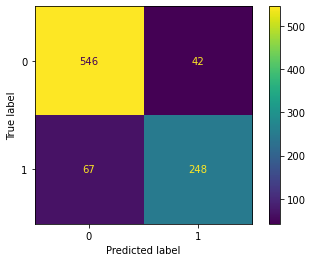

In [11]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, y_test) 

## Step 4: Assessing feature importance
For each of the 11 features in the data, a feature importance plot shows how much the prediction changes if the feature value changes. The bigger the value of the feature importance, the bigger the expected change to the prediction value. Feature importance values are normalized to [0, 100].

### Step 4a: Get feature importances

In [12]:
fea_ = model.feature_importances_

fea_name = list(X.columns)
fea_name = [str(j) for j in fea_name]

for f_name,f in zip(fea_name,fea_):
    print(f_name,':',f)

traffic_density : 26.638743131508885
sa_correct : 6.984130540562224
wl_rating : 6.495648674649652
interbeat_interval : 13.910265340040736
rx : 11.15159385298441
ry : 8.142260815637899
rz : 9.207577768151527
eyeblink : 5.683518119765612
negative : 4.104138998070737
neutral : 4.390313480060402
positive : 3.291809278567916


<BarContainer object of 11 artists>

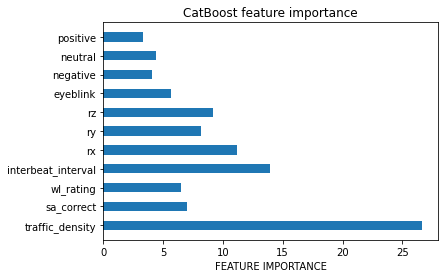

In [13]:
import matplotlib.pyplot as plt

plt.title('CatBoost feature importance')
plt.xlabel('FEATURE IMPORTANCE')
plt.barh(fea_name,fea_,height =0.5)